In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# =============================================================================
# 📦 INSTALLATION ET IMPORTS
# =============================================================================

# Installation des dépendances critiques avec versions fixes
# Dans un environnement Kaggle/Colab, la cellule suivante doit être exécutée avec '%%capture'
# =============================================================================
# ✅ Installation des dépendances avec versions stables et compatibles
# =============================================================================

%pip install -q numpy==1.24.3 pandas==2.0.3 scikit-learn==1.2.2
%pip install -q xgboost==1.7.6 lightgbm==4.0.0 catboost==1.2
%pip install -q shap==0.42.1 imbalanced-learn==0.10.1
%pip install -q optuna==3.3.0 plotly==5.15.0 seaborn==0.12.2
%pip install -q evidently==0.4.2 pydantic==1.10.11
%pip install -q mlflow==2.5.0 feature-engine==1.6.2 joblib
%pip install -q pyarrow==14.0.1



# =============================================================================
# ✅ Installation des dépendances avec versions stables et compatibles
# =============================================================================

%pip install -q numpy==1.24.3 pandas==2.0.3 scikit-learn==1.2.2
%pip install -q xgboost==1.7.6 lightgbm==4.0.0 catboost==1.2
%pip install -q shap==0.42.1 imbalanced-learn==0.10.1
%pip install -q optuna==3.3.0 plotly==5.15.0 seaborn==0.12.2
%pip install -q evidently==0.4.2 pydantic==1.10.11
%pip install -q mlflow==2.5.0 feature-engine==1.6.2 joblib
%pip install -q pyarrow==14.0.1



from evidently import ColumnMapping
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset, TargetDriftPreset

print("✅ Tout est importé avec succès !")

# Imports essentiels
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import joblib

# ML Core
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_val_score
)
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_recall_curve, average_precision_score,
    f1_score, fbeta_score, matthews_corrcoef, roc_curve
)
from sklearn.preprocessing import (
    StandardScaler, RobustScaler, LabelEncoder,
    QuantileTransformer, PowerTransformer
)
from sklearn.feature_selection import (
    SelectKBest, f_classif, VarianceThreshold,
    mutual_info_classif
)
from sklearn.ensemble import (
    RandomForestClassifier, ExtraTreesClassifier,
    StackingClassifier, IsolationForest
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# ML Spécialisé
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.combine import SMOTEENN
import shap
import optuna

# Validation et monitoring
from pydantic import BaseModel, validator
from evidently import ColumnMapping
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset, TargetDriftPreset

# Configuration globale
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

# Seed pour reproductibilité
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✅ Environnement configuré avec succès!")


In [ ]:
from dataclasses import dataclass
from pydantic import BaseModel, validator
# =============================================================================
# 🏗️ ARCHITECTURE DE DONNÉES ET VALIDATION
# =============================================================================

@dataclass
class ModelConfig:
    """Configuration centralisée du modèle"""
    random_state: int = 42
    test_size: float = 0.2
    cv_folds: int = 5
    optuna_trials: int = 30  # Ajusté pour une exécution rapide
    model_version: str = "2.0.0"

class HealthDataValidator(BaseModel):
    """Validateur Pydantic pour les données de santé"""
    patient_id: str
    age: int
    heart_rate: float
    systolic_bp: float
    diastolic_bp: float
    temperature: float
    activity_level: float

    @validator('age')
    def validate_age(cls, v):
        if not 60 <= v <= 120:
            raise ValueError('Âge doit être entre 60 et 120 ans')
        return v

    @validator('heart_rate')
    def validate_heart_rate(cls, v):
        if not 40 <= v <= 180:
            raise ValueError('Fréquence cardiaque non physiologique')
        return v

    @validator('systolic_bp', 'diastolic_bp')
    def validate_blood_pressure(cls, v, field):
        if field.name == 'systolic_bp' and not 80 <= v <= 220:
            raise ValueError('Pression systolique anormale')
        if field.name == 'diastolic_bp' and not 40 <= v <= 140:
            raise ValueError('Pression diastolique anormale')
        return v

config = ModelConfig()
print(f"📋 Configuration du modèle v{config.model_version} initialisée")

In [ ]:
# =============================================================================
# 📊 GÉNÉRATION DE DONNÉES SYNTHÉTIQUES RÉALISTES
# =============================================================================

def generate_synthetic_frailty_data(n_samples: int = 5000) -> pd.DataFrame:
    """Génère des données synthétiques réalistes pour la détection de fragilité"""
    np.random.seed(RANDOM_STATE)
    
    patient_ids = [f"P_{i:05d}" for i in range(1, n_samples + 1)]
    ages = np.random.normal(75, 8, n_samples).clip(65, 95).astype(int)
    genders = np.random.choice(['M', 'F'], n_samples, p=[0.45, 0.55])
    
    base_heart_rate = np.random.normal(72, 12, n_samples)
    heart_rate_variability = np.random.exponential(25, n_samples)
    
    age_factor = (ages - 65) / 30
    systolic_bp = 120 + age_factor * 30 + np.random.normal(0, 15, n_samples)
    diastolic_bp = 80 + age_factor * 10 + np.random.normal(0, 10, n_samples)
    
    temperature = np.random.normal(36.6, 0.4, n_samples).clip(35.5, 38.5)
    activity_base = np.random.gamma(2, 2, n_samples)
    mobility_score = np.random.beta(2, 3, n_samples) * 10
    bmi = np.random.normal(26, 4, n_samples).clip(18, 40)
    grip_strength = 35 - (ages - 65) * 0.5 + np.random.normal(0, 8, n_samples)
    grip_strength = grip_strength.clip(10, 50)
    
    diabetes = np.random.binomial(1, 0.25, n_samples)
    hypertension = np.random.binomial(1, 0.4, n_samples)
    heart_disease = np.random.binomial(1, 0.2, n_samples)
    
    smoking_history = np.random.choice([0, 1, 2], n_samples, p=[0.6, 0.3, 0.1])
    alcohol_consumption = np.random.choice([0, 1, 2, 3], n_samples, p=[0.3, 0.4, 0.2, 0.1])
    
    timestamps = pd.to_datetime(pd.date_range('2024-01-01', periods=n_samples, freq='H'))
    pulse_pressure = systolic_bp - diastolic_bp
    mean_arterial_pressure = diastolic_bp + pulse_pressure / 3
    
    frailty_score = (
        0.3 * (ages > 80).astype(int) +
        0.2 * (grip_strength < 20).astype(int) +
        0.2 * (mobility_score < 3).astype(int) +
        0.1 * (bmi < 20).astype(int) +
        0.1 * diabetes +
        0.1 * heart_disease +
        np.random.normal(0, 0.15, n_samples)
    )
    is_frail = (frailty_score > 0.6).astype(int)
    
    data = pd.DataFrame({
        'patient_id': patient_ids, 'timestamp': timestamps, 'age': ages, 'gender': genders,
        'heart_rate': base_heart_rate.clip(45, 120), 'heart_rate_variability': heart_rate_variability.clip(5, 100),
        'systolic_bp': systolic_bp.clip(90, 200), 'diastolic_bp': diastolic_bp.clip(50, 110),
        'pulse_pressure': pulse_pressure, 'mean_arterial_pressure': mean_arterial_pressure,
        'temperature': temperature, 'bmi': bmi, 'grip_strength': grip_strength, 'mobility_score': mobility_score,
        'activity_level': activity_base.clip(0, 10), 'diabetes': diabetes, 'hypertension': hypertension,
        'heart_disease': heart_disease, 'smoking_history': smoking_history, 'alcohol_consumption': alcohol_consumption,
        'frailty_score': frailty_score.clip(0, 1), 'is_frail': is_frail
    })
    
    missing_cols = ['heart_rate_variability', 'grip_strength', 'activity_level']
    for col in missing_cols:
        missing_mask = np.random.random(n_samples) < 0.07
        data.loc[missing_mask, col] = np.nan
    
    return data

print("🔄 Génération des données synthétiques...")
df = generate_synthetic_frailty_data(n_samples=8000)
print(f"📊 Dataset généré: {df.shape[0]} patients, {df.shape[1]} variables")
print(f"🎯 Distribution de la cible: {df['is_frail'].value_counts().to_dict()}")
print(f"📈 Pourcentage de fragilité: {df['is_frail'].mean():.1%}")

In [ ]:
# a supprimer peut etre

def generate_synthetic_data():
    from sklearn.datasets import make_classification
    print("📊 Génération de données synthiques...")
    X, y = make_classification(n_samples=300, n_features=8, random_state=42)
    df = pd.DataFrame(X, columns=[f"feat_{i}" for i in range(8)])

    # Ajout de colonnes biomédicales simulées
    df['timestamp'] = pd.date_range(start='2023-01-01', periods=300, freq='H')
    df['bmi'] = np.random.uniform(18, 35, size=300)
    df['age'] = np.random.randint(20, 70, size=300)
    df['pulse_pressure'] = np.random.uniform(30, 60, size=300)
    df['systolic_bp'] = np.random.uniform(110, 140, size=300)
    df['diabetes'] = np.random.randint(0, 2, size=300)
    df['hypertension'] = np.random.randint(0, 2, size=300)
    df['heart_disease'] = np.random.randint(0, 2, size=300)
    df['gender'] = np.random.choice(['M', 'F'], size=300)
    
    print("✅ Données synthétiques créées avec succès")
    return df, y


In [ ]:
class AdvancedFeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        print("🛠️ Fit du FeatureEngineer - aucune opération nécessaire ici.")
        return self

    def transform(self, X):
        print("🛠️ Transformation : ajout de nouvelles variables explicatives...")
        df = X.copy()
        df['hour'] = df['timestamp'].dt.hour
        df['day_of_week'] = df['timestamp'].dt.dayofweek
        df['bmi_age_ratio'] = df['bmi'] / (df['age'] / 70)
        df['pulse_pressure_norm'] = df['pulse_pressure'] / df['systolic_bp']
        df['total_comorbidities'] = df[['diabetes', 'hypertension', 'heart_disease']].sum(axis=1)
        print("✅ 5 nouvelles variables créées.")
        return df


In [ ]:
class MedicalDataCleaner(BaseEstimator, TransformerMixin):
    def __init__(self):
        print("🧹 Initialisation de l’imputeur avec ExtraTreesClassifier")
        self.imputer = IterativeImputer(
            estimator=ExtraTreesClassifier(n_estimators=10, random_state=42),
            max_iter=5,
            random_state=42
        )
        self.numeric_cols = None

    def fit(self, X, y=None):
        print("🧹 Fit de l’imputeur sur les colonnes numériques...")
        self.numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
        self.imputer.fit(X[self.numeric_cols])
        print(f"✅ Colonnes numériques détectées : {self.numeric_cols}")
        return self

    def transform(self, X):
        print("🧹 Application de l’imputation et encodage binaire du genre...")
        df = X.copy()
        df[self.numeric_cols] = self.imputer.transform(df[self.numeric_cols])
        if 'gender' in df.columns:
            df['gender'] = df['gender'].apply(lambda x: 1 if x == 'M' else 0)
        print("✅ Nettoyage terminé.")
        return df


In [ ]:
class AdvancedEnsembleClassifier:
    def __init__(self, random_state=42):
        print("🤖 Initialisation du classifieur d’ensemble (RandomForest ici)...")
        self.random_state = random_state

    def create_ensemble(self):
        print("✅ Création d’un RandomForestClassifier")
        return RandomForestClassifier(random_state=self.random_state)


In [ ]:
class OptunaMultiObjectiveOptimizer:
    def __init__(self, config, ensemble_builder, study_path="optuna_study.pkl"):
        print("📌 Initialisation de l’optimiseur Optuna multi-objectifs")
        self.config = config
        self.ensemble_builder = ensemble_builder
        self.study_path = study_path
        self.scorers = {
            'f2': make_scorer(fbeta_score, beta=2),
            'recall': make_scorer(recall_score),
            'precision': make_scorer(precision_score)
        }
        self.study = None

    def _load_or_create_study(self):
        if os.path.exists(self.study_path):
            print(f"📂 Chargement étude depuis {self.study_path}")
            self.study = joblib.load(self.study_path)
        else:
            print("📈 Création nouvelle étude Optuna multi-objectifs")
            self.study = optuna.create_study(
                directions=['maximize', 'maximize', 'maximize'],
                sampler=optuna.samplers.TPESampler(seed=self.config.random_state)
            )

    def objective(self, trial, X, y):
        print(f"🎯 Trial {trial.number} - optimisation hyperparamètres")
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 400),
            'max_depth': trial.suggest_int('max_depth', 5, 20),
        }
        model = self.ensemble_builder.create_ensemble()
        model.set_params(**params)

        results = []
        for name, scorer in self.scorers.items():
            print(f"🔍 Validation croisée - scoring: {name}")
            score = cross_val_score(model, X, y, cv=3, scoring=scorer, n_jobs=-1).mean()
            results.append(score)
            print(f"   ✅ Score moyen {name}: {score:.4f}")
        return tuple(results)

    def optimize(self, X, y, n_trials):
        self._load_or_create_study()
        print("🚀 Début de l’optimisation Optuna...")

        def save_checkpoint(study, trial):
            joblib.dump(study, self.study_path)
            print(f"💾 Checkpoint sauvegardé après trial {trial.number}")

        self.study.optimize(
            lambda trial: self.objective(trial, X, y),
            n_trials=n_trials,
            show_progress_bar=True,
            callbacks=[save_checkpoint]
        )
        joblib.dump(self.study, self.study_path)
        print("✅ Optimisation terminée, étude sauvegardée")
        return self.study


In [ ]:
def train_and_save_best_model(study, X, y, builder, metric_index=0, filename="best_model.joblib"):
    print(f"🏆 Sélection du meilleur modèle selon la métrique #{metric_index} (ex: 0=F2)...")
    best_trial = max(study.best_trials, key=lambda t: t.values[metric_index])
    best_params = best_trial.params
    print(f"✅ Paramètres optimaux : {best_params}")

    model = builder.create_ensemble()
    model.set_params(**best_params)
    print("🔄 Entraînement du modèle...")
    model.fit(X, y)
    joblib.dump(model, filename)
    print(f"💾 Modèle sauvegardé dans : {filename}")
    return model


In [ ]:
def visualize_study(study_path="optuna_study.pkl"):
    import optuna.visualization as vis
    if not os.path.exists(study_path):
        print("❌ Aucun fichier d’étude trouvé.")
        return
    print(f"📊 Chargement de l’étude {study_path} pour visualisation...")
    study = joblib.load(study_path)
    print("📈 Pareto front (F2 vs recall vs precision)")
    vis.plot_pareto_front(study).show()
    print("📉 Importance des hyperparamètres")
    vis.plot_param_importances(study).show()


In [ ]:
def run_pipeline():
    print("🏁 Lancement complet du pipeline de bout-en-bout...")
    
    # 1. Données synthétiques
    df, y = generate_synthetic_data()

    # 2. Preprocessing pipeline
    print("🔧 Application du pipeline de preprocessing...")
    feature_engineer = AdvancedFeatureEngineer()
    cleaner = MedicalDataCleaner()
    df = feature_engineer.fit_transform(df)
    df = cleaner.fit_transform(df)

    # 3. Ensemble Model
    builder = AdvancedEnsembleClassifier()

    # 4. Configuration simple
    class Config:
        random_state = 42
        optuna_trials = 10
    config = Config()

    # 5. Optuna Optimizer
    optimizer = OptunaMultiObjectiveOptimizer(config, builder)
    study = optimizer.optimize(df, y, n_trials=config.optuna_trials)

    # 6. Training du meilleur modèle
    model = train_and_save_best_model(study, df, y, builder)

    # 7. Visualisation
    visualize_study()

#if __name__ == "__main__":

run_pipeline()


In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

print("🔍 Sélection de features via RandomForest (importance)...")
selector = SelectFromModel(RandomForestClassifier(n_estimators=100), threshold="mean")
X_selected = selector.fit_transform(df, y)
selected_features = df.columns[selector.get_support()]
print(f"✅ {len(selected_features)} features sélectionnées sur {df.shape[1]}")


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier

feature_selector = SelectFromModel(ExtraTreesClassifier(n_estimators=100), threshold="median")

full_pipeline = Pipeline([
    ("feature_engineering", AdvancedFeatureEngineer()),
    ("cleaning", MedicalDataCleaner()),
    ("feature_selection", feature_selector),
    ("model", RandomForestClassifier())
])


In [ ]:
# =============================================================================
# 1. 📦 INSTALLATION ET CONFIGURATION DE L'ENVIRONNEMENT
# =============================================================================
print("\n" + "="*80)
print("1. 📦 INSTALLATION ET CONFIGURATION DE L'ENVIRONNEMENT")
print("="*80)

print("\n🔍 [Expert] Configuration initiale de l'environnement de travail avec toutes les dépendances nécessaires.")
print("👶 [Enfant] On prépare tous les outils dont on aura besoin pour construire notre modèle, comme un bricoleur prépare ses outils avant de commencer à travailler.")
print("\n💡 Alternatives :")
print("- On pourrait utiliser un environnement virtuel (conda, venv) pour isoler les dépendances")
print("- Pour une vraie industrialisation, on utiliserait Docker pour garantir la reproductibilité")

# La commande '%%capture' masque la sortie de la cellule pour plus de clarté.
# %%capture
!pip install -q numpy==1.24.3 pandas==2.0.3 scikit-learn==1.2.2
!pip install -q xgboost==1.7.6 lightgbm==4.0.0 catboost==1.2
!pip install -q shap==0.42.1 imbalanced-learn==0.10.1
!pip install -q optuna==3.3.0 plotly==5.15.0 seaborn==0.12.2
!pip install -q evidently==0.4.2 pydantic==1.10.11
!pip install -q joblib

print("\n🔍 [Expert] Importation de toutes les bibliothèques nécessaires pour le projet.")
print("👶 [Enfant] On sort toutes les boîtes d'outils dont on aura besoin et on les range sur la table.")

# --- Imports Essentiels ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import joblib
import os
from dataclasses import dataclass

# --- Imports pour le Preprocessing et la Pipeline ---
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

# --- Imports pour la Modélisation ---
import lightgbm as lgb
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, fbeta_score,
    precision_recall_curve, average_precision_score, make_scorer, roc_curve
)

# --- Imports pour l'Optimisation et l'Interprétabilité ---
import optuna
import shap

# --- Imports pour la Validation et le Monitoring ---
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset

print("\n🔍 [Expert] Configuration des paramètres globaux pour la reproductibilité et la visualisation.")
print("👶 [Enfant] On règle tous nos outils pour qu'ils fonctionnent de la même manière à chaque fois.")

# --- Configuration Globale ---
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

# Seed pour une reproductibilité parfaite
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("\n✅ Environnement configuré avec succès. Les bibliothèques sont prêtes.")

# =============================================================================
# 2. 🏗️ ARCHITECTURE DE DONNÉES ET FONCTION DE GÉNÉRATION
# =============================================================================
print("\n" + "="*80)
print("2. 🏗️ ARCHITECTURE DE DONNÉES ET FONCTION DE GÉNÉRATION")
print("="*80)

print("\n🔍 [Expert] Définition de la structure des données via une classe de configuration centralisée.")
print("👶 [Enfant] On crée une recette qui explique comment notre modèle va apprendre.")

@dataclass
class ModelConfig:
    """Configuration centralisée pour la reproductibilité du modèle."""
    random_state: int = RANDOM_STATE
    test_size: float = 0.2
    cv_folds: int = 5
    optuna_trials: int = 25
    f_beta_value: float = 2.0

print("\n💡 Alternatives :")
print("- On pourrait utiliser un fichier YAML/JSON pour la configuration")
print("- Pour des projets complexes, on utiliserait Hydra ou OmegaConf")

config = ModelConfig()
print(f"\n📋 Configuration du modèle initialisée: {config}")

print("\n🔍 [Expert] Génération de données synthétiques réalistes pour simuler un dataset médical.")
print("👶 [Enfant] On invente des exemples de patients avec leurs caractéristiques pour que notre modèle puisse apprendre.")

def generate_synthetic_frailty_data(n_samples: int = 2500) -> pd.DataFrame:
    """Génère des données synthétiques riches et réalistes pour la détection de fragilité."""
    np.random.seed(config.random_state)
    
    # Démographie
    patient_ids = [f"P_{i:05d}" for i in range(1, n_samples + 1)]
    ages = np.random.normal(78, 8, n_samples).clip(65, 98).astype(int)
    genders = np.random.choice(['Homme', 'Femme'], n_samples, p=[0.45, 0.55])
    
    # Signes vitaux
    heart_rate = np.random.normal(72, 12, n_samples)
    systolic_bp = 125 + (ages - 78) * 0.8 + np.random.normal(0, 15, n_samples)
    diastolic_bp = 80 + (ages - 78) * 0.2 + np.random.normal(0, 10, n_samples)
    
    # Métriques de fragilité
    grip_strength = 30 - (ages - 65) * 0.4 + np.random.normal(0, 5, n_samples)
    mobility_score = np.random.beta(2, 5, n_samples) * 10
    
    # Comorbidités et style de vie
    comorbidities_count = np.random.poisson(1.5, n_samples).clip(0, 5)
    medication_count = np.random.poisson(3, n_samples).clip(0, 12)
    
    # Logique de la cible 'is_frail'
    frailty_score = (
        0.4 * (ages > 85).astype(int) + 
        0.3 * (grip_strength < 22).astype(int) + 
        0.2 * (mobility_score < 4).astype(int) + 
        0.15 * (comorbidities_count > 3).astype(int) + 
        0.1 * (medication_count > 6).astype(int) + 
        np.random.normal(0, 0.1, n_samples)
    )
    is_frail = (frailty_score > 0.55).astype(int)
    
    data = pd.DataFrame({
        'patient_id': patient_ids, 'age': ages, 'gender': genders,
        'heart_rate': heart_rate.clip(45, 120),
        'systolic_bp': systolic_bp.clip(90, 200),
        'diastolic_bp': diastolic_bp.clip(50, 110),
        'grip_strength': grip_strength.clip(10, 50),
        'mobility_score': mobility_score.clip(0, 10),
        'comorbidities_count': comorbidities_count,
        'medication_count': medication_count,
        'is_frail': is_frail
    })
    
    # Introduction de valeurs manquantes
    for col in ['grip_strength', 'mobility_score']:
        missing_mask = np.random.random(n_samples) < 0.10
        data.loc[missing_mask, col] = np.nan
    
    return data

print("\n💡 Alternatives :")
print("- On pourrait charger des données réelles depuis une base de données ou un fichier CSV")
print("- Pour des données plus complexes, on utiliserait Faker ou SDV (Synthetic Data Vault)")

print("\n🔄 Génération des données synthétiques...")
df_raw = generate_synthetic_frailty_data()

print(f"\n📊 Dataset brut généré: {df_raw.shape[0]} patients, {df_raw.shape[1]} variables.")
print("\n🎯 Distribution de la cible (is_frail) :")
print(df_raw['is_frail'].value_counts(normalize=True).round(3))

print("\n🔍 Aperçu des données et des valeurs manquantes :")
df_raw.info()

# =============================================================================
# 3. 🛡️ SÉPARATION STRATÉGIQUE DES DONNÉES (TRAIN/TEST)
# =============================================================================
print("\n" + "="*80)
print("3. 🛡️ SÉPARATION STRATÉGIQUE DES DONNÉES (TRAIN/TEST)")
print("="*80)

print("\n🔍 [Expert] Séparation des données en ensembles d'entraînement et de test avec stratification.")
print("👶 [Enfant] On sépare nos exemples en deux piles : une pour apprendre et une pour vérifier qu'on a bien appris.")

print("\n💡 Alternatives :")
print("- On pourrait utiliser TimeSeriesSplit pour des données temporelles")
print("- Pour des petits datasets, on utiliserait Leave-One-Out ou Bootstrap")

# Définition des features (X) et de la cible (y)
X = df_raw.drop(['is_frail', 'patient_id'], axis=1)
y = df_raw['is_frail']

# Séparation stratifiée
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=config.test_size, 
    random_state=config.random_state,
    stratify=y
)

print(f"\nDimensions de l'ensemble d'entraînement: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Dimensions de l'ensemble de test:       X_test={X_test.shape}, y_test={y_test.shape}")

print("\nDistribution de la cible dans l'ensemble d'entraînement:")
print(y_train.value_counts(normalize=True).round(3))

print("\nDistribution de la cible dans l'ensemble de test:")
print(y_test.value_counts(normalize=True).round(3))
print("\n✅ La stratification a bien conservé la distribution de la cible.")

# =============================================================================
# 4. 🛠️ DÉFINITION DU PIPELINE DE PRÉTRAITEMENT ROBUSTE
# =============================================================================
print("\n" + "="*80)
print("4. 🛠️ DÉFINITION DU PIPELINE DE PRÉTRAITEMENT ROBUSTE")
print("="*80)

print("\n🔍 [Expert] Construction d'un pipeline de prétraitement robuste avec ColumnTransformer.")
print("👶 [Enfant] On prépare une machine qui nettoie et organise les données avant que le modèle ne les utilise.")

print("\n💡 Alternatives :")
print("- On pourrait utiliser Feature-engine ou Scikit-lego pour des transformations plus avancées")
print("- Pour des données temporelles, on utiliserait tsfresh ou tsfel")

# Identification automatique des types de colonnes
numeric_features = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"\nDétection automatique des colonnes:")
print(f"  - Numériques ({len(numeric_features)}): {numeric_features}")
print(f"  - Catégorielles ({len(categorical_features)}): {categorical_features}")

print("\n🔍 [Expert] Création d'un transformateur personnalisé pour l'ingénierie de features.")
print("👶 [Enfant] On ajoute une partie spéciale à notre machine qui crée de nouvelles informations utiles.")

class FeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy['pulse_pressure'] = X_copy['systolic_bp'] - X_copy['diastolic_bp']
        X_copy['bp_mobility_interaction'] = X_copy['systolic_bp'] * X_copy['mobility_score']
        return X_copy

print("\nPipeline numérique: Imputer (médiane) -> RobustScaler")
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

print("\nPipeline catégoriel: Imputer (mode) -> OneHotEncoder")
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

print("\n🔍 [Expert] Combinaison des pipelines avec ColumnTransformer.")
print("👶 [Enfant] On assemble toutes les parties de notre machine pour qu'elle fonctionne ensemble.")

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

print("\n✅ Préprocesseur combiné (ColumnTransformer) créé.")

# =============================================================================
# 5. 🚀 OPTIMISATION DES HYPERPARAMÈTRES AVEC OPTUNA
# =============================================================================
print("\n" + "="*80)
print("5. 🚀 OPTIMISATION DES HYPERPARAMÈTRES AVEC OPTUNA")
print("="*80)

print("\n🔍 [Expert] Optimisation des hyperparamètres avec Optuna et validation croisée.")
print("👶 [Enfant] On règle finement notre machine pour qu'elle fonctionne le mieux possible.")

print("\n💡 Alternatives :")
print("- On pourrait utiliser GridSearchCV ou RandomizedSearchCV de scikit-learn")
print("- Pour des modèles complexes, on utiliserait Ray Tune ou Weights & Biases Sweeps")

def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.2, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 10, 50),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'random_state': config.random_state,
        'n_jobs': -1
    }

    f2_scorer = make_scorer(fbeta_score, beta=config.f_beta_value)
    
    scores = []
    cv = StratifiedKFold(n_splits=config.cv_folds, shuffle=True, random_state=config.random_state)
    
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model_pipeline = Pipeline(steps=[
            ('feature_engineering', FeatureEngineer()),
            ('preprocessor', preprocessor),
            ('classifier', lgb.LGBMClassifier(**params))
        ])
        
        model_pipeline.fit(X_train_fold, y_train_fold)
        preds = model_pipeline.predict(X_val_fold)
        score = fbeta_score(y_val_fold, preds, beta=config.f_beta_value)
        scores.append(score)

    return np.mean(scores)

print(f"\nLancement de l'étude Optuna pour {config.optuna_trials} essais...")
print(f"Objectif: Maximiser le F{config.f_beta_value}-score moyen par validation croisée.")

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=config.random_state))
study.optimize(objective, n_trials=config.optuna_trials, show_progress_bar=True)

print(f"\n✅ Optimisation terminée.")
print(f"Meilleur score F2 moyen (CV): {study.best_value:.4f}")
print(f"Meilleurs hyperparamètres trouvés: {study.best_params}")

# =============================================================================
# 6. 🎓 ENTRAÎNEMENT ET SAUVEGARDE DU PIPELINE FINAL
# =============================================================================
print("\n" + "="*80)
print("6. 🎓 ENTRAÎNEMENT ET SAUVEGARDE DU PIPELINE FINAL")
print("="*80)

print("\n🔍 [Expert] Entraînement du pipeline final avec les meilleurs hyperparamètres.")
print("👶 [Enfant] On fait travailler notre machine bien réglée sur tous les exemples d'apprentissage.")

print("\n💡 Alternatives :")
print("- On pourrait utiliser MLflow pour suivre les expériences et versionner les modèles")
print("- Pour le déploiement, on pourrait sauvegarder au format ONNX ou PMML")

best_params = study.best_params

final_pipeline = Pipeline(steps=[
    ('feature_engineering', FeatureEngineer()),
    ('preprocessor', preprocessor),
    ('classifier', lgb.LGBMClassifier(**best_params, random_state=config.random_state))
])

print("\nEntraînement du pipeline final sur l'ENSEMBLE des données d'entraînement...")
final_pipeline.fit(X_train, y_train)
print("✅ Pipeline final entraîné.")

filename = 'final_frailty_pipeline.joblib'
joblib.dump(final_pipeline, filename)
print(f"\n💾 Pipeline complet sauvegardé sous le nom : '{filename}'")

# =============================================================================
# 7. 📈 ÉVALUATION FINALE SUR L'ENSEMBLE DE TEST
# =============================================================================
print("\n" + "="*80)
print("7. 📈 ÉVALUATION FINALE SUR L'ENSEMBLE DE TEST")
print("="*80)

print("\n🔍 [Expert] Évaluation rigoureuse du modèle sur des données jamais vues.")
print("👶 [Enfant] On vérifie que notre machine fonctionne bien sur des nouveaux exemples qu'elle n'a jamais vus.")

print("\n💡 Alternatives :")
print("- On pourrait calculer des intervalles de confiance via bootstrap")
print("- Pour des problèmes déséquilibrés, on pourrait utiliser le score F1 ou le MCC")

print(f"\nChargement du pipeline depuis '{filename}'...")
loaded_pipeline = joblib.load(filename)

print("\nGénération des prédictions sur X_test...")
y_pred = loaded_pipeline.predict(X_test)
y_pred_proba = loaded_pipeline.predict_proba(X_test)[:, 1]

print("\n---------- RAPPORT DE CLASSIFICATION ----------")
print(classification_report(y_test, y_pred, target_names=['Non Fragile (0)', 'Fragile (1)']))

print("\n🔍 [Expert] Visualisation de la matrice de confusion pour analyser les erreurs.")
print("👶 [Enfant] On regarde où notre machine se trompe le plus souvent.")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Prédit Non Fragile', 'Prédit Fragile'],
            yticklabels=['Vrai Non Fragile', 'Vrai Fragile'])
plt.title('Matrice de Confusion sur l\'Ensemble de Test')
plt.ylabel('Classe Réelle')
plt.xlabel('Classe Prédite')
plt.show()

print("\n🔍 [Expert] Analyse des courbes ROC et Precision-Recall.")
print("👶 [Enfant] On dessine des graphiques pour voir à quel point notre machine est bonne.")

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
pr_auc = average_precision_score(y_test, y_pred_proba)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'Courbe ROC (AUC = {roc_auc:.3f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_xlabel('Taux de Faux Positifs')
ax1.set_ylabel('Taux de Vrais Positifs (Rappel)')
ax1.set_title('Courbe ROC')
ax1.legend(loc='lower right')

ax2.plot(recall, precision, color='blue', lw=2, label=f'Courbe P-R (AUC = {pr_auc:.3f})')
ax2.set_xlabel('Rappel (Recall)')
ax2.set_ylabel('Précision (Precision)')
ax2.set_title('Courbe Précision-Rappel')
ax2.legend(loc='lower left')

plt.suptitle('Analyse des Performances du Modèle sur l\'Ensemble de Test', fontsize=16)
plt.show()

# =============================================================================
# 8. 🧠 INTERPRÉTABILITÉ DU MODÈLE AVEC SHAP
# =============================================================================
print("\n" + "="*80)
print("8. 🧠 INTERPRÉTABILITÉ DU MODÈLE AVEC SHAP")
print("="*80)

print("\n🔍 [Expert] Analyse SHAP pour comprendre l'importance des features et les prédictions.")
print("👶 [Enfant] On ouvre la machine pour voir comment elle prend ses décisions.")

print("\n💡 Alternatives :")
print("- On pourrait utiliser LIME pour des explications locales")
print("- Pour les modèles linéaires, on analyserait directement les coefficients")

print("\nExtraction des composants du pipeline...")
feature_engineer = loaded_pipeline.named_steps['feature_engineering']
preprocessor = loaded_pipeline.named_steps['preprocessor']
model = loaded_pipeline.named_steps['classifier']

print("\nTransformation des données pour l'explainer SHAP...")
X_train_engineered = feature_engineer.transform(X_train)
X_train_processed = preprocessor.transform(X_train_engineered)

print("\nRécupération des noms de features finaux...")
ohe_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
engineered_numeric_features = [col for col in X_train_engineered.columns if col not in categorical_features]
final_feature_names = engineered_numeric_features + list(ohe_feature_names)

X_train_processed_df = pd.DataFrame(X_train_processed, columns=final_feature_names, index=X_train.index)

print("\nCalcul des valeurs SHAP... (peut prendre un moment)")
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_processed_df)

print("\nAffichage du SHAP Summary Plot:")
print("Chaque point est un patient. La couleur indique la valeur de la feature (rouge=élevée).")
print("L'axe X montre l'impact sur la prédiction (vers la droite = probabilité de fragilité plus élevée).")

shap.summary_plot(shap_values[1], X_train_processed_df, plot_type="dot")

# =============================================================================
# 9. 🛰️ MONITORING DE DÉRIVE DES DONNÉES (DATA DRIFT)
# =============================================================================
print("\n" + "="*80)
print("9. 🛰️ MONITORING DE DÉRIVE DES DONNÉES (DATA DRIFT)")
print("="*80)

print("\n🔍 [Expert] Détection de dérive des données avec Evidently AI.")
print("👶 [Enfant] On vérifie si les nouveaux patients ressemblent à ceux sur lesquels on a appris.")

print("\n💡 Alternatives :")
print("- On pourrait utiliser Alibi Detect ou Great Expectations")
print("- Pour une intégration en production, on utiliserait Prometheus/Grafana")

print("\nPréparation des données de référence et courantes...")
reference_data = X_train.copy()
current_data = X_test.copy()

reference_data['target'] = y_train
current_data['target'] = y_test

print("\nCréation du rapport de dérive des données...")
data_drift_report = Report(metrics=[DataDriftPreset()])
data_drift_report.run(reference_data=reference_data, current_data=current_data)

print("\n✅ Rapport de dérive généré.")
report_path = 'data_drift_report.html'
data_drift_report.save_html(report_path)
print(f"\n💾 Rapport de dérive sauvegardé ici : '{report_path}'")
# =============================================================================
# 10. ✅ CONCLUSION ET PROCHAINES ÉTAPES
# =============================================================================
print("\n" + "="*80)
print("10. ✅ CONCLUSION ET PROCHAINES ÉTAPES")
print("="*80)

print("\n🔍 [Expert] Synthèse des résultats et recommandations pour l'industrialisation.")
print("👶 [Enfant] On regarde ce qu'on a appris et comment on pourrait faire encore mieux.")

print("\n🌟 Synthèse des Résultats :")
print("- Pipeline complet entraîné et validé avec succès")
print(f"- Performance sur le jeu de test : AUC-ROC = {roc_auc:.3f}, F2-score = {study.best_value:.3f}")
print("- Principaux drivers identifiés : âge, force de préhension, mobilité")

print("\n🚀 Prochaines Étapes pour Industrialisation :")
print("1. Déploiement en tant qu'API avec FastAPI ou Flask")
print("2. Intégration MLOps avec MLflow ou Kubeflow")
print("3. Monitoring continu des performances en production")
print("4. Validation par des experts métier (médecins gériatres)")

print("\n" + "="*80)
print("🏁 PROJET TERMINÉ AVEC SUCCÈS")
print("="*80)

In [ ]:
# =============================================================================
# 5. 🚀 OPTIMISATION DES HYPERPARAMÈTRES AVEC OPTUNA (AVEC CHECKPOINTS)
# =============================================================================
print("\n" + "="*80)
print("5. 🚀 OPTIMISATION DES HYPERPARAMÈTRES AVEC OPTUNA ET CHECKPOINTS")
print("="*80)

print("\n🔍 [Expert] Optimisation avec sauvegarde des checkpoints pour reprise après interruption.")
print("👶 [Enfant] On enregistre régulièrement notre travail pour ne pas tout perdre si quelque chose se passe mal.")

print("\n💡 Bonnes pratiques :")
print("- Sauvegarder après chaque essai d'hyperparamètres")
print("- Stocker les métriques et les paramètres")
print("- Permettre la reprise de l'optimisation")

# Création d'un répertoire pour les checkpoints
CHECKPOINT_DIR = "optuna_checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
CHECKPOINT_PATH = os.path.join(CHECKPOINT_DIR, "optuna_study.pkl")

print(f"\n📁 Répertoire des checkpoints créé : {CHECKPOINT_DIR}")

# Callback de sauvegarde
def save_checkpoint(study, trial):
    joblib.dump(study, CHECKPOINT_PATH)
    print(f"💾 Checkpoint sauvegardé (essai {trial.number})")

# Vérification si une étude existe déjà
if os.path.exists(CHECKPOINT_PATH):
    print("\n🔍 Une étude existante a été trouvée. Chargement...")
    study = joblib.load(CHECKPOINT_PATH)
    print(f"Reprise à partir de l'essai {len(study.trials)}")
else:
    print("\n🔍 Pas d'étude existante trouvée. Création d'une nouvelle étude...")
    study = optuna.create_study(
        direction='maximize', 
        sampler=optuna.samplers.TPESampler(seed=config.random_state),
        study_name="frailty_detection"
    )

print("\n🔍 Configuration de la fonction objective avec gestion des checkpoints")
def objective_with_checkpoint(trial):
    try:
        params = {
            'objective': 'binary',
            'metric': 'binary_logloss',
            'verbosity': -1,
            'boosting_type': 'gbdt',
            'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.2, log=True),
            'num_leaves': trial.suggest_int('num_leaves', 10, 50),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
            'random_state': config.random_state,
            'n_jobs': -1
        }

        f2_scorer = make_scorer(fbeta_score, beta=config.f_beta_value)
        
        scores = []
        cv = StratifiedKFold(n_splits=config.cv_folds, shuffle=True, random_state=config.random_state)
        
        for train_idx, val_idx in cv.split(X_train, y_train):
            X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
            
            model_pipeline = Pipeline(steps=[
                ('feature_engineering', FeatureEngineer()),
                ('preprocessor', preprocessor),
                ('classifier', lgb.LGBMClassifier(**params))
            ])
            
            model_pipeline.fit(X_train_fold, y_train_fold)
            preds = model_pipeline.predict(X_val_fold)
            score = fbeta_score(y_val_fold, preds, beta=config.f_beta_value)
            scores.append(score)

        return np.mean(scores)
    
    except Exception as e:
        print(f"❌ Erreur dans l'essai {trial.number}: {str(e)}")
        raise optuna.TrialPruned()

print("\n🔍 Configuration de l'étude Optuna avec callback de sauvegarde")
study.optimize(
    objective_with_checkpoint, 
    n_trials=config.optuna_trials, 
    callbacks=[save_checkpoint],
    show_progress_bar=True
)

print(f"\n✅ Optimisation terminée. Meilleur score F2: {study.best_value:.4f}")

# =============================================================================
# 6. 🎓 ENTRAÎNEMENT ET SAUVEGARDE DU PIPELINE FINAL (AVEC VERSIONNING)
# =============================================================================
print("\n" + "="*80)
print("6. 🎓 ENTRAÎNEMENT ET SAUVEGARDE AVEC VERSIONNING")
print("="*80)

print("\n🔍 [Expert] Sauvegarde versionnée du modèle final avec métadonnées.")
print("👶 [Enfant] On garde une copie de notre meilleure machine avec son mode d'emploi.")

print("\n💡 Bonnes pratiques :")
print("- Versionner les modèles avec des tags clairs")
print("- Sauvegarder les métadonnées (hyperparamètres, métriques)")
print("- Garder une trace des données d'entraînement")

# Création d'un répertoire de versionnement
MODEL_VERSION = "1.0.0"
MODEL_DIR = f"model_artifacts_v{MODEL_VERSION}"
os.makedirs(MODEL_DIR, exist_ok=True)

print(f"\n📁 Répertoire de versionnement créé : {MODEL_DIR}")

# Sauvegarde du pipeline final
best_params = study.best_params

final_pipeline = Pipeline(steps=[
    ('feature_engineering', FeatureEngineer()),
    ('preprocessor', preprocessor),
    ('classifier', lgb.LGBMClassifier(**best_params, random_state=config.random_state))
])

print("\nEntraînement du pipeline final...")
final_pipeline.fit(X_train, y_train)

# Sauvegarde des différents artefacts
model_path = os.path.join(MODEL_DIR, 'model.joblib')
metadata_path = os.path.join(MODEL_DIR, 'metadata.json')

print("\n💾 Sauvegarde des artefacts du modèle...")
joblib.dump(final_pipeline, model_path)

# Métadonnées à sauvegarder
metadata = {
    "model_version": MODEL_VERSION,
    "training_date": pd.Timestamp.now().isoformat(),
    "features": list(X_train.columns),
    "best_params": best_params,
    "performance": {
        "roc_auc": roc_auc_score(y_test, final_pipeline.predict_proba(X_test)[:, 1]),
        "f2_score": fbeta_score(y_test, final_pipeline.predict(X_test), beta=2.0)
    },
    "data_stats": {
        "train_size": len(X_train),
        "test_size": len(X_test),
        "class_balance": dict(y_train.value_counts(normalize=True).round(3))
    }
}

import json
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=4)

print("\n📝 Métadonnées sauvegardées :")
print(json.dumps(metadata, indent=4))

print("\n✅ Pipeline final et métadonnées sauvegardés avec versionnement.")

In [ ]:
# =============================================================================
# PIPELINE COMPLET AVEC EXPLICATIONS DÉTAILLÉES
# =============================================================================

print("\n🔍 [Expert] Initialisation du pipeline industriel pour la détection de fragilité")
print("👶 [Enfant] On prépare tous les outils pour construire une machine intelligente qui peut repérer les personnes fragiles")
print("\n💡 Alternatives :")
print("- Pour des projets simples : utiliser sklearn sans pipeline")
print("- Pour le big data : utiliser Spark ML ou Dask")
print("- Pour l'IA embarquée : utiliser ONNX Runtime ou TensorFlow Lite")

# 1. 📦 IMPORTATIONS ET CONFIGURATION
# =============================================================================
print("\n" + "="*80)
print("1. 📦 CONFIGURATION DE L'ENVIRONNEMENT")
print("="*80)

print("\n🔍 [Expert] Importation des librairies essentielles pour le machine learning industriel")
print("👶 [Enfant] On sort toutes les boîtes à outils dont on aura besoin")
print("\n💡 Gestion des dépendances :")
print("- En entreprise : utiliser un environnement conda/pip freeze")
print("- En production : conteneur Docker avec versions figées")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from dataclasses import dataclass
import json

print("\n🔍 [Expert] Importation des composants scikit-learn pour le pipeline")
print("👶 [Enfant] On prend les pièces pour construire notre machine")

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

print("\n🔍 [Expert] Métriques pour l'évaluation robuste en milieu clinique")
print("👶 [Enfant] On choisit comment juger si notre machine fonctionne bien")

from sklearn.metrics import (roc_auc_score, fbeta_score, recall_score, 
                           precision_score, confusion_matrix, classification_report,
                           precision_recall_curve, roc_curve, average_precision_score,
                           make_scorer, balanced_accuracy_score)

print("\n🔍 [Expert] LightGBM pour des modèles performants et interprétables")
print("👶 [Enfant] On prend un moteur puissant mais qu'on peut comprendre")

import lightgbm as lgb
import optuna
from sklearn.calibration import calibration_curve

print("\n🔍 [Expert] Configuration de base pour la reproductibilité")
print("👶 [Enfant] On règle notre machine pour qu'elle donne toujours les mêmes résultats")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

# 2. 🏗️ CONFIGURATION DES MÉTRIQUES INDUSTRIELLES
# =============================================================================
print("\n" + "="*80)
print("2. 🏗️ CONFIGURATION DES MÉTRIQUES CLINIQUES")
print("="*80)

print("\n🔍 [Expert] Définition des KPI métier pour évaluer le modèle")
print("👶 [Enfant] On décide comment noter notre machine")
print("\n💡 Choix des métriques :")
print("- Problème équilibré : accuracy et AUC")
print("- Déséquilibre modéré : F1-score")
print("- Cas critique (comme ici) : F2-score privilégiant le recall")

class EvaluationConfig:
    """Configuration centralisée des métriques d'évaluation"""
    def __init__(self):
        print("\n🔍 [Expert] Initialisation des métriques avec contraintes métier")
        print("👶 [Enfant] On prépare notre carte de notation")
        
        self.metrics = {
            'roc_auc': roc_auc_score,
            'f2_score': lambda y_true, y_pred: fbeta_score(y_true, y_pred, beta=2),
            'recall': recall_score,
            'precision': precision_score,
            'specificity': self._specificity,
            'balanced_accuracy': balanced_accuracy_score
        }
        
        print("\n🔍 [Expert] Définition des seuils d'alerte cliniques")
        print("👶 [Enfant] On fixe les notes en dessous desquelles c'est inquiétant")
        
        self.alert_thresholds = {
            'roc_auc': 0.75,  # Minimum acceptable en milieu clinique
            'f2_score': 0.6,  # Seuil empirique pour les cas critiques
            'recall': 0.8     # Doit détecter au moins 80% des cas fragiles
        }
    
    def _specificity(self, y_true, y_pred):
        """Calcul spécifique de la spécificité (True Negative Rate)"""
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        return tn / (tn + fp)

print("\n🔍 [Expert] Instanciation de la configuration d'évaluation")
print("👶 [Enfant] On active notre système de notation")

eval_config = EvaluationConfig()

# 3. 🛠️ PIPELINE DE PRÉTRAITEMENT
# =============================================================================
print("\n" + "="*80)
print("3. 🛠️ INGÉNIERIE DES CARACTÉRISTIQUES")
print("="*80)

print("\n🔍 [Expert] Création de features cliniques pertinentes")
print("👶 [Enfant] On ajoute des mesures utiles que notre machine pourra comprendre")

class FeatureEngineer(BaseEstimator, TransformerMixin):
    """Ingénierie de caractéristiques personnalisées"""
    def fit(self, X, y=None):
        print("\n🔍 [Expert] Phase d'apprentissage des transformations (rien à apprendre ici)")
        print("👶 [Enfant] Notre machine regarde les données mais n'a rien besoin de mémoriser")
        return self

    def transform(self, X):
        print("\n🔍 [Expert] Création de features cliniques dérivées")
        print("👶 [Enfant] On calcule de nouvelles informations utiles à partir des mesures existantes")
        
        X_copy = X.copy()
        # Pression pulsée (indicateur clinique important)
        X_copy['pulse_pressure'] = X_copy['systolic_bp'] - X_copy['diastolic_bp']
        
        # Interaction tension/mobilité (relation clinique connue)
        X_copy['bp_mobility_interaction'] = X_copy['systolic_bp'] * X_copy['mobility_score']
        
        return X_copy

print("\n🔍 [Expert] Configuration du préprocesseur industriel")
print("👶 [Enfant] On prépare les étapes pour nettoyer et préparer les données")
print("\n💡 Alternatives de prétraitement :")
print("- Données manquantes : imputation par la médiane/mode ou modèle prédictif")
print("- Variables catégorielles : one-hot encoding, target encoding ou embeddings")
print("- Normalisation : StandardScaler, RobustScaler ou QuantileTransformer")

print("\n🔍 [Expert] Définition des caractéristiques numériques et catégorielles")
print("👶 [Enfant] On trie les informations en nombres et en catégories")

numeric_features = ['age', 'heart_rate', 'systolic_bp', 'diastolic_bp', 
                   'grip_strength', 'mobility_score', 'comorbidities_count', 
                   'medication_count']
categorical_features = ['gender']

print("\n🔍 [Expert] Pipeline pour les variables numériques (imputation + scaling robuste)")
print("👶 [Enfant] On nettoie et met à l'échelle les nombres")

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Robust aux outliers
    ('scaler', RobustScaler())                      # Peu sensible aux valeurs extrêmes
])

print("\n🔍 [Expert] Pipeline pour les variables catégorielles (imputation + one-hot)")
print("👶 [Enfant] On nettoie et transforme les catégories en nombres")

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Remplissage par le mode
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))  # Évite la multicolinéarité
])

print("\n🔍 [Expert] Combinaison des pipelines avec ColumnTransformer")
print("👶 [Enfant] On assemble toutes les pièces du nettoyage")

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'  # Conserve les autres colonnes si besoin
)
# 4. 🎯 FONCTIONS D'ÉVALUATION INDUSTRIELLES
# =============================================================================
print("\n" + "="*80)
print("4. 🎯 VALIDATION ROBUSTE")
print("="*80)

print("\n🔍 [Expert] Implémentation d'une validation croisée stratifiée complète")
print("👶 [Enfant] On vérifie plusieurs fois que notre machine marche bien sur des découpages différents")
print("\n💡 Stratégies alternatives :")
print("- TimeSeriesSplit pour données temporelles")
print("- GroupKFold pour données corrélées")
print("- Bootstrap pour petits datasets")

def evaluate_model(pipeline, X, y, cv_folds=5):
    """
    Évaluation complète avec validation croisée
    
    Args:
        pipeline: Pipeline sklearn à évaluer
        X: Features
        y: Target
        cv_folds: Nombre de folds
    
    Returns:
        DataFrame avec résultats détaillés
    """
    print(f"\n🔍 [Expert] Lancement de la validation croisée ({cv_folds} folds)")
    print("👶 [Enfant] On découpe les données en plusieurs parties pour tester plusieurs fois")
    
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_STATE)
    
    scoring = {
        'roc_auc': 'roc_auc',
        'f2': make_scorer(fbeta_score, beta=2),
        'recall': 'recall',
        'precision': 'precision',
        'balanced_accuracy': 'balanced_accuracy'
    }
    
    print("\n🔍 [Expert] Calcul des métriques sur chaque fold (parallélisé)")
    cv_results = cross_validate(
        pipeline, X, y,
        cv=cv,
        scoring=scoring,
        return_train_score=True,
        n_jobs=-1  # Utilisation de tous les cœurs disponibles
    )
    
    results_df = pd.DataFrame(cv_results)
    print(f"\n📊 Résultats moyens :\n{results_df.mean().to_string()}")
    
    return results_df

# 5. 📊 ANALYSE DES SEUILS DE DÉCISION
# =============================================================================
print("\n" + "="*80)
print("5. 📊 OPTIMISATION DES SEUILS")
print("="*80)

print("\n🔍 [Expert] Analyse du trade-off précision/rappel par seuil")
print("👶 [Enfant] On cherche le meilleur réglage pour notre machine")
print("\n💡 Méthodes alternatives :")
print("- Optimisation directe du seuil avec BayesSearchCV")
print("- Maximisation du score métier personnalisé")
print("- Courbe ROC Youden pour seuil optimal")

def analyze_decision_threshold(y_true, y_probs):
    """Analyse approfondie des seuils de classification"""
    print("\n🔍 [Expert] Calcul des métriques pour 20 seuils différents")
    thresholds = np.linspace(0.1, 0.9, 20)
    metrics = []
    
    for thresh in thresholds:
        y_pred = (y_probs >= thresh).astype(int)
        metrics.append({
            'threshold': thresh,
            'f2': fbeta_score(y_true, y_pred, beta=2),
            'recall': recall_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred),
            'specificity': eval_config.metrics['specificity'](y_true, y_pred)
        })
    
    metrics_df = pd.DataFrame(metrics)
    
    print("\n🔍 [Expert] Visualisation interactive des métriques")
    plt.figure(figsize=(10, 6))
    metrics_df.plot(x='threshold', y=['f2', 'recall', 'precision', 'specificity'])
    plt.axvline(x=0.5, color='gray', linestyle='--', label='Seuil par défaut')
    plt.title("Performance par seuil de décision")
    plt.xlabel("Seuil de classification")
    plt.ylabel("Score")
    plt.grid(True)
    plt.legend()
    plt.show()
    
    return metrics_df

# 6. 💰 ANALYSE COÛT DES ERREURS
# =============================================================================
print("\n" + "="*80)
print("6. 💰 IMPACT MÉTIER")
print("="*80)

print("\n🔍 [Expert] Analyse coût/bénéfice des différents types d'erreurs")
print("👶 [Enfant] On calcule combien coûtent les erreurs de notre machine")
print("\n💡 Approches complémentaires :")
print("- Analyse ROI complet")
print("- Matrice de confusion pondérée")
print("- Optimisation directe du coût métier")

def cost_analysis(y_true, y_pred):
    """Analyse l'impact financier des prédictions"""
    print("\n🔍 [Expert] Extraction de la matrice de confusion")
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    print("\n🔍 [Expert] Définition des coûts métier (à adapter)")
    cost_matrix = {
        'fn_cost': 1000,  # Coût d'un faux négatif (cas manqué)
        'fp_cost': 200,    # Coût d'un faux positif (surdiagnostic)
        'tp_gain': 500,    # Gain d'un vrai positif (bonne prise en charge)
        'tn_gain': 50      # Gain d'un vrai négatif (pas d'intervention inutile)
    }
    
    total_cost = (fn * cost_matrix['fn_cost'] + 
                 fp * cost_matrix['fp_cost'] - 
                 tp * cost_matrix['tp_gain'] - 
                 tn * cost_matrix['tn_gain'])
    
    print("\n💰 Bilan des coûts :")
    print(f"- Faux négatifs (FN): {fn} × {cost_matrix['fn_cost']} = {fn * cost_matrix['fn_cost']}")
    print(f"- Faux positifs (FP): {fp} × {cost_matrix['fp_cost']} = {fp * cost_matrix['fp_cost']}")
    print(f"- Vrais positifs (TP): {tp} × -{cost_matrix['tp_gain']} = {-tp * cost_matrix['tp_gain']}")
    print(f"- Vrais négatifs (TN): {tn} × -{cost_matrix['tn_gain']} = {-tn * cost_matrix['tn_gain']}")
    print(f"→ COÛT TOTAL: {total_cost}")
    
    return {
        'confusion_matrix': {'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp},
        'cost_analysis': cost_matrix,
        'total_cost': total_cost
    }

# 7. 🚀 OPTIMISATION AVEC CHECKPOINTS
# =============================================================================
print("\n" + "="*80)
print("7. 🚀 OPTIMISATION DES HYPERPARAMÈTRES")
print("="*80)

print("\n🔍 [Expert] Configuration d'Optuna avec sauvegarde des checkpoints")
print("👶 [Enfant] On règle finement notre machine en gardant des sauvegardes")
print("\n💡 Alternatives :")
print("- GridSearchCV pour un espace de recherche petit")
print("- Ray Tune pour le scale-out")
print("- Hyperopt pour des algorithmes d'optimisation avancés")

def create_study_with_checkpoints(study_name, storage_name=None):
    """Crée ou charge une étude Optuna"""
    CHECKPOINT_DIR = "optuna_checkpoints"
    os.makedirs(CHECKPOINT_DIR, exist_ok=True)
    CHECKPOINT_PATH = os.path.join(CHECKPOINT_DIR, f"{study_name}.pkl")
    
    if os.path.exists(CHECKPOINT_PATH):
        print("\n🔍 [Expert] Chargement d'une étude existante")
        study = joblib.load(CHECKPOINT_PATH)
        print(f"📚 Essais précédents chargés: {len(study.trials)}")
    else:
        print("\n🔍 [Expert] Création d'une nouvelle étude")
        study = optuna.create_study(
            direction='maximize',
            sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE),
            study_name=study_name,
            storage=storage_name
        )
    
    return study, CHECKPOINT_PATH

def objective(trial, X, y):
    """Fonction objective pour Optuna"""
    print(f"\n🔍 [Expert] Essai {trial.number} - Exploration des hyperparamètres")
    
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbosity': -1,
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 10, 50),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'random_state': RANDOM_STATE
    }
    
    pipeline = Pipeline([
        ('feature_engineering', FeatureEngineer()),
        ('preprocessor', preprocessor),
        ('classifier', lgb.LGBMClassifier(**params))
    ])
    
    cv_results = evaluate_model(pipeline, X, y)
    mean_f2 = cv_results['test_f2'].mean()
    
    # Contrainte métier sur le recall minimum
    if cv_results['test_recall'].mean() < eval_config.alert_thresholds['recall']:
        print(f"⚠️ Essai {trial.number} élagué - recall trop faible")
        raise optuna.TrialPruned()
    
    return mean_f2

# 8. 🏭 ENTRAÎNEMENT ET VERSIONNING
# =============================================================================
print("\n" + "="*80)
print("8. 🏭 PIPELINE FINAL")
print("="*80)

print("\n🔍 [Expert] Entraînement et versionning du modèle avec métadonnées")
print("👶 [Enfant] On sauvegarde notre meilleure machine avec son mode d'emploi")
print("\n💡 Bonnes pratiques :")
print("- MLflow pour le suivi complet")
print("- ONNX pour l'interopérabilité")
print("- DVC pour la gestion des versions")

def train_final_model(X_train, y_train, best_params, version="1.0.0"):
    """Entraîne et sauvegarde le modèle final"""
    print(f"\n🔍 [Expert] Entraînement du modèle final (version {version})")
    
    MODEL_DIR = f"model_v{version}"
    os.makedirs(MODEL_DIR, exist_ok=True)
    
    final_pipeline = Pipeline([
        ('feature_engineering', FeatureEngineer()),
        ('preprocessor', preprocessor),
        ('classifier', lgb.LGBMClassifier(**best_params, random_state=RANDOM_STATE))
    ])
    
    final_pipeline.fit(X_train, y_train)
    
    # Sauvegarde du modèle
    model_path = os.path.join(MODEL_DIR, 'model.joblib')
    joblib.dump(final_pipeline, model_path)
    print(f"💾 Modèle sauvegardé: {model_path}")
    
    # Métadonnées
    metadata = {
        "model_version": version,
        "training_date": pd.Timestamp.now().isoformat(),
        "features": list(X_train.columns),
        "best_params": best_params,
        "metrics": {
            "cv_folds": 5,
            "optimization_metric": "f2_score",
            "recall_constraint": eval_config.alert_thresholds['recall']
        },
        "data_schema": {
            "numeric_features": numeric_features,
            "categorical_features": categorical_features
        }
    }
    
    metadata_path = os.path.join(MODEL_DIR, 'metadata.json')
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=4)
    print(f"📝 Métadonnées sauvegardées: {metadata_path}")
    
    return final_pipeline, MODEL_DIR

# 9. 📊 VISUALISATIONS CLINIQUES
# =============================================================================
print("\n" + "="*80)
print("9. 📊 ANALYSE DES PERFORMANCES")
print("="*80)

print("\n🔍 [Expert] Visualisations professionnelles pour l'analyse")
print("👶 [Enfant] On dessine des graphiques pour comprendre notre machine")
print("\n💡 Visualisations complémentaires :")
print("- Diagramme de décision clinique")
print("- Analyse des erreurs par sous-groupes")
print("- Courbes de calibration par âge")

def plot_calibration(y_true, y_probs):
    """Courbe de calibration"""
    print("\n🔍 [Expert] Vérification de la calibration des probabilités")
    prob_true, prob_pred = calibration_curve(y_true, y_probs, n_bins=10)
    
    plt.figure(figsize=(8, 6))
    plt.plot(prob_pred, prob_true, marker='o', label='Modèle')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Parfaitement calibré')
    plt.xlabel("Probabilité prédite")
    plt.ylabel("Probabilité réelle")
    plt.title("Courbe de calibration")
    plt.legend()
    plt.grid(True)
    plt.show()

# 10. 🏁 EXÉCUTION COMPLÈTE
# =============================================================================
print("\n" + "="*80)
print("10. 🏁 PIPELINE COMPLET")
print("="*80)

print("\n🔍 [Expert] Orchestration de l'ensemble du workflow")
print("👶 [Enfant] On lance toutes les étapes d'un coup")

def run_full_pipeline(X, y, n_trials=50):
    """Exécute l'ensemble du pipeline"""
    print("\n🔍 [Expert] Séparation train/test stratifiée")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
    )
    
    print("\n🔍 [Expert] Optimisation hyperparamétrique")
    study, checkpoint_path = create_study_with_checkpoints("frailty_detection")
    
    def save_checkpoint(study, trial):
        joblib.dump(study, checkpoint_path)
        print(f"💾 Checkpoint sauvegardé (essai {trial.number})")
    
    study.optimize(
        lambda trial: objective(trial, X_train, y_train),
        n_trials=n_trials,
        callbacks=[save_checkpoint],
        show_progress_bar=True
    )
    
    print("\n🔍 [Expert] Entraînement du modèle final")
    best_params = study.best_params
    model, model_dir = train_final_model(X_train, y_train, best_params)
    
    print("\n🔍 [Expert] Évaluation finale")
    y_probs = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)
    
    print("\n📊 Rapport de classification :")
    print(classification_report(y_test, y_pred, target_names=["Non fragile", "Fragile"]))
    
    print("\n🔍 [Expert] Analyses avancées")
    metrics_df = analyze_decision_threshold(y_test, y_probs)
    cost_results = cost_analysis(y_test, y_pred)
    plot_calibration(y_test, y_probs)
    
    print("\n🔍 [Expert] Sauvegarde du rapport final")
    report = {
        "best_params": best_params,
        "test_metrics": {
            "roc_auc": roc_auc_score(y_test, y_probs),
            "f2_score": fbeta_score(y_test, y_pred, beta=2),
            "recall": recall_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred),
            "specificity": eval_config.metrics['specificity'](y_test, y_pred)
        },
        "cost_analysis": cost_results,
        "optimal_threshold": metrics_df.loc[metrics_df['f2'].idxmax()].to_dict()
    }
    
    report_path = os.path.join(model_dir, 'final_report.json')
    with open(report_path, 'w') as f:
        json.dump(report, f, indent=4)
    
    print(f"\n✅ Pipeline terminé! Rapport sauvegardé: {report_path}")
    return model, report

# Exemple d'utilisation
if __name__ == "__main__":
    # Chargement des données (exemple avec données synthétiques)
    from sklearn.datasets import make_classification
    X, y = make_classification(n_samples=2000, n_features=10, n_classes=2,
                              weights=[0.7, 0.3], random_state=RANDOM_STATE)
    
    # Exécution
    model, report = run_full_pipeline(X, y, n_trials=30)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline  
!pip install matplotlib --upgrade
import matplotlib
matplotlib.use('Agg')  # Optionnel, utile si vous faites des .savefig() sans affichage


In [ ]:
# =============================================================================
# PIPELINE COMPLET AVEC EXPLICATIONS DÉTAILLÉES
# =============================================================================

print("\n🔍 [Expert] Initialisation du pipeline industriel pour la détection de fragilité")
print("👶 [Enfant] On prépare tous les outils pour construire une machine intelligente qui peut repérer les personnes fragiles")
print("\n💡 Alternatives :")
print("- Pour des projets simples : utiliser sklearn sans pipeline")
print("- Pour le big data : utiliser Spark ML ou Dask")
print("- Pour l'IA embarquée : utiliser ONNX Runtime ou TensorFlow Lite")

# 1. 📦 IMPORTATIONS ET CONFIGURATION
# =============================================================================
print("\n" + "="*80)
print("1. 📦 CONFIGURATION DE L'ENVIRONNEMENT")
print("="*80)

print("\n🔍 [Expert] Importation des librairies essentielles pour le machine learning industriel")
print("👶 [Enfant] On sort toutes les boîtes à outils dont on aura besoin")
print("\n💡 Gestion des dépendances :")
print("- En entreprise : utiliser un environnement conda/pip freeze")
print("- En production : conteneur Docker avec versions figées")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from dataclasses import dataclass
import json

print("\n🔍 [Expert] Importation des composants scikit-learn pour le pipeline")
print("👶 [Enfant] On prend les pièces pour construire notre machine")

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

print("\n🔍 [Expert] Métriques pour l'évaluation robuste en milieu clinique")
print("👶 [Enfant] On choisit comment juger si notre machine fonctionne bien")

from sklearn.metrics import (roc_auc_score, fbeta_score, recall_score, 
                           precision_score, confusion_matrix, classification_report,
                           precision_recall_curve, roc_curve, average_precision_score,
                           make_scorer, balanced_accuracy_score)

print("\n🔍 [Expert] LightGBM pour des modèles performants et interprétables")
print("👶 [Enfant] On prend un moteur puissant mais qu'on peut comprendre")

import lightgbm as lgb
import optuna
from sklearn.calibration import calibration_curve

print("\n🔍 [Expert] Configuration de base pour la reproductibilité")
print("👶 [Enfant] On règle notre machine pour qu'elle donne toujours les mêmes résultats")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

# 2. 🏗️ CONFIGURATION DES MÉTRIQUES INDUSTRIELLES
# =============================================================================
print("\n" + "="*80)
print("2. 🏗️ CONFIGURATION DES MÉTRIQUES CLINIQUES")
print("="*80)

print("\n🔍 [Expert] Définition des KPI métier pour évaluer le modèle")
print("👶 [Enfant] On décide comment noter notre machine")
print("\n💡 Choix des métriques :")
print("- Problème équilibré : accuracy et AUC")
print("- Déséquilibre modéré : F1-score")
print("- Cas critique (comme ici) : F2-score privilégiant le recall")

class EvaluationConfig:
    """Configuration centralisée des métriques d'évaluation"""
    def __init__(self):
        print("\n🔍 [Expert] Initialisation des métriques avec contraintes métier")
        print("👶 [Enfant] On prépare notre carte de notation")
        
        self.metrics = {
            'roc_auc': roc_auc_score,
            'f2_score': lambda y_true, y_pred: fbeta_score(y_true, y_pred, beta=2),
            'recall': recall_score,
            'precision': precision_score,
            'specificity': self._specificity,
            'balanced_accuracy': balanced_accuracy_score
        }
        
        print("\n🔍 [Expert] Définition des seuils d'alerte cliniques")
        print("👶 [Enfant] On fixe les notes en dessous desquelles c'est inquiétant")
        
        self.alert_thresholds = {
            'roc_auc': 0.75,  # Minimum acceptable en milieu clinique
            'f2_score': 0.6,  # Seuil empirique pour les cas critiques
            'recall': 0.8     # Doit détecter au moins 80% des cas fragiles
        }
    
    def _specificity(self, y_true, y_pred):
        """Calcul spécifique de la spécificité (True Negative Rate)"""
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        return tn / (tn + fp)

print("\n🔍 [Expert] Instanciation de la configuration d'évaluation")
print("👶 [Enfant] On active notre système de notation")

eval_config = EvaluationConfig()

# 3. 🛠️ PIPELINE DE PRÉTRAITEMENT
# =============================================================================
print("\n" + "="*80)
print("3. 🛠️ INGÉNIERIE DES CARACTÉRISTIQUES")
print("="*80)

print("\n🔍 [Expert] Création de features cliniques pertinentes")
print("👶 [Enfant] On ajoute des mesures utiles que notre machine pourra comprendre")

class FeatureEngineer(BaseEstimator, TransformerMixin):
    """Ingénierie de caractéristiques personnalisées"""
    def fit(self, X, y=None):
        print("\n🔍 [Expert] Phase d'apprentissage des transformations (rien à apprendre ici)")
        print("👶 [Enfant] Notre machine regarde les données mais n'a rien besoin de mémoriser")
        return self

    def transform(self, X):
        print("\n🔍 [Expert] Création de features cliniques dérivées")
        print("👶 [Enfant] On calcule de nouvelles informations utiles à partir des mesures existantes")
        
        X_copy = X.copy()
        # Pression pulsée (indicateur clinique important)
        X_copy['pulse_pressure'] = X_copy['systolic_bp'] - X_copy['diastolic_bp']
        
        # Interaction tension/mobilité (relation clinique connue)
        X_copy['bp_mobility_interaction'] = X_copy['systolic_bp'] * X_copy['mobility_score']
        
        return X_copy

print("\n🔍 [Expert] Configuration du préprocesseur industriel")
print("👶 [Enfant] On prépare les étapes pour nettoyer et préparer les données")
print("\n💡 Alternatives de prétraitement :")
print("- Données manquantes : imputation par la médiane/mode ou modèle prédictif")
print("- Variables catégorielles : one-hot encoding, target encoding ou embeddings")
print("- Normalisation : StandardScaler, RobustScaler ou QuantileTransformer")

print("\n🔍 [Expert] Définition des caractéristiques numériques et catégorielles")
print("👶 [Enfant] On trie les informations en nombres et en catégories")

numeric_features = ['age', 'heart_rate', 'systolic_bp', 'diastolic_bp', 
                   'grip_strength', 'mobility_score', 'comorbidities_count', 
                   'medication_count']
categorical_features = ['gender']

print("\n🔍 [Expert] Pipeline pour les variables numériques (imputation + scaling robuste)")
print("👶 [Enfant] On nettoie et met à l'échelle les nombres")

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Robust aux outliers
    ('scaler', RobustScaler())                      # Peu sensible aux valeurs extrêmes
])

print("\n🔍 [Expert] Pipeline pour les variables catégorielles (imputation + one-hot)")
print("👶 [Enfant] On nettoie et transforme les catégories en nombres")

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Remplissage par le mode
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))  # Évite la multicolinéarité
])

print("\n🔍 [Expert] Combinaison des pipelines avec ColumnTransformer")
print("👶 [Enfant] On assemble toutes les pièces du nettoyage")

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'  # Conserve les autres colonnes si besoin
)
# 4. 🎯 FONCTIONS D'ÉVALUATION INDUSTRIELLES
# =============================================================================
print("\n" + "="*80)
print("4. 🎯 VALIDATION ROBUSTE")
print("="*80)

print("\n🔍 [Expert] Implémentation d'une validation croisée stratifiée complète")
print("👶 [Enfant] On vérifie plusieurs fois que notre machine marche bien sur des découpages différents")
print("\n💡 Stratégies alternatives :")
print("- TimeSeriesSplit pour données temporelles")
print("- GroupKFold pour données corrélées")
print("- Bootstrap pour petits datasets")

def evaluate_model(pipeline, X, y, cv_folds=5):
    """
    Évaluation complète avec validation croisée
    
    Args:
        pipeline: Pipeline sklearn à évaluer
        X: Features
        y: Target
        cv_folds: Nombre de folds
    
    Returns:
        DataFrame avec résultats détaillés
    """
    print(f"\n🔍 [Expert] Lancement de la validation croisée ({cv_folds} folds)")
    print("👶 [Enfant] On découpe les données en plusieurs parties pour tester plusieurs fois")
    
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_STATE)
    
    scoring = {
        'roc_auc': 'roc_auc',
        'f2': make_scorer(fbeta_score, beta=2),
        'recall': 'recall',
        'precision': 'precision',
        'balanced_accuracy': 'balanced_accuracy'
    }
    
    print("\n🔍 [Expert] Calcul des métriques sur chaque fold (parallélisé)")
    cv_results = cross_validate(
        pipeline, X, y,
        cv=cv,
        scoring=scoring,
        return_train_score=True,
        n_jobs=-1  # Utilisation de tous les cœurs disponibles
    )
    
    results_df = pd.DataFrame(cv_results)
    print(f"\n📊 Résultats moyens :\n{results_df.mean().to_string()}")
    
    return results_df

# 5. 📊 ANALYSE DES SEUILS DE DÉCISION
# =============================================================================
print("\n" + "="*80)
print("5. 📊 OPTIMISATION DES SEUILS")
print("="*80)

print("\n🔍 [Expert] Analyse du trade-off précision/rappel par seuil")
print("👶 [Enfant] On cherche le meilleur réglage pour notre machine")
print("\n💡 Méthodes alternatives :")
print("- Optimisation directe du seuil avec BayesSearchCV")
print("- Maximisation du score métier personnalisé")
print("- Courbe ROC Youden pour seuil optimal")

def analyze_decision_threshold(y_true, y_probs):
    """Analyse approfondie des seuils de classification"""
    print("\n🔍 [Expert] Calcul des métriques pour 20 seuils différents")
    thresholds = np.linspace(0.1, 0.9, 20)
    metrics = []
    
    for thresh in thresholds:
        y_pred = (y_probs >= thresh).astype(int)
        metrics.append({
            'threshold': thresh,
            'f2': fbeta_score(y_true, y_pred, beta=2),
            'recall': recall_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred),
            'specificity': eval_config.metrics['specificity'](y_true, y_pred)
        })
    
    metrics_df = pd.DataFrame(metrics)
    
    print("\n🔍 [Expert] Visualisation interactive des métriques")
    plt.figure(figsize=(10, 6))
    metrics_df.plot(x='threshold', y=['f2', 'recall', 'precision', 'specificity'])
    plt.axvline(x=0.5, color='gray', linestyle='--', label='Seuil par défaut')
    plt.title("Performance par seuil de décision")
    plt.xlabel("Seuil de classification")
    plt.ylabel("Score")
    plt.grid(True)
    plt.legend()
    plt.show()
    
    return metrics_df

# 6. 💰 ANALYSE COÛT DES ERREURS
# =============================================================================
print("\n" + "="*80)
print("6. 💰 IMPACT MÉTIER")
print("="*80)

print("\n🔍 [Expert] Analyse coût/bénéfice des différents types d'erreurs")
print("👶 [Enfant] On calcule combien coûtent les erreurs de notre machine")
print("\n💡 Approches complémentaires :")
print("- Analyse ROI complet")
print("- Matrice de confusion pondérée")
print("- Optimisation directe du coût métier")

def cost_analysis(y_true, y_pred):
    """Analyse l'impact financier des prédictions"""
    print("\n🔍 [Expert] Extraction de la matrice de confusion")
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    print("\n🔍 [Expert] Définition des coûts métier (à adapter)")
    cost_matrix = {
        'fn_cost': 1000,  # Coût d'un faux négatif (cas manqué)
        'fp_cost': 200,    # Coût d'un faux positif (surdiagnostic)
        'tp_gain': 500,    # Gain d'un vrai positif (bonne prise en charge)
        'tn_gain': 50      # Gain d'un vrai négatif (pas d'intervention inutile)
    }
    
    total_cost = (fn * cost_matrix['fn_cost'] + 
                 fp * cost_matrix['fp_cost'] - 
                 tp * cost_matrix['tp_gain'] - 
                 tn * cost_matrix['tn_gain'])
    
    print("\n💰 Bilan des coûts :")
    print(f"- Faux négatifs (FN): {fn} × {cost_matrix['fn_cost']} = {fn * cost_matrix['fn_cost']}")
    print(f"- Faux positifs (FP): {fp} × {cost_matrix['fp_cost']} = {fp * cost_matrix['fp_cost']}")
    print(f"- Vrais positifs (TP): {tp} × -{cost_matrix['tp_gain']} = {-tp * cost_matrix['tp_gain']}")
    print(f"- Vrais négatifs (TN): {tn} × -{cost_matrix['tn_gain']} = {-tn * cost_matrix['tn_gain']}")
    print(f"→ COÛT TOTAL: {total_cost}")
    
    return {
        'confusion_matrix': {'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp},
        'cost_analysis': cost_matrix,
        'total_cost': total_cost
    }

# 7. 🚀 OPTIMISATION AVEC CHECKPOINTS
# =============================================================================
print("\n" + "="*80)
print("7. 🚀 OPTIMISATION DES HYPERPARAMÈTRES")
print("="*80)

print("\n🔍 [Expert] Configuration d'Optuna avec sauvegarde des checkpoints")
print("👶 [Enfant] On règle finement notre machine en gardant des sauvegardes")
print("\n💡 Alternatives :")
print("- GridSearchCV pour un espace de recherche petit")
print("- Ray Tune pour le scale-out")
print("- Hyperopt pour des algorithmes d'optimisation avancés")

def create_study_with_checkpoints(study_name, storage_name=None):
    """Crée ou charge une étude Optuna"""
    CHECKPOINT_DIR = "optuna_checkpoints"
    os.makedirs(CHECKPOINT_DIR, exist_ok=True)
    CHECKPOINT_PATH = os.path.join(CHECKPOINT_DIR, f"{study_name}.pkl")
    
    if os.path.exists(CHECKPOINT_PATH):
        print("\n🔍 [Expert] Chargement d'une étude existante")
        study = joblib.load(CHECKPOINT_PATH)
        print(f"📚 Essais précédents chargés: {len(study.trials)}")
    else:
        print("\n🔍 [Expert] Création d'une nouvelle étude")
        study = optuna.create_study(
            direction='maximize',
            sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE),
            study_name=study_name,
            storage=storage_name
        )
    
    return study, CHECKPOINT_PATH

def objective(trial, X, y):
    """Fonction objective pour Optuna"""
    print(f"\n🔍 [Expert] Essai {trial.number} - Exploration des hyperparamètres")
    
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbosity': -1,
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 10, 50),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'random_state': RANDOM_STATE
    }
    
    pipeline = Pipeline([
        ('feature_engineering', FeatureEngineer()),
        ('preprocessor', preprocessor),
        ('classifier', lgb.LGBMClassifier(**params))
    ])
    
    cv_results = evaluate_model(pipeline, X, y)
    mean_f2 = cv_results['test_f2'].mean()
    
    # Contrainte métier sur le recall minimum
    if cv_results['test_recall'].mean() < eval_config.alert_thresholds['recall']:
        print(f"⚠️ Essai {trial.number} élagué - recall trop faible")
        raise optuna.TrialPruned()
    
    return mean_f2

# 8. 🏭 ENTRAÎNEMENT ET VERSIONNING
# =============================================================================
print("\n" + "="*80)
print("8. 🏭 PIPELINE FINAL")
print("="*80)

print("\n🔍 [Expert] Entraînement et versionning du modèle avec métadonnées")
print("👶 [Enfant] On sauvegarde notre meilleure machine avec son mode d'emploi")
print("\n💡 Bonnes pratiques :")
print("- MLflow pour le suivi complet")
print("- ONNX pour l'interopérabilité")
print("- DVC pour la gestion des versions")

def train_final_model(X_train, y_train, best_params, version="1.0.0"):
    """Entraîne et sauvegarde le modèle final"""
    print(f"\n🔍 [Expert] Entraînement du modèle final (version {version})")
    
    MODEL_DIR = f"model_v{version}"
    os.makedirs(MODEL_DIR, exist_ok=True)
    
    final_pipeline = Pipeline([
        ('feature_engineering', FeatureEngineer()),
        ('preprocessor', preprocessor),
        ('classifier', lgb.LGBMClassifier(**best_params, random_state=RANDOM_STATE))
    ])
    
    final_pipeline.fit(X_train, y_train)
    
    # Sauvegarde du modèle
    model_path = os.path.join(MODEL_DIR, 'model.joblib')
    joblib.dump(final_pipeline, model_path)
    print(f"💾 Modèle sauvegardé: {model_path}")
    
    # Métadonnées
    metadata = {
        "model_version": version,
        "training_date": pd.Timestamp.now().isoformat(),
        "features": list(X_train.columns),
        "best_params": best_params,
        "metrics": {
            "cv_folds": 5,
            "optimization_metric": "f2_score",
            "recall_constraint": eval_config.alert_thresholds['recall']
        },
        "data_schema": {
            "numeric_features": numeric_features,
            "categorical_features": categorical_features
        }
    }
    
    metadata_path = os.path.join(MODEL_DIR, 'metadata.json')
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=4)
    print(f"📝 Métadonnées sauvegardées: {metadata_path}")
    
    return final_pipeline, MODEL_DIR

# 9. 📊 VISUALISATIONS CLINIQUES
# =============================================================================
print("\n" + "="*80)
print("9. 📊 ANALYSE DES PERFORMANCES")
print("="*80)

print("\n🔍 [Expert] Visualisations professionnelles pour l'analyse")
print("👶 [Enfant] On dessine des graphiques pour comprendre notre machine")
print("\n💡 Visualisations complémentaires :")
print("- Diagramme de décision clinique")
print("- Analyse des erreurs par sous-groupes")
print("- Courbes de calibration par âge")

def plot_calibration(y_true, y_probs):
    """Courbe de calibration"""
    print("\n🔍 [Expert] Vérification de la calibration des probabilités")
    prob_true, prob_pred = calibration_curve(y_true, y_probs, n_bins=10)
    
    plt.figure(figsize=(8, 6))
    plt.plot(prob_pred, prob_true, marker='o', label='Modèle')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Parfaitement calibré')
    plt.xlabel("Probabilité prédite")
    plt.ylabel("Probabilité réelle")
    plt.title("Courbe de calibration")
    plt.legend()
    plt.grid(True)
    plt.show()

# =============================================================================
# 10. 🏁 PIPELINE COMPLET CORRIGÉ
# =============================================================================

# 🔍 [Expert] Affichage formaté du titre de section avec séparateurs visuels
# 👶 [Enfant] On écrit un joli titre pour montrer qu'on commence quelque chose d'important
# 💡 Alternatives : logger.info(), rich.print(), ou simple print() sans formatage
print("\n" + "="*80)

# 🔍 [Expert] Titre descriptif de la section avec emoji pour identification rapide
# 👶 [Enfant] On dit ce qu'on va faire : un pipeline qui sait se réparer tout seul
# 💡 Alternatives : logging.info(), f-string formatting, ou titre sans emoji
print("10. 🏁 PIPELINE COMPLET AVEC GESTION D'ERREURS")

# 🔍 [Expert] Fermeture du cadre visuel pour délimiter la section
# 👶 [Enfant] On ferme notre jolie boîte de titre
# 💡 Alternatives : print("-"*80), logging separator, ou pas de séparateur
print("="*80)

# 🔍 [Expert] Documentation technique pour experts avec contexte d'orchestration
# 👶 [Enfant] On explique aux grands ce qu'on fait : on organise tout comme un chef d'orchestre
# 💡 Alternatives : docstring, commentaire inline, ou documentation externe
print("\n🔍 [Expert] Orchestration robuste avec gestion des erreurs et logging")

# 🔍 [Expert] Vulgarisation pour faciliter la compréhension métier
# 👶 [Enfant] On dit aux petits : on prépare nos outils pour réparer si ça casse
# 💡 Alternatives : pas d'explication enfant, explication technique uniquement
print("👶 [Enfant] On lance tout en étant prêt à réparer si quelque chose casse")

# 🔍 [Expert] Liste des bonnes pratiques pour guidance architecturale
# 👶 [Enfant] On dit les règles importantes à suivre
# 💡 Alternatives : documentation séparée, configuration YAML, ou constantes
print("\n💡 Bonnes pratiques :")

# 🔍 [Expert] Première bonne pratique : observabilité et traçabilité
# 👶 [Enfant] On note tout ce qui se passe comme dans un journal
# 💡 Alternatives : logging.basicConfig(), structlog, ou prints simples
print("- Journalisation détaillée")

# 🔍 [Expert] Deuxième bonne pratique : gestion fine des exceptions
# 👶 [Enfant] On attrape les erreurs une par une pour mieux les comprendre
# 💡 Alternatives : try-catch global, assert statements, ou pas de gestion
print("- Gestion des erreurs granulaires")

# 🔍 [Expert] Troisième bonne pratique : validation defensive programming
# 👶 [Enfant] On vérifie que nos données sont correctes avant de commencer
# 💡 Alternatives : schema validation (Pydantic), unit tests, ou pas de validation
print("- Validation des données en entrée")

# 🔍 [Expert] Définition de fonction avec signature claire et documentation
# 👶 [Enfant] On crée une fonction qui fait tout le travail d'un coup
# 💡 Alternatives : classe Pipeline, script séquentiel, ou notebook cells
def run_full_pipeline(X, y, n_trials=50):
    """Exécute l'ensemble du pipeline avec gestion robuste des erreurs"""
    
    # 🔍 [Expert] Bloc try principal pour capture globale des exceptions critiques
    # 👶 [Enfant] On met tout dans une boîte spéciale qui attrape les erreurs
    # 💡 Alternatives : multiple try-catch, decorateur @exception_handler, ou pas de gestion
    try:
        # 1. Validation des données d'entrée
        
        # 🔍 [Expert] Log de début d'étape pour traçabilité du flux
        # 👶 [Enfant] On dit qu'on commence à vérifier nos données
        # 💡 Alternatives : logger.debug(), logging.info(), ou commentaire seulement
        print("\n🔍 [Expert] Validation des données d'entrée")
        
        # 🔍 [Expert] Conversion défensive en DataFrame avec copie pour éviter side-effects
        # 👶 [Enfant] On transforme nos données en tableau propre et on en fait une copie
        # 💡 Alternatives : pd.DataFrame(X), np.array(X), ou validation Pydantic
        X = pd.DataFrame(X).copy()
        
        # 🔍 [Expert] Conversion en Series avec copie pour cohérence de type
        # 👶 [Enfant] On met nos réponses dans une liste spéciale et on la copie
        # 💡 Alternatives : np.array(y), list(y), ou validation avec assert
        y = pd.Series(y).copy()
        
        # 2. Séparation des données
        
        # 🔍 [Expert] Log de l'étape de split avec méthode de stratification
        # 👶 [Enfant] On dit qu'on va séparer nos données en deux tas équilibrés
        # 💡 Alternatives : logging.info(), pas de log, ou log plus détaillé
        print("\n🔍 [Expert] Séparation train/test stratifiée")
        
        # 🔍 [Expert] Bloc try spécifique pour gestion granulaire des erreurs de split
        # 👶 [Enfant] On essaie de séparer les données et on se prépare si ça marche pas
        # 💡 Alternatives : validation préalable, assert, ou pas de gestion d'erreur
        try:
            # 🔍 [Expert] Split stratifié avec paramètres reproductibles et ratio standard
            # 👶 [Enfant] On sépare nos données : 80% pour apprendre, 20% pour tester
            # 💡 Alternatives : train_test_split simple, StratifiedKFold, ou split manuel
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, 
                test_size=0.2, 
                random_state=RANDOM_STATE, 
                stratify=y
            )
            
            # 🔍 [Expert] Confirmation du split avec statistiques de taille
            # 👶 [Enfant] On dit combien on a dans chaque tas pour vérifier
            # 💡 Alternatives : logging.info(), assert sur les tailles, ou pas de vérification
            print(f"✅ Données séparées (train: {len(X_train)}, test: {len(X_test)})")
            
        # 🔍 [Expert] Capture spécifique des erreurs de séparation avec context
        # 👶 [Enfant] Si la séparation marche pas, on attrape l'erreur et on dit pourquoi
        # 💡 Alternatives : except ValueError, except spécifiques, ou logging.exception()
        except Exception as e:
            # 🔍 [Expert] Log d'erreur avec message explicite pour debugging
            # 👶 [Enfant] On écrit dans notre journal que quelque chose a mal tourné
            # 💡 Alternatives : logging.error(), sys.stderr.write(), ou raise direct
            print(f"❌ Erreur lors de la séparation des données: {str(e)}")
            
            # 🔍 [Expert] Re-raise pour propager l'erreur vers le niveau supérieur
            # 👶 [Enfant] On lance l'erreur plus haut pour que quelqu'un d'autre s'en occupe
            # 💡 Alternatives : return None, sys.exit(), ou custom exception
            raise

        # 3. Optimisation hyperparamétrique
        
        # 🔍 [Expert] Log du début d'optimisation avec mention de la persistance
        # 👶 [Enfant] On dit qu'on va chercher les meilleurs réglages et les sauvegarder
        # 💡 Alternatives : logging.info(), print simple, ou pas de log
        print("\n🔍 [Expert] Optimisation hyperparamétrique avec checkpoints")
        
        # 🔍 [Expert] Création d'étude Optuna avec système de sauvegarde
        # 👶 [Enfant] On prépare notre système d'expérimentation avec sauvegarde automatique
        # 💡 Alternatives : GridSearchCV, RandomizedSearchCV, ou hyperopt
        study, checkpoint_path = create_study_with_checkpoints("frailty_detection")
        
        # 🔍 [Expert] Définition de callback pour sauvegarde périodique des résultats
        # 👶 [Enfant] On crée une fonction qui sauvegarde automatiquement nos progrès
        # 💡 Alternatives : sauvegarde manuelle, pas de checkpoint, ou callback Optuna
        def save_checkpoint(study, trial):
            # 🔍 [Expert] Bloc try pour gestion des erreurs de sauvegarde non-critiques
            # 👶 [Enfant] On essaie de sauvegarder, mais si ça marche pas, on continue quand même
            # 💡 Alternatives : pas de gestion d'erreur, logging.exception(), ou validation préalable
            try:
                # 🔍 [Expert] Sérialisation de l'objet study avec joblib pour performance
                # 👶 [Enfant] On sauvegarde tous nos essais dans un fichier
                # 💡 Alternatives : pickle.dump(), JSON export, ou base de données
                joblib.dump(study, checkpoint_path)
                
                # 🔍 [Expert] Confirmation de sauvegarde avec numéro d'essai pour traçabilité
                # 👶 [Enfant] On dit qu'on a bien sauvegardé et à quel essai on en est
                # 💡 Alternatives : logging.debug(), pas de confirmation, ou log plus détaillé
                print(f"💾 Checkpoint sauvegardé (essai {trial.number})")
                
            # 🔍 [Expert] Gestion des erreurs de sauvegarde non-bloquantes
            # 👶 [Enfant] Si on arrive pas à sauvegarder, on le dit mais on arrête pas tout
            # 💡 Alternatives : logging.warning(), raise, ou ignore silencieusement
            except Exception as e:
                # 🔍 [Expert] Warning plutôt qu'erreur car la sauvegarde n'est pas critique
                # 👶 [Enfant] On dit qu'il y a eu un petit problème mais c'est pas grave
                # 💡 Alternatives : logging.error(), print simple, ou pas de message
                print(f"⚠️ Erreur sauvegarde checkpoint: {str(e)}")

        # 🔍 [Expert] Bloc try pour l'optimisation avec gestion des interruptions
        # 👶 [Enfant] On lance notre recherche des meilleurs réglages en se préparant aux problèmes
        # 💡 Alternatives : pas de gestion d'erreur, validation préalable, ou timeout
        try:
            # 🔍 [Expert] Log informatif avec nombre d'essais pour suivi de progression
            # 👶 [Enfant] On dit combien d'essais on va faire pour trouver les meilleurs réglages
            # 💡 Alternatives : logging.info(), progress bar personnalisée, ou pas de log
            print(f"\n🔍 Lancement de l'optimisation ({n_trials} essais)")
            
            # 🔍 [Expert] Lancement de l'optimisation Optuna avec callback et progress bar
            # 👶 [Enfant] On lance la recherche automatique des meilleurs réglages
            # 💡 Alternatives : GridSearchCV, RandomizedSearchCV, ou recherche manuelle
            study.optimize(
                lambda trial: objective(trial, X_train, y_train),
                n_trials=n_trials,
                callbacks=[save_checkpoint],
                show_progress_bar=True
            )
            
        # 🔍 [Expert] Capture des erreurs d'optimisation avec propagation
        # 👶 [Enfant] Si la recherche plante, on attrape l'erreur et on l'explique
        # 💡 Alternatives : except specific errors, logging.exception(), ou recovery automatique
        except Exception as e:
            # 🔍 [Expert] Log d'erreur spécifique à l'optimisation pour debugging
            # 👶 [Enfant] On écrit que la recherche a planté et pourquoi
            # 💡 Alternatives : logging.error(), sys.stderr, ou message plus détaillé
            print(f"❌ Erreur lors de l'optimisation: {str(e)}")
            
            # 🔍 [Expert] Re-raise car l'optimisation est critique pour la suite
            # 👶 [Enfant] On remonte l'erreur car sans optimisation, on peut pas continuer
            # 💡 Alternatives : return default params, continue avec params par défaut
            raise

        # 🔍 [Expert] Validation de la présence de résultats avant de continuer
        # 👶 [Enfant] On vérifie qu'on a trouvé au moins un bon réglage
        # 💡 Alternatives : assert, try-catch sur best_params, ou valeur par défaut
        if not study.best_trial:
            # 🔍 [Expert] Erreur explicite si aucun essai n'a réussi
            # 👶 [Enfant] Si on a trouvé aucun bon réglage, on dit qu'il faut regarder les erreurs
            # 💡 Alternatives : ValueError custom, logging.critical(), ou valeurs par défaut
            raise ValueError("Aucun essai valide - vérifiez les logs des erreurs")

        # 4. Entraînement du modèle final
        
        # 🔍 [Expert] Log du début d'entraînement avec mention des hyperparamètres optimaux
        # 👶 [Enfant] On dit qu'on va entraîner notre modèle final avec les meilleurs réglages
        # 💡 Alternatives : logging.info(), print détaillé, ou pas de log
        print("\n🔍 [Expert] Entraînement du modèle final avec les meilleurs paramètres")
        
        # 🔍 [Expert] Bloc try pour gestion des erreurs d'entraînement
        # 👶 [Enfant] On essaie d'entraîner le modèle et on se prépare si ça marche pas
        # 💡 Alternatives : validation préalable, pas de gestion, ou retry automatique
        try:
            # 🔍 [Expert] Extraction des meilleurs hyperparamètres de l'étude
            # 👶 [Enfant] On récupère les meilleurs réglages qu'on a trouvés
            # 💡 Alternatives : study.best_params.copy(), dict(study.best_params)
            best_params = study.best_params
            
            # 🔍 [Expert] Affichage des hyperparamètres pour traçabilité
            # 👶 [Enfant] On montre quels sont les meilleurs réglages trouvés
            # 💡 Alternatives : logging.info(), pprint(), ou JSON format
            print(f"⚙️ Meilleurs paramètres: {best_params}")
            
            # 🔍 [Expert] Entraînement final avec sauvegarde automatique du modèle
            # 👶 [Enfant] On entraîne notre modèle final et on le sauvegarde
            # 💡 Alternatives : fit() simple, cross-validation, ou ensemble methods
            model, model_dir = train_final_model(X_train, y_train, best_params)
            
            # 🔍 [Expert] Confirmation d'entraînement avec chemin de sauvegarde
            # 👶 [Enfant] On dit que notre modèle est prêt et où on l'a rangé
            # 💡 Alternatives : logging.info(), pas de confirmation, ou métadonnées détaillées
            print(f"✅ Modèle final entraîné et sauvegardé dans {model_dir}")
            
        # 🔍 [Expert] Gestion des erreurs d'entraînement avec contexte spécifique
        # 👶 [Enfant] Si l'entraînement plante, on attrape l'erreur et on explique
        # 💡 Alternatives : except spécifiques, logging.exception(), ou fallback model
        except Exception as e:
            # 🔍 [Expert] Log d'erreur spécifique à l'entraînement pour debugging
            # 👶 [Enfant] On écrit que l'entraînement a planté et pourquoi
            # 💡 Alternatives : logging.error(), structured logging, ou details techniques
            print(f"❌ Erreur lors de l'entraînement final: {str(e)}")
            
            # 🔍 [Expert] Re-raise car le modèle est nécessaire pour l'évaluation
            # 👶 [Enfant] On remonte l'erreur car sans modèle, on peut pas continuer
            # 💡 Alternatives : return baseline model, continue sans évaluation
            raise

        # 5. Évaluation finale
        
        # 🔍 [Expert] Log du début d'évaluation sur le jeu de test
        # 👶 [Enfant] On dit qu'on va tester notre modèle sur des données qu'il a jamais vues
        # 💡 Alternatives : logging.info(), print détaillé, ou pas de log
        print("\n🔍 [Expert] Évaluation complète sur le jeu de test")
        
        # 🔍 [Expert] Bloc try pour gestion des erreurs d'évaluation non-critiques
        # 👶 [Enfant] On essaie de tester notre modèle, si ça marche pas complètement, c'est pas grave
        # 💡 Alternatives : pas de gestion, validation préalable, ou évaluation simplifiée
        try:
            # Prédictions
            
            # 🔍 [Expert] Génération des probabilités pour métriques avancées (ROC, calibration)
            # 👶 [Enfant] On demande au modèle de dire à quel point il est sûr de ses réponses
            # 💡 Alternatives : decision_function(), predict() seulement, ou probabilités calibrées
            y_probs = model.predict_proba(X_test)[:, 1]
            
            # 🔍 [Expert] Génération des prédictions binaires pour métriques classiques
            # 👶 [Enfant] On demande au modèle de donner ses réponses finales oui/non
            # 💡 Alternatives : np.where(y_probs > threshold), argmax(), ou seuil optimisé
            y_pred = model.predict(X_test)
            
            # Rapport de classification
            
            # 🔍 [Expert] Log descriptif pour le rapport de classification détaillé
            # 👶 [Enfant] On va montrer un tableau avec tous les scores de notre modèle
            # 💡 Alternatives : logging.info(), print simple, ou pas de log
            print("\n📊 Rapport de classification :")
            
            # 🔍 [Expert] Génération du rapport de classification avec noms de classes explicites
            # 👶 [Enfant] On affiche un joli tableau qui dit si notre modèle est bon
            # 💡 Alternatives : confusion_matrix(), métriques individuelles, ou custom report
            print(classification_report(y_test, y_pred, target_names=["Non fragile", "Fragile"]))
            
            # Analyses avancées
            
            # 🔍 [Expert] Log pour l'analyse des seuils de décision optimaux
            # 👶 [Enfant] On va chercher le meilleur point pour dire oui ou non
            # 💡 Alternatives : pas de log, logging.debug(), ou description détaillée
            print("\n🔍 Analyse des seuils de décision")
            
            # 🔍 [Expert] Analyse des seuils pour optimisation du trade-off précision/rappel
            # 👶 [Enfant] On teste plein de façons de dire oui/non pour trouver la meilleure
            # 💡 Alternatives : seuil fixe 0.5, courbe ROC, ou optimisation métier
            metrics_df = analyze_decision_threshold(y_test, y_probs)
            
            # 🔍 [Expert] Log pour l'analyse des coûts métier
            # 👶 [Enfant] On va calculer combien ça coûte si on se trompe
            # 💡 Alternatives : pas de log, logging.info(), ou description métier
            print("\n💰 Analyse des coûts")
            
            # 🔍 [Expert] Analyse coût-bénéfice pour aide à la décision métier
            # 👶 [Enfant] On calcule si notre modèle fait gagner ou perdre de l'argent
            # 💡 Alternatives : pas d'analyse coût, métriques techniques seulement
            cost_results = cost_analysis(y_test, y_pred)
            
            # 🔍 [Expert] Log pour génération des visualisations
            # 👶 [Enfant] On va faire de jolis dessins pour montrer si notre modèle est bon
            # 💡 Alternatives : pas de log, logging.debug(), ou description des plots
            print("\n📈 Visualisations")
            
            # 🔍 [Expert] Génération de graphiques de calibration pour fiabilité des probabilités
            # 👶 [Enfant] On dessine un graphique pour voir si notre modèle dit la vérité sur ses probabilités
            # 💡 Alternatives : ROC curve, confusion matrix, ou learning curves
            plot_calibration(y_test, y_probs)
            
        # 🔍 [Expert] Gestion des erreurs d'évaluation non-critiques avec warning
        # 👶 [Enfant] Si on arrive pas à tout tester, on le dit mais on continue
        # 💡 Alternatives : logging.warning(), continue silencieusement, ou raise
        except Exception as e:
            # 🔍 [Expert] Warning car l'évaluation est importante mais pas critique
            # 👶 [Enfant] On dit qu'il y a eu un problème pour tester mais c'est pas trop grave
            # 💡 Alternatives : logging.error(), print simple, ou ignore
            print(f"⚠️ Erreur lors de l'évaluation: {str(e)}")
            
            # 🔍 [Expert] Re-raise pour signaler l'importance de l'évaluation
            # 👶 [Enfant] On remonte quand même l'erreur car c'est important de savoir si le modèle marche
            # 💡 Alternatives : continue, return partial results, ou default metrics
            raise

        # 6. Sauvegarde du rapport final
        
        # 🔍 [Expert] Log pour génération du rapport de synthèse
        # 👶 [Enfant] On va faire un résumé de tout ce qu'on a fait et trouvé
        # 💡 Alternatives : logging.info(), pas de log, ou description détaillée
        print("\n🔍 [Expert] Génération du rapport final")
        
        # 🔍 [Expert] Bloc try pour gestion des erreurs de rapport non-critiques
        # 👶 [Enfant] On essaie de faire notre résumé, si ça marche pas c'est pas très grave
        # 💡 Alternatives : pas de gestion, validation préalable, ou rapport simplifié
        try:
            # 🔍 [Expert] Construction du dictionnaire de rapport avec toutes les métriques importantes
            # 👶 [Enfant] On met tous nos résultats dans une grande boîte bien organisée
            # 💡 Alternatives : dataclass, JSON schema, ou objet custom
            report = {
                "best_params": best_params,
                "test_metrics": {
                    "roc_auc": roc_auc_score(y_test, y_probs),
                    "f2_score": fbeta_score(y_test, y_pred, beta=2),
                    "recall": recall_score(y_test, y_pred),
                    "precision": precision_score(y_test, y_pred),
                },
                "cost_analysis": cost_results,
                "optimal_threshold": metrics_df.loc[metrics_df['f2'].idxmax()].to_dict(),
                "data_stats": {
                    "train_size": len(X_train),
                    "test_size": len(X_test),
                    "class_balance": dict(y.value_counts(normalize=True))
                }
            }
            
            # 🔍 [Expert] Définition du chemin de sauvegarde dans le répertoire du modèle
            # 👶 [Enfant] On choisit où ranger notre résumé avec le modèle
            # 💡 Alternatives : répertoire séparé, timestamp dans nom, ou base de données
            report_path = os.path.join(model_dir, 'final_report.json')
            
            # 🔍 [Expert] Sauvegarde du rapport en JSON pour lisibilité et interopérabilité
            # 👶 [Enfant] On écrit notre résumé dans un fichier que tout le monde peut lire
            # 💡 Alternatives : pickle, YAML, CSV, ou base de données
            with open(report_path, 'w') as f:
                json.dump(report, f, indent=4)
                
            # 🔍 [Expert] Message de succès final avec localisation du rapport
            # 👶 [Enfant] On dit qu'on a fini et où trouver notre résumé
            # 💡 Alternatives : logging.info(), return path, ou print simple
            print(f"\n✅ Pipeline terminé avec succès! Rapport sauvegardé: {report_path}")
            
            # 🔍 [Expert] Retour du modèle et rapport pour utilisation ultérieure
            # 👶 [Enfant] On donne le modèle et le résumé à celui qui nous a demandé de travailler
            # 💡 Alternatives : save et return path, return dict, ou pas de retour
            return model, report
            
        # 🔍 [Expert] Gestion des erreurs de génération de rapport avec propagation
        # 👶 [Enfant] Si on arrive pas à faire le résumé, on attrape l'erreur
        # 💡 Alternatives : logging.error(), continue sans rapport, ou rapport minimal
        except Exception as e:
            # 🔍 [Expert] Log d'erreur car le rapport est important pour la traçabilité
            # 👶 [Enfant] On dit qu'on a pas réussi à faire le résumé et pourquoi
            # 💡 Alternatives : logging.error(), warning seulement, ou details techniques
            print(f"❌ Erreur lors de la génération du rapport: {str(e)}")
            
            # 🔍 [Expert] Re-raise car le rapport fait partie des livrables attendus
            # 👶 [Enfant] On remonte l'erreur car c'est important d'avoir le résumé
            # 💡 Alternatives : return modèle seulement, continue, ou rapport par défaut
            raise

    # 🔍 [Expert] Gestion globale des erreurs critiques du pipeline avec logging détaillé
    # 👶 [Enfant] Si quelque chose de très grave arrive, on l'attrape ici
    # 💡 Alternatives : except spécifiques, sys.excepthook, ou crash avec traceback
    except Exception as e:
        # 🔍 [Expert] Header d'erreur critique pour visibilité maximale
        # 👶 [Enfant] On écrit en gros que quelque chose de très grave s'est passé
        # 💡 Alternatives : logging.critical(), sys.stderr, ou exception custom
        print(f"\n❌❌ ERREUR CRITIQUE DANS LE PIPELINE ❌❌")
        
        # 🔍 [Expert] Affichage du message d'erreur pour debugging immédiat
        # 👶 [Enfant] On dit exactement ce qui s'est mal passé
        # 💡 Alternatives : logging.exception(), traceback.print_exc(), ou structured logging
        print(f"Message d'erreur: {str(e)}")
        
        # 🔍 [Expert] Section de conseils de débogage pour résolution rapide
        # 👶 [Enfant] On donne des conseils pour réparer le problème
        # 💡 Alternatives : documentation link, automated diagnostics, ou pas de conseils
        print("\n🔍 [Expert] Conseils de débogage:")
        
        # 🔍 [Expert] Premier conseil : validation des données d'entrée
        # 👶 [Enfant] Premier truc à vérifier : est-ce que les données sont correctes ?
        # 💡 Alternatives : automated validation, schema check, ou unit tests
        print("- Vérifier la cohérence des données d'entrée")
        
        # 🔍 [Expert] Deuxième conseil : tests unitaires des composants
        # 👶 [Enfant] Deuxième truc : tester chaque morceau un par un
        # 💡 Alternatives : integration tests, debugging step by step, ou profiling
        print("- Tester chaque composant du pipeline séparément")
        
        # 🔍 [Expert] Troisième conseil : activation du mode debug
        # 👶 [Enfant] Troisième truc : mettre le mode détaillé pour voir plus d'informations
        # 💡 Alternatives : verbose logging, pdb debugger, ou traceback complet
        print("- Activer les logs détaillés avec error_score='raise'")
        
        # 🔍 [Expert] Re-raise de l'exception pour propagation vers l'appelant
        # 👶 [Enfant] On relance l'erreur pour que celui qui nous appelle puisse la gérer
        # 💡 Alternatives : sys.exit(), return None, ou exception wrapping
        raise

# Correction du FeatureEngineer

# 🔍 [Expert] Définition de classe avec héritage sklearn pour intégration pipeline
# 👶 [Enfant] On crée une classe spéciale qui sait transformer nos données
# 💡 Alternatives : function
# 🔍 [Expert] Définition de classe avec héritage sklearn pour intégration pipeline
# 👶 [Enfant] On crée une classe spéciale qui sait transformer nos données
# 💡 Alternatives : fonction simple, FunctionTransformer, ou classe custom sans héritage
class FeatureEngineer(BaseEstimator, TransformerMixin):
   """Version corrigée du FeatureEngineer"""
   
   # 🔍 [Expert] Méthode fit obligatoire pour compatibilité sklearn (ici pas d'apprentissage)
   # 👶 [Enfant] On crée une fonction qui apprend, mais ici on apprend rien
   # 💡 Alternatives : fit with parameters, stateful fitting, ou NotImplementedError
   def fit(self, X, y=None):
       # 🔍 [Expert] Retour de self pour chaînage des méthodes sklearn
       # 👶 [Enfant] On se rend nous-même pour pouvoir être utilisé après
       # 💡 Alternatives : return None, store fitted state, ou validation
       return self

   # 🔍 [Expert] Méthode transform principale pour création de features
   # 👶 [Enfant] On crée une fonction qui transforme nos données en ajoutant de nouvelles colonnes
   # 💡 Alternatives : fit_transform only, __call__, ou multiple transform methods
   def transform(self, X):
       """Version robuste avec vérification des colonnes"""
       
       # 🔍 [Expert] Copie défensive pour éviter la modification des données originales
       # 👶 [Enfant] On fait une copie de nos données pour pas abîmer les originales
       # 💡 Alternatives : X.copy(deep=True), inplace=True parameter, ou pas de copie
       X = X.copy()
       
       # Vérification des colonnes nécessaires
       
       # 🔍 [Expert] Définition de l'ensemble des colonnes requises pour les transformations
       # 👶 [Enfant] On fait une liste des colonnes qu'on a absolument besoin
       # 💡 Alternatives : list, tuple, ou validation schema avec Pydantic
       required_cols = {'systolic_bp', 'diastolic_bp', 'mobility_score'}
       
       # 🔍 [Expert] Validation de présence des colonnes avec opération d'ensemble
       # 👶 [Enfant] On vérifie qu'on a bien toutes les colonnes nécessaires
       # 💡 Alternatives : all(col in X.columns for col in required_cols), try-except, ou assert
       if not required_cols.issubset(X.columns):
           # 🔍 [Expert] Calcul des colonnes manquantes pour message d'erreur informatif
           # 👶 [Enfant] On trouve quelles colonnes il nous manque pour dire lesquelles
           # 💡 Alternatives : list comprehension, set intersection, ou message générique
           missing = required_cols - set(X.columns)
           
           # 🔍 [Expert] Levée d'exception avec message explicite pour debugging
           # 👶 [Enfant] On dit exactement quelles colonnes il manque
           # 💡 Alternatives : KeyError, custom exception, ou logging + return None
           raise ValueError(f"Colonnes manquantes: {missing}")
       
       # Création des nouvelles features
       
       # 🔍 [Expert] Création de feature engineered : pression pulsée (indicateur cardiovasculaire)
       # 👶 [Enfant] On calcule la différence entre deux pressions pour avoir une nouvelle mesure
       # 💡 Alternatives : np.subtract(), différence absolue, ou ratio
       X['pulse_pressure'] = X['systolic_bp'] - X['diastolic_bp']
       
       # 🔍 [Expert] Création d'interaction entre pression et mobilité (feature complexe)
       # 👶 [Enfant] On multiplie deux mesures ensemble pour créer une nouvelle information
       # 💡 Alternatives : addition, division, ou transformation non-linéaire
       X['bp_mobility_interaction'] = X['systolic_bp'] * X['mobility_score']
       
       # 🔍 [Expert] Retour du DataFrame transformé avec nouvelles features
       # 👶 [Enfant] On rend nos données avec les nouvelles colonnes ajoutées
       # 💡 Alternatives : return specific columns, return numpy array, ou inplace modification
       return X

# Exemple d'utilisation avec données synthétiques adaptées

# 🔍 [Expert] Guard clause pour exécution en tant que script principal
# 👶 [Enfant] On vérifie qu'on lance ce fichier directement (pas qu'on l'importe)
# 💡 Alternatives : main() function, argparse, ou pas de guard
if __name__ == "__main__":
   
   # 🔍 [Expert] Log de génération de données synthétiques pour test
   # 👶 [Enfant] On dit qu'on va créer de fausses données pour tester notre code
   # 💡 Alternatives : logging.info(), pas de log, ou description détaillée
   print("\n🔍 [Expert] Génération de données synthétiques compatibles")
   
   # 🔍 [Expert] Import de la fonction de génération de données sklearn
   # 👶 [Enfant] On va chercher un outil pour créer de fausses données
   # 💡 Alternatives : np.random, pandas, ou datasets réels
   from sklearn.datasets import make_classification
   
   # Création d'un DataFrame avec les bonnes colonnes
   
   # 🔍 [Expert] Génération de dataset synthétique avec paramètres reproductibles
   # 👶 [Enfant] On crée de fausses données avec 2000 lignes et 10 colonnes
   # 💡 Alternatives : make_regression, load_iris, ou données manuelles
   X, _ = make_classification(n_samples=2000, n_features=10, random_state=RANDOM_STATE)
   
   # 🔍 [Expert] Conversion en DataFrame avec noms de colonnes explicites pour compatibilité
   # 👶 [Enfant] On transforme nos nombres en tableau avec des noms de colonnes
   # 💡 Alternatives : generic column names, keep as numpy, ou real column names
   X = pd.DataFrame(X, columns=[
       'age', 'heart_rate', 'systolic_bp', 'diastolic_bp', 
       'grip_strength', 'mobility_score', 'comorbidities_count',
       'medication_count', 'feature_8', 'feature_9'
   ])
   
   # 🔍 [Expert] Génération de variable cible déséquilibrée pour réalisme
   # 👶 [Enfant] On crée nos réponses avec plus de "non" que de "oui" comme dans la vraie vie
   # 💡 Alternatives : balanced classes, make_classification target, ou real targets
   y = pd.Series(np.random.choice([0, 1], size=2000, p=[0.7, 0.3]))

   # 1. Génération de données de test adaptées
   data = {
        'age': np.random.normal(65, 10, 1000),
        'heart_rate': np.random.normal(72, 10, 1000),
        'systolic_bp': np.random.normal(120, 15, 1000),
        'diastolic_bp': np.random.normal(80, 10, 1000),
        'grip_strength': np.random.normal(30, 5, 1000),
        'mobility_score': np.random.uniform(0, 10, 1000),
        'comorbidities_count': np.random.poisson(2, 1000),
        'medication_count': np.random.poisson(3, 1000),
        'gender': np.random.choice(['M', 'F'], 1000)
    }
   X = pd.DataFrame(data)
   y = (X['age'] > 75).astype(int)  # Cible synthétique

    # 2. Exécution
    #model, report = run_full_pipeline(X, y, n_trials=5)
    
   # Exécution du pipeline corrigé
   
   # 🔍 [Expert] Bloc try pour test d'intégration du pipeline complet
   # 👶 [Enfant] On essaie de lancer tout notre système et on se prépare aux erreurs
   # 💡 Alternatives : pas de gestion d'erreur, unittest, ou validation préalable
   try:
       # 🔍 [Expert] Exécution du pipeline avec paramètres réduits pour test rapide
       # 👶 [Enfant] On lance notre machine avec seulement 10 essais pour aller vite
       # 💡 Alternatives : full n_trials, cross-validation, ou dry run
       model, report = run_full_pipeline(X, y, n_trials=10)
       
       # 🔍 [Expert] Message de succès avec emoji pour visibilité
       # 👶 [Enfant] On dit qu'on a réussi à tout faire marcher !
       # 💡 Alternatives : logging.info(), print simple, ou rapport détaillé
       print("\n🎉 Pipeline exécuté avec succès!")
       
   # 🔍 [Expert] Gestion des erreurs d'exécution avec message informatif
   # 👶 [Enfant] Si quelque chose plante, on l'attrape et on dit de regarder les erreurs
   # 💡 Alternatives : logging.exception(), sys.exit(), ou re-raise
   except Exception as e:
       # 🔍 [Expert] Message d'échec avec référence aux logs pour debugging
       # 👶 [Enfant] On dit que ça a pas marché et qu'il faut regarder les messages d'erreur
       # 💡 Alternatives : print(str(e)), logging.error(), ou traceback complet
       print("\n💥 Le pipeline a échoué. Voir les erreurs ci-dessus.")

In [ ]:
# =============================================================================
# PIPELINE COMPLET AVEC EXPLICATIONS DÉTAILLÉES
# =============================================================================

print("\n🔍 [Expert] Initialisation du pipeline industriel pour la détection de fragilité")
print("👶 [Enfant] On prépare tous les outils pour construire une machine intelligente qui peut repérer les personnes fragiles")
print("\n💡 Alternatives :")
print("- Pour des projets simples : utiliser sklearn sans pipeline")
print("- Pour le big data : utiliser Spark ML ou Dask")
print("- Pour l'IA embarquée : utiliser ONNX Runtime ou TensorFlow Lite")

# 1. 📦 IMPORTATIONS ET CONFIGURATION
# =============================================================================
print("\n" + "="*80)
print("1. 📦 CONFIGURATION DE L'ENVIRONNEMENT")
print("="*80)

print("\n🔍 [Expert] Importation des librairies essentielles pour le machine learning industriel")
print("👶 [Enfant] On sort toutes les boîtes à outils dont on aura besoin")
print("\n💡 Gestion des dépendances :")
print("- En entreprise : utiliser un environnement conda/pip freeze")
print("- En production : conteneur Docker avec versions figées")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from dataclasses import dataclass
import json

print("\n🔍 [Expert] Importation des composants scikit-learn pour le pipeline")
print("👶 [Enfant] On prend les pièces pour construire notre machine")

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

print("\n🔍 [Expert] Métriques pour l'évaluation robuste en milieu clinique")
print("👶 [Enfant] On choisit comment juger si notre machine fonctionne bien")

from sklearn.metrics import (roc_auc_score, fbeta_score, recall_score, 
                           precision_score, confusion_matrix, classification_report,
                           precision_recall_curve, roc_curve, average_precision_score,
                           make_scorer, balanced_accuracy_score)

print("\n🔍 [Expert] LightGBM pour des modèles performants et interprétables")
print("👶 [Enfant] On prend un moteur puissant mais qu'on peut comprendre")

import lightgbm as lgb
import optuna
from sklearn.calibration import calibration_curve

print("\n🔍 [Expert] Configuration de base pour la reproductibilité")
print("👶 [Enfant] On règle notre machine pour qu'elle donne toujours les mêmes résultats")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

# 2. 🏗️ CONFIGURATION DES MÉTRIQUES INDUSTRIELLES
# =============================================================================
print("\n" + "="*80)
print("2. 🏗️ CONFIGURATION DES MÉTRIQUES CLINIQUES")
print("="*80)

print("\n🔍 [Expert] Définition des KPI métier pour évaluer le modèle")
print("👶 [Enfant] On décide comment noter notre machine")
print("\n💡 Choix des métriques :")
print("- Problème équilibré : accuracy et AUC")
print("- Déséquilibre modéré : F1-score")
print("- Cas critique (comme ici) : F2-score privilégiant le recall")

class EvaluationConfig:
    """Configuration centralisée des métriques d'évaluation"""
    def __init__(self):
        print("\n🔍 [Expert] Initialisation des métriques avec contraintes métier")
        print("👶 [Enfant] On prépare notre carte de notation")
        
        self.metrics = {
            'roc_auc': roc_auc_score,
            'f2_score': lambda y_true, y_pred: fbeta_score(y_true, y_pred, beta=2),
            'recall': recall_score,
            'precision': precision_score,
            'specificity': self._specificity,
            'balanced_accuracy': balanced_accuracy_score
        }
        
        print("\n🔍 [Expert] Définition des seuils d'alerte cliniques")
        print("👶 [Enfant] On fixe les notes en dessous desquelles c'est inquiétant")
        
        self.alert_thresholds = {
            'roc_auc': 0.75,  # Minimum acceptable en milieu clinique
            'f2_score': 0.6,  # Seuil empirique pour les cas critiques
            'recall': 0.8     # Doit détecter au moins 80% des cas fragiles
        }
    
    def _specificity(self, y_true, y_pred):
        """Calcul spécifique de la spécificité (True Negative Rate)"""
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        return tn / (tn + fp)

print("\n🔍 [Expert] Instanciation de la configuration d'évaluation")
print("👶 [Enfant] On active notre système de notation")

eval_config = EvaluationConfig()

# 3. 🛠️ PIPELINE DE PRÉTRAITEMENT
# =============================================================================
print("\n" + "="*80)
print("3. 🛠️ INGÉNIERIE DES CARACTÉRISTIQUES")
print("="*80)

print("\n🔍 [Expert] Création de features cliniques pertinentes")
print("👶 [Enfant] On ajoute des mesures utiles que notre machine pourra comprendre")

class FeatureEngineer(BaseEstimator, TransformerMixin):
    """Ingénierie de caractéristiques personnalisées"""
    def fit(self, X, y=None):
        print("\n🔍 [Expert] Phase d'apprentissage des transformations (rien à apprendre ici)")
        print("👶 [Enfant] Notre machine regarde les données mais n'a rien besoin de mémoriser")
        return self

    def transform(self, X):
        print("\n🔍 [Expert] Création de features cliniques dérivées")
        print("👶 [Enfant] On calcule de nouvelles informations utiles à partir des mesures existantes")
        
        X_copy = X.copy()
        # Pression pulsée (indicateur clinique important)
        X_copy['pulse_pressure'] = X_copy['systolic_bp'] - X_copy['diastolic_bp']
        
        # Interaction tension/mobilité (relation clinique connue)
        X_copy['bp_mobility_interaction'] = X_copy['systolic_bp'] * X_copy['mobility_score']
        
        return X_copy

print("\n🔍 [Expert] Configuration du préprocesseur industriel")
print("👶 [Enfant] On prépare les étapes pour nettoyer et préparer les données")
print("\n💡 Alternatives de prétraitement :")
print("- Données manquantes : imputation par la médiane/mode ou modèle prédictif")
print("- Variables catégorielles : one-hot encoding, target encoding ou embeddings")
print("- Normalisation : StandardScaler, RobustScaler ou QuantileTransformer")

print("\n🔍 [Expert] Définition des caractéristiques numériques et catégorielles")
print("👶 [Enfant] On trie les informations en nombres et en catégories")

numeric_features = ['age', 'heart_rate', 'systolic_bp', 'diastolic_bp', 
                   'grip_strength', 'mobility_score', 'comorbidities_count', 
                   'medication_count']
categorical_features = ['gender']

print("\n🔍 [Expert] Pipeline pour les variables numériques (imputation + scaling robuste)")
print("👶 [Enfant] On nettoie et met à l'échelle les nombres")

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Robust aux outliers
    ('scaler', RobustScaler())                      # Peu sensible aux valeurs extrêmes
])

print("\n🔍 [Expert] Pipeline pour les variables catégorielles (imputation + one-hot)")
print("👶 [Enfant] On nettoie et transforme les catégories en nombres")

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Remplissage par le mode
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))  # Évite la multicolinéarité
])

print("\n🔍 [Expert] Combinaison des pipelines avec ColumnTransformer")
print("👶 [Enfant] On assemble toutes les pièces du nettoyage")

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'  # Conserve les autres colonnes si besoin
)
# 4. 🎯 FONCTIONS D'ÉVALUATION INDUSTRIELLES
# =============================================================================
print("\n" + "="*80)
print("4. 🎯 VALIDATION ROBUSTE")
print("="*80)

print("\n🔍 [Expert] Implémentation d'une validation croisée stratifiée complète")
print("👶 [Enfant] On vérifie plusieurs fois que notre machine marche bien sur des découpages différents")
print("\n💡 Stratégies alternatives :")
print("- TimeSeriesSplit pour données temporelles")
print("- GroupKFold pour données corrélées")
print("- Bootstrap pour petits datasets")

def evaluate_model(pipeline, X, y, cv_folds=5):
    """
    Évaluation complète avec validation croisée
    
    Args:
        pipeline: Pipeline sklearn à évaluer
        X: Features
        y: Target
        cv_folds: Nombre de folds
    
    Returns:
        DataFrame avec résultats détaillés
    """
    print(f"\n🔍 [Expert] Lancement de la validation croisée ({cv_folds} folds)")
    print("👶 [Enfant] On découpe les données en plusieurs parties pour tester plusieurs fois")
    
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_STATE)
    
    scoring = {
        'roc_auc': 'roc_auc',
        'f2': make_scorer(fbeta_score, beta=2),
        'recall': 'recall',
        'precision': 'precision',
        'balanced_accuracy': 'balanced_accuracy'
    }
    
    print("\n🔍 [Expert] Calcul des métriques sur chaque fold (parallélisé)")
    cv_results = cross_validate(
        pipeline, X, y,
        cv=cv,
        scoring=scoring,
        return_train_score=True,
        n_jobs=-1  # Utilisation de tous les cœurs disponibles
    )
    
    results_df = pd.DataFrame(cv_results)
    print(f"\n📊 Résultats moyens :\n{results_df.mean().to_string()}")
    
    return results_df

# 5. 📊 ANALYSE DES SEUILS DE DÉCISION
# =============================================================================
print("\n" + "="*80)
print("5. 📊 OPTIMISATION DES SEUILS")
print("="*80)

print("\n🔍 [Expert] Analyse du trade-off précision/rappel par seuil")
print("👶 [Enfant] On cherche le meilleur réglage pour notre machine")
print("\n💡 Méthodes alternatives :")
print("- Optimisation directe du seuil avec BayesSearchCV")
print("- Maximisation du score métier personnalisé")
print("- Courbe ROC Youden pour seuil optimal")
"""
def analyze_decision_threshold(y_true, y_probs):
    
    print("\n🔍 [Expert] Calcul des métriques pour 20 seuils différents")
    thresholds = np.linspace(0.1, 0.9, 20)
    metrics = []
    
    for thresh in thresholds:
        y_pred = (y_probs >= thresh).astype(int)
        metrics.append({
            'threshold': thresh,
            'f2': fbeta_score(y_true, y_pred, beta=2),
            'recall': recall_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred),
            'specificity': eval_config.metrics['specificity'](y_true, y_pred)
        })
    
    metrics_df = pd.DataFrame(metrics)
    
    print("\n🔍 [Expert] Visualisation interactive des métriques")
    plt.figure(figsize=(10, 6))
    metrics_df.plot(x='threshold', y=['f2', 'recall', 'precision', 'specificity'])
    plt.axvline(x=0.5, color='gray', linestyle='--', label='Seuil par défaut')
    plt.title("Performance par seuil de décision")
    plt.xlabel("Seuil de classification")
    plt.ylabel("Score")
    plt.grid(True)
    plt.legend()
    plt.show()
    
    return metrics_df
"""
# Modifiez la fonction analyze_decision_threshold
def analyze_decision_threshold(y_true, y_probs, plot=False):
    """Analyse approfondie des seuils de classification"""
    print("\n🔍 [Expert] Calcul des métriques pour 20 seuils différents")
    thresholds = np.linspace(0.1, 0.9, 20)
    metrics = []
    
    for thresh in thresholds:
        y_pred = (y_probs >= thresh).astype(int)
        metrics.append({
            'threshold': thresh,
            'f2': fbeta_score(y_true, y_pred, beta=2),
            'recall': recall_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred),
            'specificity': eval_config.metrics['specificity'](y_true, y_pred)
        })
    
    metrics_df = pd.DataFrame(metrics)
    
    if plot:
        try:
            print("\n🔍 [Expert] Visualisation interactive des métriques")
            plt.figure(figsize=(10, 6))
            metrics_df.plot(x='threshold', y=['f2', 'recall', 'precision', 'specificity'])
            plt.axvline(x=0.5, color='gray', linestyle='--', label='Seuil par défaut')
            plt.title("Performance par seuil de décision")
            plt.xlabel("Seuil de classification")
            plt.ylabel("Score")
            plt.grid(True)
            plt.legend()
            plt.show()
        except ImportError:
            print("⚠️ Matplotlib non disponible - les visualisations sont désactivées")
    
    return metrics_df
# 6. 💰 ANALYSE COÛT DES ERREURS
# =============================================================================
print("\n" + "="*80)
print("6. 💰 IMPACT MÉTIER")
print("="*80)

print("\n🔍 [Expert] Analyse coût/bénéfice des différents types d'erreurs")
print("👶 [Enfant] On calcule combien coûtent les erreurs de notre machine")
print("\n💡 Approches complémentaires :")
print("- Analyse ROI complet")
print("- Matrice de confusion pondérée")
print("- Optimisation directe du coût métier")

def cost_analysis(y_true, y_pred):
    """Analyse l'impact financier des prédictions"""
    print("\n🔍 [Expert] Extraction de la matrice de confusion")
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    print("\n🔍 [Expert] Définition des coûts métier (à adapter)")
    cost_matrix = {
        'fn_cost': 1000,  # Coût d'un faux négatif (cas manqué)
        'fp_cost': 200,    # Coût d'un faux positif (surdiagnostic)
        'tp_gain': 500,    # Gain d'un vrai positif (bonne prise en charge)
        'tn_gain': 50      # Gain d'un vrai négatif (pas d'intervention inutile)
    }
    
    total_cost = (fn * cost_matrix['fn_cost'] + 
                 fp * cost_matrix['fp_cost'] - 
                 tp * cost_matrix['tp_gain'] - 
                 tn * cost_matrix['tn_gain'])
    
    print("\n💰 Bilan des coûts :")
    print(f"- Faux négatifs (FN): {fn} × {cost_matrix['fn_cost']} = {fn * cost_matrix['fn_cost']}")
    print(f"- Faux positifs (FP): {fp} × {cost_matrix['fp_cost']} = {fp * cost_matrix['fp_cost']}")
    print(f"- Vrais positifs (TP): {tp} × -{cost_matrix['tp_gain']} = {-tp * cost_matrix['tp_gain']}")
    print(f"- Vrais négatifs (TN): {tn} × -{cost_matrix['tn_gain']} = {-tn * cost_matrix['tn_gain']}")
    print(f"→ COÛT TOTAL: {total_cost}")
    
    return {
        'confusion_matrix': {'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp},
        'cost_analysis': cost_matrix,
        'total_cost': total_cost
    }

# 7. 🚀 OPTIMISATION AVEC CHECKPOINTS
# =============================================================================
print("\n" + "="*80)
print("7. 🚀 OPTIMISATION DES HYPERPARAMÈTRES")
print("="*80)

print("\n🔍 [Expert] Configuration d'Optuna avec sauvegarde des checkpoints")
print("👶 [Enfant] On règle finement notre machine en gardant des sauvegardes")
print("\n💡 Alternatives :")
print("- GridSearchCV pour un espace de recherche petit")
print("- Ray Tune pour le scale-out")
print("- Hyperopt pour des algorithmes d'optimisation avancés")

def create_study_with_checkpoints(study_name, storage_name=None):
    """Crée ou charge une étude Optuna"""
    CHECKPOINT_DIR = "optuna_checkpoints"
    os.makedirs(CHECKPOINT_DIR, exist_ok=True)
    CHECKPOINT_PATH = os.path.join(CHECKPOINT_DIR, f"{study_name}.pkl")
    
    if os.path.exists(CHECKPOINT_PATH):
        print("\n🔍 [Expert] Chargement d'une étude existante")
        study = joblib.load(CHECKPOINT_PATH)
        print(f"📚 Essais précédents chargés: {len(study.trials)}")
    else:
        print("\n🔍 [Expert] Création d'une nouvelle étude")
        study = optuna.create_study(
            direction='maximize',
            sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE),
            study_name=study_name,
            storage=storage_name
        )
    
    return study, CHECKPOINT_PATH

def objective(trial, X, y):
    """Fonction objective pour Optuna"""
    print(f"\n🔍 [Expert] Essai {trial.number} - Exploration des hyperparamètres")
    
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbosity': -1,
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 10, 50),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'random_state': RANDOM_STATE
    }
    
    pipeline = Pipeline([
        ('feature_engineering', FeatureEngineer()),
        ('preprocessor', preprocessor),
        ('classifier', lgb.LGBMClassifier(**params))
    ])
    
    cv_results = evaluate_model(pipeline, X, y)
    mean_f2 = cv_results['test_f2'].mean()
    
    # Contrainte métier sur le recall minimum
    if cv_results['test_recall'].mean() < eval_config.alert_thresholds['recall']:
        print(f"⚠️ Essai {trial.number} élagué - recall trop faible")
        raise optuna.TrialPruned()
    
    return mean_f2

# 8. 🏭 ENTRAÎNEMENT ET VERSIONNING
# =============================================================================
print("\n" + "="*80)
print("8. 🏭 PIPELINE FINAL")
print("="*80)

print("\n🔍 [Expert] Entraînement et versionning du modèle avec métadonnées")
print("👶 [Enfant] On sauvegarde notre meilleure machine avec son mode d'emploi")
print("\n💡 Bonnes pratiques :")
print("- MLflow pour le suivi complet")
print("- ONNX pour l'interopérabilité")
print("- DVC pour la gestion des versions")

def train_final_model(X_train, y_train, best_params, version="1.0.0"):
    """Entraîne et sauvegarde le modèle final"""
    print(f"\n🔍 [Expert] Entraînement du modèle final (version {version})")
    
    MODEL_DIR = f"model_v{version}"
    os.makedirs(MODEL_DIR, exist_ok=True)
    
    final_pipeline = Pipeline([
        ('feature_engineering', FeatureEngineer()),
        ('preprocessor', preprocessor),
        ('classifier', lgb.LGBMClassifier(**best_params, random_state=RANDOM_STATE))
    ])
    
    final_pipeline.fit(X_train, y_train)
    
    # Sauvegarde du modèle
    model_path = os.path.join(MODEL_DIR, 'model.joblib')
    joblib.dump(final_pipeline, model_path)
    print(f"💾 Modèle sauvegardé: {model_path}")
    
    # Métadonnées
    metadata = {
        "model_version": version,
        "training_date": pd.Timestamp.now().isoformat(),
        "features": list(X_train.columns),
        "best_params": best_params,
        "metrics": {
            "cv_folds": 5,
            "optimization_metric": "f2_score",
            "recall_constraint": eval_config.alert_thresholds['recall']
        },
        "data_schema": {
            "numeric_features": numeric_features,
            "categorical_features": categorical_features
        }
    }
    
    metadata_path = os.path.join(MODEL_DIR, 'metadata.json')
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=4)
    print(f"📝 Métadonnées sauvegardées: {metadata_path}")
    
    return final_pipeline, MODEL_DIR

# 9. 📊 VISUALISATIONS CLINIQUES
# =============================================================================
print("\n" + "="*80)
print("9. 📊 ANALYSE DES PERFORMANCES")
print("="*80)

print("\n🔍 [Expert] Visualisations professionnelles pour l'analyse")
print("👶 [Enfant] On dessine des graphiques pour comprendre notre machine")
print("\n💡 Visualisations complémentaires :")
print("- Diagramme de décision clinique")
print("- Analyse des erreurs par sous-groupes")
print("- Courbes de calibration par âge")

def plot_calibration(y_true, y_probs):
    """Courbe de calibration"""
    print("\n🔍 [Expert] Vérification de la calibration des probabilités")
    prob_true, prob_pred = calibration_curve(y_true, y_probs, n_bins=10)
    
    plt.figure(figsize=(8, 6))
    plt.plot(prob_pred, prob_true, marker='o', label='Modèle')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Parfaitement calibré')
    plt.xlabel("Probabilité prédite")
    plt.ylabel("Probabilité réelle")
    plt.title("Courbe de calibration")
    plt.legend()
    plt.grid(True)
    plt.show()

def validate_input_data(X, y):
    """Valide les données d'entrée avant le traitement"""
    if not isinstance(X, (pd.DataFrame, np.ndarray)):
        raise TypeError("X doit être un DataFrame pandas ou un array numpy")
    
    if not isinstance(y, (pd.Series, np.ndarray)):
        raise TypeError("y doit être une Series pandas ou un array numpy")
    
    if len(X) != len(y):
        raise ValueError("X et y doivent avoir la même longueur")
    
    # Vérification des colonnes requises
    required_cols = {'systolic_bp', 'diastolic_bp', 'mobility_score'}
    if isinstance(X, pd.DataFrame):
        missing = required_cols - set(X.columns)
        if missing:
            raise ValueError(f"Colonnes manquantes: {missing}")


def check_dependencies():
    """Vérifie que toutes les dépendances sont installées"""
    required = {
        'numpy': 'np',
        'pandas': 'pd',
        'sklearn': 'sklearn',
        'lightgbm': 'lgb',
        'optuna': 'optuna'
    }
    
    missing = []
    for lib, short in required.items():
        try:
            __import__(short)
        except ImportError:
            missing.append(lib)
    
    if missing:
        raise ImportError(
            f"Dépendances manquantes: {', '.join(missing)}\n"
            f"Installez-les avec: pip install {' '.join(missing)}"
        )



# =============================================================================
# 10. 🏁 PIPELINE COMPLET CORRIGÉ
# =============================================================================

# 🔍 [Expert] Affichage formaté du titre de section avec séparateurs visuels
# 👶 [Enfant] On écrit un joli titre pour montrer qu'on commence quelque chose d'important
# 💡 Alternatives : logger.info(), rich.print(), ou simple print() sans formatage
print("\n" + "="*80)

# 🔍 [Expert] Titre descriptif de la section avec emoji pour identification rapide
# 👶 [Enfant] On dit ce qu'on va faire : un pipeline qui sait se réparer tout seul
# 💡 Alternatives : logging.info(), f-string formatting, ou titre sans emoji
print("10. 🏁 PIPELINE COMPLET AVEC GESTION D'ERREURS")

# 🔍 [Expert] Fermeture du cadre visuel pour délimiter la section
# 👶 [Enfant] On ferme notre jolie boîte de titre
# 💡 Alternatives : print("-"*80), logging separator, ou pas de séparateur
print("="*80)

# 🔍 [Expert] Documentation technique pour experts avec contexte d'orchestration
# 👶 [Enfant] On explique aux grands ce qu'on fait : on organise tout comme un chef d'orchestre
# 💡 Alternatives : docstring, commentaire inline, ou documentation externe
print("\n🔍 [Expert] Orchestration robuste avec gestion des erreurs et logging")

# 🔍 [Expert] Vulgarisation pour faciliter la compréhension métier
# 👶 [Enfant] On dit aux petits : on prépare nos outils pour réparer si ça casse
# 💡 Alternatives : pas d'explication enfant, explication technique uniquement
print("👶 [Enfant] On lance tout en étant prêt à réparer si quelque chose casse")

# 🔍 [Expert] Liste des bonnes pratiques pour guidance architecturale
# 👶 [Enfant] On dit les règles importantes à suivre
# 💡 Alternatives : documentation séparée, configuration YAML, ou constantes
print("\n💡 Bonnes pratiques :")

# 🔍 [Expert] Première bonne pratique : observabilité et traçabilité
# 👶 [Enfant] On note tout ce qui se passe comme dans un journal
# 💡 Alternatives : logging.basicConfig(), structlog, ou prints simples
print("- Journalisation détaillée")

# 🔍 [Expert] Deuxième bonne pratique : gestion fine des exceptions
# 👶 [Enfant] On attrape les erreurs une par une pour mieux les comprendre
# 💡 Alternatives : try-catch global, assert statements, ou pas de gestion
print("- Gestion des erreurs granulaires")

# 🔍 [Expert] Troisième bonne pratique : validation defensive programming
# 👶 [Enfant] On vérifie que nos données sont correctes avant de commencer
# 💡 Alternatives : schema validation (Pydantic), unit tests, ou pas de validation
print("- Validation des données en entrée")

# 🔍 [Expert] Définition de fonction avec signature claire et documentation
# 👶 [Enfant] On crée une fonction qui fait tout le travail d'un coup
# 💡 Alternatives : classe Pipeline, script séquentiel, ou notebook cells
def run_full_pipeline(X, y, n_trials=50):
    """Exécute l'ensemble du pipeline avec gestion robuste des erreurs"""
    
    # 🔍 [Expert] Bloc try principal pour capture globale des exceptions critiques
    # 👶 [Enfant] On met tout dans une boîte spéciale qui attrape les erreurs
    # 💡 Alternatives : multiple try-catch, decorateur @exception_handler, ou pas de gestion
    try:
        # 1. Validation des données d'entrée
        
        # 🔍 [Expert] Log de début d'étape pour traçabilité du flux
        # 👶 [Enfant] On dit qu'on commence à vérifier nos données
        # 💡 Alternatives : logger.debug(), logging.info(), ou commentaire seulement
        print("\n🔍 [Expert] Validation des données d'entrée")
        
        # 🔍 [Expert] Conversion défensive en DataFrame avec copie pour éviter side-effects
        # 👶 [Enfant] On transforme nos données en tableau propre et on en fait une copie
        # 💡 Alternatives : pd.DataFrame(X), np.array(X), ou validation Pydantic
        X = pd.DataFrame(X).copy()
        
        # 🔍 [Expert] Conversion en Series avec copie pour cohérence de type
        # 👶 [Enfant] On met nos réponses dans une liste spéciale et on la copie
        # 💡 Alternatives : np.array(y), list(y), ou validation avec assert
        y = pd.Series(y).copy()
        
        # 2. Séparation des données
        
        # 🔍 [Expert] Log de l'étape de split avec méthode de stratification
        # 👶 [Enfant] On dit qu'on va séparer nos données en deux tas équilibrés
        # 💡 Alternatives : logging.info(), pas de log, ou log plus détaillé
        print("\n🔍 [Expert] Séparation train/test stratifiée")
        
        # 🔍 [Expert] Bloc try spécifique pour gestion granulaire des erreurs de split
        # 👶 [Enfant] On essaie de séparer les données et on se prépare si ça marche pas
        # 💡 Alternatives : validation préalable, assert, ou pas de gestion d'erreur
        try:
            # 🔍 [Expert] Split stratifié avec paramètres reproductibles et ratio standard
            # 👶 [Enfant] On sépare nos données : 80% pour apprendre, 20% pour tester
            # 💡 Alternatives : train_test_split simple, StratifiedKFold, ou split manuel
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, 
                test_size=0.2, 
                random_state=RANDOM_STATE, 
                stratify=y
            )
            
            # 🔍 [Expert] Confirmation du split avec statistiques de taille
            # 👶 [Enfant] On dit combien on a dans chaque tas pour vérifier
            # 💡 Alternatives : logging.info(), assert sur les tailles, ou pas de vérification
            print(f"✅ Données séparées (train: {len(X_train)}, test: {len(X_test)})")
            
        # 🔍 [Expert] Capture spécifique des erreurs de séparation avec context
        # 👶 [Enfant] Si la séparation marche pas, on attrape l'erreur et on dit pourquoi
        # 💡 Alternatives : except ValueError, except spécifiques, ou logging.exception()
        except Exception as e:
            # 🔍 [Expert] Log d'erreur avec message explicite pour debugging
            # 👶 [Enfant] On écrit dans notre journal que quelque chose a mal tourné
            # 💡 Alternatives : logging.error(), sys.stderr.write(), ou raise direct
            print(f"❌ Erreur lors de la séparation des données: {str(e)}")
            
            # 🔍 [Expert] Re-raise pour propager l'erreur vers le niveau supérieur
            # 👶 [Enfant] On lance l'erreur plus haut pour que quelqu'un d'autre s'en occupe
            # 💡 Alternatives : return None, sys.exit(), ou custom exception
            raise

        # 3. Optimisation hyperparamétrique
        
        # 🔍 [Expert] Log du début d'optimisation avec mention de la persistance
        # 👶 [Enfant] On dit qu'on va chercher les meilleurs réglages et les sauvegarder
        # 💡 Alternatives : logging.info(), print simple, ou pas de log
        print("\n🔍 [Expert] Optimisation hyperparamétrique avec checkpoints")
        
        # 🔍 [Expert] Création d'étude Optuna avec système de sauvegarde
        # 👶 [Enfant] On prépare notre système d'expérimentation avec sauvegarde automatique
        # 💡 Alternatives : GridSearchCV, RandomizedSearchCV, ou hyperopt
        study, checkpoint_path = create_study_with_checkpoints("frailty_detection")
        
        # 🔍 [Expert] Définition de callback pour sauvegarde périodique des résultats
        # 👶 [Enfant] On crée une fonction qui sauvegarde automatiquement nos progrès
        # 💡 Alternatives : sauvegarde manuelle, pas de checkpoint, ou callback Optuna
        def save_checkpoint(study, trial):
            # 🔍 [Expert] Bloc try pour gestion des erreurs de sauvegarde non-critiques
            # 👶 [Enfant] On essaie de sauvegarder, mais si ça marche pas, on continue quand même
            # 💡 Alternatives : pas de gestion d'erreur, logging.exception(), ou validation préalable
            try:
                # 🔍 [Expert] Sérialisation de l'objet study avec joblib pour performance
                # 👶 [Enfant] On sauvegarde tous nos essais dans un fichier
                # 💡 Alternatives : pickle.dump(), JSON export, ou base de données
                joblib.dump(study, checkpoint_path)
                
                # 🔍 [Expert] Confirmation de sauvegarde avec numéro d'essai pour traçabilité
                # 👶 [Enfant] On dit qu'on a bien sauvegardé et à quel essai on en est
                # 💡 Alternatives : logging.debug(), pas de confirmation, ou log plus détaillé
                print(f"💾 Checkpoint sauvegardé (essai {trial.number})")
                
            # 🔍 [Expert] Gestion des erreurs de sauvegarde non-bloquantes
            # 👶 [Enfant] Si on arrive pas à sauvegarder, on le dit mais on arrête pas tout
            # 💡 Alternatives : logging.warning(), raise, ou ignore silencieusement
            except Exception as e:
                # 🔍 [Expert] Warning plutôt qu'erreur car la sauvegarde n'est pas critique
                # 👶 [Enfant] On dit qu'il y a eu un petit problème mais c'est pas grave
                # 💡 Alternatives : logging.error(), print simple, ou pas de message
                print(f"⚠️ Erreur sauvegarde checkpoint: {str(e)}")

        # 🔍 [Expert] Bloc try pour l'optimisation avec gestion des interruptions
        # 👶 [Enfant] On lance notre recherche des meilleurs réglages en se préparant aux problèmes
        # 💡 Alternatives : pas de gestion d'erreur, validation préalable, ou timeout
        try:
            # 🔍 [Expert] Log informatif avec nombre d'essais pour suivi de progression
            # 👶 [Enfant] On dit combien d'essais on va faire pour trouver les meilleurs réglages
            # 💡 Alternatives : logging.info(), progress bar personnalisée, ou pas de log
            print(f"\n🔍 Lancement de l'optimisation ({n_trials} essais)")
            
            # 🔍 [Expert] Lancement de l'optimisation Optuna avec callback et progress bar
            # 👶 [Enfant] On lance la recherche automatique des meilleurs réglages
            # 💡 Alternatives : GridSearchCV, RandomizedSearchCV, ou recherche manuelle
            study.optimize(
                lambda trial: objective(trial, X_train, y_train),
                n_trials=n_trials,
                callbacks=[save_checkpoint],
                show_progress_bar=True
            )
            
        # 🔍 [Expert] Capture des erreurs d'optimisation avec propagation
        # 👶 [Enfant] Si la recherche plante, on attrape l'erreur et on l'explique
        # 💡 Alternatives : except specific errors, logging.exception(), ou recovery automatique
        except Exception as e:
            # 🔍 [Expert] Log d'erreur spécifique à l'optimisation pour debugging
            # 👶 [Enfant] On écrit que la recherche a planté et pourquoi
            # 💡 Alternatives : logging.error(), sys.stderr, ou message plus détaillé
            print(f"❌ Erreur lors de l'optimisation: {str(e)}")
            
            # 🔍 [Expert] Re-raise car l'optimisation est critique pour la suite
            # 👶 [Enfant] On remonte l'erreur car sans optimisation, on peut pas continuer
            # 💡 Alternatives : return default params, continue avec params par défaut
            raise

        # 🔍 [Expert] Validation de la présence de résultats avant de continuer
        # 👶 [Enfant] On vérifie qu'on a trouvé au moins un bon réglage
        # 💡 Alternatives : assert, try-catch sur best_params, ou valeur par défaut
        if not study.best_trial:
            # 🔍 [Expert] Erreur explicite si aucun essai n'a réussi
            # 👶 [Enfant] Si on a trouvé aucun bon réglage, on dit qu'il faut regarder les erreurs
            # 💡 Alternatives : ValueError custom, logging.critical(), ou valeurs par défaut
            raise ValueError("Aucun essai valide - vérifiez les logs des erreurs")

        # 4. Entraînement du modèle final
        
        # 🔍 [Expert] Log du début d'entraînement avec mention des hyperparamètres optimaux
        # 👶 [Enfant] On dit qu'on va entraîner notre modèle final avec les meilleurs réglages
        # 💡 Alternatives : logging.info(), print détaillé, ou pas de log
        print("\n🔍 [Expert] Entraînement du modèle final avec les meilleurs paramètres")
        
        # 🔍 [Expert] Bloc try pour gestion des erreurs d'entraînement
        # 👶 [Enfant] On essaie d'entraîner le modèle et on se prépare si ça marche pas
        # 💡 Alternatives : validation préalable, pas de gestion, ou retry automatique
        try:
            # 🔍 [Expert] Extraction des meilleurs hyperparamètres de l'étude
            # 👶 [Enfant] On récupère les meilleurs réglages qu'on a trouvés
            # 💡 Alternatives : study.best_params.copy(), dict(study.best_params)
            best_params = study.best_params
            
            # 🔍 [Expert] Affichage des hyperparamètres pour traçabilité
            # 👶 [Enfant] On montre quels sont les meilleurs réglages trouvés
            # 💡 Alternatives : logging.info(), pprint(), ou JSON format
            print(f"⚙️ Meilleurs paramètres: {best_params}")
            
            # 🔍 [Expert] Entraînement final avec sauvegarde automatique du modèle
            # 👶 [Enfant] On entraîne notre modèle final et on le sauvegarde
            # 💡 Alternatives : fit() simple, cross-validation, ou ensemble methods
            model, model_dir = train_final_model(X_train, y_train, best_params)
            
            # 🔍 [Expert] Confirmation d'entraînement avec chemin de sauvegarde
            # 👶 [Enfant] On dit que notre modèle est prêt et où on l'a rangé
            # 💡 Alternatives : logging.info(), pas de confirmation, ou métadonnées détaillées
            print(f"✅ Modèle final entraîné et sauvegardé dans {model_dir}")
            
        # 🔍 [Expert] Gestion des erreurs d'entraînement avec contexte spécifique
        # 👶 [Enfant] Si l'entraînement plante, on attrape l'erreur et on explique
        # 💡 Alternatives : except spécifiques, logging.exception(), ou fallback model
        except Exception as e:
            # 🔍 [Expert] Log d'erreur spécifique à l'entraînement pour debugging
            # 👶 [Enfant] On écrit que l'entraînement a planté et pourquoi
            # 💡 Alternatives : logging.error(), structured logging, ou details techniques
            print(f"❌ Erreur lors de l'entraînement final: {str(e)}")
            
            # 🔍 [Expert] Re-raise car le modèle est nécessaire pour l'évaluation
            # 👶 [Enfant] On remonte l'erreur car sans modèle, on peut pas continuer
            # 💡 Alternatives : return baseline model, continue sans évaluation
            raise

        # 5. Évaluation finale
        
        # 🔍 [Expert] Log du début d'évaluation sur le jeu de test
        # 👶 [Enfant] On dit qu'on va tester notre modèle sur des données qu'il a jamais vues
        # 💡 Alternatives : logging.info(), print détaillé, ou pas de log
        print("\n🔍 [Expert] Évaluation complète sur le jeu de test")
        
        # 🔍 [Expert] Bloc try pour gestion des erreurs d'évaluation non-critiques
        # 👶 [Enfant] On essaie de tester notre modèle, si ça marche pas complètement, c'est pas grave
        # 💡 Alternatives : pas de gestion, validation préalable, ou évaluation simplifiée
        try:
            # Prédictions
            
            # 🔍 [Expert] Génération des probabilités pour métriques avancées (ROC, calibration)
            # 👶 [Enfant] On demande au modèle de dire à quel point il est sûr de ses réponses
            # 💡 Alternatives : decision_function(), predict() seulement, ou probabilités calibrées
            y_probs = model.predict_proba(X_test)[:, 1]
            
            # 🔍 [Expert] Génération des prédictions binaires pour métriques classiques
            # 👶 [Enfant] On demande au modèle de donner ses réponses finales oui/non
            # 💡 Alternatives : np.where(y_probs > threshold), argmax(), ou seuil optimisé
            y_pred = model.predict(X_test)
            
            # Rapport de classification
            
            # 🔍 [Expert] Log descriptif pour le rapport de classification détaillé
            # 👶 [Enfant] On va montrer un tableau avec tous les scores de notre modèle
            # 💡 Alternatives : logging.info(), print simple, ou pas de log
            print("\n📊 Rapport de classification :")
            
            # 🔍 [Expert] Génération du rapport de classification avec noms de classes explicites
            # 👶 [Enfant] On affiche un joli tableau qui dit si notre modèle est bon
            # 💡 Alternatives : confusion_matrix(), métriques individuelles, ou custom report
            print(classification_report(y_test, y_pred, target_names=["Non fragile", "Fragile"]))
            
            # Analyses avancées
            
            # 🔍 [Expert] Log pour l'analyse des seuils de décision optimaux
            # 👶 [Enfant] On va chercher le meilleur point pour dire oui ou non
            # 💡 Alternatives : pas de log, logging.debug(), ou description détaillée
            print("\n🔍 Analyse des seuils de décision")
            
            # 🔍 [Expert] Analyse des seuils pour optimisation du trade-off précision/rappel
            # 👶 [Enfant] On teste plein de façons de dire oui/non pour trouver la meilleure
            # 💡 Alternatives : seuil fixe 0.5, courbe ROC, ou optimisation métier
            metrics_df = analyze_decision_threshold(y_test, y_probs)
            
            # 🔍 [Expert] Log pour l'analyse des coûts métier
            # 👶 [Enfant] On va calculer combien ça coûte si on se trompe
            # 💡 Alternatives : pas de log, logging.info(), ou description métier
            print("\n💰 Analyse des coûts")
            
            # 🔍 [Expert] Analyse coût-bénéfice pour aide à la décision métier
            # 👶 [Enfant] On calcule si notre modèle fait gagner ou perdre de l'argent
            # 💡 Alternatives : pas d'analyse coût, métriques techniques seulement
            cost_results = cost_analysis(y_test, y_pred)
            
            # 🔍 [Expert] Log pour génération des visualisations
            # 👶 [Enfant] On va faire de jolis dessins pour montrer si notre modèle est bon
            # 💡 Alternatives : pas de log, logging.debug(), ou description des plots
            print("\n📈 Visualisations")
            
            # 🔍 [Expert] Génération de graphiques de calibration pour fiabilité des probabilités
            # 👶 [Enfant] On dessine un graphique pour voir si notre modèle dit la vérité sur ses probabilités
            # 💡 Alternatives : ROC curve, confusion matrix, ou learning curves
            plot_calibration(y_test, y_probs)
            
        # 🔍 [Expert] Gestion des erreurs d'évaluation non-critiques avec warning
        # 👶 [Enfant] Si on arrive pas à tout tester, on le dit mais on continue
        # 💡 Alternatives : logging.warning(), continue silencieusement, ou raise
        except Exception as e:
            # 🔍 [Expert] Warning car l'évaluation est importante mais pas critique
            # 👶 [Enfant] On dit qu'il y a eu un problème pour tester mais c'est pas trop grave
            # 💡 Alternatives : logging.error(), print simple, ou ignore
            print(f"⚠️ Erreur lors de l'évaluation: {str(e)}")
            
            # 🔍 [Expert] Re-raise pour signaler l'importance de l'évaluation
            # 👶 [Enfant] On remonte quand même l'erreur car c'est important de savoir si le modèle marche
            # 💡 Alternatives : continue, return partial results, ou default metrics
            raise

        # 6. Sauvegarde du rapport final
        
        # 🔍 [Expert] Log pour génération du rapport de synthèse
        # 👶 [Enfant] On va faire un résumé de tout ce qu'on a fait et trouvé
        # 💡 Alternatives : logging.info(), pas de log, ou description détaillée
        print("\n🔍 [Expert] Génération du rapport final")
        
        # 🔍 [Expert] Bloc try pour gestion des erreurs de rapport non-critiques
        # 👶 [Enfant] On essaie de faire notre résumé, si ça marche pas c'est pas très grave
        # 💡 Alternatives : pas de gestion, validation préalable, ou rapport simplifié
        try:
            # 🔍 [Expert] Construction du dictionnaire de rapport avec toutes les métriques importantes
            # 👶 [Enfant] On met tous nos résultats dans une grande boîte bien organisée
            # 💡 Alternatives : dataclass, JSON schema, ou objet custom
            report = {
                "best_params": best_params,
                "test_metrics": {
                    "roc_auc": roc_auc_score(y_test, y_probs),
                    "f2_score": fbeta_score(y_test, y_pred, beta=2),
                    "recall": recall_score(y_test, y_pred),
                    "precision": precision_score(y_test, y_pred),
                },
                "cost_analysis": cost_results,
                "optimal_threshold": metrics_df.loc[metrics_df['f2'].idxmax()].to_dict(),
                "data_stats": {
                    "train_size": len(X_train),
                    "test_size": len(X_test),
                    "class_balance": dict(y.value_counts(normalize=True))
                }
            }
            
            # 🔍 [Expert] Définition du chemin de sauvegarde dans le répertoire du modèle
            # 👶 [Enfant] On choisit où ranger notre résumé avec le modèle
            # 💡 Alternatives : répertoire séparé, timestamp dans nom, ou base de données
            report_path = os.path.join(model_dir, 'final_report.json')
            
            # 🔍 [Expert] Sauvegarde du rapport en JSON pour lisibilité et interopérabilité
            # 👶 [Enfant] On écrit notre résumé dans un fichier que tout le monde peut lire
            # 💡 Alternatives : pickle, YAML, CSV, ou base de données
            with open(report_path, 'w') as f:
                json.dump(report, f, indent=4)
                
            # 🔍 [Expert] Message de succès final avec localisation du rapport
            # 👶 [Enfant] On dit qu'on a fini et où trouver notre résumé
            # 💡 Alternatives : logging.info(), return path, ou print simple
            print(f"\n✅ Pipeline terminé avec succès! Rapport sauvegardé: {report_path}")
            
            # 🔍 [Expert] Retour du modèle et rapport pour utilisation ultérieure
            # 👶 [Enfant] On donne le modèle et le résumé à celui qui nous a demandé de travailler
            # 💡 Alternatives : save et return path, return dict, ou pas de retour
            return model, report
            
        # 🔍 [Expert] Gestion des erreurs de génération de rapport avec propagation
        # 👶 [Enfant] Si on arrive pas à faire le résumé, on attrape l'erreur
        # 💡 Alternatives : logging.error(), continue sans rapport, ou rapport minimal
        except Exception as e:
            # 🔍 [Expert] Log d'erreur car le rapport est important pour la traçabilité
            # 👶 [Enfant] On dit qu'on a pas réussi à faire le résumé et pourquoi
            # 💡 Alternatives : logging.error(), warning seulement, ou details techniques
            print(f"❌ Erreur lors de la génération du rapport: {str(e)}")
            
            # 🔍 [Expert] Re-raise car le rapport fait partie des livrables attendus
            # 👶 [Enfant] On remonte l'erreur car c'est important d'avoir le résumé
            # 💡 Alternatives : return modèle seulement, continue, ou rapport par défaut
            raise

    # 🔍 [Expert] Gestion globale des erreurs critiques du pipeline avec logging détaillé
    # 👶 [Enfant] Si quelque chose de très grave arrive, on l'attrape ici
    # 💡 Alternatives : except spécifiques, sys.excepthook, ou crash avec traceback
    except Exception as e:
        # 🔍 [Expert] Header d'erreur critique pour visibilité maximale
        # 👶 [Enfant] On écrit en gros que quelque chose de très grave s'est passé
        # 💡 Alternatives : logging.critical(), sys.stderr, ou exception custom
        print(f"\n❌❌ ERREUR CRITIQUE DANS LE PIPELINE ❌❌")
        
        # 🔍 [Expert] Affichage du message d'erreur pour debugging immédiat
        # 👶 [Enfant] On dit exactement ce qui s'est mal passé
        # 💡 Alternatives : logging.exception(), traceback.print_exc(), ou structured logging
        print(f"Message d'erreur: {str(e)}")
        
        # 🔍 [Expert] Section de conseils de débogage pour résolution rapide
        # 👶 [Enfant] On donne des conseils pour réparer le problème
        # 💡 Alternatives : documentation link, automated diagnostics, ou pas de conseils
        print("\n🔍 [Expert] Conseils de débogage:")
        
        # 🔍 [Expert] Premier conseil : validation des données d'entrée
        # 👶 [Enfant] Premier truc à vérifier : est-ce que les données sont correctes ?
        # 💡 Alternatives : automated validation, schema check, ou unit tests
        print("- Vérifier la cohérence des données d'entrée")
        
        # 🔍 [Expert] Deuxième conseil : tests unitaires des composants
        # 👶 [Enfant] Deuxième truc : tester chaque morceau un par un
        # 💡 Alternatives : integration tests, debugging step by step, ou profiling
        print("- Tester chaque composant du pipeline séparément")
        
        # 🔍 [Expert] Troisième conseil : activation du mode debug
        # 👶 [Enfant] Troisième truc : mettre le mode détaillé pour voir plus d'informations
        # 💡 Alternatives : verbose logging, pdb debugger, ou traceback complet
        print("- Activer les logs détaillés avec error_score='raise'")
        
        # 🔍 [Expert] Re-raise de l'exception pour propagation vers l'appelant
        # 👶 [Enfant] On relance l'erreur pour que celui qui nous appelle puisse la gérer
        # 💡 Alternatives : sys.exit(), return None, ou exception wrapping
        raise

# Correction du FeatureEngineer

# 🔍 [Expert] Définition de classe avec héritage sklearn pour intégration pipeline
# 👶 [Enfant] On crée une classe spéciale qui sait transformer nos données
# 💡 Alternatives : function
# 🔍 [Expert] Définition de classe avec héritage sklearn pour intégration pipeline
# 👶 [Enfant] On crée une classe spéciale qui sait transformer nos données
# 💡 Alternatives : fonction simple, FunctionTransformer, ou classe custom sans héritage
class FeatureEngineer(BaseEstimator, TransformerMixin):
   """Version corrigée du FeatureEngineer"""
   
   # 🔍 [Expert] Méthode fit obligatoire pour compatibilité sklearn (ici pas d'apprentissage)
   # 👶 [Enfant] On crée une fonction qui apprend, mais ici on apprend rien
   # 💡 Alternatives : fit with parameters, stateful fitting, ou NotImplementedError
   def fit(self, X, y=None):
       # 🔍 [Expert] Retour de self pour chaînage des méthodes sklearn
       # 👶 [Enfant] On se rend nous-même pour pouvoir être utilisé après
       # 💡 Alternatives : return None, store fitted state, ou validation
       return self

   # 🔍 [Expert] Méthode transform principale pour création de features
   # 👶 [Enfant] On crée une fonction qui transforme nos données en ajoutant de nouvelles colonnes
   # 💡 Alternatives : fit_transform only, __call__, ou multiple transform methods
   def transform(self, X):
       """Version robuste avec vérification des colonnes"""
       
       # 🔍 [Expert] Copie défensive pour éviter la modification des données originales
       # 👶 [Enfant] On fait une copie de nos données pour pas abîmer les originales
       # 💡 Alternatives : X.copy(deep=True), inplace=True parameter, ou pas de copie
       X = X.copy()
       
       # Vérification des colonnes nécessaires
       
       # 🔍 [Expert] Définition de l'ensemble des colonnes requises pour les transformations
       # 👶 [Enfant] On fait une liste des colonnes qu'on a absolument besoin
       # 💡 Alternatives : list, tuple, ou validation schema avec Pydantic
       required_cols = {'systolic_bp', 'diastolic_bp', 'mobility_score'}
       
       # 🔍 [Expert] Validation de présence des colonnes avec opération d'ensemble
       # 👶 [Enfant] On vérifie qu'on a bien toutes les colonnes nécessaires
       # 💡 Alternatives : all(col in X.columns for col in required_cols), try-except, ou assert
       if not required_cols.issubset(X.columns):
           # 🔍 [Expert] Calcul des colonnes manquantes pour message d'erreur informatif
           # 👶 [Enfant] On trouve quelles colonnes il nous manque pour dire lesquelles
           # 💡 Alternatives : list comprehension, set intersection, ou message générique
           missing = required_cols - set(X.columns)
           
           # 🔍 [Expert] Levée d'exception avec message explicite pour debugging
           # 👶 [Enfant] On dit exactement quelles colonnes il manque
           # 💡 Alternatives : KeyError, custom exception, ou logging + return None
           raise ValueError(f"Colonnes manquantes: {missing}")
       
       # Création des nouvelles features
       
       # 🔍 [Expert] Création de feature engineered : pression pulsée (indicateur cardiovasculaire)
       # 👶 [Enfant] On calcule la différence entre deux pressions pour avoir une nouvelle mesure
       # 💡 Alternatives : np.subtract(), différence absolue, ou ratio
       X['pulse_pressure'] = X['systolic_bp'] - X['diastolic_bp']
       
       # 🔍 [Expert] Création d'interaction entre pression et mobilité (feature complexe)
       # 👶 [Enfant] On multiplie deux mesures ensemble pour créer une nouvelle information
       # 💡 Alternatives : addition, division, ou transformation non-linéaire
       X['bp_mobility_interaction'] = X['systolic_bp'] * X['mobility_score']
       
       # 🔍 [Expert] Retour du DataFrame transformé avec nouvelles features
       # 👶 [Enfant] On rend nos données avec les nouvelles colonnes ajoutées
       # 💡 Alternatives : return specific columns, return numpy array, ou inplace modification
       return X

# Exemple d'utilisation avec données synthétiques adaptées

# 🔍 [Expert] Guard clause pour exécution en tant que script principal
# 👶 [Enfant] On vérifie qu'on lance ce fichier directement (pas qu'on l'importe)
# 💡 Alternatives : main() function, argparse, ou pas de guard
if __name__ == "__main__":

   try:

       check_dependencies()
       
       # 🔍 [Expert] Log de génération de données synthétiques pour test
       # 👶 [Enfant] On dit qu'on va créer de fausses données pour tester notre code
       # 💡 Alternatives : logging.info(), pas de log, ou description détaillée
       print("\n🔍 [Expert] Génération de données synthétiques compatibles")
       
       # 🔍 [Expert] Import de la fonction de génération de données sklearn
       # 👶 [Enfant] On va chercher un outil pour créer de fausses données
       # 💡 Alternatives : np.random, pandas, ou datasets réels
       from sklearn.datasets import make_classification
       
       # Création d'un DataFrame avec les bonnes colonnes
       
       # 🔍 [Expert] Génération de dataset synthétique avec paramètres reproductibles
       # 👶 [Enfant] On crée de fausses données avec 2000 lignes et 10 colonnes
       # 💡 Alternatives : make_regression, load_iris, ou données manuelles
       X, _ = make_classification(n_samples=2000, n_features=10, random_state=RANDOM_STATE)
       
       # 🔍 [Expert] Conversion en DataFrame avec noms de colonnes explicites pour compatibilité
       # 👶 [Enfant] On transforme nos nombres en tableau avec des noms de colonnes
       # 💡 Alternatives : generic column names, keep as numpy, ou real column names
       X = pd.DataFrame(X, columns=[
           'age', 'heart_rate', 'systolic_bp', 'diastolic_bp', 
           'grip_strength', 'mobility_score', 'comorbidities_count',
           'medication_count', 'feature_8', 'feature_9'
       ])
       
       # 🔍 [Expert] Génération de variable cible déséquilibrée pour réalisme
       # 👶 [Enfant] On crée nos réponses avec plus de "non" que de "oui" comme dans la vraie vie
       # 💡 Alternatives : balanced classes, make_classification target, ou real targets
       y = pd.Series(np.random.choice([0, 1], size=2000, p=[0.7, 0.3]))
    
       # 1. Génération de données de test adaptées
       data = {
            'age': np.random.normal(65, 10, 1000),
            'heart_rate': np.random.normal(72, 10, 1000),
            'systolic_bp': np.random.normal(120, 15, 1000),
            'diastolic_bp': np.random.normal(80, 10, 1000),
            'grip_strength': np.random.normal(30, 5, 1000),
            'mobility_score': np.random.uniform(0, 10, 1000),
            'comorbidities_count': np.random.poisson(2, 1000),
            'medication_count': np.random.poisson(3, 1000),
            'gender': np.random.choice(['M', 'F'], 1000)
        }
       X = pd.DataFrame(data)
       y = (X['age'] > 75).astype(int)  # Cible synthétique
    
        # 2. Exécution
        #model, report = run_full_pipeline(X, y, n_trials=5)
        
       # Exécution du pipeline corrigé
       
       # 🔍 [Expert] Bloc try pour test d'intégration du pipeline complet
       # 👶 [Enfant] On essaie de lancer tout notre système et on se prépare aux erreurs
       # 💡 Alternatives : pas de gestion d'erreur, unittest, ou validation préalable
       try:
           # 🔍 [Expert] Exécution du pipeline avec paramètres réduits pour test rapide
           # 👶 [Enfant] On lance notre machine avec seulement 10 essais pour aller vite
           # 💡 Alternatives : full n_trials, cross-validation, ou dry run
           model, report = run_full_pipeline(X, y, n_trials=10)
                      
           # 🔍 [Expert] Message de succès avec emoji pour visibilité
           # 👶 [Enfant] On dit qu'on a réussi à tout faire marcher !
           # 💡 Alternatives : logging.info(), print simple, ou rapport détaillé
           
           print("\n🎉 Pipeline exécuté avec succès!")
           
           print(f"Meilleur score F2: {report['test_metrics']['f2_score']:.4f}")
           
       # 🔍 [Expert] Gestion des erreurs d'exécution avec message informatif
       # 👶 [Enfant] Si quelque chose plante, on l'attrape et on dit de regarder les erreurs
       # 💡 Alternatives : logging.exception(), sys.exit(), ou re-raise
       except Exception as e:
           # 🔍 [Expert] Message d'échec avec référence aux logs pour debugging
           # 👶 [Enfant] On dit que ça a pas marché et qu'il faut regarder les messages d'erreur
           # 💡 Alternatives : print(str(e)), logging.error(), ou traceback complet
           print(f"\n❌ Erreur lors de l'exécution du pipeline: {str(e)}")
           print("\n💥 Le pipeline a échoué. Voir les erreurs ci-dessus.")
   except Exception as e:
        print(f"\n❌❌ ERREUR INITIALE: {str(e)}")
   

In [ ]:
# =============================================================================
# PIPELINE COMPLET AVEC EXPLICATIONS DÉTAILLÉES
# =============================================================================

print("\n🔍 [Expert] Initialisation du pipeline industriel pour la détection de fragilité")
print("👶 [Enfant] On prépare tous les outils pour construire une machine intelligente qui peut repérer les personnes fragiles")
print("\n💡 Alternatives :")
print("- Pour des projets simples : utiliser sklearn sans pipeline")
print("- Pour le big data : utiliser Spark ML ou Dask")
print("- Pour l'IA embarquée : utiliser ONNX Runtime ou TensorFlow Lite")

# 1. 📦 IMPORTATIONS ET CONFIGURATION
# =============================================================================
print("\n" + "="*80)
print("1. 📦 CONFIGURATION DE L'ENVIRONNEMENT")
print("="*80)

print("\n🔍 [Expert] Importation des librairies essentielles pour le machine learning industriel")
print("👶 [Enfant] On sort toutes les boîtes à outils dont on aura besoin")
print("\n💡 Gestion des dépendances :")
print("- En entreprise : utiliser un environnement conda/pip freeze")
print("- En production : conteneur Docker avec versions figées")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from dataclasses import dataclass
import json

print("\n🔍 [Expert] Importation des composants scikit-learn pour le pipeline")
print("👶 [Enfant] On prend les pièces pour construire notre machine")

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

print("\n🔍 [Expert] Métriques pour l'évaluation robuste en milieu clinique")
print("👶 [Enfant] On choisit comment juger si notre machine fonctionne bien")

from sklearn.metrics import (roc_auc_score, fbeta_score, recall_score,
                           precision_score, confusion_matrix, classification_report,
                           precision_recall_curve, roc_curve, average_precision_score,
                           make_scorer, balanced_accuracy_score)

print("\n🔍 [Expert] LightGBM pour des modèles performants et interprétables")
print("👶 [Enfant] On prend un moteur puissant mais qu'on peut comprendre")

import lightgbm as lgb
import optuna
from sklearn.calibration import calibration_curve

print("\n🔍 [Expert] Configuration de base pour la reproductibilité")
print("👶 [Enfant] On règle notre machine pour qu'elle donne toujours les mêmes résultats")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
# Correction pour compatibilité avec différentes versions de matplotlib/seaborn
try:
    plt.style.use('seaborn-v0_8-whitegrid')
    sns.set_palette("husl")
except:
    print("⚠️ Style 'seaborn-v0_8-whitegrid' non trouvé. Utilisation du style par défaut.")
    plt.style.use('default')

pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

# 2. 🏗️ CONFIGURATION DES MÉTRIQUES INDUSTRIELLES
# =============================================================================
print("\n" + "="*80)
print("2. 🏗️ CONFIGURATION DES MÉTRIQUES CLINIQUES")
print("="*80)

print("\n🔍 [Expert] Définition des KPI métier pour évaluer le modèle")
print("👶 [Enfant] On décide comment noter notre machine")
print("\n💡 Choix des métriques :")
print("- Problème équilibré : accuracy et AUC")
print("- Déséquilibre modéré : F1-score")
print("- Cas critique (comme ici) : F2-score privilégiant le recall")

class EvaluationConfig:
    """Configuration centralisée des métriques d'évaluation"""
    def __init__(self):
        print("\n🔍 [Expert] Initialisation des métriques avec contraintes métier")
        print("👶 [Enfant] On prépare notre carte de notation")
        
        self.metrics = {
            'roc_auc': roc_auc_score,
            'f2_score': lambda y_true, y_pred: fbeta_score(y_true, y_pred, beta=2),
            'recall': recall_score,
            'precision': precision_score,
            'specificity': self._specificity,
            'balanced_accuracy': balanced_accuracy_score
        }
        
        print("\n🔍 [Expert] Définition des seuils d'alerte cliniques")
        print("👶 [Enfant] On fixe les notes en dessous desquelles c'est inquiétant")
        
        self.alert_thresholds = {
            'roc_auc': 0.75,
            'f2_score': 0.6,
            'recall': 0.5
        }

    def _specificity(self, y_true, y_pred):
        """Calcul spécifique de la spécificité (True Negative Rate)"""
        # Utilisation de ravel() pour gérer les cas où la matrice est 1D
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
        # Ajout d'une protection contre la division par zéro
        if (tn + fp) == 0:
            return 0.0
        return tn / (tn + fp)

print("\n🔍 [Expert] Instanciation de la configuration d'évaluation")
print("👶 [Enfant] On active notre système de notation")

eval_config = EvaluationConfig()

# 3. 🛠️ PIPELINE DE PRÉTRAITEMENT (CORRIGÉ)
# =============================================================================
print("\n" + "="*80)
print("3. 🛠️ INGÉNIERIE DES CARACTÉRISTIQUES (CORRIGÉ)")
print("="*80)

print("\n🔍 [Expert] Création de features cliniques pertinentes")
print("👶 [Enfant] On ajoute des mesures utiles que notre machine pourra comprendre")

class FeatureEngineer(BaseEstimator, TransformerMixin):
    """
    CORRECTION : Ingénierie de caractéristiques robuste qui vérifie les colonnes.
    Cette étape doit s'exécuter sur un DataFrame, avant que les noms de colonnes
    ne soient perdus par les transformateurs numériques/catégoriels.
    """
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        
        # Validation robuste que les colonnes nécessaires existent
        required_cols = {'systolic_bp', 'diastolic_bp', 'mobility_score'}
        if not required_cols.issubset(X_copy.columns):
            missing = required_cols - set(X_copy.columns)
            raise ValueError(f"Colonnes manquantes pour FeatureEngineer: {missing}")

        X_copy['pulse_pressure'] = X_copy['systolic_bp'] - X_copy['diastolic_bp']
        X_copy['bp_mobility_interaction'] = X_copy['systolic_bp'] * X_copy['mobility_score']
        
        # CORRECTION : Retourne le DataFrame avec les nouvelles colonnes
        return X_copy

print("\n🔍 [Expert] Configuration du préprocesseur industriel")
print("👶 [Enfant] On prépare les étapes pour nettoyer et préparer les données")

numeric_features = ['age', 'heart_rate', 'systolic_bp', 'diastolic_bp',
                   'grip_strength', 'mobility_score', 'comorbidities_count',
                   'medication_count', 'pulse_pressure', 'bp_mobility_interaction']
categorical_features = ['gender']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

# 4. 🎯 FONCTIONS D'ÉVALUATION INDUSTRIELLES
# =============================================================================
print("\n" + "="*80)
print("4. 🎯 VALIDATION ROBUSTE")
print("="*80)

def evaluate_model(pipeline, X, y, cv_folds=5):
    """Évaluation complète avec validation croisée"""
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_STATE)
    
    scoring = {
        'roc_auc': 'roc_auc',
        'f2': make_scorer(fbeta_score, beta=2),
        'recall': 'recall',
        'precision': 'precision',
        'balanced_accuracy': 'balanced_accuracy'
    }
    
    # CORRECTION : Ajout de error_score='raise' pour un débogage plus facile
    cv_results = cross_validate(
        pipeline, X, y,
        cv=cv,
        scoring=scoring,
        return_train_score=True,
        n_jobs=-1,
        error_score='raise'
    )
    
    results_df = pd.DataFrame(cv_results)
    print(f"\n📊 Résultats moyens de la validation croisée :\n{results_df.mean().to_string()}")
    return results_df

# 5. 📊 ANALYSE DES SEUILS DE DÉCISION
# =============================================================================
print("\n" + "="*80)
print("5. 📊 OPTIMISATION DES SEUILS")
print("="*80)

def analyze_decision_threshold(y_true, y_probs, plot=True):
    """Analyse approfondie des seuils de classification"""
    thresholds = np.linspace(0.1, 0.9, 20)
    metrics = []
    
    for thresh in thresholds:
        y_pred = (y_probs >= thresh).astype(int)
        # Gestion des cas où une classe n'est pas prédite
        with np.errstate(divide='ignore', invalid='ignore'):
            f2 = fbeta_score(y_true, y_pred, beta=2, zero_division=0)
            precision = precision_score(y_true, y_pred, zero_division=0)
        
        metrics.append({
            'threshold': thresh,
            'f2': f2,
            'recall': recall_score(y_true, y_pred, zero_division=0),
            'precision': precision,
            'specificity': eval_config.metrics['specificity'](y_true, y_pred)
        })
    
    metrics_df = pd.DataFrame(metrics)
    
    if plot:
        try:
            plt.figure(figsize=(12, 7))
            plt.plot(metrics_df['threshold'], metrics_df['f2'], label='F2 Score', lw=2)
            plt.plot(metrics_df['threshold'], metrics_df['recall'], label='Recall (Sensibilité)', linestyle='--')
            plt.plot(metrics_df['threshold'], metrics_df['precision'], label='Precision', linestyle=':')
            plt.plot(metrics_df['threshold'], metrics_df['specificity'], label='Specificity', linestyle='-.')
            plt.title("Analyse des Métriques par Seuil de Décision")
            plt.xlabel("Seuil de Classification")
            plt.ylabel("Score")
            plt.grid(True)
            plt.legend()
            plt.show()
        except Exception as e:
            print(f"⚠️ La visualisation des seuils a échoué : {e}")
    
    return metrics_df

# 6. 💰 ANALYSE COÛT DES ERREURS
# =============================================================================
print("\n" + "="*80)
print("6. 💰 IMPACT MÉTIER")
print("="*80)

def cost_analysis(y_true, y_pred):
    """Analyse l'impact financier des prédictions"""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    
    cost_matrix = {
        'fn_cost': 1000,
        'fp_cost': 200,
        'tp_gain': 500,
        'tn_gain': 50
    }
    
    total_cost = (fn * cost_matrix['fn_cost'] + 
                 fp * cost_matrix['fp_cost'] - 
                 tp * cost_matrix['tp_gain'] - 
                 tn * cost_matrix['tn_gain'])
    
    print("\n💰 Bilan des coûts :")
    print(f"- Faux Négatifs (FN): {fn:3d} × {cost_matrix['fn_cost']}€ = {fn * cost_matrix['fn_cost']:7d}€")
    print(f"- Faux Positifs (FP): {fp:3d} × {cost_matrix['fp_cost']}€ = {fp * cost_matrix['fp_cost']:7d}€")
    print(f"💰 Bilan des gains :")
    print(f"- Vrais Positifs (TP): {tp:3d} × {cost_matrix['tp_gain']}€ = {tp * cost_matrix['tp_gain']:7d}€")
    print(f"- Vrais Négatifs (TN): {tn:3d} × {cost_matrix['tn_gain']}€ = {tn * cost_matrix['tn_gain']:7d}€")
    print("-" * 30)
    print(f"→ IMPACT TOTAL (Coût - Gain): {total_cost:7d}€")
    
    return {
        'confusion_matrix': {'tn': int(tn), 'fp': int(fp), 'fn': int(fn), 'tp': int(tp)},
        'cost_analysis': cost_matrix,
        'total_cost': int(total_cost)
    }
    
# 7. 🚀 OPTIMISATION AVEC CHECKPOINTS
# =============================================================================
print("\n" + "="*80)
print("7. 🚀 OPTIMISATION DES HYPERPARAMÈTRES")
print("="*80)

def create_study_with_checkpoints(study_name):
    """Crée ou charge une étude Optuna"""
    CHECKPOINT_DIR = "optuna_checkpoints"
    os.makedirs(CHECKPOINT_DIR, exist_ok=True)
    storage_name = f"sqlite:///{CHECKPOINT_DIR}/{study_name}.db"
    
    study = optuna.create_study(
        direction='maximize',
        sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE),
        study_name=study_name,
        storage=storage_name,
        load_if_exists=True
    )
    
    if study.trials:
        print(f"\n🔍 [Expert] Chargement d'une étude existante depuis {storage_name}")
        print(f"📚 Essais précédents chargés: {len(study.trials)}")
    else:
        print(f"\n🔍 [Expert] Création d'une nouvelle étude dans {storage_name}")
        
    return study

def objective(trial, X, y):
    """Fonction objective pour Optuna"""
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbosity': -1,
        'random_state': RANDOM_STATE,
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 10, 50),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
    }
    
    # CORRECTION: Le FeatureEngineer est maintenant la première étape
    pipeline = Pipeline([
        ('feature_engineering', FeatureEngineer()),
        ('preprocessor', preprocessor),
        ('classifier', lgb.LGBMClassifier(**params))
    ])
    
    cv_results = evaluate_model(pipeline, X, y)
    mean_f2 = cv_results['test_f2'].mean()
    
    if cv_results['test_recall'].mean() < eval_config.alert_thresholds['recall']:
        print(f"⚠️ Essai {trial.number} élagué - recall ({cv_results['test_recall'].mean():.2f}) < seuil ({eval_config.alert_thresholds['recall']})")
        raise optuna.TrialPruned()
    
    return mean_f2

# 8. 🏭 ENTRAÎNEMENT ET VERSIONNING
# =============================================================================
print("\n" + "="*80)
print("8. 🏭 PIPELINE FINAL")
print("="*80)

def train_final_model(X_train, y_train, best_params, version="1.0.0"):
    """Entraîne et sauvegarde le modèle final"""
    print(f"\n🔍 [Expert] Entraînement du modèle final (version {version})")
    MODEL_DIR = f"model_v{version}"
    os.makedirs(MODEL_DIR, exist_ok=True)
    
    # CORRECTION: Le FeatureEngineer est la première étape du pipeline final
    final_pipeline = Pipeline([
        ('feature_engineering', FeatureEngineer()),
        ('preprocessor', preprocessor),
        ('classifier', lgb.LGBMClassifier(**best_params, random_state=RANDOM_STATE))
    ])
    
    final_pipeline.fit(X_train, y_train)
    
    model_path = os.path.join(MODEL_DIR, 'model.joblib')
    joblib.dump(final_pipeline, model_path)
    print(f"💾 Modèle sauvegardé: {model_path}")
    
    metadata = {
        "model_version": version,
        "training_date": pd.Timestamp.now().isoformat(),
        "features_input": list(X_train.columns),
        "best_params": best_params,
        "metrics_config": {
            "optimization_metric": "f2_score",
            "recall_constraint": eval_config.alert_thresholds['recall']
        },
        "data_schema": {
            "numeric_features": numeric_features,
            "categorical_features": categorical_features
        }
    }
    
    metadata_path = os.path.join(MODEL_DIR, 'metadata.json')
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=4, default=str) # Ajout de default=str pour sérialiser
    print(f"📝 Métadonnées sauvegardées: {metadata_path}")
    
    return final_pipeline, MODEL_DIR

# 9. 📊 VISUALISATIONS CLINIQUES
# =============================================================================
print("\n" + "="*80)
print("9. 📊 ANALYSE DES PERFORMANCES")
print("="*80)

def plot_calibration(y_true, y_probs):
    """Courbe de calibration robuste"""
    try:
        prob_true, prob_pred = calibration_curve(y_true, y_probs, n_bins=10)
        plt.figure(figsize=(8, 6))
        plt.plot(prob_pred, prob_true, marker='o', label='Modèle')
        plt.plot([0, 1], [0, 1], linestyle='--', label='Parfaitement calibré')
        plt.xlabel("Probabilité Moyenne Prédite")
        plt.ylabel("Fraction de Positifs Réelle")
        plt.title("Courbe de Calibration")
        plt.legend()
        plt.grid(True)
        plt.show()
    except Exception as e:
        print(f"⚠️ La visualisation de la calibration a échoué: {e}")

# =============================================================================
# 10. 🏁 PIPELINE COMPLET CORRIGÉ ET ROBUSTE
# =============================================================================
print("\n" + "="*80)
print("10. 🏁 PIPELINE COMPLET AVEC GESTION D'ERREURS")
print("="*80)

print("\n🔍 [Expert] Orchestration robuste avec gestion des erreurs et logging")
print("👶 [Enfant] On lance tout en étant prêt à réparer si quelque chose casse")

def run_full_pipeline(X, y, n_trials=50, version="1.0.0"):
    """Exécute l'ensemble du pipeline avec gestion robuste des erreurs"""
    try:
        # 1. Validation et préparation des données
        print("\n[Étape 1/5] 🛡️ Validation et préparation des données")
        if not isinstance(X, pd.DataFrame): X = pd.DataFrame(X)
        if not isinstance(y, pd.Series): y = pd.Series(y)
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
        )
        print(f"✅ Données séparées (train: {len(X_train)}, test: {len(X_test)})")

        # 2. Optimisation hyperparamétrique
        print("\n[Étape 2/5] 🚀 Optimisation des hyperparamètres")
        study = create_study_with_checkpoints(f"frailty_detection_v{version}")
        
        study.optimize(
            lambda trial: objective(trial, X_train, y_train),
            n_trials=n_trials,
            show_progress_bar=True
        )

        if not study.best_trial:
            raise ValueError("Aucun essai valide dans l'étude Optuna. Vérifiez les contraintes.")
        
        best_params = study.best_trial.params
        print(f"⚙️ Meilleurs paramètres trouvés: {best_params}")

        # 3. Entraînement du modèle final
        print("\n[Étape 3/5] 🎓 Entraînement du modèle final")
        model, model_dir = train_final_model(X_train, y_train, best_params, version=version)
        print(f"✅ Modèle final entraîné et sauvegardé dans {model_dir}")

        # 4. Évaluation complète sur le jeu de test
        print("\n[Étape 4/5] 📈 Évaluation complète sur le jeu de test")
        y_probs = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)
        
        print("\n📊 Rapport de classification :")
        print(classification_report(y_test, y_pred, target_names=["Non fragile", "Fragile"]))
        
        threshold_metrics = analyze_decision_threshold(y_test, y_probs)
        cost_results = cost_analysis(y_test, y_pred)
        plot_calibration(y_test, y_probs)

        # 5. Sauvegarde du rapport final
        print("\n[Étape 5/5] 📝 Génération du rapport final")
        report = {
            "model_info": json.load(open(os.path.join(model_dir, 'metadata.json'))),
            "test_metrics": {
                "roc_auc": roc_auc_score(y_test, y_probs),
                "f2_score_default_threshold": fbeta_score(y_test, y_pred, beta=2),
                "classification_report": classification_report(y_test, y_pred, output_dict=True)
            },
            "cost_analysis": cost_results,
            "optimal_threshold_for_f2": threshold_metrics.loc[threshold_metrics['f2'].idxmax()].to_dict(),
        }
        
        report_path = os.path.join(model_dir, 'final_report.json')
        with open(report_path, 'w') as f:
            json.dump(report, f, indent=4, default=str)
            
        print(f"\n✅ Pipeline terminé avec succès! Rapport sauvegardé: {report_path}")
        return model, report

    except Exception as e:
        print(f"\n❌❌ ERREUR CRITIQUE DANS LE PIPELINE ❌❌")
        print(f"Message d'erreur: {e}")
        import traceback
        traceback.print_exc()
        raise
def run_full_pipeline(X, y, n_trials=50, version="1.0.0"):
    """Exécute l'ensemble du pipeline avec gestion robuste des erreurs"""
    try:
        # ... (Étapes 1 et 2 sont inchangées jusqu'à study.optimize) ...
        print("\n[Étape 1/5] 🛡️ Validation et préparation des données")
        if not isinstance(X, pd.DataFrame): X = pd.DataFrame(X)
        if not isinstance(y, pd.Series): y = pd.Series(y)
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
        )
        print(f"✅ Données séparées (train: {len(X_train)}, test: {len(X_test)})")

        print("\n[Étape 2/5] 🚀 Optimisation des hyperparamètres")
        study = create_study_with_checkpoints(f"frailty_detection_v{version}")
        
        study.optimize(
            lambda trial: objective(trial, X_train, y_train),
            n_trials=n_trials,
            show_progress_bar=True
        )

        # CORRECTION : Gérer le cas où aucun essai n'a réussi
        try:
            best_trial = study.best_trial
            best_params = best_trial.params
            print(f"⚙️ Meilleurs paramètres trouvés (valeur F2 = {best_trial.value:.4f}): {best_params}")
        except ValueError:
            print("❌ ERREUR D'OPTIMISATION : Aucun essai n'a pu être complété avec succès.")
            print("   ↳ Cause probable : la contrainte de rappel est trop stricte et tous les essais ont été élagués.")
            print("   ↳ Suggestion : Baissez le seuil `recall` dans `EvaluationConfig` ou augmentez `n_trials`.")
            # On arrête le pipeline ici car on ne peut pas continuer sans modèle
            return None, None

        # ... (Le reste de la fonction est inchangé) ...
        print("\n[Étape 3/5] 🎓 Entraînement du modèle final")
        model, model_dir = train_final_model(X_train, y_train, best_params, version=version)
        print(f"✅ Modèle final entraîné et sauvegardé dans {model_dir}")

        # 4. Évaluation complète sur le jeu de test
        print("\n[Étape 4/5] 📈 Évaluation complète sur le jeu de test")
        y_probs = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)
        
        print("\n📊 Rapport de classification :")
        print(classification_report(y_test, y_pred, target_names=["Non fragile", "Fragile"]))
        
        threshold_metrics = analyze_decision_threshold(y_test, y_probs)
        cost_results = cost_analysis(y_test, y_pred)
        plot_calibration(y_test, y_probs)

        # 5. Sauvegarde du rapport final
        print("\n[Étape 5/5] 📝 Génération du rapport final")
        report = {
            "model_info": json.load(open(os.path.join(model_dir, 'metadata.json'))),
            "test_metrics": {
                "roc_auc": roc_auc_score(y_test, y_probs),
                "f2_score_default_threshold": fbeta_score(y_test, y_pred, beta=2),
                "classification_report": classification_report(y_test, y_pred, output_dict=True)
            },
            "cost_analysis": cost_results,
            "optimal_threshold_for_f2": threshold_metrics.loc[threshold_metrics['f2'].idxmax()].to_dict(),
        }
        
        report_path = os.path.join(model_dir, 'final_report.json')
        with open(report_path, 'w') as f:
            json.dump(report, f, indent=4, default=str)
            
        print(f"\n✅ Pipeline terminé avec succès! Rapport sauvegardé: {report_path}")
        return model, report

    except Exception as e:
        print(f"\n❌❌ ERREUR CRITIQUE DANS LE PIPELINE ❌❌")
        print(f"Message d'erreur: {e}")
        import traceback
        traceback.print_exc()
        raise

# =============================================================================
# 🚀 EXÉCUTION DU SCRIPT
# =============================================================================

# =============================================================================
# 🚀 EXÉCUTION DU SCRIPT (AVEC CORRECTIONS FINALES)
# =============================================================================

if __name__ == "__main__":
    try:
        # 1. Génération de données synthétiques réalistes
        print("\n" + "="*80)
        print("🚀 DÉMARRAGE DE L'EXÉCUTION PRINCIPALE")
        print("="*80)

        print("\n🔍 [Expert] Génération de données synthétiques compatibles")
        print("👶 [Enfant] On crée de fausses données pour tester notre machine")
        data = {
            'age': np.random.normal(75, 8, 1000).clip(60, 95),
            'heart_rate': np.random.normal(78, 12, 1000).clip(50, 120),
            'systolic_bp': np.random.normal(130, 20, 1000).clip(90, 180),
            'diastolic_bp': np.random.normal(80, 10, 1000).clip(60, 110),
            'grip_strength': np.random.normal(25, 6, 1000).clip(5, 45),
            'mobility_score': np.random.uniform(1, 10, 1000),
            'comorbidities_count': np.random.poisson(2.5, 1000),
            'medication_count': np.random.poisson(4, 1000),
            'gender': np.random.choice(['M', 'F'], 1000, p=[0.4, 0.6])
        }
        X = pd.DataFrame(data)

        # CORRECTION PRINCIPALE : Ajustement de la logique de génération de la cible
        # pour garantir un mélange de classes.
        # On centre le score pour avoir des probabilités plus variées autour de 0.5.
        frailty_score_raw = (X['age'] * 0.05 - X['grip_strength'] * 0.1 - X['mobility_score'] * 0.1)
        frailty_score_centered = frailty_score_raw - frailty_score_raw.mean()
        prob = 1 / (1 + np.exp(-frailty_score_centered)) # Sigmoid plus équilibré
        y = pd.Series(np.random.binomial(1, prob, size=len(X)), name="is_frail")

        print(f"\n📊 Données générées: {X.shape[0]} lignes, {X.shape[1]} colonnes")
        print(f"🎯 Distribution de la cible (corrigée): \n{y.value_counts(normalize=True).round(2)}")

        # AMÉLIORATION DE LA ROBUSTESSE : Vérification avant de lancer le pipeline
        if y.nunique() < 2:
            raise ValueError(
                "ERREUR CRITIQUE : La variable cible ne contient qu'une seule classe. "
                "Le pipeline de classification binaire ne peut pas continuer."
            )
        print("✅ La variable cible contient bien deux classes. Lancement du pipeline.")

        # 2. Exécution du pipeline complet
        # On réduit le nombre d'essais pour une exécution rapide
        model, report = run_full_pipeline(X, y, n_trials=10, version="1.0.2")

        print("\n🎉🎉🎉 PIPELINE EXÉCUTÉ AVEC SUCCÈS! 🎉🎉🎉")

    except Exception as e:
        print("\n💥 Le pipeline a échoué. Voir les erreurs ci-dessus.")
        # L'erreur est déjà tracée dans run_full_pipeline, mais on peut ajouter un log ici

In [ ]:
# =============================================================================
# PIPELINE COMPLET AVEC EXPLICATIONS DÉTAILLÉES
# =============================================================================

print("\n🔍 [Expert] Initialisation du pipeline industriel pour la détection de fragilité")
print("👶 [Enfant] On prépare tous les outils pour construire une machine intelligente qui peut repérer les personnes fragiles")
print("\n💡 Alternatives :")
print("- Pour des projets simples : utiliser sklearn sans pipeline")
print("- Pour le big data : utiliser Spark ML ou Dask")
print("- Pour l'IA embarquée : utiliser ONNX Runtime ou TensorFlow Lite")

# 1. 📦 IMPORTATIONS ET CONFIGURATION
# =============================================================================
print("\n" + "="*80)
print("1. 📦 CONFIGURATION DE L'ENVIRONNEMENT")
print("="*80)

print("\n🔍 [Expert] Importation des librairies essentielles pour le machine learning industriel")
print("👶 [Enfant] On sort toutes les boîtes à outils dont on aura besoin")
print("\n💡 Gestion des dépendances :")
print("- En entreprise : utiliser un environnement conda/pip freeze")
print("- En production : conteneur Docker avec versions figées")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from dataclasses import dataclass
import json

# ... autres imports ...
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import optuna
# ...

print("\n🔍 [Expert] Importation des composants scikit-learn pour le pipeline")
print("👶 [Enfant] On prend les pièces pour construire notre machine")

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

print("\n🔍 [Expert] Métriques pour l'évaluation robuste en milieu clinique")
print("👶 [Enfant] On choisit comment juger si notre machine fonctionne bien")

from sklearn.metrics import (roc_auc_score, fbeta_score, recall_score,
                           precision_score, confusion_matrix, classification_report,
                           precision_recall_curve, roc_curve, average_precision_score,
                           make_scorer, balanced_accuracy_score)

print("\n🔍 [Expert] LightGBM pour des modèles performants et interprétables")
print("👶 [Enfant] On prend un moteur puissant mais qu'on peut comprendre")

import lightgbm as lgb
import optuna
from sklearn.calibration import calibration_curve

print("\n🔍 [Expert] Configuration de base pour la reproductibilité")
print("👶 [Enfant] On règle notre machine pour qu'elle donne toujours les mêmes résultats")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
# Correction pour compatibilité avec différentes versions de matplotlib/seaborn
try:
    plt.style.use('seaborn-v0_8-whitegrid')
    sns.set_palette("husl")
except:
    print("⚠️ Style 'seaborn-v0_8-whitegrid' non trouvé. Utilisation du style par défaut.")
    plt.style.use('default')

pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

# 2. 🏗️ CONFIGURATION DES MÉTRIQUES INDUSTRIELLES
# =============================================================================
print("\n" + "="*80)
print("2. 🏗️ CONFIGURATION DES MÉTRIQUES CLINIQUES")
print("="*80)

print("\n🔍 [Expert] Définition des KPI métier pour évaluer le modèle")
print("👶 [Enfant] On décide comment noter notre machine")
print("\n💡 Choix des métriques :")
print("- Problème équilibré : accuracy et AUC")
print("- Déséquilibre modéré : F1-score")
print("- Cas critique (comme ici) : F2-score privilégiant le recall")

class EvaluationConfig:
    """Configuration centralisée des métriques d'évaluation"""
    def __init__(self):
        print("\n🔍 [Expert] Initialisation des métriques avec contraintes métier")
        print("👶 [Enfant] On prépare notre carte de notation")
        
        self.metrics = {
            'roc_auc': roc_auc_score,
            'f2_score': lambda y_true, y_pred: fbeta_score(y_true, y_pred, beta=2),
            'recall': recall_score,
            'precision': precision_score,
            'specificity': self._specificity,
            'balanced_accuracy': balanced_accuracy_score
        }
        
        print("\n🔍 [Expert] Définition des seuils d'alerte cliniques")
        print("👶 [Enfant] On fixe les notes en dessous desquelles c'est inquiétant")
        
        self.alert_thresholds = {
            'roc_auc': 0.75,
            'f2_score': 0.6,
            'recall': 0.5
        }

    def _specificity(self, y_true, y_pred):
        """Calcul spécifique de la spécificité (True Negative Rate)"""
        # Utilisation de ravel() pour gérer les cas où la matrice est 1D
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
        # Ajout d'une protection contre la division par zéro
        if (tn + fp) == 0:
            return 0.0
        return tn / (tn + fp)

print("\n🔍 [Expert] Instanciation de la configuration d'évaluation")
print("👶 [Enfant] On active notre système de notation")

eval_config = EvaluationConfig()

# 3. 🛠️ PIPELINE DE PRÉTRAITEMENT (CORRIGÉ)
# =============================================================================
print("\n" + "="*80)
print("3. 🛠️ INGÉNIERIE DES CARACTÉRISTIQUES (CORRIGÉ)")
print("="*80)

print("\n🔍 [Expert] Création de features cliniques pertinentes")
print("👶 [Enfant] On ajoute des mesures utiles que notre machine pourra comprendre")

class FeatureEngineer(BaseEstimator, TransformerMixin):
    """
    CORRECTION : Ingénierie de caractéristiques robuste qui vérifie les colonnes.
    Cette étape doit s'exécuter sur un DataFrame, avant que les noms de colonnes
    ne soient perdus par les transformateurs numériques/catégoriels.
    """
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        
        # Validation robuste que les colonnes nécessaires existent
        required_cols = {'systolic_bp', 'diastolic_bp', 'mobility_score'}
        if not required_cols.issubset(X_copy.columns):
            missing = required_cols - set(X_copy.columns)
            raise ValueError(f"Colonnes manquantes pour FeatureEngineer: {missing}")

        X_copy['pulse_pressure'] = X_copy['systolic_bp'] - X_copy['diastolic_bp']
        X_copy['bp_mobility_interaction'] = X_copy['systolic_bp'] * X_copy['mobility_score']
        
        # CORRECTION : Retourne le DataFrame avec les nouvelles colonnes
        return X_copy

print("\n🔍 [Expert] Configuration du préprocesseur industriel")
print("👶 [Enfant] On prépare les étapes pour nettoyer et préparer les données")

numeric_features = ['age', 'heart_rate', 'systolic_bp', 'diastolic_bp',
                   'grip_strength', 'mobility_score', 'comorbidities_count',
                   'medication_count', 'pulse_pressure', 'bp_mobility_interaction']
categorical_features = ['gender']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

# 4. 🎯 FONCTIONS D'ÉVALUATION INDUSTRIELLES
# =============================================================================
print("\n" + "="*80)
print("4. 🎯 VALIDATION ROBUSTE")
print("="*80)

def evaluate_model(pipeline, X, y, cv_folds=5):
    """Évaluation complète avec validation croisée"""
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_STATE)
    
    scoring = {
        'roc_auc': 'roc_auc',
        'f2': make_scorer(fbeta_score, beta=2),
        'recall': 'recall',
        'precision': 'precision',
        'balanced_accuracy': 'balanced_accuracy'
    }
    
    # CORRECTION : Ajout de error_score='raise' pour un débogage plus facile
    cv_results = cross_validate(
        pipeline, X, y,
        cv=cv,
        scoring=scoring,
        return_train_score=True,
        n_jobs=-1,
        error_score='raise'
    )
    
    results_df = pd.DataFrame(cv_results)
    print(f"\n📊 Résultats moyens de la validation croisée :\n{results_df.mean().to_string()}")
    return results_df

# 5. 📊 ANALYSE DES SEUILS DE DÉCISION
# =============================================================================
print("\n" + "="*80)
print("5. 📊 OPTIMISATION DES SEUILS")
print("="*80)

def analyze_decision_threshold(y_true, y_probs, plot=True):
    """Analyse approfondie des seuils de classification"""
    thresholds = np.linspace(0.1, 0.9, 20)
    metrics = []
    
    for thresh in thresholds:
        y_pred = (y_probs >= thresh).astype(int)
        # Gestion des cas où une classe n'est pas prédite
        with np.errstate(divide='ignore', invalid='ignore'):
            f2 = fbeta_score(y_true, y_pred, beta=2, zero_division=0)
            precision = precision_score(y_true, y_pred, zero_division=0)
        
        metrics.append({
            'threshold': thresh,
            'f2': f2,
            'recall': recall_score(y_true, y_pred, zero_division=0),
            'precision': precision,
            'specificity': eval_config.metrics['specificity'](y_true, y_pred)
        })
    
    metrics_df = pd.DataFrame(metrics)
    
    if plot:
        try:
            plt.figure(figsize=(12, 7))
            plt.plot(metrics_df['threshold'], metrics_df['f2'], label='F2 Score', lw=2)
            plt.plot(metrics_df['threshold'], metrics_df['recall'], label='Recall (Sensibilité)', linestyle='--')
            plt.plot(metrics_df['threshold'], metrics_df['precision'], label='Precision', linestyle=':')
            plt.plot(metrics_df['threshold'], metrics_df['specificity'], label='Specificity', linestyle='-.')
            plt.title("Analyse des Métriques par Seuil de Décision")
            plt.xlabel("Seuil de Classification")
            plt.ylabel("Score")
            plt.grid(True)
            plt.legend()
            plt.show()
        except Exception as e:
            print(f"⚠️ La visualisation des seuils a échoué : {e}")
    
    return metrics_df

# 6. 💰 ANALYSE COÛT DES ERREURS
# =============================================================================
print("\n" + "="*80)
print("6. 💰 IMPACT MÉTIER")
print("="*80)

def cost_analysis(y_true, y_pred):
    """Analyse l'impact financier des prédictions"""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    
    cost_matrix = {
        'fn_cost': 1000,
        'fp_cost': 200,
        'tp_gain': 500,
        'tn_gain': 50
    }
    
    total_cost = (fn * cost_matrix['fn_cost'] + 
                 fp * cost_matrix['fp_cost'] - 
                 tp * cost_matrix['tp_gain'] - 
                 tn * cost_matrix['tn_gain'])
    
    print("\n💰 Bilan des coûts :")
    print(f"- Faux Négatifs (FN): {fn:3d} × {cost_matrix['fn_cost']}€ = {fn * cost_matrix['fn_cost']:7d}€")
    print(f"- Faux Positifs (FP): {fp:3d} × {cost_matrix['fp_cost']}€ = {fp * cost_matrix['fp_cost']:7d}€")
    print(f"💰 Bilan des gains :")
    print(f"- Vrais Positifs (TP): {tp:3d} × {cost_matrix['tp_gain']}€ = {tp * cost_matrix['tp_gain']:7d}€")
    print(f"- Vrais Négatifs (TN): {tn:3d} × {cost_matrix['tn_gain']}€ = {tn * cost_matrix['tn_gain']:7d}€")
    print("-" * 30)
    print(f"→ IMPACT TOTAL (Coût - Gain): {total_cost:7d}€")
    
    return {
        'confusion_matrix': {'tn': int(tn), 'fp': int(fp), 'fn': int(fn), 'tp': int(tp)},
        'cost_analysis': cost_matrix,
        'total_cost': int(total_cost)
    }
    
# 7. 🚀 OPTIMISATION AVEC CHECKPOINTS
# =============================================================================
print("\n" + "="*80)
print("7. 🚀 OPTIMISATION DES HYPERPARAMÈTRES")
print("="*80)

def create_study_with_checkpoints(study_name):
    """Crée ou charge une étude Optuna"""
    CHECKPOINT_DIR = "optuna_checkpoints"
    os.makedirs(CHECKPOINT_DIR, exist_ok=True)
    storage_name = f"sqlite:///{CHECKPOINT_DIR}/{study_name}.db"
    
    study = optuna.create_study(
        direction='maximize',
        sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE),
        study_name=study_name,
        storage=storage_name,
        load_if_exists=True
    )
    
    if study.trials:
        print(f"\n🔍 [Expert] Chargement d'une étude existante depuis {storage_name}")
        print(f"📚 Essais précédents chargés: {len(study.trials)}")
    else:
        print(f"\n🔍 [Expert] Création d'une nouvelle étude dans {storage_name}")
        
    return study

"""
def objective(trial, X, y):
    #Fonction objective pour Optuna
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbosity': -1,
        'random_state': RANDOM_STATE,
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 10, 50),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
    }
    
    # CORRECTION: Le FeatureEngineer est maintenant la première étape
    pipeline = Pipeline([
        ('feature_engineering', FeatureEngineer()),
        ('preprocessor', preprocessor),
        ('classifier', lgb.LGBMClassifier(**params))
    ])
    
    cv_results = evaluate_model(pipeline, X, y)
    mean_f2 = cv_results['test_f2'].mean()
    
    if cv_results['test_recall'].mean() < eval_config.alert_thresholds['recall']:
        print(f"⚠️ Essai {trial.number} élagué - recall ({cv_results['test_recall'].mean():.2f}) < seuil ({eval_config.alert_thresholds['recall']})")
        raise optuna.TrialPruned()
    
    return mean_f2

"""

# =============================================================================
# 7. 🚀 OPTIMISATION AVEC CHECKPOINTS (MODIFIÉ POUR MULTI-MODÈLES)
# =============================================================================

def objective(trial, X, y):
    """
    AMÉLIORATION : Fonction objective qui optimise à la fois le type de modèle
    et ses hyperparamètres.
    """
    
    # Étape 1 : Choisir le type de classifieur
    classifier_name = trial.suggest_categorical("classifier", ["LGBM", "RandomForest", "LogisticRegression"])
    
    # Étape 2 : Définir les hyperparamètres en fonction du classifieur choisi
    if classifier_name == "LGBM":
        params = {
            'objective': 'binary', 'metric': 'binary_logloss', 'verbosity': -1, 'random_state': RANDOM_STATE,
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
            'num_leaves': trial.suggest_int('num_leaves', 10, 50),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
        }
        classifier_obj = lgb.LGBMClassifier(**params)

    elif classifier_name == "RandomForest":
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
            'random_state': RANDOM_STATE,
            'n_jobs': -1
        }
        classifier_obj = RandomForestClassifier(**params)

    else: # LogisticRegression
        # La régression logistique est plus sensible à la mise à l'échelle des données,
        # d'où l'importance d'avoir StandardScaler dans le préprocesseur.
        params = {
            'C': trial.suggest_float('C', 1e-4, 100, log=True),
            'solver': 'liblinear', # Bon pour les petits datasets
            'random_state': RANDOM_STATE
        }
        classifier_obj = LogisticRegression(**params)

    # Le reste de la fonction est le même, on insère simplement le classifieur choisi
    pipeline = Pipeline([
        ('feature_engineering', FeatureEngineer()),
        ('preprocessor', preprocessor), # Il est crucial que ce préprocesseur normalise bien les données pour la régression logistique
        ('classifier', classifier_obj)
    ])
    
    cv_results = evaluate_model(pipeline, X, y)
    mean_f2 = cv_results['test_f2'].mean()
    
    # La contrainte de rappel s'applique à tous les modèles
    if cv_results['test_recall'].mean() < eval_config.alert_thresholds['recall']:
        print(f"⚠️ Essai {trial.number} ({classifier_name}) élagué - recall ({cv_results['test_recall'].mean():.2f}) < seuil ({eval_config.alert_thresholds['recall']})")
        raise optuna.TrialPruned()
    
    return mean_f2

# 8. 🏭 ENTRAÎNEMENT ET VERSIONNING
# =============================================================================
print("\n" + "="*80)
print("8. 🏭 PIPELINE FINAL")
print("="*80)
""""""
# =============================================================================
# 8. 🏭 ENTRAÎNEMENT ET VERSIONNING (MODIFIÉ POUR MULTI-MODÈLES)
# =============================================================================

def train_final_model(X_train, y_train, best_params, version="1.0.0"):
    """
    AMÉLIORATION : Entraîne et sauvegarde le modèle final en fonction du type
    de classifieur choisi par Optuna.
    """
    print(f"\n🔍 [Expert] Entraînement du modèle final (version {version})")
    MODEL_DIR = f"model_v{version}"
    os.makedirs(MODEL_DIR, exist_ok=True)
    
    # Extraire le nom du classifieur et ses paramètres
    best_params_copy = best_params.copy()
    classifier_name = best_params_copy.pop("classifier")

    print(f"🤖 Type de modèle sélectionné : {classifier_name}")
    
    if classifier_name == "LGBM":
        classifier_obj = lgb.LGBMClassifier(**best_params_copy, random_state=RANDOM_STATE)
    elif classifier_name == "RandomForest":
        classifier_obj = RandomForestClassifier(**best_params_copy, random_state=RANDOM_STATE, n_jobs=-1)
    elif classifier_name == "LogisticRegression":
        classifier_obj = LogisticRegression(**best_params_copy, random_state=RANDOM_STATE)
    else:
        raise ValueError(f"Type de classifieur inconnu : {classifier_name}")
        
    final_pipeline = Pipeline([
        ('feature_engineering', FeatureEngineer()),
        ('preprocessor', preprocessor),
        ('classifier', classifier_obj)
    ])
    
    final_pipeline.fit(X_train, y_train)
    
    model_path = os.path.join(MODEL_DIR, 'model.joblib')
    joblib.dump(final_pipeline, model_path)
    print(f"💾 Modèle sauvegardé: {model_path}")
    
    # Le reste est inchangé...
    metadata = {
        "model_version": version,
        "training_date": pd.Timestamp.now().isoformat(),
        "features_input": list(X_train.columns),
        "best_params": best_params, # On sauvegarde les params complets, incluant le nom du classifieur
        "metrics_config": {
            "optimization_metric": "f2_score",
            "recall_constraint": eval_config.alert_thresholds['recall']
        },
        "data_schema": {
            "numeric_features": numeric_features,
            "categorical_features": categorical_features
        }
    }
    
    metadata_path = os.path.join(MODEL_DIR, 'metadata.json')
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=4, default=str)
    print(f"📝 Métadonnées sauvegardées: {metadata_path}")
    
    return final_pipeline, MODEL_DIR
# 9. 📊 VISUALISATIONS CLINIQUES
# =============================================================================
print("\n" + "="*80)
print("9. 📊 ANALYSE DES PERFORMANCES")
print("="*80)

def plot_calibration(y_true, y_probs):
    """Courbe de calibration robuste"""
    try:
        prob_true, prob_pred = calibration_curve(y_true, y_probs, n_bins=10)
        plt.figure(figsize=(8, 6))
        plt.plot(prob_pred, prob_true, marker='o', label='Modèle')
        plt.plot([0, 1], [0, 1], linestyle='--', label='Parfaitement calibré')
        plt.xlabel("Probabilité Moyenne Prédite")
        plt.ylabel("Fraction de Positifs Réelle")
        plt.title("Courbe de Calibration")
        plt.legend()
        plt.grid(True)
        plt.show()
    except Exception as e:
        print(f"⚠️ La visualisation de la calibration a échoué: {e}")

# =============================================================================
# 10. 🏁 PIPELINE COMPLET CORRIGÉ ET ROBUSTE
# =============================================================================
print("\n" + "="*80)
print("10. 🏁 PIPELINE COMPLET AVEC GESTION D'ERREURS")
print("="*80)

print("\n🔍 [Expert] Orchestration robuste avec gestion des erreurs et logging")
print("👶 [Enfant] On lance tout en étant prêt à réparer si quelque chose casse")

def run_full_pipeline(X, y, n_trials=50, version="1.0.0"):
    """Exécute l'ensemble du pipeline avec gestion robuste des erreurs"""
    try:
        # 1. Validation et préparation des données
        print("\n[Étape 1/5] 🛡️ Validation et préparation des données")
        if not isinstance(X, pd.DataFrame): X = pd.DataFrame(X)
        if not isinstance(y, pd.Series): y = pd.Series(y)
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
        )
        print(f"✅ Données séparées (train: {len(X_train)}, test: {len(X_test)})")

        # 2. Optimisation hyperparamétrique
        print("\n[Étape 2/5] 🚀 Optimisation des hyperparamètres")
        study = create_study_with_checkpoints(f"frailty_detection_v{version}")
        
        study.optimize(
            lambda trial: objective(trial, X_train, y_train),
            n_trials=n_trials,
            show_progress_bar=True
        )

        if not study.best_trial:
            raise ValueError("Aucun essai valide dans l'étude Optuna. Vérifiez les contraintes.")
        
        best_params = study.best_trial.params
        print(f"⚙️ Meilleurs paramètres trouvés: {best_params}")

        # 3. Entraînement du modèle final
        print("\n[Étape 3/5] 🎓 Entraînement du modèle final")
        model, model_dir = train_final_model(X_train, y_train, best_params, version=version)
        print(f"✅ Modèle final entraîné et sauvegardé dans {model_dir}")

        # 4. Évaluation complète sur le jeu de test
        print("\n[Étape 4/5] 📈 Évaluation complète sur le jeu de test")
        y_probs = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)
        
        print("\n📊 Rapport de classification :")
        print(classification_report(y_test, y_pred, target_names=["Non fragile", "Fragile"]))
        
        threshold_metrics = analyze_decision_threshold(y_test, y_probs)
        cost_results = cost_analysis(y_test, y_pred)
        plot_calibration(y_test, y_probs)

        # 5. Sauvegarde du rapport final
        print("\n[Étape 5/5] 📝 Génération du rapport final")
        report = {
            "model_info": json.load(open(os.path.join(model_dir, 'metadata.json'))),
            "test_metrics": {
                "roc_auc": roc_auc_score(y_test, y_probs),
                "f2_score_default_threshold": fbeta_score(y_test, y_pred, beta=2),
                "classification_report": classification_report(y_test, y_pred, output_dict=True)
            },
            "cost_analysis": cost_results,
            "optimal_threshold_for_f2": threshold_metrics.loc[threshold_metrics['f2'].idxmax()].to_dict(),
        }
        
        report_path = os.path.join(model_dir, 'final_report.json')
        with open(report_path, 'w') as f:
            json.dump(report, f, indent=4, default=str)
            
        print(f"\n✅ Pipeline terminé avec succès! Rapport sauvegardé: {report_path}")
        return model, report

    except Exception as e:
        print(f"\n❌❌ ERREUR CRITIQUE DANS LE PIPELINE ❌❌")
        print(f"Message d'erreur: {e}")
        import traceback
        traceback.print_exc()
        raise
def run_full_pipeline(X, y, n_trials=50, version="1.0.0"):
    """Exécute l'ensemble du pipeline avec gestion robuste des erreurs"""
    try:
        # ... (Étapes 1 et 2 sont inchangées jusqu'à study.optimize) ...
        print("\n[Étape 1/5] 🛡️ Validation et préparation des données")
        if not isinstance(X, pd.DataFrame): X = pd.DataFrame(X)
        if not isinstance(y, pd.Series): y = pd.Series(y)
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
        )
        print(f"✅ Données séparées (train: {len(X_train)}, test: {len(X_test)})")

        print("\n[Étape 2/5] 🚀 Optimisation des hyperparamètres")
        study = create_study_with_checkpoints(f"frailty_detection_v{version}")
        
        study.optimize(
            lambda trial: objective(trial, X_train, y_train),
            n_trials=n_trials,
            show_progress_bar=True
        )

        # CORRECTION : Gérer le cas où aucun essai n'a réussi
        try:
            best_trial = study.best_trial
            best_params = best_trial.params
            print(f"⚙️ Meilleurs paramètres trouvés (valeur F2 = {best_trial.value:.4f}): {best_params}")
        except ValueError:
            print("❌ ERREUR D'OPTIMISATION : Aucun essai n'a pu être complété avec succès.")
            print("   ↳ Cause probable : la contrainte de rappel est trop stricte et tous les essais ont été élagués.")
            print("   ↳ Suggestion : Baissez le seuil `recall` dans `EvaluationConfig` ou augmentez `n_trials`.")
            # On arrête le pipeline ici car on ne peut pas continuer sans modèle
            return None, None

        # ... (Le reste de la fonction est inchangé) ...
        print("\n[Étape 3/5] 🎓 Entraînement du modèle final")
        model, model_dir = train_final_model(X_train, y_train, best_params, version=version)
        print(f"✅ Modèle final entraîné et sauvegardé dans {model_dir}")

        # 4. Évaluation complète sur le jeu de test
        print("\n[Étape 4/5] 📈 Évaluation complète sur le jeu de test")
        y_probs = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)
        
        print("\n📊 Rapport de classification :")
        print(classification_report(y_test, y_pred, target_names=["Non fragile", "Fragile"]))
        
        threshold_metrics = analyze_decision_threshold(y_test, y_probs)
        cost_results = cost_analysis(y_test, y_pred)
        plot_calibration(y_test, y_probs)

        # 5. Sauvegarde du rapport final
        print("\n[Étape 5/5] 📝 Génération du rapport final")
        report = {
            "model_info": json.load(open(os.path.join(model_dir, 'metadata.json'))),
            "test_metrics": {
                "roc_auc": roc_auc_score(y_test, y_probs),
                "f2_score_default_threshold": fbeta_score(y_test, y_pred, beta=2),
                "classification_report": classification_report(y_test, y_pred, output_dict=True)
            },
            "cost_analysis": cost_results,
            "optimal_threshold_for_f2": threshold_metrics.loc[threshold_metrics['f2'].idxmax()].to_dict(),
        }
        
        report_path = os.path.join(model_dir, 'final_report.json')
        with open(report_path, 'w') as f:
            json.dump(report, f, indent=4, default=str)
            
        print(f"\n✅ Pipeline terminé avec succès! Rapport sauvegardé: {report_path}")
        return model, report

    except Exception as e:
        print(f"\n❌❌ ERREUR CRITIQUE DANS LE PIPELINE ❌❌")
        print(f"Message d'erreur: {e}")
        import traceback
        traceback.print_exc()
        raise

# =============================================================================
# 🚀 EXÉCUTION DU SCRIPT
# =============================================================================

# =============================================================================
# 🚀 EXÉCUTION DU SCRIPT (AVEC CORRECTIONS FINALES)
# =============================================================================

if __name__ == "__main__":
    try:
        # 1. Génération de données synthétiques réalistes
        print("\n" + "="*80)
        print("🚀 DÉMARRAGE DE L'EXÉCUTION PRINCIPALE")
        print("="*80)

        print("\n🔍 [Expert] Génération de données synthétiques compatibles")
        print("👶 [Enfant] On crée de fausses données pour tester notre machine")
        data = {
            'age': np.random.normal(75, 8, 1000).clip(60, 95),
            'heart_rate': np.random.normal(78, 12, 1000).clip(50, 120),
            'systolic_bp': np.random.normal(130, 20, 1000).clip(90, 180),
            'diastolic_bp': np.random.normal(80, 10, 1000).clip(60, 110),
            'grip_strength': np.random.normal(25, 6, 1000).clip(5, 45),
            'mobility_score': np.random.uniform(1, 10, 1000),
            'comorbidities_count': np.random.poisson(2.5, 1000),
            'medication_count': np.random.poisson(4, 1000),
            'gender': np.random.choice(['M', 'F'], 1000, p=[0.4, 0.6])
        }
        X = pd.DataFrame(data)

        # CORRECTION PRINCIPALE : Ajustement de la logique de génération de la cible
        # pour garantir un mélange de classes.
        # On centre le score pour avoir des probabilités plus variées autour de 0.5.
        frailty_score_raw = (X['age'] * 0.05 - X['grip_strength'] * 0.1 - X['mobility_score'] * 0.1)
        frailty_score_centered = frailty_score_raw - frailty_score_raw.mean()
        prob = 1 / (1 + np.exp(-frailty_score_centered)) # Sigmoid plus équilibré
        y = pd.Series(np.random.binomial(1, prob, size=len(X)), name="is_frail")

        print(f"\n📊 Données générées: {X.shape[0]} lignes, {X.shape[1]} colonnes")
        print(f"🎯 Distribution de la cible (corrigée): \n{y.value_counts(normalize=True).round(2)}")

        # AMÉLIORATION DE LA ROBUSTESSE : Vérification avant de lancer le pipeline
        if y.nunique() < 2:
            raise ValueError(
                "ERREUR CRITIQUE : La variable cible ne contient qu'une seule classe. "
                "Le pipeline de classification binaire ne peut pas continuer."
            )
        print("✅ La variable cible contient bien deux classes. Lancement du pipeline.")

        # 2. Exécution du pipeline complet
        # On réduit le nombre d'essais pour une exécution rapide
        model, report = run_full_pipeline(X, y, n_trials=10, version="1.0.2")

        print("\n🎉🎉🎉 PIPELINE EXÉCUTÉ AVEC SUCCÈS! 🎉🎉🎉")

    except Exception as e:
        print("\n💥 Le pipeline a échoué. Voir les erreurs ci-dessus.")
        # L'erreur est déjà tracée dans run_full_pipeline, mais on peut ajouter un log ici
"""Vous avez transformé votre pipeline d'optimisation en un mini-système d'AutoML (Automated Machine Learning), capable de trouver non seulement les meilleurs réglages, mais aussi le meilleur algorithme pour votre problème. C'est une étape majeure vers un pipeline de production plus intelligent et performant."""

In [ ]:
# =============================================================================
# PIPELINE COMPLET AVEC COMPARAISON DE MODÈLES ET EXPLICATIONS
# =============================================================================

print("\n🔍 [Expert] Initialisation du pipeline industriel pour la détection de fragilité")
print("👶 [Enfant] On prépare tous les outils pour construire la meilleure machine intelligente possible")

# 1. 📦 IMPORTATIONS ET CONFIGURATION
# =============================================================================
print("\n" + "="*80)
print("1. 📦 CONFIGURATION DE L'ENVIRONNEMENT")
print("="*80)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from dataclasses import dataclass
import json
import traceback

# Imports pour les modèles
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import optuna

# Imports pour le pipeline et le prétraitement
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

# Imports pour les métriques et l'évaluation
from sklearn.metrics import (
    roc_auc_score, fbeta_score, recall_score,
    precision_score, confusion_matrix, classification_report,
    make_scorer, balanced_accuracy_score, calibration_curve
)

# Configuration globale pour la reproductibilité
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
try:
    plt.style.use('seaborn-v0_8-whitegrid')
    sns.set_palette("husl")
except:
    print("⚠️ Style 'seaborn-v0_8-whitegrid' non trouvé. Utilisation du style par défaut.")
    plt.style.use('default')

pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

print("✅ Environnement configuré.")


# 2. 🏗️ CONFIGURATION DES MÉTRIQUES INDUSTRIELLES
# =============================================================================
print("\n" + "="*80)
print("2. 🏗️ CONFIGURATION DES MÉTRIQUES CLINIQUES")
print("="*80)

class EvaluationConfig:
    """Configuration centralisée des métriques d'évaluation et des seuils métier."""
    def __init__(self):
        self.metrics = {
            'roc_auc': roc_auc_score,
            'f2_score': lambda y_true, y_pred: fbeta_score(y_true, y_pred, beta=2, zero_division=0),
            'recall': recall_score,
            'precision': precision_score,
            'specificity': self._specificity,
            'balanced_accuracy': balanced_accuracy_score
        }
        self.alert_thresholds = {
            'roc_auc': 0.70,
            'f2_score': 0.55,
            'recall': 0.50  # Seuil réaliste pour commencer
        }
        print(f"Seuils d'alerte configurés : {self.alert_thresholds}")

    def _specificity(self, y_true, y_pred):
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
        return 0.0 if (tn + fp) == 0 else tn / (tn + fp)

eval_config = EvaluationConfig()


# 3. 🛠️ PIPELINE DE PRÉTRAITEMENT
# =============================================================================
print("\n" + "="*80)
print("3. 🛠️ INGÉNIERIE DES CARACTÉRISTIQUES ET PRÉTRAITEMENT")
print("="*80)

class FeatureEngineer(BaseEstimator, TransformerMixin):
    """Crée des caractéristiques cliniques supplémentaires."""
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        required_cols = {'systolic_bp', 'diastolic_bp', 'mobility_score'}
        if not required_cols.issubset(X_copy.columns):
            raise ValueError(f"Colonnes manquantes pour FeatureEngineer: {required_cols - set(X_copy.columns)}")
        X_copy['pulse_pressure'] = X_copy['systolic_bp'] - X_copy['diastolic_bp']
        X_copy['bp_mobility_interaction'] = X_copy['systolic_bp'] * X_copy['mobility_score']
        return X_copy

numeric_features = [
    'age', 'heart_rate', 'systolic_bp', 'diastolic_bp', 'grip_strength', 
    'mobility_score', 'comorbidities_count', 'medication_count', 
    'pulse_pressure', 'bp_mobility_interaction'
]
categorical_features = ['gender']

# Utilisation de StandardScaler pour une meilleure compatibilité avec LogisticRegression
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)
print("✅ Préprocesseur configuré (Imputation, Scaling, One-Hot-Encoding).")


# 4. 🎯 FONCTIONS D'ÉVALUATION ET D'ANALYSE
# =============================================================================
print("\n" + "="*80)
print("4. 🎯 FONCTIONS D'ÉVALUATION ET D'ANALYSE")
print("="*80)

def evaluate_model(pipeline, X, y, cv_folds=5):
    """Évalue un pipeline avec une validation croisée stratifiée."""
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_STATE)
    scoring = {
        'roc_auc': 'roc_auc',
        'f2': make_scorer(fbeta_score, beta=2, zero_division=0),
        'recall': make_scorer(recall_score, zero_division=0),
        'precision': make_scorer(precision_score, zero_division=0),
        'balanced_accuracy': 'balanced_accuracy'
    }
    cv_results = cross_validate(pipeline, X, y, cv=cv, scoring=scoring, n_jobs=-1, error_score='raise')
    return pd.DataFrame(cv_results)

def analyze_decision_threshold(y_true, y_probs, plot=True):
    """Analyse les métriques pour différents seuils de décision."""
    thresholds = np.linspace(0.1, 0.9, 20)
    metrics = []
    for thresh in thresholds:
        y_pred = (y_probs >= thresh).astype(int)
        metrics.append({
            'threshold': thresh,
            'f2': fbeta_score(y_true, y_pred, beta=2, zero_division=0),
            'recall': recall_score(y_true, y_pred, zero_division=0),
            'precision': precision_score(y_true, y_pred, zero_division=0),
            'specificity': eval_config.metrics['specificity'](y_true, y_pred)
        })
    metrics_df = pd.DataFrame(metrics)
    if plot:
        try:
            plt.figure(figsize=(12, 7))
            plt.plot(metrics_df['threshold'], metrics_df['f2'], label='F2 Score', lw=2)
            plt.plot(metrics_df['threshold'], metrics_df['recall'], label='Recall', linestyle='--')
            plt.plot(metrics_df['threshold'], metrics_df['precision'], label='Precision', linestyle=':')
            plt.plot(metrics_df['threshold'], metrics_df['specificity'], label='Specificity', linestyle='-.')
            plt.title("Analyse des Métriques par Seuil de Décision")
            plt.xlabel("Seuil de Classification"); plt.ylabel("Score")
            plt.grid(True); plt.legend(); plt.show()
        except Exception as e:
            print(f"⚠️ La visualisation des seuils a échoué : {e}")
    return metrics_df

def cost_analysis(y_true, y_pred):
    """Analyse l'impact financier des prédictions du modèle."""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    cost_matrix = {'fn_cost': 1000, 'fp_cost': 200, 'tp_gain': 500, 'tn_gain': 50}
    total_cost = (fn * cost_matrix['fn_cost'] + fp * cost_matrix['fp_cost'] - 
                  tp * cost_matrix['tp_gain'] - tn * cost_matrix['tn_gain'])
    print("\n💰 Bilan Coût/Bénéfice :")
    print(f"→ IMPACT TOTAL (Coût - Gain): {total_cost:7d}€")
    return {'confusion_matrix': {'tn': int(tn), 'fp': int(fp), 'fn': int(fn), 'tp': int(tp)},
            'cost_analysis': cost_matrix, 'total_cost': int(total_cost)}

def plot_calibration(y_true, y_probs):
    """Trace la courbe de calibration des probabilités du modèle."""
    try:
        prob_true, prob_pred = calibration_curve(y_true, y_probs, n_bins=10)
        plt.figure(figsize=(8, 6))
        plt.plot(prob_pred, prob_true, marker='o', label='Modèle')
        plt.plot([0, 1], [0, 1], linestyle='--', label='Parfaitement calibré')
        plt.xlabel("Probabilité Moyenne Prédite"); plt.ylabel("Fraction de Positifs Réelle")
        plt.title("Courbe de Calibration"); plt.legend(); plt.grid(True); plt.show()
    except Exception as e:
        print(f"⚠️ La visualisation de la calibration a échoué: {e}")

print("✅ Fonctions d'évaluation et d'analyse prêtes.")


# 5. 🚀 OPTIMISATION MULTI-MODÈLES
# =============================================================================
print("\n" + "="*80)
print("5. 🚀 OPTIMISATION MULTI-MODÈLES (STRUCTURE EN TOURNOI)")
print("="*80)

def create_study(study_name):
    """Crée ou charge une étude Optuna persistante via SQLite."""
    os.makedirs("optuna_checkpoints", exist_ok=True)
    storage_name = f"sqlite:///optuna_checkpoints/{study_name}.db"
    return optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE),
                               study_name=study_name, storage=storage_name, load_if_exists=True)

def run_optimization(objective_func, study, X, y, n_trials):
    """Lance une session d'optimisation pour une étude donnée."""
    try:
        study.optimize(lambda trial: objective_func(trial, X, y), n_trials=n_trials, show_progress_bar=True)
        return study.best_trial
    except Exception as e:
        print(f"L'optimisation pour {study.study_name} a échoué ou a été complètement élaguée: {e}")
        return None

# --- Fonctions objectives spécifiques par modèle ---
def _generic_objective(trial, X, y, classifier_obj):
    pipeline = Pipeline([('fe', FeatureEngineer()), ('pre', preprocessor), ('clf', classifier_obj)])
    cv_results = evaluate_model(pipeline, X, y)
    mean_f2 = cv_results['test_f2'].mean()
    if cv_results['test_recall'].mean() < eval_config.alert_thresholds['recall']:
        print(f"⚠️ Essai {trial.number} élagué - recall ({cv_results['test_recall'].mean():.2f}) < seuil ({eval_config.alert_thresholds['recall']})")
        raise optuna.TrialPruned()
    return mean_f2

def objective_lgbm(trial, X, y):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 800),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.2, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 10, 40),
        'random_state': RANDOM_STATE, 'objective': 'binary', 'verbosity': -1
    }
    return _generic_objective(trial, X, y, lgb.LGBMClassifier(**params))

def objective_rf(trial, X, y):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 800),
        'max_depth': trial.suggest_int('max_depth', 4, 15),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'random_state': RANDOM_STATE, 'n_jobs': -1
    }
    return _generic_objective(trial, X, y, RandomForestClassifier(**params))

def objective_logreg(trial, X, y):
    params = {'C': trial.suggest_float('C', 1e-3, 100, log=True),
              'solver': 'liblinear', 'random_state': RANDOM_STATE}
    return _generic_objective(trial, X, y, LogisticRegression(**params))

# --- Orchestrateur de l'optimisation (le "tournoi") ---
def optimize_models(X, y, n_trials_per_model, version):
    print("\n🔍 Lancement du tournoi des modèles...")
    models_to_test = {"LGBM": objective_lgbm, "RandomForest": objective_rf, "LogisticRegression": objective_logreg}
    best_trials = {}

    for name, objective_func in models_to_test.items():
        print(f"\n--- Optimisation pour le modèle : {name} ---")
        study = create_study(f"frailty_{name}_v{version}")
        best_trial = run_optimization(objective_func, study, X, y, n_trials_per_model)
        
        if best_trial:
            best_trials[name] = best_trial
            print(f"✅ Meilleur F2-score pour {name}: {best_trial.value:.4f}")
        else:
            print(f"⚠️ Aucun essai valide trouvé pour {name}.")

    if not best_trials:
        raise ValueError("Aucun modèle n'a pu être optimisé avec succès.")

    champion_name = max(best_trials, key=lambda name: best_trials[name].value)
    champion_trial = best_trials[champion_name]
    
    print("\n" + "="*40)
    print(f"🏆 CHAMPION DU TOURNOI : {champion_name} 🏆")
    print(f"   Meilleur F2-score global : {champion_trial.value:.4f}")
    print("="*40)
    
    return champion_name, champion_trial.params

print("✅ Structure d'optimisation multi-modèles prête.")


# 6. 🏭 ENTRAÎNEMENT ET VERSIONNING
# =============================================================================
print("\n" + "="*80)
print("6. 🏭 ENTRAÎNEMENT ET VERSIONNING DU MODÈLE CHAMPION")
print("="*80)

def train_final_model(X_train, y_train, champion_name, best_params, version):
    print(f"\n🔍 [Expert] Entraînement du modèle champion '{champion_name}' (version {version})")
    MODEL_DIR = f"model_v{version}"
    os.makedirs(MODEL_DIR, exist_ok=True)
    
    if champion_name == "LGBM":
        classifier_obj = lgb.LGBMClassifier(**best_params, random_state=RANDOM_STATE)
    elif champion_name == "RandomForest":
        classifier_obj = RandomForestClassifier(**best_params, random_state=RANDOM_STATE, n_jobs=-1)
    elif champion_name == "LogisticRegression":
        classifier_obj = LogisticRegression(**best_params, random_state=RANDOM_STATE)
    else:
        raise ValueError(f"Type de classifieur inconnu : {champion_name}")
        
    final_pipeline = Pipeline([
        ('feature_engineering', FeatureEngineer()),
        ('preprocessor', preprocessor),
        ('classifier', classifier_obj)
    ])
    
    final_pipeline.fit(X_train, y_train)
    
    model_path = os.path.join(MODEL_DIR, 'model.joblib')
    joblib.dump(final_pipeline, model_path)
    
    metadata = {
        "model_version": version,
        "champion_model": champion_name,
        "best_params": best_params,
        "training_date": pd.Timestamp.now().isoformat(),
        "features_input": list(X_train.columns),
        "data_schema": {'numeric_features': numeric_features, 'categorical_features': categorical_features}
    }
    metadata_path = os.path.join(MODEL_DIR, 'metadata.json')
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=4, default=str)
    
    print(f"💾 Modèle et métadonnées sauvegardés dans : {MODEL_DIR}")
    return final_pipeline, MODEL_DIR

print("✅ Fonction d'entraînement final prête.")

# 7. 🏁 PIPELINE COMPLET ORCHESTRÉ
# =============================================================================
print("\n" + "="*80)
print("7. 🏁 PIPELINE COMPLET ORCHESTRÉ")
print("="*80)

def run_full_pipeline(X, y, n_trials_per_model=20, version="1.0.0"):
    try:
        # Étape 1: Validation et préparation
        print("\n[Étape 1/4] 🛡️ Validation et préparation des données")
        X = pd.DataFrame(X).copy()
        y = pd.Series(y).copy()
        if y.nunique() < 2:
            raise ValueError("ERREUR CRITIQUE : La variable cible ne contient qu'une seule classe.")
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
        print(f"✅ Données séparées (train: {len(X_train)}, test: {len(X_test)})")

        # Étape 2: Optimisation multi-modèles
        print("\n[Étape 2/4] 🚀 Optimisation et sélection du meilleur modèle")
        champion_name, best_params = optimize_models(X_train, y_train, n_trials_per_model, version)

        # Étape 3: Entraînement du modèle champion
        print("\n[Étape 3/4] 🎓 Entraînement du modèle final")
        model, model_dir = train_final_model(X_train, y_train, champion_name, best_params, version)

        # Étape 4: Évaluation finale et rapport
        print("\n[Étape 4/4] 📈 Évaluation complète et rapport final")
        y_probs = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)
        
        print("\n📊 Rapport de classification :")
        print(classification_report(y_test, y_pred, target_names=["Non fragile", "Fragile"]))
        
        threshold_metrics = analyze_decision_threshold(y_test, y_probs)
        cost_results = cost_analysis(y_test, y_pred)
        plot_calibration(y_test, y_probs)

        report = {
            "model_info": json.load(open(os.path.join(model_dir, 'metadata.json'))),
            "test_metrics": {
                "roc_auc": roc_auc_score(y_test, y_probs),
                "f2_score_default_threshold": fbeta_score(y_test, y_pred, beta=2, zero_division=0),
                "classification_report": classification_report(y_test, y_pred, output_dict=True)
            },
            "cost_analysis": cost_results,
            "optimal_threshold_for_f2": threshold_metrics.loc[threshold_metrics['f2'].idxmax()].to_dict(),
        }
        report_path = os.path.join(model_dir, 'final_report.json')
        with open(report_path, 'w') as f:
            json.dump(report, f, indent=4, default=str)
            
        print(f"\n✅ Pipeline terminé! Rapport sauvegardé: {report_path}")
        return model, report

    except Exception as e:
        print(f"\n❌❌ ERREUR CRITIQUE DANS LE PIPELINE ❌❌")
        print(f"Message d'erreur: {e}")
        traceback.print_exc()
        raise

print("✅ Pipeline principal prêt à être exécuté.")

# =============================================================================
# 🚀 EXÉCUTION DU SCRIPT
# =============================================================================
if __name__ == "__main__":
    try:
        print("\n" + "="*80)
        print("🚀 DÉMARRAGE DE L'EXÉCUTION PRINCIPALE")
        print("="*80)

        data = {
            'age': np.random.normal(75, 8, 1000).clip(60, 95),
            'heart_rate': np.random.normal(78, 12, 1000).clip(50, 120),
            'systolic_bp': np.random.normal(130, 20, 1000).clip(90, 180),
            'diastolic_bp': np.random.normal(80, 10, 1000).clip(60, 110),
            'grip_strength': np.random.normal(25, 6, 1000).clip(5, 45),
            'mobility_score': np.random.uniform(1, 10, 1000),
            'comorbidities_count': np.random.poisson(2.5, 1000),
            'medication_count': np.random.poisson(4, 1000),
            'gender': np.random.choice(['M', 'F'], 1000, p=[0.4, 0.6])
        }
        X = pd.DataFrame(data)
        
        frailty_score_raw = (X['age'] * 0.05 - X['grip_strength'] * 0.1 - X['mobility_score'] * 0.1)
        frailty_score_centered = frailty_score_raw - frailty_score_raw.mean()
        prob = 1 / (1 + np.exp(-frailty_score_centered))
        y = pd.Series(np.random.binomial(1, prob, size=len(X)), name="is_frail")
        
        # Lancer le pipeline avec 15 essais par modèle
        model, report = run_full_pipeline(X, y, n_trials_per_model=15, version="2.0.0-multi-model")

        if model and report:
            print("\n🎉🎉🎉 PIPELINE MULTI-MODÈLE EXÉCUTÉ AVEC SUCCÈS! 🎉🎉🎉")
        else:
            print("\n💔 Le pipeline s'est terminé mais n'a pas pu produire de modèle valide.")

    except Exception:
        print("\n💥 Le pipeline a échoué. Voir les erreurs ci-dessus.")

In [ ]:
# =============================================================================
# PIPELINE COMPLET AVEC COMPARAISON DE MODÈLES ET EXPLICATIONS
# =============================================================================

print("\n🔍 [Expert] Initialisation du pipeline industriel pour la détection de fragilité")
print("👶 [Enfant] On prépare tous les outils pour construire la meilleure machine intelligente possible")

# 1. 📦 IMPORTATIONS ET CONFIGURATION
# =============================================================================
print("\n" + "="*80)
print("1. 📦 CONFIGURATION DE L'ENVIRONNEMENT")
print("="*80)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from dataclasses import dataclass
import json
import traceback

# Imports pour les modèles
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import optuna

# Imports pour le pipeline et le prétraitement
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

# Imports pour les métriques et l'évaluation
from sklearn.metrics import (
    roc_auc_score, fbeta_score, recall_score,
    precision_score, confusion_matrix, classification_report,
    make_scorer, balanced_accuracy_score
)
# CORRECTION : Import de calibration_curve depuis le bon module
from sklearn.calibration import calibration_curve

# Configuration globale pour la reproductibilité
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
try:
    plt.style.use('seaborn-v0_8-whitegrid')
    sns.set_palette("husl")
except:
    print("⚠️ Style 'seaborn-v0_8-whitegrid' non trouvé. Utilisation du style par défaut.")
    plt.style.use('default')

pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

print("✅ Environnement configuré.")


# 2. 🏗️ CONFIGURATION DES MÉTRIQUES INDUSTRIELLES
# =============================================================================
print("\n" + "="*80)
print("2. 🏗️ CONFIGURATION DES MÉTRIQUES CLINIQUES")
print("="*80)

class EvaluationConfig:
    """Configuration centralisée des métriques d'évaluation et des seuils métier."""
    def __init__(self):
        self.metrics = {
            'roc_auc': roc_auc_score,
            'f2_score': lambda y_true, y_pred: fbeta_score(y_true, y_pred, beta=2, zero_division=0),
            'recall': recall_score,
            'precision': precision_score,
            'specificity': self._specificity,
            'balanced_accuracy': balanced_accuracy_score
        }
        self.alert_thresholds = {
            'roc_auc': 0.70,
            'f2_score': 0.55,
            'recall': 0.50  # Seuil réaliste pour commencer
        }
        print(f"Seuils d'alerte configurés : {self.alert_thresholds}")

    def _specificity(self, y_true, y_pred):
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
        return 0.0 if (tn + fp) == 0 else tn / (tn + fp)

eval_config = EvaluationConfig()


# 3. 🛠️ PIPELINE DE PRÉTRAITEMENT
# =============================================================================
print("\n" + "="*80)
print("3. 🛠️ INGÉNIERIE DES CARACTÉRISTIQUES ET PRÉTRAITEMENT")
print("="*80)

class FeatureEngineer(BaseEstimator, TransformerMixin):
    """Crée des caractéristiques cliniques supplémentaires."""
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        required_cols = {'systolic_bp', 'diastolic_bp', 'mobility_score'}
        if not required_cols.issubset(X_copy.columns):
            raise ValueError(f"Colonnes manquantes pour FeatureEngineer: {required_cols - set(X_copy.columns)}")
        X_copy['pulse_pressure'] = X_copy['systolic_bp'] - X_copy['diastolic_bp']
        X_copy['bp_mobility_interaction'] = X_copy['systolic_bp'] * X_copy['mobility_score']
        return X_copy

numeric_features = [
    'age', 'heart_rate', 'systolic_bp', 'diastolic_bp', 'grip_strength', 
    'mobility_score', 'comorbidities_count', 'medication_count', 
    'pulse_pressure', 'bp_mobility_interaction'
]
categorical_features = ['gender']

# Utilisation de StandardScaler pour une meilleure compatibilité avec LogisticRegression
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)
print("✅ Préprocesseur configuré (Imputation, Scaling, One-Hot-Encoding).")


# 4. 🎯 FONCTIONS D'ÉVALUATION ET D'ANALYSE
# =============================================================================
print("\n" + "="*80)
print("4. 🎯 FONCTIONS D'ÉVALUATION ET D'ANALYSE")
print("="*80)

def evaluate_model(pipeline, X, y, cv_folds=5):
    """Évalue un pipeline avec une validation croisée stratifiée."""
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_STATE)
    scoring = {
        'roc_auc': 'roc_auc',
        'f2': make_scorer(fbeta_score, beta=2, zero_division=0),
        'recall': make_scorer(recall_score, zero_division=0),
        'precision': make_scorer(precision_score, zero_division=0),
        'balanced_accuracy': 'balanced_accuracy'
    }
    cv_results = cross_validate(pipeline, X, y, cv=cv, scoring=scoring, n_jobs=-1, error_score='raise')
    return pd.DataFrame(cv_results)

def analyze_decision_threshold(y_true, y_probs, plot=True):
    """Analyse les métriques pour différents seuils de décision."""
    thresholds = np.linspace(0.1, 0.9, 20)
    metrics = []
    for thresh in thresholds:
        y_pred = (y_probs >= thresh).astype(int)
        metrics.append({
            'threshold': thresh,
            'f2': fbeta_score(y_true, y_pred, beta=2, zero_division=0),
            'recall': recall_score(y_true, y_pred, zero_division=0),
            'precision': precision_score(y_true, y_pred, zero_division=0),
            'specificity': eval_config.metrics['specificity'](y_true, y_pred)
        })
    metrics_df = pd.DataFrame(metrics)
    if plot:
        try:
            plt.figure(figsize=(12, 7))
            plt.plot(metrics_df['threshold'], metrics_df['f2'], label='F2 Score', lw=2)
            plt.plot(metrics_df['threshold'], metrics_df['recall'], label='Recall', linestyle='--')
            plt.plot(metrics_df['threshold'], metrics_df['precision'], label='Precision', linestyle=':')
            plt.plot(metrics_df['threshold'], metrics_df['specificity'], label='Specificity', linestyle='-.')
            plt.title("Analyse des Métriques par Seuil de Décision")
            plt.xlabel("Seuil de Classification"); plt.ylabel("Score")
            plt.grid(True); plt.legend(); plt.show()
        except Exception as e:
            print(f"⚠️ La visualisation des seuils a échoué : {e}")
    return metrics_df

def cost_analysis(y_true, y_pred):
    """Analyse l'impact financier des prédictions du modèle."""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    cost_matrix = {'fn_cost': 1000, 'fp_cost': 200, 'tp_gain': 500, 'tn_gain': 50}
    total_cost = (fn * cost_matrix['fn_cost'] + fp * cost_matrix['fp_cost'] - 
                  tp * cost_matrix['tp_gain'] - tn * cost_matrix['tn_gain'])
    print("\n💰 Bilan Coût/Bénéfice :")
    print(f"→ IMPACT TOTAL (Coût - Gain): {total_cost:7d}€")
    return {'confusion_matrix': {'tn': int(tn), 'fp': int(fp), 'fn': int(fn), 'tp': int(tp)},
            'cost_analysis': cost_matrix, 'total_cost': int(total_cost)}

def plot_calibration(y_true, y_probs):
    """Trace la courbe de calibration des probabilités du modèle."""
    try:
        prob_true, prob_pred = calibration_curve(y_true, y_probs, n_bins=10)
        plt.figure(figsize=(8, 6))
        plt.plot(prob_pred, prob_true, marker='o', label='Modèle')
        plt.plot([0, 1], [0, 1], linestyle='--', label='Parfaitement calibré')
        plt.xlabel("Probabilité Moyenne Prédite"); plt.ylabel("Fraction de Positifs Réelle")
        plt.title("Courbe de Calibration"); plt.legend(); plt.grid(True); plt.show()
    except Exception as e:
        print(f"⚠️ La visualisation de la calibration a échoué: {e}")

print("✅ Fonctions d'évaluation et d'analyse prêtes.")


# 5. 🚀 OPTIMISATION MULTI-MODÈLES
# =============================================================================
print("\n" + "="*80)
print("5. 🚀 OPTIMISATION MULTI-MODÈLES (STRUCTURE EN TOURNOI)")
print("="*80)

def create_study(study_name):
    """Crée ou charge une étude Optuna persistante via SQLite."""
    os.makedirs("optuna_checkpoints", exist_ok=True)
    storage_name = f"sqlite:///optuna_checkpoints/{study_name}.db"
    return optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE),
                               study_name=study_name, storage=storage_name, load_if_exists=True)

def run_optimization(objective_func, study, X, y, n_trials):
    """Lance une session d'optimisation pour une étude donnée."""
    try:
        study.optimize(lambda trial: objective_func(trial, X, y), n_trials=n_trials, show_progress_bar=True)
        return study.best_trial
    except Exception as e:
        print(f"L'optimisation pour {study.study_name} a échoué ou a été complètement élaguée: {e}")
        return None

# --- Fonctions objectives spécifiques par modèle ---
def _generic_objective(trial, X, y, classifier_obj):
    pipeline = Pipeline([('fe', FeatureEngineer()), ('pre', preprocessor), ('clf', classifier_obj)])
    cv_results = evaluate_model(pipeline, X, y)
    mean_f2 = cv_results['test_f2'].mean()
    if cv_results['test_recall'].mean() < eval_config.alert_thresholds['recall']:
        print(f"⚠️ Essai {trial.number} élagué - recall ({cv_results['test_recall'].mean():.2f}) < seuil ({eval_config.alert_thresholds['recall']})")
        raise optuna.TrialPruned()
    return mean_f2

def objective_lgbm(trial, X, y):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 800),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.2, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 10, 40),
        'random_state': RANDOM_STATE, 'objective': 'binary', 'verbosity': -1
    }
    return _generic_objective(trial, X, y, lgb.LGBMClassifier(**params))

def objective_rf(trial, X, y):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 800),
        'max_depth': trial.suggest_int('max_depth', 4, 15),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'random_state': RANDOM_STATE, 'n_jobs': -1
    }
    return _generic_objective(trial, X, y, RandomForestClassifier(**params))

def objective_logreg(trial, X, y):
    params = {'C': trial.suggest_float('C', 1e-3, 100, log=True),
              'solver': 'liblinear', 'random_state': RANDOM_STATE}
    return _generic_objective(trial, X, y, LogisticRegression(**params))


# --- Orchestrateur de l'optimisation (le "tournoi") ---
def optimize_models(X, y, n_trials_per_model, version):
    print("\n🔍 Lancement du tournoi des modèles...")
    models_to_test = {"LGBM": objective_lgbm, "RandomForest": objective_rf, "LogisticRegression": objective_logreg}
    best_trials = {}

    for name, objective_func in models_to_test.items():
        print(f"\n--- Optimisation pour le modèle : {name} ---")
        study_name = f"frailty_{name}_v{version}"
        study = create_study(study_name)
        best_trial = run_optimization(objective_func, study, X, y, n_trials_per_model)
        
        if best_trial:
            best_trials[name] = best_trial
            print(f"✅ Meilleur F2-score pour {name}: {best_trial.value:.4f}")
        else:
            print(f"⚠️ Aucun essai valide trouvé pour {name}.")

    if not best_trials:
        raise ValueError("Aucun modèle n'a pu être optimisé avec succès.")

    champion_name = max(best_trials, key=lambda name: best_trials[name].value)
    champion_trial = best_trials[champion_name]
    
    print("\n" + "="*40)
    print(f"🏆 CHAMPION DU TOURNOI : {champion_name} 🏆")
    print(f"   Meilleur F2-score global : {champion_trial.value:.4f}")
    print("="*40)
    
    return champion_name, champion_trial.params

print("✅ Structure d'optimisation multi-modèles prête.")


# 6. 🏭 ENTRAÎNEMENT ET VERSIONNING
# =============================================================================
print("\n" + "="*80)
print("6. 🏭 ENTRAÎNEMENT ET VERSIONNING DU MODÈLE CHAMPION")
print("="*80)

def train_final_model(X_train, y_train, champion_name, best_params, version):
    print(f"\n🔍 [Expert] Entraînement du modèle champion '{champion_name}' (version {version})")
    MODEL_DIR = f"model_v{version}"
    os.makedirs(MODEL_DIR, exist_ok=True)
    
    if champion_name == "LGBM":
        classifier_obj = lgb.LGBMClassifier(**best_params, random_state=RANDOM_STATE)
    elif champion_name == "RandomForest":
        classifier_obj = RandomForestClassifier(**best_params, random_state=RANDOM_STATE, n_jobs=-1)
    elif champion_name == "LogisticRegression":
        classifier_obj = LogisticRegression(**best_params, random_state=RANDOM_STATE)
    else:
        raise ValueError(f"Type de classifieur inconnu : {champion_name}")
        
    final_pipeline = Pipeline([
        ('feature_engineering', FeatureEngineer()),
        ('preprocessor', preprocessor),
        ('classifier', classifier_obj)
    ])
    
    final_pipeline.fit(X_train, y_train)
    
    model_path = os.path.join(MODEL_DIR, 'model.joblib')
    joblib.dump(final_pipeline, model_path)
    
    metadata = {
        "model_version": version,
        "champion_model": champion_name,
        "best_params": best_params,
        "training_date": pd.Timestamp.now().isoformat(),
        "features_input": list(X_train.columns),
        "data_schema": {'numeric_features': numeric_features, 'categorical_features': categorical_features}
    }
    metadata_path = os.path.join(MODEL_DIR, 'metadata.json')
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=4, default=str)
    
    print(f"💾 Modèle et métadonnées sauvegardés dans : {MODEL_DIR}")
    return final_pipeline, MODEL_DIR

print("✅ Fonction d'entraînement final prête.")

# 7. 🏁 PIPELINE COMPLET ORCHESTRÉ
# =============================================================================
print("\n" + "="*80)
print("7. 🏁 PIPELINE COMPLET ORCHESTRÉ")
print("="*80)

def run_full_pipeline(X, y, n_trials_per_model=20, version="1.0.0"):
    try:
        # Étape 1: Validation et préparation
        print("\n[Étape 1/4] 🛡️ Validation et préparation des données")
        X = pd.DataFrame(X).copy()
        y = pd.Series(y).copy()
        if y.nunique() < 2:
            raise ValueError("ERREUR CRITIQUE : La variable cible ne contient qu'une seule classe.")
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
        print(f"✅ Données séparées (train: {len(X_train)}, test: {len(X_test)})")

        # Étape 2: Optimisation multi-modèles
        print("\n[Étape 2/4] 🚀 Optimisation et sélection du meilleur modèle")
        champion_name, best_params = optimize_models(X_train, y_train, n_trials_per_model, version)

        # Étape 3: Entraînement du modèle champion
        print("\n[Étape 3/4] 🎓 Entraînement du modèle final")
        model, model_dir = train_final_model(X_train, y_train, champion_name, best_params, version)

        # Étape 4: Évaluation finale et rapport
        print("\n[Étape 4/4] 📈 Évaluation complète et rapport final")
        y_probs = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)
        
        print("\n📊 Rapport de classification :")
        print(classification_report(y_test, y_pred, target_names=["Non fragile", "Fragile"]))
        
        threshold_metrics = analyze_decision_threshold(y_test, y_probs)
        cost_results = cost_analysis(y_test, y_pred)
        plot_calibration(y_test, y_probs)

        report = {
            "model_info": json.load(open(os.path.join(model_dir, 'metadata.json'))),
            "test_metrics": {
                "roc_auc": roc_auc_score(y_test, y_probs),
                "f2_score_default_threshold": fbeta_score(y_test, y_pred, beta=2, zero_division=0),
                "classification_report": classification_report(y_test, y_pred, output_dict=True)
            },
            "cost_analysis": cost_results,
            "optimal_threshold_for_f2": threshold_metrics.loc[threshold_metrics['f2'].idxmax()].to_dict(),
        }
        report_path = os.path.join(model_dir, 'final_report.json')
        with open(report_path, 'w') as f:
            json.dump(report, f, indent=4, default=str)
            
        print(f"\n✅ Pipeline terminé! Rapport sauvegardé: {report_path}")
        return model, report

    except Exception as e:
        print(f"\n❌❌ ERREUR CRITIQUE DANS LE PIPELINE ❌❌")
        print(f"Message d'erreur: {e}")
        traceback.print_exc()
        raise

print("✅ Pipeline principal prêt à être exécuté.")

# =============================================================================
# 🚀 EXÉCUTION DU SCRIPT
# =============================================================================
if __name__ == "__main__":
    try:
        print("\n" + "="*80)
        print("🚀 DÉMARRAGE DE L'EXÉCUTION PRINCIPALE")
        print("="*80)

        data = {
            'age': np.random.normal(75, 8, 1000).clip(60, 95),
            'heart_rate': np.random.normal(78, 12, 1000).clip(50, 120),
            'systolic_bp': np.random.normal(130, 20, 1000).clip(90, 180),
            'diastolic_bp': np.random.normal(80, 10, 1000).clip(60, 110),
            'grip_strength': np.random.normal(25, 6, 1000).clip(5, 45),
            'mobility_score': np.random.uniform(1, 10, 1000),
            'comorbidities_count': np.random.poisson(2.5, 1000),
            'medication_count': np.random.poisson(4, 1000),
            'gender': np.random.choice(['M', 'F'], 1000, p=[0.4, 0.6])
        }
        X = pd.DataFrame(data)
        
        frailty_score_raw = (X['age'] * 0.05 - X['grip_strength'] * 0.1 - X['mobility_score'] * 0.1)
        frailty_score_centered = frailty_score_raw - frailty_score_raw.mean()
        prob = 1 / (1 + np.exp(-frailty_score_centered))
        y = pd.Series(np.random.binomial(1, prob, size=len(X)), name="is_frail")
        
        # Lancer le pipeline avec 15 essais par modèle
        model, report = run_full_pipeline(X, y, n_trials_per_model=15, version="2.0.0-multi-model")

        if model and report:
            print("\n🎉🎉🎉 PIPELINE MULTI-MODÈLE EXÉCUTÉ AVEC SUCCÈS! 🎉🎉🎉")
        else:
            print("\n💔 Le pipeline s'est terminé mais n'a pas pu produire de modèle valide.")

    except Exception:
        print("\n💥 Le pipeline a échoué. Voir les erreurs ci-dessus.")

In [ ]:
# =============================================================================
# PIPELINE COMPLET AVEC COMPARAISON DE MODÈLES ET EXPLICATIONS
# =============================================================================

print("\n🔍 [Expert] Initialisation du pipeline industriel pour la détection de fragilité")
print("👶 [Enfant] On prépare tous les outils pour construire la meilleure machine intelligente possible")

# 1. 📦 IMPORTATIONS ET CONFIGURATION
# =============================================================================
print("\n" + "="*80)
print("1. 📦 CONFIGURATION DE L'ENVIRONNEMENT")
print("="*80)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from dataclasses import dataclass
import json
import traceback

# Imports pour les modèles
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC  # NOUVEAU MODÈLE
import lightgbm as lgb
from catboost import CatBoostClassifier # NOUVEAU MODÈLE
import optuna

# Imports pour le pipeline et le prétraitement
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

# Imports pour les métriques et l'évaluation
from sklearn.metrics import (
    roc_auc_score, fbeta_score, recall_score,
    precision_score, confusion_matrix, classification_report,
    make_scorer, balanced_accuracy_score
)
from sklearn.calibration import calibration_curve

# Configuration globale pour la reproductibilité
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
try:
    plt.style.use('seaborn-v0_8-whitegrid')
    sns.set_palette("husl")
except:
    print("⚠️ Style 'seaborn-v0_8-whitegrid' non trouvé. Utilisation du style par défaut.")
    plt.style.use('default')

pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

print("✅ Environnement configuré.")


# 2. 🏗️ CONFIGURATION DES MÉTRIQUES INDUSTRIELLES
# =============================================================================
print("\n" + "="*80)
print("2. 🏗️ CONFIGURATION DES MÉTRIQUES CLINIQUES")
print("="*80)

class EvaluationConfig:
    """Configuration centralisée des métriques d'évaluation et des seuils métier."""
    def __init__(self):
        self.metrics = {
            'roc_auc': roc_auc_score,
            'f2_score': lambda y_true, y_pred: fbeta_score(y_true, y_pred, beta=2, zero_division=0),
            'recall': recall_score,
            'precision': precision_score,
            'specificity': self._specificity,
            'balanced_accuracy': balanced_accuracy_score
        }
        self.alert_thresholds = {
            'roc_auc': 0.70,
            'f2_score': 0.55,
            'recall': 0.50
        }
        print(f"Seuils d'alerte configurés : {self.alert_thresholds}")

    def _specificity(self, y_true, y_pred):
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
        return 0.0 if (tn + fp) == 0 else tn / (tn + fp)

eval_config = EvaluationConfig()


# 3. 🛠️ PIPELINE DE PRÉTRAITEMENT
# =============================================================================
print("\n" + "="*80)
print("3. 🛠️ INGÉNIERIE DES CARACTÉRISTIQUES ET PRÉTRAITEMENT")
print("="*80)

class FeatureEngineer(BaseEstimator, TransformerMixin):
    """Crée des caractéristiques cliniques supplémentaires."""
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        required_cols = {'systolic_bp', 'diastolic_bp', 'mobility_score'}
        if not required_cols.issubset(X_copy.columns):
            raise ValueError(f"Colonnes manquantes pour FeatureEngineer: {required_cols - set(X_copy.columns)}")
        X_copy['pulse_pressure'] = X_copy['systolic_bp'] - X_copy['diastolic_bp']
        X_copy['bp_mobility_interaction'] = X_copy['systolic_bp'] * X_copy['mobility_score']
        return X_copy

numeric_features = [
    'age', 'heart_rate', 'systolic_bp', 'diastolic_bp', 'grip_strength', 
    'mobility_score', 'comorbidities_count', 'medication_count', 
    'pulse_pressure', 'bp_mobility_interaction'
]
categorical_features = ['gender']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)
print("✅ Préprocesseur configuré (Imputation, Scaling, One-Hot-Encoding).")


# 4. 🎯 FONCTIONS D'ÉVALUATION ET D'ANALYSE
# =============================================================================
print("\n" + "="*80)
print("4. 🎯 FONCTIONS D'ÉVALUATION ET D'ANALYSE")
print("="*80)

def evaluate_model(pipeline, X, y, cv_folds=5):
    """Évalue un pipeline avec une validation croisée stratifiée."""
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_STATE)
    scoring = {
        'roc_auc': 'roc_auc',
        'f2': make_scorer(fbeta_score, beta=2, zero_division=0),
        'recall': make_scorer(recall_score, zero_division=0),
        'precision': make_scorer(precision_score, zero_division=0),
        'balanced_accuracy': 'balanced_accuracy'
    }
    cv_results = cross_validate(pipeline, X, y, cv=cv, scoring=scoring, n_jobs=-1, error_score='raise')
    return pd.DataFrame(cv_results)

def analyze_decision_threshold(y_true, y_probs, plot=True):
    """Analyse les métriques pour différents seuils de décision."""
    thresholds = np.linspace(0.1, 0.9, 20)
    metrics = []
    for thresh in thresholds:
        y_pred = (y_probs >= thresh).astype(int)
        metrics.append({
            'threshold': thresh,
            'f2': fbeta_score(y_true, y_pred, beta=2, zero_division=0),
            'recall': recall_score(y_true, y_pred, zero_division=0),
            'precision': precision_score(y_true, y_pred, zero_division=0),
            'specificity': eval_config.metrics['specificity'](y_true, y_pred)
        })
    metrics_df = pd.DataFrame(metrics)
    if plot:
        try:
            plt.figure(figsize=(12, 7))
            plt.plot(metrics_df['threshold'], metrics_df['f2'], label='F2 Score', lw=2)
            plt.plot(metrics_df['threshold'], metrics_df['recall'], label='Recall', linestyle='--')
            plt.plot(metrics_df['threshold'], metrics_df['precision'], label='Precision', linestyle=':')
            plt.plot(metrics_df['threshold'], metrics_df['specificity'], label='Specificity', linestyle='-.')
            plt.title("Analyse des Métriques par Seuil de Décision")
            plt.xlabel("Seuil de Classification"); plt.ylabel("Score")
            plt.grid(True); plt.legend(); plt.show()
        except Exception as e:
            print(f"⚠️ La visualisation des seuils a échoué : {e}")
    return metrics_df

def cost_analysis(y_true, y_pred):
    """Analyse l'impact financier des prédictions du modèle."""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    cost_matrix = {'fn_cost': 1000, 'fp_cost': 200, 'tp_gain': 500, 'tn_gain': 50}
    total_cost = (fn * cost_matrix['fn_cost'] + fp * cost_matrix['fp_cost'] - 
                  tp * cost_matrix['tp_gain'] - tn * cost_matrix['tn_gain'])
    print("\n💰 Bilan Coût/Bénéfice :")
    print(f"→ IMPACT TOTAL (Coût - Gain): {total_cost:7d}€")
    return {'confusion_matrix': {'tn': int(tn), 'fp': int(fp), 'fn': int(fn), 'tp': int(tp)},
            'cost_analysis': cost_matrix, 'total_cost': int(total_cost)}

def plot_calibration(y_true, y_probs):
    """Trace la courbe de calibration des probabilités du modèle."""
    try:
        prob_true, prob_pred = calibration_curve(y_true, y_probs, n_bins=10)
        plt.figure(figsize=(8, 6))
        plt.plot(prob_pred, prob_true, marker='o', label='Modèle')
        plt.plot([0, 1], [0, 1], linestyle='--', label='Parfaitement calibré')
        plt.xlabel("Probabilité Moyenne Prédite"); plt.ylabel("Fraction de Positifs Réelle")
        plt.title("Courbe de Calibration"); plt.legend(); plt.grid(True); plt.show()
    except Exception as e:
        print(f"⚠️ La visualisation de la calibration a échoué: {e}")

print("✅ Fonctions d'évaluation et d'analyse prêtes.")


# 5. 🚀 OPTIMISATION MULTI-MODÈLES
# =============================================================================
print("\n" + "="*80)
print("5. 🚀 OPTIMISATION MULTI-MODÈLES (STRUCTURE EN TOURNOI)")
print("="*80)

def create_study(study_name):
    """Crée ou charge une étude Optuna persistante via SQLite."""
    os.makedirs("optuna_checkpoints", exist_ok=True)
    storage_name = f"sqlite:///optuna_checkpoints/{study_name}.db"
    return optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE),
                               study_name=study_name, storage=storage_name, load_if_exists=True)

def run_optimization(objective_func, study, X, y, n_trials):
    """Lance une session d'optimisation pour une étude donnée."""
    try:
        study.optimize(lambda trial: objective_func(trial, X, y), n_trials=n_trials, show_progress_bar=True)
        return study.best_trial
    except Exception as e:
        print(f"L'optimisation pour {study.study_name} a échoué ou a été complètement élaguée: {e}")
        return None

# --- Fonctions objectives spécifiques par modèle ---
def _generic_objective(trial, X, y, classifier_obj):
    pipeline = Pipeline([('fe', FeatureEngineer()), ('pre', preprocessor), ('clf', classifier_obj)])
    cv_results = evaluate_model(pipeline, X, y)
    mean_f2 = cv_results['test_f2'].mean()
    if cv_results['test_recall'].mean() < eval_config.alert_thresholds['recall']:
        print(f"⚠️ Essai {trial.number} élagué - recall ({cv_results['test_recall'].mean():.2f}) < seuil ({eval_config.alert_thresholds['recall']})")
        raise optuna.TrialPruned()
    return mean_f2

def objective_lgbm(trial, X, y):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 800),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.2, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 10, 40),
        'random_state': RANDOM_STATE, 'objective': 'binary', 'verbosity': -1
    }
    return _generic_objective(trial, X, y, lgb.LGBMClassifier(**params))

def objective_rf(trial, X, y):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 800),
        'max_depth': trial.suggest_int('max_depth', 4, 15),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'random_state': RANDOM_STATE, 'n_jobs': -1
    }
    return _generic_objective(trial, X, y, RandomForestClassifier(**params))

def objective_logreg(trial, X, y):
    params = {'C': trial.suggest_float('C', 1e-3, 100, log=True),
              'solver': 'liblinear', 'random_state': RANDOM_STATE}
    return _generic_objective(trial, X, y, LogisticRegression(**params))

# NOUVEAU MODÈLE : CatBoost
def objective_catboost(trial, X, y):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 800),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.2, log=True),
        'random_seed': RANDOM_STATE, 'verbose': 0
    }
    return _generic_objective(trial, X, y, CatBoostClassifier(**params))

# NOUVEAU MODÈLE : SVC
def objective_svc(trial, X, y):
    params = {
        'C': trial.suggest_float('C', 1e-2, 1e2, log=True),
        'gamma': trial.suggest_float('gamma', 1e-4, 1e-1, log=True),
        'kernel': 'rbf', 'probability': True, 'random_state': RANDOM_STATE
    }
    return _generic_objective(trial, X, y, SVC(**params))


# --- Orchestrateur de l'optimisation (le "tournoi") ---
def optimize_models(X, y, n_trials_per_model, version):
    print("\n🔍 Lancement du tournoi des modèles...")
    # NOUVEAU MODÈLE : Ajout au dictionnaire du tournoi
    models_to_test = {
        "LGBM": objective_lgbm,
        "RandomForest": objective_rf,
        "LogisticRegression": objective_logreg,
        "CatBoost": objective_catboost,
        "SVC": objective_svc
    }
    best_trials = {}

    for name, objective_func in models_to_test.items():
        print(f"\n--- Optimisation pour le modèle : {name} ---")
        study_name = f"frailty_{name}_v{version}"
        study = create_study(study_name)
        best_trial = run_optimization(objective_func, study, X, y, n_trials_per_model)
        
        if best_trial:
            best_trials[name] = best_trial
            print(f"✅ Meilleur F2-score pour {name}: {best_trial.value:.4f}")
        else:
            print(f"⚠️ Aucun essai valide trouvé pour {name}.")

    if not best_trials:
        raise ValueError("Aucun modèle n'a pu être optimisé avec succès.")

    champion_name = max(best_trials, key=lambda name: best_trials[name].value)
    champion_trial = best_trials[champion_name]
    
    print("\n" + "="*40)
    print(f"🏆 CHAMPION DU TOURNOI : {champion_name} 🏆")
    print(f"   Meilleur F2-score global : {champion_trial.value:.4f}")
    print("="*40)
    
    return champion_name, champion_trial.params

print("✅ Structure d'optimisation multi-modèles prête.")


# 6. 🏭 ENTRAÎNEMENT ET VERSIONNING
# =============================================================================
print("\n" + "="*80)
print("6. 🏭 ENTRAÎNEMENT ET VERSIONNING DU MODÈLE CHAMPION")
print("="*80)

def train_final_model(X_train, y_train, champion_name, best_params, version):
    print(f"\n🔍 [Expert] Entraînement du modèle champion '{champion_name}' (version {version})")
    MODEL_DIR = f"model_v{version}"
    os.makedirs(MODEL_DIR, exist_ok=True)
    
    # NOUVEAU MODÈLE : Ajout de la logique d'instanciation
    if champion_name == "LGBM":
        classifier_obj = lgb.LGBMClassifier(**best_params, random_state=RANDOM_STATE)
    elif champion_name == "RandomForest":
        classifier_obj = RandomForestClassifier(**best_params, random_state=RANDOM_STATE, n_jobs=-1)
    elif champion_name == "LogisticRegression":
        classifier_obj = LogisticRegression(**best_params, random_state=RANDOM_STATE)
    elif champion_name == "CatBoost":
        classifier_obj = CatBoostClassifier(**best_params, random_seed=RANDOM_STATE, verbose=0)
    elif champion_name == "SVC":
        classifier_obj = SVC(**best_params, probability=True, random_state=RANDOM_STATE)
    else:
        raise ValueError(f"Type de classifieur inconnu : {champion_name}")
        
    final_pipeline = Pipeline([
        ('feature_engineering', FeatureEngineer()),
        ('preprocessor', preprocessor),
        ('classifier', classifier_obj)
    ])
    
    final_pipeline.fit(X_train, y_train)
    
    model_path = os.path.join(MODEL_DIR, 'model.joblib')
    joblib.dump(final_pipeline, model_path)
    
    metadata = {
        "model_version": version,
        "champion_model": champion_name,
        "best_params": best_params,
        "training_date": pd.Timestamp.now().isoformat(),
        "features_input": list(X_train.columns),
        "data_schema": {'numeric_features': numeric_features, 'categorical_features': categorical_features}
    }
    metadata_path = os.path.join(MODEL_DIR, 'metadata.json')
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=4, default=str)
    
    print(f"💾 Modèle et métadonnées sauvegardés dans : {MODEL_DIR}")
    return final_pipeline, MODEL_DIR

print("✅ Fonction d'entraînement final prête.")

# 7. 🏁 PIPELINE COMPLET ORCHESTRÉ
# =============================================================================
print("\n" + "="*80)
print("7. 🏁 PIPELINE COMPLET ORCHESTRÉ")
print("="*80)

def run_full_pipeline(X, y, n_trials_per_model=20, version="1.0.0"):
    try:
        # Étape 1: Validation et préparation
        print("\n[Étape 1/4] 🛡️ Validation et préparation des données")
        X = pd.DataFrame(X).copy()
        y = pd.Series(y).copy()
        if y.nunique() < 2:
            raise ValueError("ERREUR CRITIQUE : La variable cible ne contient qu'une seule classe.")
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
        print(f"✅ Données séparées (train: {len(X_train)}, test: {len(X_test)})")

        # Étape 2: Optimisation multi-modèles
        print("\n[Étape 2/4] 🚀 Optimisation et sélection du meilleur modèle")
        champion_name, best_params = optimize_models(X_train, y_train, n_trials_per_model, version)

        # Étape 3: Entraînement du modèle champion
        print("\n[Étape 3/4] 🎓 Entraînement du modèle final")
        model, model_dir = train_final_model(X_train, y_train, champion_name, best_params, version)

        # Étape 4: Évaluation finale et rapport
        print("\n[Étape 4/4] 📈 Évaluation complète et rapport final")
        y_probs = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)
        
        print("\n📊 Rapport de classification :")
        print(classification_report(y_test, y_pred, target_names=["Non fragile", "Fragile"]))
        
        threshold_metrics = analyze_decision_threshold(y_test, y_probs)
        cost_results = cost_analysis(y_test, y_pred)
        plot_calibration(y_test, y_probs)

        report = {
            "model_info": json.load(open(os.path.join(model_dir, 'metadata.json'))),
            "test_metrics": {
                "roc_auc": roc_auc_score(y_test, y_probs),
                "f2_score_default_threshold": fbeta_score(y_test, y_pred, beta=2, zero_division=0),
                "classification_report": classification_report(y_test, y_pred, output_dict=True)
            },
            "cost_analysis": cost_results,
            "optimal_threshold_for_f2": threshold_metrics.loc[threshold_metrics['f2'].idxmax()].to_dict(),
        }
        report_path = os.path.join(model_dir, 'final_report.json')
        with open(report_path, 'w') as f:
            json.dump(report, f, indent=4, default=str)
            
        print(f"\n✅ Pipeline terminé! Rapport sauvegardé: {report_path}")
        return model, report

    except Exception as e:
        print(f"\n❌❌ ERREUR CRITIQUE DANS LE PIPELINE ❌❌")
        print(f"Message d'erreur: {e}")
        traceback.print_exc()
        # Ne pas propager l'erreur pour permettre au script de finir proprement dans un notebook
        # Dans un script de production, on pourrait vouloir 'raise'
        
print("✅ Pipeline principal prêt à être exécuté.")

# =============================================================================
# 🚀 EXÉCUTION DU SCRIPT
# =============================================================================
if __name__ == "__main__":
    try:
        print("\n" + "="*80)
        print("🚀 DÉMARRAGE DE L'EXÉCUTION PRINCIPALE")
        print("="*80)

        data = {
            'age': np.random.normal(75, 8, 1000).clip(60, 95),
            'heart_rate': np.random.normal(78, 12, 1000).clip(50, 120),
            'systolic_bp': np.random.normal(130, 20, 1000).clip(90, 180),
            'diastolic_bp': np.random.normal(80, 10, 1000).clip(60, 110),
            'grip_strength': np.random.normal(25, 6, 1000).clip(5, 45),
            'mobility_score': np.random.uniform(1, 10, 1000),
            'comorbidities_count': np.random.poisson(2.5, 1000),
            'medication_count': np.random.poisson(4, 1000),
            'gender': np.random.choice(['M', 'F'], 1000, p=[0.4, 0.6])
        }
        X = pd.DataFrame(data)
        
        frailty_score_raw = (X['age'] * 0.05 - X['grip_strength'] * 0.1 - X['mobility_score'] * 0.1)
        frailty_score_centered = frailty_score_raw - frailty_score_raw.mean()
        prob = 1 / (1 + np.exp(-frailty_score_centered))
        y = pd.Series(np.random.binomial(1, prob, size=len(X)), name="is_frail")
        
        # Lancer le pipeline avec 10 essais par modèle pour un test rapide
        model, report = run_full_pipeline(X, y, n_trials_per_model=10, version="3.0.0-full-tournament")

        if model and report:
            print("\n🎉🎉🎉 PIPELINE MULTI-MODÈLE EXÉCUTÉ AVEC SUCCÈS! 🎉🎉🎉")
        else:
            print("\n💔 Le pipeline s'est terminé mais n'a pas pu produire de modèle valide.")

    except Exception:
        print("\n💥 Le pipeline a échoué. Voir les erreurs ci-dessus.")

In [ ]:
# =============================================================================
# PIPELINE COMPLET AVEC TOURNOI DE 16 MODÈLES
# =============================================================================

print("\n🔍 [Expert] Initialisation du pipeline industriel pour la détection de fragilité")
print("👶 [Enfant] On prépare un grand tournoi pour trouver la meilleure machine intelligente !")

# 1. 📦 IMPORTATIONS ET CONFIGURATION
# =============================================================================
print("\n" + "="*80)
print("1. 📦 CONFIGURATION DE L'ENVIRONNEMENT")
print("="*80)

# --- Imports standards ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import json
import traceback

# --- Imports pour le Machine Learning ---
# Outil d'optimisation
import optuna

# Modèles pour le tournoi (16 au total)
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, 
                              AdaBoostClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

# Outils de pipeline et de prétraitement
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

# Outils d'évaluation
from sklearn.metrics import (roc_auc_score, fbeta_score, recall_score, precision_score, 
                           confusion_matrix, classification_report, make_scorer, 
                           balanced_accuracy_score)
from sklearn.calibration import calibration_curve

# --- Configuration Globale ---
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
try:
    plt.style.use('seaborn-v0_8-whitegrid')
    sns.set_palette("husl")
except:
    print("⚠️ Style 'seaborn-v0_8-whitegrid' non trouvé. Utilisation du style par défaut.")
    plt.style.use('default')

pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

print("✅ Environnement configuré avec 16 modèles prêts pour le tournoi.")


# 2. 🏗️ CONFIGURATION DES MÉTRIQUES INDUSTRIELLES
# =============================================================================
print("\n" + "="*80)
print("2. 🏗️ CONFIGURATION DES MÉTRIQUES CLINIQUES")
print("="*80)

class EvaluationConfig:
    """Configuration centralisée des métriques d'évaluation et des seuils métier."""
    def __init__(self):
        self.metrics = {
            'roc_auc': roc_auc_score,
            'f2_score': lambda y_true, y_pred: fbeta_score(y_true, y_pred, beta=2, zero_division=0),
            'recall': recall_score, 'precision': precision_score,
            'specificity': self._specificity, 'balanced_accuracy': balanced_accuracy_score
        }
        self.alert_thresholds = {'recall': 0.50} # Seuil principal pour l'élagage
        print(f"Seuils d'alerte configurés : {self.alert_thresholds}")

    def _specificity(self, y_true, y_pred):
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
        return 0.0 if (tn + fp) == 0 else tn / (tn + fp)

eval_config = EvaluationConfig()


# 3. 🛠️ PIPELINE DE PRÉTRAITEMENT
# =============================================================================
print("\n" + "="*80)
print("3. 🛠️ INGÉNIERIE DES CARACTÉRISTIQUES ET PRÉTRAITEMENT")
print("="*80)

class FeatureEngineer(BaseEstimator, TransformerMixin):
    """Crée des caractéristiques cliniques supplémentaires."""
    def fit(self, X, y=None): return self
    def transform(self, X):
        X_copy = X.copy(); required_cols = {'systolic_bp', 'diastolic_bp', 'mobility_score'}
        if not required_cols.issubset(X_copy.columns):
            raise ValueError(f"Colonnes manquantes: {required_cols - set(X_copy.columns)}")
        X_copy['pulse_pressure'] = X_copy['systolic_bp'] - X_copy['diastolic_bp']
        X_copy['bp_mobility_interaction'] = X_copy['systolic_bp'] * X_copy['mobility_score']
        return X_copy

numeric_features = ['age', 'heart_rate', 'systolic_bp', 'diastolic_bp', 'grip_strength', 
                    'mobility_score', 'comorbidities_count', 'medication_count', 
                    'pulse_pressure', 'bp_mobility_interaction']
categorical_features = ['gender']

preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())]), numeric_features),
    ('cat', Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))]), categorical_features)],
    remainder='passthrough'
)
print("✅ Préprocesseur configuré.")


# 4. 🎯 FONCTIONS D'ÉVALUATION ET D'ANALYSE (INCHANGÉES)
# =============================================================================
print("\n" + "="*80)
print("4. 🎯 FONCTIONS D'ÉVALUATION ET D'ANALYSE")
print("="*80)

def evaluate_model(pipeline, X, y, cv_folds=5):
    """Évalue un pipeline avec une validation croisée stratifiée."""
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_STATE)
    scoring = {'f2': make_scorer(fbeta_score, beta=2, zero_division=0),
               'recall': make_scorer(recall_score, zero_division=0)}
    cv_results = cross_validate(pipeline, X, y, cv=cv, scoring=scoring, n_jobs=-1, error_score='raise')
    return pd.DataFrame(cv_results)

def analyze_decision_threshold(y_true, y_probs, plot=True):
    # (Code inchangé)
    thresholds = np.linspace(0.1, 0.9, 20)
    metrics = []
    for thresh in thresholds:
        y_pred = (y_probs >= thresh).astype(int)
        metrics.append({'threshold': thresh,
                        'f2': fbeta_score(y_true, y_pred, beta=2, zero_division=0),
                        'recall': recall_score(y_true, y_pred, zero_division=0),
                        'precision': precision_score(y_true, y_pred, zero_division=0),
                        'specificity': eval_config.metrics['specificity'](y_true, y_pred)})
    metrics_df = pd.DataFrame(metrics)
    if plot:
        try:
            plt.figure(figsize=(10, 6)); metrics_df.plot(x='threshold', y=['f2', 'recall', 'precision', 'specificity'], ax=plt.gca())
            plt.title("Analyse des Métriques par Seuil"); plt.xlabel("Seuil"); plt.ylabel("Score"); plt.grid(True); plt.show()
        except Exception as e: print(f"⚠️ La visualisation des seuils a échoué : {e}")
    return metrics_df

# ... (les autres fonctions d'analyse comme cost_analysis et plot_calibration sont supposées exister ici)

print("✅ Fonctions d'évaluation et d'analyse prêtes.")


# 5. 🚀 OPTIMISATION MULTI-MODÈLES (TOURNOI ÉLARGI)
# =============================================================================
print("\n" + "="*80)
print("5. 🚀 OPTIMISATION MULTI-MODÈLES (TOURNOI DE 16)")
print("="*80)

def create_study(study_name):
    os.makedirs("optuna_checkpoints", exist_ok=True)
    storage = f"sqlite:///optuna_checkpoints/{study_name}.db"
    return optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE),
                               study_name=study_name, storage=storage, load_if_exists=True)

def _generic_objective(trial, X, y, classifier_obj):
    pipeline = Pipeline([('fe', FeatureEngineer()), ('pre', preprocessor), ('clf', classifier_obj)])
    cv_results = evaluate_model(pipeline, X, y)
    mean_f2 = cv_results['test_f2'].mean()
    if cv_results['test_recall'].mean() < eval_config.alert_thresholds['recall']:
        print(f"⚠️ Essai {trial.number} élagué - recall < seuil")
        raise optuna.TrialPruned()
    return mean_f2

# --- Fonctions objectives pour chaque modèle ---
def objective_lgbm(t, X, y):
    p = {'n_estimators': t.suggest_int('n_e', 100, 800), 'learning_rate': t.suggest_float('lr', 1e-3, 0.2, log=True),
         'num_leaves': t.suggest_int('nl', 10, 40), 'random_state': RANDOM_STATE, 'verbosity': -1}
    return _generic_objective(t, X, y, lgb.LGBMClassifier(**p))

def objective_rf(t, X, y):
    p = {'n_estimators': t.suggest_int('n_e', 100, 800), 'max_depth': t.suggest_int('md', 4, 15),
         'min_samples_split': t.suggest_int('mss', 2, 20), 'random_state': RANDOM_STATE, 'n_jobs': -1}
    return _generic_objective(t, X, y, RandomForestClassifier(**p))

def objective_logreg(t, X, y):
    p = {'C': t.suggest_float('C', 1e-3, 100, log=True), 'solver': 'liblinear', 'random_state': RANDOM_STATE}
    return _generic_objective(t, X, y, LogisticRegression(**p))

def objective_xgb(t, X, y):
    p = {'n_estimators': t.suggest_int('n_e', 100, 800), 'learning_rate': t.suggest_float('lr', 0.01, 0.3),
         'max_depth': t.suggest_int('md', 3, 10), 'subsample': t.suggest_float('ss', 0.6, 1.0), 'random_state': RANDOM_STATE}
    return _generic_objective(t, X, y, xgb.XGBClassifier(**p, use_label_encoder=False, eval_metric='logloss'))

def objective_catboost(t, X, y):
    p = {'iterations': t.suggest_int('it', 100, 800), 'depth': t.suggest_int('d', 4, 10),
         'learning_rate': t.suggest_float('lr', 1e-3, 0.2, log=True), 'random_seed': RANDOM_STATE, 'verbose': 0}
    return _generic_objective(t, X, y, CatBoostClassifier(**p))

def objective_svc(t, X, y):
    p = {'C': t.suggest_float('C', 1e-2, 1e2, log=True), 'gamma': t.suggest_float('g', 1e-4, 1e-1, log=True),
         'kernel': 'rbf', 'probability': True, 'random_state': RANDOM_STATE}
    return _generic_objective(t, X, y, SVC(**p))

def objective_knn(t, X, y):
    p = {'n_neighbors': t.suggest_int('k', 3, 30), 'weights': t.suggest_categorical('w', ['uniform', 'distance'])}
    return _generic_objective(t, X, y, KNeighborsClassifier(**p))

def objective_gnb(t, X, y):
    p = {'var_smoothing': t.suggest_float('vs', 1e-10, 1e-8, log=True)}
    return _generic_objective(t, X, y, GaussianNB(**p))

def objective_dt(t, X, y):
    p = {'max_depth': t.suggest_int('md', 3, 20), 'min_samples_split': t.suggest_int('mss', 2, 20), 'random_state': RANDOM_STATE}
    return _generic_objective(t, X, y, DecisionTreeClassifier(**p))

def objective_adaboost(t, X, y):
    p = {'n_estimators': t.suggest_int('n_e', 50, 500), 'learning_rate': t.suggest_float('lr', 0.01, 1.0), 'random_state': RANDOM_STATE}
    return _generic_objective(t, X, y, AdaBoostClassifier(**p))

def objective_gb(t, X, y):
    p = {'n_estimators': t.suggest_int('n_e', 100, 500), 'learning_rate': t.suggest_float('lr', 0.01, 0.2),
         'max_depth': t.suggest_int('md', 3, 8), 'random_state': RANDOM_STATE}
    return _generic_objective(t, X, y, GradientBoostingClassifier(**p))

def objective_et(t, X, y):
    p = {'n_estimators': t.suggest_int('n_e', 100, 800), 'max_depth': t.suggest_int('md', 4, 15),
         'min_samples_split': t.suggest_int('mss', 2, 20), 'random_state': RANDOM_STATE, 'n_jobs': -1}
    return _generic_objective(t, X, y, ExtraTreesClassifier(**p))

def objective_lda(t, X, y):
    p = {'solver': 'lsqr', 'shrinkage': t.suggest_float('s', 0.0, 1.0)}
    return _generic_objective(t, X, y, LinearDiscriminantAnalysis(**p))

def objective_qda(t, X, y):
    p = {'reg_param': t.suggest_float('rp', 0.0, 1.0)}
    return _generic_objective(t, X, y, QuadraticDiscriminantAnalysis(**p))

def objective_mlp(t, X, y):
    p = {'hidden_layer_sizes': (t.suggest_int('hls', 50, 200),), 'alpha': t.suggest_float('a', 1e-5, 1e-1, log=True),
         'learning_rate_init': t.suggest_float('lri', 1e-4, 1e-2, log=True), 'max_iter': 500, 'random_state': RANDOM_STATE}
    return _generic_objective(t, X, y, MLPClassifier(**p))
    
def objective_sgd(t, X, y):
    p = {'loss': 'log_loss', 'penalty': 'elasticnet', 'alpha': t.suggest_float('a', 1e-5, 1e-1, log=True),
         'l1_ratio': t.suggest_float('l1r', 0, 1), 'max_iter': 1000, 'tol': 1e-3, 'random_state': RANDOM_STATE}
    return _generic_objective(t, X, y, SGDClassifier(**p))

# --- Orchestrateur du tournoi ---
def optimize_models(X, y, n_trials_per_model, version):
    print("\n🔍 Lancement du grand tournoi des modèles...")
    models_to_test = {
        "LogisticRegression": objective_logreg, "RandomForest": objective_rf, "LGBM": objective_lgbm,
        "XGB": objective_xgb, "CatBoost": objective_catboost, "SVC": objective_svc,
        "KNN": objective_knn, "GaussianNB": objective_gnb, "DecisionTree": objective_dt,
        "AdaBoost": objective_adaboost, "GradientBoosting": objective_gb, "ExtraTrees": objective_et,
        "LDA": objective_lda, "QDA": objective_qda, "MLP": objective_mlp, "SGD": objective_sgd,
    }
    best_trials = {}

    for name, objective_func in models_to_test.items():
        print(f"\n--- {f'Manche du tournoi : {name}':^35} ---")
        study = create_study(f"frailty_{name}_v{version}")
        best_trial = run_optimization(objective_func, study, X, y, n_trials_per_model)
        if best_trial:
            best_trials[name] = best_trial
            print(f"✅ Meilleur F2-score pour {name}: {best_trial.value:.4f}")
        else:
            print(f"⚠️ {name} n'a pas pu produire d'essai valide.")

    if not best_trials: raise ValueError("Aucun modèle n'a pu être optimisé avec succès.")

    champion_name = max(best_trials, key=lambda name: best_trials[name].value)
    champion_trial = best_trials[champion_name]
    
    print("\n" + "="*40); print(f"🏆 CHAMPION DU TOURNOI : {champion_name} 🏆"); print(f"   Meilleur F2-score : {champion_trial.value:.4f}"); print("="*40)
    
    return champion_name, champion_trial.params

print("✅ Structure d'optimisation pour 16 modèles prête.")


# 6. 🏭 ENTRAÎNEMENT ET VERSIONNING DU CHAMPION
# =============================================================================
"""
print("\n" + "="*80)
print("6. 🏭 ENTRAÎNEMENT ET VERSIONNING DU MODÈLE CHAMPION")
print("="*80)

def train_final_model(X_train, y_train, champion_name, best_params, version):
    print(f"\n🔍 Entraînement du champion '{champion_name}' (version {version})")
    MODEL_DIR = f"model_v{version}"; os.makedirs(MODEL_DIR, exist_ok=True)
    
    model_map = {
        "LGBM": lgb.LGBMClassifier(**best_params, random_state=RANDOM_STATE),
        "RandomForest": RandomForestClassifier(**best_params, random_state=RANDOM_STATE, n_jobs=-1),
        "LogisticRegression": LogisticRegression(**best_params, random_state=RANDOM_STATE),
        "XGB": xgb.XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE),
        "CatBoost": CatBoostClassifier(**best_params, random_seed=RANDOM_STATE, verbose=0),
        "SVC": SVC(**best_params, probability=True, random_state=RANDOM_STATE),
        "KNN": KNeighborsClassifier(**best_params),
        "GaussianNB": GaussianNB(**best_params),
        "DecisionTree": DecisionTreeClassifier(**best_params, random_state=RANDOM_STATE),
        "AdaBoost": AdaBoostClassifier(**best_params, random_state=RANDOM_STATE),
        "GradientBoosting": GradientBoostingClassifier(**best_params, random_state=RANDOM_STATE),
        "ExtraTrees": ExtraTreesClassifier(**best_params, random_state=RANDOM_STATE, n_jobs=-1),
        "LDA": LinearDiscriminantAnalysis(**best_params),
        "QDA": QuadraticDiscriminantAnalysis(**best_params),
        "MLP": MLPClassifier(**best_params, max_iter=500, random_state=RANDOM_STATE),
        "SGD": SGDClassifier(**best_params, loss='log_loss', random_state=RANDOM_STATE),
    }

    classifier_obj = model_map.get(champion_name)
    if classifier_obj is None: raise ValueError(f"Classifieur inconnu : {champion_name}")
        
    final_pipeline = Pipeline([('feature_engineering', FeatureEngineer()), ('preprocessor', preprocessor), ('classifier', classifier_obj)])
    final_pipeline.fit(X_train, y_train)
    
    joblib.dump(final_pipeline, os.path.join(MODEL_DIR, 'model.joblib'))
    
    metadata = {"model_version": version, "champion_model": champion_name, "best_params": best_params, "training_date": pd.Timestamp.now().isoformat()}
    with open(os.path.join(MODEL_DIR, 'metadata.json'), 'w') as f: json.dump(metadata, f, indent=4, default=str)
    
    print(f"💾 Modèle et métadonnées sauvegardés dans : {MODEL_DIR}")
    return final_pipeline, MODEL_DIR
"""
# =============================================================================
# 6. 🏭 ENTRAÎNEMENT ET VERSIONNING DU CHAMPION (CORRIGÉ)
# =============================================================================
print("\n" + "="*80)
print("6. 🏭 ENTRAÎNEMENT ET VERSIONNING DU MODÈLE CHAMPION")
print("="*80)

def train_final_model(X_train, y_train, champion_name, best_params_short, version):
    """
    CORRECTION: Instancie UNIQUEMENT le modèle champion et traduit les noms
    courts des hyperparamètres en noms longs attendus par sklearn.
    """
    print(f"\n🔍 Entraînement du champion '{champion_name}' (version {version})")
    MODEL_DIR = f"model_v{version}"; os.makedirs(MODEL_DIR, exist_ok=True)
    
    # Dictionnaire de traduction des paramètres
    param_map = {
        'n_e': 'n_estimators', 'lr': 'learning_rate', 'nl': 'num_leaves', 'md': 'max_depth',
        'mss': 'min_samples_split', 'it': 'iterations', 'd': 'depth', 'g': 'gamma',
        'k': 'n_neighbors', 'w': 'weights', 'vs': 'var_smoothing', 's': 'shrinkage',
        'rp': 'reg_param', 'hls': 'hidden_layer_sizes', 'a': 'alpha', 'lri': 'learning_rate_init',
        'l1r': 'l1_ratio'
    }

    # Traduire les noms courts en noms longs pour le modèle champion
    best_params_long = {param_map.get(k, k): v for k, v in best_params_short.items()}
    
    # Dictionnaire des constructeurs de modèles
    model_constructors = {
        "LGBM": lambda p: lgb.LGBMClassifier(**p, random_state=RANDOM_STATE),
        "RandomForest": lambda p: RandomForestClassifier(**p, random_state=RANDOM_STATE, n_jobs=-1),
        "LogisticRegression": lambda p: LogisticRegression(**p, random_state=RANDOM_STATE),
        "XGB": lambda p: xgb.XGBClassifier(**p, use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE),
        "CatBoost": lambda p: CatBoostClassifier(**p, random_seed=RANDOM_STATE, verbose=0),
        "SVC": lambda p: SVC(**p, probability=True, random_state=RANDOM_STATE),
        "KNN": lambda p: KNeighborsClassifier(**p),
        "GaussianNB": lambda p: GaussianNB(**p),
        "DecisionTree": lambda p: DecisionTreeClassifier(**p, random_state=RANDOM_STATE),
        "AdaBoost": lambda p: AdaBoostClassifier(**p, random_state=RANDOM_STATE),
        "GradientBoosting": lambda p: GradientBoostingClassifier(**p, random_state=RANDOM_STATE),
        "ExtraTrees": lambda p: ExtraTreesClassifier(**p, random_state=RANDOM_STATE, n_jobs=-1),
        "LDA": lambda p: LinearDiscriminantAnalysis(**p),
        "QDA": lambda p: QuadraticDiscriminantAnalysis(**p),
        "MLP": lambda p: MLPClassifier(**p, max_iter=500, random_state=RANDOM_STATE),
        "SGD": lambda p: SGDClassifier(**p, loss='log_loss', random_state=RANDOM_STATE),
    }

    constructor = model_constructors.get(champion_name)
    if constructor is None:
        raise ValueError(f"Constructeur de classifieur inconnu : {champion_name}")
    
    classifier_obj = constructor(best_params_long)
        
    final_pipeline = Pipeline([
        ('feature_engineering', FeatureEngineer()),
        ('preprocessor', preprocessor),
        ('classifier', classifier_obj)
    ])
    
    final_pipeline.fit(X_train, y_train)
    
    joblib.dump(final_pipeline, os.path.join(MODEL_DIR, 'model.joblib'))
    
    # Sauvegarder les paramètres courts (d'Optuna) et longs (du modèle)
    metadata = {
        "model_version": version,
        "champion_model": champion_name,
        "optuna_params": best_params_short,
        "model_params": classifier_obj.get_params(),
        "training_date": pd.Timestamp.now().isoformat()
    }
    with open(os.path.join(MODEL_DIR, 'metadata.json'), 'w') as f:
        json.dump(metadata, f, indent=4, default=str)
    
    print(f"💾 Modèle et métadonnées sauvegardés dans : {MODEL_DIR}")
    return final_pipeline, MODEL_DIR

print("✅ Fonction d'entraînement final corrigée et prête.")

# Le reste du script, notamment la fonction `run_full_pipeline` et le bloc `if __name__ == "__main__"`,
# n'a pas besoin d'être modifié car il appelle déjà `train_final_model` avec les bons arguments.
print("✅ Fonction d'entraînement final prête.")

# 7. 🏁 PIPELINE COMPLET ORCHESTRÉ
# =============================================================================
print("\n" + "="*80)
print("7. 🏁 PIPELINE COMPLET ORCHESTRÉ")
print("="*80)

def run_full_pipeline(X, y, n_trials_per_model=20, version="1.0.0"):
    try:
        print("\n[Étape 1/4] 🛡️ Validation et préparation"); X = pd.DataFrame(X).copy(); y = pd.Series(y).copy()
        if y.nunique() < 2: raise ValueError("La cible ne contient qu'une seule classe.")
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
        print(f"✅ Données séparées (train: {len(X_train)}, test: {len(X_test)})")

        print("\n[Étape 2/4] 🚀 Optimisation et sélection du meilleur modèle")
        champion_name, best_params = optimize_models(X_train, y_train, n_trials_per_model, version)

        print("\n[Étape 3/4] 🎓 Entraînement du modèle final")
        model, model_dir = train_final_model(X_train, y_train, champion_name, best_params, version)

        print("\n[Étape 4/4] 📈 Évaluation complète et rapport final")
        y_probs = model.predict_proba(X_test)[:, 1]; y_pred = model.predict(X_test)
        
        print("\n📊 Rapport de classification :"); print(classification_report(y_test, y_pred, target_names=["Non fragile", "Fragile"]))
        
        threshold_metrics = analyze_decision_threshold(y_test, y_probs)
        #cost_analysis(y_test, y_pred) # Désactivé pour la concision de la sortie
        #plot_calibration(y_test, y_probs) # Désactivé pour la concision de la sortie

        report = {"champion": champion_name, "test_roc_auc": roc_auc_score(y_test, y_probs), **best_params}
        with open(os.path.join(model_dir, 'final_report.json'), 'w') as f: json.dump(report, f, indent=4, default=str)
        print(f"\n✅ Pipeline terminé! Rapport sauvegardé: {os.path.join(model_dir, 'final_report.json')}")
        return model, report

    except Exception as e:
        print(f"\n❌❌ ERREUR CRITIQUE DANS LE PIPELINE ❌❌: {e}"); traceback.print_exc()
        
print("✅ Pipeline principal prêt à être exécuté.")

# =============================================================================
# 🚀 EXÉCUTION DU SCRIPT
# =============================================================================
if __name__ == "__main__":
    try:
        print("\n" + "="*80); print("🚀 DÉMARRAGE DE L'EXÉCUTION PRINCIPALE"); print("="*80)

        data = {'age': np.random.normal(75, 8, 1000).clip(60, 95), 'heart_rate': np.random.normal(78, 12, 1000).clip(50, 120),
                'systolic_bp': np.random.normal(130, 20, 1000).clip(90, 180), 'diastolic_bp': np.random.normal(80, 10, 1000).clip(60, 110),
                'grip_strength': np.random.normal(25, 6, 1000).clip(5, 45), 'mobility_score': np.random.uniform(1, 10, 1000),
                'comorbidities_count': np.random.poisson(2.5, 1000), 'medication_count': np.random.poisson(4, 1000),
                'gender': np.random.choice(['M', 'F'], 1000, p=[0.4, 0.6])}
        X = pd.DataFrame(data)
        
        score_raw = (X['age'] * 0.05 - X['grip_strength'] * 0.1 - X['mobility_score'] * 0.1)
        prob = 1 / (1 + np.exp(-(score_raw - score_raw.mean())))
        y = pd.Series(np.random.binomial(1, prob, size=len(X)), name="is_frail")
        
        # Lancer le pipeline avec 5 essais par modèle pour un test rapide
        model, report = run_full_pipeline(X, y, n_trials_per_model=5, version="4.0.0-tournament-16")

        if model and report:
            print("\n🎉🎉🎉 PIPELINE MULTI-MODÈLE EXÉCUTÉ AVEC SUCCÈS! 🎉🎉🎉")
        else:
            print("\n💔 Le pipeline s'est terminé mais n'a pas pu produire de modèle valide.")

    except Exception:
        print("\n💥 Le pipeline a échoué. Voir les erreurs ci-dessus.")

In [ ]:
# =============================================================================
# PIPELINE COMPLET V5 - TOURNOI DE 16 MODÈLES & FEATURE ENGINEERING AVANCÉ
# =============================================================================

print("\n🔍 [Expert] Initialisation du pipeline V5 : Tournoi de 16 modèles avec Feature Engineering.")
print("👶 [Enfant] On organise un grand tournoi pour trouver la meilleure machine intelligente !")

# 1. 📦 IMPORTATIONS ET CONFIGURATION
# =============================================================================
print("\n" + "="*80)
print("1. 📦 CONFIGURATION DE L'ENVIRONNEMENT")
print("="*80)

# --- Imports standards ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import json
import traceback
from functools import partial

# --- Imports pour le Machine Learning ---
import optuna
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, 
                              AdaBoostClassifier, ExtraTreesClassifier)
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import (roc_auc_score, fbeta_score, recall_score, precision_score, 
                           confusion_matrix, classification_report, make_scorer, 
                           balanced_accuracy_score)
from sklearn.calibration import calibration_curve

# --- Configuration Globale ---
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
try:
    plt.style.use('seaborn-v0_8-whitegrid')
    sns.set_palette("husl")
except:
    print("⚠️ Style 'seaborn-v0_8-whitegrid' non trouvé. Utilisation du style par défaut.")
    plt.style.use('default')
pd.set_option('display.max_columns', None); pd.set_option('display.precision', 4)
print("✅ Environnement configuré avec 16 modèles prêts pour le tournoi.")


# 2. 🏗️ CONFIGURATION DES MÉTRIQUES INDUSTRIELLES
# =============================================================================
print("\n" + "="*80)
print("2. 🏗️ CONFIGURATION DES MÉTRIQUES CLINIQUES")
print("="*80)
class EvaluationConfig:
    def __init__(self):
        self.metrics = {'f2_score': lambda y,p: fbeta_score(y,p,beta=2,zero_division=0), 'specificity': self._specificity}
        self.alert_thresholds = {'recall': 0.60}
        print(f"Seuils d'alerte configurés : {self.alert_thresholds}")
    def _specificity(self, y, p):
        tn, fp, _, _ = confusion_matrix(y, p, labels=[0, 1]).ravel()
        return 0.0 if (tn + fp) == 0 else tn / (tn + fp)
eval_config = EvaluationConfig()

# 3. 🛠️ FEATURE ENGINEERING AVANCÉ
# =============================================================================
"""
print("\n" + "="*80)
print("3. 🛠️ INGÉNIERIE DES CARACTÉRISTIQUES AVANCÉE")
print("="*80)

class AdvancedFeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self, rolling_window='6H'):
        self.rolling_window = rolling_window
        self.gender_means = {}

    def fit(self, X, y=None):
        if 'gender' in X.columns and 'grip_strength' in X.columns:
            self.gender_means = X.groupby('gender')['grip_strength'].mean().to_dict()
        return self

    def transform(self, X):
        X_copy = X.copy()
        
        # Business-driven features
        X_copy['pulse_pressure'] = X_copy['systolic_bp'] - X_copy['diastolic_bp']
        X_copy['shock_index'] = X_copy['heart_rate'] / X_copy['systolic_bp']
        if 'bmi' in X_copy.columns:
            X_copy['bmi_age_interaction'] = X_copy['bmi'] * X_copy['age']
        
        if self.gender_means and 'gender' in X.columns and 'grip_strength' in X.columns:
            mean_grip = X_copy['gender'].map(self.gender_means).fillna(X['grip_strength'].mean())
            X_copy['grip_strength_normalized'] = X_copy['grip_strength'] / mean_grip
        
        # Temporal features
        if 'timestamp' in X_copy.columns and 'patient_id' in X_copy.columns:
            X_copy = X_copy.sort_values(by=['patient_id', 'timestamp'])
            rolling_cols = ['heart_rate', 'pulse_pressure', 'grip_strength']
            grouped = X_copy.groupby('patient_id')
            
            for col in rolling_cols:
                rolling_mean = grouped[col].rolling(self.rolling_window, on='timestamp', min_periods=1).mean()
                rolling_std = grouped[col].rolling(self.rolling_window, on='timestamp', min_periods=1).std()
                X_copy[f'{col}_rolling_mean'] = rolling_mean.reset_index(level=0, drop=True)
                X_copy[f'{col}_rolling_std'] = rolling_std.reset_index(level=0, drop=True)
        
        # Remplir les NaN restants qui pourraient être créés par le rolling
        X_copy.fillna(method='bfill', inplace=True)
        X_copy.fillna(method='ffill', inplace=True)
        
        return X_copy

print("✅ Classe AdvancedFeatureEngineer prête.")
"""
# =============================================================================
# 3. 🛠️ FEATURE ENGINEERING AVANCÉ (CORRIGÉ)
# =============================================================================
print("\n" + "="*80)
print("3. 🛠️ INGÉNIERIE DES CARACTÉRISTIQUES AVANCÉE")
print("="*80)

class AdvancedFeatureEngineer(BaseEstimator, TransformerMixin):
    """
    AMÉLIORATION : Crée des features cliniques et temporelles avancées.
    Cette classe doit recevoir des données triées par patient et par temps.
    """
    def __init__(self, rolling_window='6H'):
        self.rolling_window = rolling_window
        self.gender_means = {}

    def fit(self, X, y=None):
        if 'gender' in X.columns and 'grip_strength' in X.columns:
            self.gender_means = X.groupby('gender')['grip_strength'].mean().to_dict()
        return self

    def transform(self, X):
        X_copy = X.copy()
        
        # Business-driven features
        X_copy['pulse_pressure'] = X_copy['systolic_bp'] - X_copy['diastolic_bp']
        X_copy['shock_index'] = X_copy['heart_rate'] / X_copy['systolic_bp']
        if 'bmi' in X_copy.columns:
            X_copy['bmi_age_interaction'] = X_copy['bmi'] * X_copy['age']
        
        if self.gender_means and 'gender' in X.columns and 'grip_strength' in X.columns:
            mean_grip = X_copy['gender'].map(self.gender_means).fillna(X['grip_strength'].mean())
            X_copy['grip_strength_normalized'] = X_copy['grip_strength'] / mean_grip
        
        # Temporal features
        if 'timestamp' in X_copy.columns and 'patient_id' in X_copy.columns:
            X_copy = X_copy.sort_values(by=['patient_id', 'timestamp'])
            rolling_cols = ['heart_rate', 'pulse_pressure', 'grip_strength']
            
            # CORRECTION : Appliquer .rolling sur le DataFrame groupé, pas sur la Série
            # Cela permet à .rolling d'accéder à la colonne 'timestamp'
            grouped = X_copy.groupby('patient_id')
            
            for col in rolling_cols:
                # Appliquer rolling sur le groupe de DataFrame, puis sélectionner la colonne
                rolling_stats = grouped.rolling(self.rolling_window, on='timestamp', min_periods=1)[col]
                
                rolling_mean = rolling_stats.mean()
                rolling_std = rolling_stats.std()
                
                # Ré-aligner les index et assigner
                X_copy[f'{col}_rolling_mean'] = rolling_mean.reset_index(level=0, drop=True)
                X_copy[f'{col}_rolling_std'] = rolling_std.reset_index(level=0, drop=True)
        
        X_copy.fillna(method='bfill', inplace=True)
        X_copy.fillna(method='ffill', inplace=True)
        
        return X_copy

print("✅ Classe AdvancedFeatureEngineer (corrigée) prête.")


# 4. 🎯 FONCTIONS D'ÉVALUATION ET D'ANALYSE
# =============================================================================
print("\n" + "="*80)
print("4. 🎯 FONCTIONS D'ÉVALUATION ET D'ANALYSE")
print("="*80)

def evaluate_model(pipeline, X, y, cv_folds=5):
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_STATE)
    scoring = {'f2': make_scorer(fbeta_score, beta=2, zero_division=0), 'recall': make_scorer(recall_score, zero_division=0)}
    cv_results = cross_validate(pipeline, X, y, cv=cv, scoring=scoring, n_jobs=-1, error_score='raise')
    return pd.DataFrame(cv_results)

def analyze_decision_threshold(y_true, y_probs, plot=True):
    thresholds = np.linspace(0.1, 0.9, 20)
    metrics = []
    for thresh in thresholds:
        y_pred = (y_probs >= thresh).astype(int)
        metrics.append({'threshold': thresh,
                        'f2': fbeta_score(y_true, y_pred, beta=2, zero_division=0),
                        'recall': recall_score(y_true, y_pred, zero_division=0),
                        'precision': precision_score(y_true, y_pred, zero_division=0),
                        'specificity': eval_config.metrics['specificity'](y_true, y_pred)})
    metrics_df = pd.DataFrame(metrics)
    if plot:
        try:
            plt.figure(figsize=(10, 6)); metrics_df.plot(x='threshold', y=['f2', 'recall', 'precision', 'specificity'], ax=plt.gca())
            plt.title("Analyse des Métriques par Seuil"); plt.xlabel("Seuil"); plt.ylabel("Score"); plt.grid(True); plt.legend(); plt.show()
        except Exception as e: print(f"⚠️ La visualisation des seuils a échoué : {e}")
    return metrics_df

def plot_calibration(y_true, y_probs):
    try:
        prob_true, prob_pred = calibration_curve(y_true, y_probs, n_bins=10)
        plt.figure(figsize=(8, 6)); plt.plot(prob_pred, prob_true, marker='o', label='Modèle')
        plt.plot([0, 1], [0, 1], linestyle='--', label='Parfaitement calibré')
        plt.xlabel("Probabilité Moyenne Prédite"); plt.ylabel("Fraction de Positifs Réelle")
        plt.title("Courbe de Calibration"); plt.legend(); plt.grid(True); plt.show()
    except Exception as e: print(f"⚠️ La visualisation de la calibration a échoué: {e}")

print("✅ Fonctions d'évaluation et d'analyse prêtes.")


# 5. 🚀 OPTIMISATION MULTI-MODÈLES
# =============================================================================
print("\n" + "="*80)
print("5. 🚀 OPTIMISATION MULTI-MODÈLES (TOURNOI DE 16)")
print("="*80)

def create_study(study_name):
    os.makedirs("optuna_checkpoints", exist_ok=True)
    return optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE),
                               study_name=study_name, storage=f"sqlite:///optuna_checkpoints/{study_name}.db", load_if_exists=True)

def _generic_objective(trial, X, y, preprocessor, classifier_obj):
    pipeline = Pipeline([('fe', AdvancedFeatureEngineer()), ('pre', preprocessor), ('clf', classifier_obj)])
    cv_results = evaluate_model(pipeline, X, y)
    mean_f2 = cv_results['test_f2'].mean()
    if cv_results['test_recall'].mean() < eval_config.alert_thresholds['recall']:
        print(f"⚠️ Essai {trial.number} élagué - recall ({cv_results['test_recall'].mean():.2f}) < seuil ({eval_config.alert_thresholds['recall']})")
        raise optuna.TrialPruned()
    return mean_f2

def get_model_objectives(preprocessor):
    objectives = {}
    obj_fn = partial(_generic_objective, preprocessor=preprocessor)

    # LGBM
    def obj_lgbm(t, X, y):
        p = {'n_estimators': t.suggest_int('n_estimators', 100, 800), 'learning_rate': t.suggest_float('learning_rate', 1e-3, 0.2, log=True),
             'num_leaves': t.suggest_int('num_leaves', 10, 40), 'random_state': RANDOM_STATE, 'verbosity': -1}
        return obj_fn(t, X, y, classifier_obj=lgb.LGBMClassifier(**p))
    objectives["LGBM"] = obj_lgbm

    # RandomForest
    def obj_rf(t, X, y):
        p = {'n_estimators': t.suggest_int('n_estimators', 100, 800), 'max_depth': t.suggest_int('max_depth', 4, 15),
             'min_samples_split': t.suggest_int('min_samples_split', 2, 20), 'random_state': RANDOM_STATE, 'n_jobs': -1}
        return obj_fn(t, X, y, classifier_obj=RandomForestClassifier(**p))
    objectives["RandomForest"] = obj_rf

    # LogisticRegression
    def obj_logreg(t, X, y):
        p = {'C': t.suggest_float('C', 1e-3, 100, log=True), 'solver': 'liblinear', 'random_state': RANDOM_STATE}
        return obj_fn(t, X, y, classifier_obj=LogisticRegression(**p))
    objectives["LogisticRegression"] = obj_logreg

    # XGBoost
    def obj_xgb(t, X, y):
        p = {'n_estimators': t.suggest_int('n_estimators', 100, 800), 'learning_rate': t.suggest_float('learning_rate', 0.01, 0.3),
             'max_depth': t.suggest_int('max_depth', 3, 10), 'subsample': t.suggest_float('subsample', 0.6, 1.0), 'random_state': RANDOM_STATE}
        return obj_fn(t, X, y, classifier_obj=xgb.XGBClassifier(**p, use_label_encoder=False, eval_metric='logloss'))
    objectives["XGB"] = obj_xgb

    # CatBoost
    def obj_catboost(t, X, y):
        p = {'iterations': t.suggest_int('iterations', 100, 800), 'depth': t.suggest_int('depth', 4, 10),
             'learning_rate': t.suggest_float('learning_rate', 1e-3, 0.2, log=True), 'random_seed': RANDOM_STATE, 'verbose': 0}
        return obj_fn(t, X, y, classifier_obj=CatBoostClassifier(**p))
    objectives["CatBoost"] = obj_catboost

    # SVC
    def obj_svc(t, X, y):
        p = {'C': t.suggest_float('C', 1e-2, 1e2, log=True), 'gamma': t.suggest_float('gamma', 1e-4, 1e-1, log=True),
             'kernel': 'rbf', 'probability': True, 'random_state': RANDOM_STATE}
        return obj_fn(t, X, y, classifier_obj=SVC(**p))
    objectives["SVC"] = obj_svc

    # KNeighborsClassifier
    def obj_knn(t, X, y):
        p = {'n_neighbors': t.suggest_int('n_neighbors', 3, 30), 'weights': t.suggest_categorical('weights', ['uniform', 'distance'])}
        return obj_fn(t, X, y, classifier_obj=KNeighborsClassifier(**p))
    objectives["KNN"] = obj_knn

    # GaussianNB
    def obj_gnb(t, X, y):
        p = {'var_smoothing': t.suggest_float('var_smoothing', 1e-10, 1e-8, log=True)}
        return obj_fn(t, X, y, classifier_obj=GaussianNB(**p))
    objectives["GaussianNB"] = obj_gnb
    
    # DecisionTreeClassifier
    def obj_dt(t, X, y):
        p = {'max_depth': t.suggest_int('max_depth', 3, 20), 'min_samples_split': t.suggest_int('min_samples_split', 2, 20), 'random_state': RANDOM_STATE}
        return obj_fn(t, X, y, classifier_obj=DecisionTreeClassifier(**p))
    objectives["DecisionTree"] = obj_dt

    # AdaBoostClassifier
    def obj_adaboost(t, X, y):
        p = {'n_estimators': t.suggest_int('n_estimators', 50, 500), 'learning_rate': t.suggest_float('learning_rate', 0.01, 1.0), 'random_state': RANDOM_STATE}
        return obj_fn(t, X, y, classifier_obj=AdaBoostClassifier(**p))
    objectives["AdaBoost"] = obj_adaboost

    # GradientBoostingClassifier
    def obj_gb(t, X, y):
        p = {'n_estimators': t.suggest_int('n_estimators', 100, 500), 'learning_rate': t.suggest_float('learning_rate', 0.01, 0.2),
             'max_depth': t.suggest_int('max_depth', 3, 8), 'random_state': RANDOM_STATE}
        return obj_fn(t, X, y, classifier_obj=GradientBoostingClassifier(**p))
    objectives["GradientBoosting"] = obj_gb

    # ExtraTreesClassifier
    def obj_et(t, X, y):
        p = {'n_estimators': t.suggest_int('n_estimators', 100, 800), 'max_depth': t.suggest_int('max_depth', 4, 15),
             'min_samples_split': t.suggest_int('min_samples_split', 2, 20), 'random_state': RANDOM_STATE, 'n_jobs': -1}
        return obj_fn(t, X, y, classifier_obj=ExtraTreesClassifier(**p))
    objectives["ExtraTrees"] = obj_et

    # LinearDiscriminantAnalysis
    def obj_lda(t, X, y):
        p = {'solver': 'lsqr', 'shrinkage': t.suggest_float('shrinkage', 0.0, 1.0)}
        return obj_fn(t, X, y, classifier_obj=LinearDiscriminantAnalysis(**p))
    objectives["LDA"] = obj_lda

    # QuadraticDiscriminantAnalysis
    def obj_qda(t, X, y):
        p = {'reg_param': t.suggest_float('reg_param', 0.0, 1.0)}
        return obj_fn(t, X, y, classifier_obj=QuadraticDiscriminantAnalysis(**p))
    objectives["QDA"] = obj_qda

    # MLPClassifier
    def obj_mlp(t, X, y):
        p = {'hidden_layer_sizes': (t.suggest_int('hls_1', 30, 100), t.suggest_int('hls_2', 10, 50)),
             'alpha': t.suggest_float('alpha', 1e-5, 1e-1, log=True), 'learning_rate_init': t.suggest_float('lr_init', 1e-4, 1e-2, log=True),
             'max_iter': 300, 'random_state': RANDOM_STATE}
        return obj_fn(t, X, y, classifier_obj=MLPClassifier(**p))
    objectives["MLP"] = obj_mlp
    
    # SGDClassifier
    def obj_sgd(t, X, y):
        p = {'loss': 'log_loss', 'penalty': 'elasticnet', 'alpha': t.suggest_float('alpha', 1e-5, 1e-1, log=True),
             'l1_ratio': t.suggest_float('l1_ratio', 0, 1), 'max_iter': 1000, 'tol': 1e-3, 'random_state': RANDOM_STATE}
        return obj_fn(t, X, y, classifier_obj=SGDClassifier(**p))
    objectives["SGD"] = obj_sgd
    
    return objectives

def optimize_models(X, y, n_trials_per_model, version, preprocessor):
    print("\n🔍 Lancement du grand tournoi des modèles...")
    models_to_test = get_model_objectives(preprocessor)
    best_trials = {}

    for name, objective_func in models_to_test.items():
        print(f"\n--- {f'Manche du tournoi : {name}':^35} ---")
        study = create_study(f"frailty_{name}_v{version}")
        # Use partial to pass X and y to the objective function
        study.optimize(partial(objective_func, X=X, y=y), n_trials=n_trials_per_model, show_progress_bar=True)
        if study.best_trial:
            best_trials[name] = study.best_trial
            print(f"✅ Meilleur F2-score pour {name}: {study.best_trial.value:.4f}")
        else:
            print(f"⚠️ {name} n'a pas pu produire d'essai valide.")

    if not best_trials: raise ValueError("Aucun modèle n'a pu être optimisé avec succès.")

    champion_name = max(best_trials, key=lambda name: best_trials[name].value)
    print("\n" + "="*40); print(f"🏆 CHAMPION DU TOURNOI : {champion_name} 🏆"); print(f"   Meilleur F2-score : {best_trials[champion_name].value:.4f}"); print("="*40)
    
    return champion_name, best_trials[champion_name].params

print("✅ Structure d'optimisation pour 16 modèles prête.")

# 6. 🏭 ENTRAÎNEMENT ET VERSIONNING
# =============================================================================
print("\n" + "="*80)
print("6. 🏭 ENTRAÎNEMENT ET VERSIONNING DU MODÈLE CHAMPION")
print("="*80)

def train_final_model(X_train, y_train, champion_name, best_params, version, preprocessor):
    print(f"\n🔍 Entraînement du champion '{champion_name}' (version {version})")
    MODEL_DIR = f"model_v{version}"; os.makedirs(MODEL_DIR, exist_ok=True)
    
    model_constructors = {
        "LGBM": lgb.LGBMClassifier, "RandomForest": RandomForestClassifier, "LogisticRegression": LogisticRegression,
        "XGB": xgb.XGBClassifier, "CatBoost": CatBoostClassifier, "SVC": SVC, "KNN": KNeighborsClassifier,
        "GaussianNB": GaussianNB, "DecisionTree": DecisionTreeClassifier, "AdaBoost": AdaBoostClassifier,
        "GradientBoosting": GradientBoostingClassifier, "ExtraTrees": ExtraTreesClassifier,
        "LDA": LinearDiscriminantAnalysis, "QDA": QuadraticDiscriminantAnalysis, "MLP": MLPClassifier, "SGD": SGDClassifier
    }
    
    default_params = {
        'random_state': RANDOM_STATE, 'n_jobs': -1, 'use_label_encoder': False, 'eval_metric': 'logloss',
        'verbose': 0, 'random_seed': RANDOM_STATE, 'probability': True, 'loss': 'log_loss', 'max_iter': 300
    }
    
    constructor = model_constructors.get(champion_name)
    if not constructor: raise ValueError(f"Constructeur inconnu: {champion_name}")

    # Filtrer les paramètres pour ne garder que ceux pertinents pour le constructeur
    valid_params = {k: v for k, v in best_params.items() if k in constructor().get_params()}
    # Ajouter les paramètres par défaut
    for k, v in default_params.items():
        if k in constructor().get_params() and k not in valid_params:
            valid_params[k] = v
            
    classifier_obj = constructor(**valid_params)
        
    final_pipeline = Pipeline([
        ('feature_engineering', AdvancedFeatureEngineer()),
        ('preprocessor', preprocessor),
        ('classifier', classifier_obj)
    ])
    
    final_pipeline.fit(X_train, y_train)
    joblib.dump(final_pipeline, os.path.join(MODEL_DIR, 'model.joblib'))
    
    metadata = {"model_version": version, "champion_model": champion_name, "best_params": best_params, 
                "training_date": pd.Timestamp.now().isoformat()}
    with open(os.path.join(MODEL_DIR, 'metadata.json'), 'w') as f: json.dump(metadata, f, indent=4, default=str)
    
    print(f"💾 Modèle et métadonnées sauvegardés dans : {MODEL_DIR}")
    return final_pipeline, MODEL_DIR

print("✅ Fonction d'entraînement final prête.")

# 7. 🏁 PIPELINE COMPLET ORCHESTRÉ
# =============================================================================
print("\n" + "="*80)
print("7. 🏁 PIPELINE COMPLET ORCHESTRÉ")
print("="*80)

def run_full_pipeline(X, y, n_trials_per_model=10, version="1.0.0"):
    try:
        print("\n[Étape 1/4] 🛡️ Configuration du pipeline")
        X = pd.DataFrame(X).copy(); y = pd.Series(y).copy()
        if y.nunique() < 2: raise ValueError("La cible ne contient qu'une seule classe.")
        
        # Création d'une instance du FE pour déterminer les colonnes finales
        fe = AdvancedFeatureEngineer()
        X_engineered = fe.fit_transform(X) # fit_transform sur toutes les données pour obtenir toutes les colonnes possibles
        
        numeric_cols = list(X_engineered.select_dtypes(include=np.number).columns)
        categorical_cols = list(X_engineered.select_dtypes(include=['object', 'category']).columns)
        if 'patient_id' in numeric_cols: numeric_cols.remove('patient_id')
        if 'patient_id' in categorical_cols: categorical_cols.remove('patient_id')
        
        preprocessor_dynamic = ColumnTransformer(transformers=[
            ('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())]), numeric_cols),
            ('cat', Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))]), categorical_cols)
        ], remainder='drop')
        print(f"✅ Préprocesseur dynamique créé pour {len(numeric_cols)} features numériques et {len(categorical_cols)} catégorielles.")

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
        print(f"✅ Données séparées (train: {len(X_train)}, test: {len(X_test)})")

        print("\n[Étape 2/4] 🚀 Optimisation et sélection du meilleur modèle")
        champion_name, best_params = optimize_models(X_train, y_train, n_trials_per_model, version, preprocessor_dynamic)

        print("\n[Étape 3/4] 🎓 Entraînement du modèle final")
        model, model_dir = train_final_model(X_train, y_train, champion_name, best_params, version, preprocessor_dynamic)

        print("\n[Étape 4/4] 📈 Évaluation complète et rapport final")
        y_probs = model.predict_proba(X_test)[:, 1]; y_pred = model.predict(X_test)
        
        print("\n📊 Rapport de classification :"); print(classification_report(y_test, y_pred, target_names=["Non fragile", "Fragile"]))
        
        analyze_decision_threshold(y_test, y_probs)
        # cost_analysis et plot_calibration sont appelables ici si besoin

        report = {"champion": champion_name, "final_test_f2_score": fbeta_score(y_test, y_pred, beta=2), **best_params}
        with open(os.path.join(model_dir, 'final_report.json'), 'w') as f: json.dump(report, f, indent=4, default=str)
        print(f"\n✅ Pipeline terminé! Rapport sauvegardé: {os.path.join(model_dir, 'final_report.json')}")
        return model, report

    except Exception as e:
        print(f"\n❌❌ ERREUR CRITIQUE DANS LE PIPELINE ❌❌: {e}"); traceback.print_exc()
        
print("✅ Pipeline principal prêt à être exécuté.")

# =============================================================================
# 🚀 EXÉCUTION DU SCRIPT
# =============================================================================
if __name__ == "__main__":
    try:
        print("\n" + "="*80); print("🚀 DÉMARRAGE DE L'EXÉCUTION PRINCIPALE"); print("="*80)
        
        # Génération de données temporelles plus réalistes
        n_patients = 100
        records_per_patient = 24 * 3 # 3 jours de données horaires
        total_records = n_patients * records_per_patient

        patient_ids = np.repeat([f'P{i:03d}' for i in range(n_patients)], records_per_patient)
        timestamps = pd.to_datetime(pd.date_range('2024-01-01', periods=total_records, freq='H'))
        
        data = {
            'patient_id': patient_ids, 'timestamp': timestamps,
            'age': np.repeat(np.random.randint(65, 95, n_patients), records_per_patient),
            'gender': np.repeat(np.random.choice(['M', 'F'], n_patients, p=[0.4, 0.6]), records_per_patient),
            'bmi': np.repeat(np.random.normal(26, 4, n_patients), records_per_patient)
        }
        X = pd.DataFrame(data)
        
        # Ajouter des signes vitaux avec variations intra-patient
        noise = np.random.normal(0, 0.5, total_records)
        X['heart_rate'] = np.repeat(np.random.normal(75, 8, n_patients), records_per_patient) + np.sin(X['timestamp'].dt.hour * 2 * np.pi / 24) * 5 + noise
        X['systolic_bp'] = np.repeat(np.random.normal(130, 15, n_patients), records_per_patient) + np.random.normal(0, 3, total_records)
        X['diastolic_bp'] = X['systolic_bp'] - np.repeat(np.random.normal(50, 5, n_patients), records_per_patient) + np.random.normal(0, 2, total_records)
        X['grip_strength'] = np.repeat(np.random.normal(25, 6, n_patients), records_per_patient) * (1 - np.random.rand(total_records)*0.1)
        X['mobility_score'] = np.repeat(np.random.uniform(2, 9, n_patients), records_per_patient) * (1 - np.random.rand(total_records)*0.1)
        X['comorbidities_count'] = np.repeat(np.random.poisson(2, n_patients), records_per_patient)
        X['medication_count'] = np.repeat(np.random.poisson(4, n_patients), records_per_patient)
        
        # Créer une cible corrélée aux variations temporelles et aux caractéristiques de base
        patient_frailty_level = {pid: np.random.rand() * 0.5 for pid in X['patient_id'].unique()}
        X['frailty_base'] = X['patient_id'].map(patient_frailty_level)
        score_raw = (X['frailty_base'] + X['age']/100 - X['grip_strength']/50 - X['mobility_score']/50 + np.random.randn(len(X))*0.05)
        prob = 1 / (1 + np.exp(-(score_raw - score_raw.mean())*5))
        y = pd.Series(np.random.binomial(1, prob, size=len(X)), name="is_frail")
        X = X.drop('frailty_base', axis=1) # Ne pas donner la réponse au modèle

        print(f"📊 Données générées : {len(X)} enregistrements pour {X['patient_id'].nunique()} patients.")
        print(f"🎯 Distribution de la cible :\n{y.value_counts(normalize=True).round(2)}")
        
        # Lancer le pipeline avec 5 essais par modèle pour un test rapide
        model, report = run_full_pipeline(X, y.values, n_trials_per_model=5, version="5.0-tournament-16")

        if model and report:
            print("\n🎉🎉🎉 PIPELINE DU GRAND TOURNOI EXÉCUTÉ AVEC SUCCÈS! 🎉🎉🎉")
        else:
            print("\n💔 Le pipeline s'est terminé mais n'a pas pu produire de modèle valide.")

    except Exception:
        print("\n💥 Le pipeline a échoué. Voir les erreurs ci-dessus.")

In [ ]:
# =============================================================================
# PIPELINE COMPLET V6 - TOURNOI ROBUSTE DE 16 MODÈLES & FEATURE ENGINEERING
# =============================================================================

print("\n🔍 [Expert] Initialisation du pipeline V6 : Tournoi résilient et code nettoyé.")
print("👶 [Enfant] Notre tournoi est maintenant plus intelligent : même si personne n'est très fort, il trouvera le moins faible !")

# 1. 📦 IMPORTATIONS ET CONFIGURATION
# =============================================================================
print("\n" + "="*80)
print("1. 📦 CONFIGURATION DE L'ENVIRONNEMENT")
print("="*80)

# --- Imports standards ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import json
import traceback
from functools import partial

# --- Imports pour le Machine Learning ---
import optuna
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, 
                              AdaBoostClassifier, ExtraTreesClassifier)
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

# Outils de pipeline et de prétraitement
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

# Outils d'évaluation
from sklearn.metrics import (roc_auc_score, fbeta_score, recall_score, precision_score, 
                           confusion_matrix, classification_report, make_scorer, 
                           balanced_accuracy_score)
from sklearn.calibration import calibration_curve

# --- Configuration Globale ---
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
try:
    plt.style.use('seaborn-v0_8-whitegrid')
    sns.set_palette("husl")
except:
    print("⚠️ Style 'seaborn-v0_8-whitegrid' non trouvé. Utilisation du style par défaut.")
    plt.style.use('default')
pd.set_option('display.max_columns', None); pd.set_option('display.precision', 4)
print("✅ Environnement configuré avec 16 modèles prêts pour le tournoi.")


# 2. 🏗️ CONFIGURATION DES MÉTRIQUES INDUSTRIELLES
# =============================================================================
print("\n" + "="*80)
print("2. 🏗️ CONFIGURATION DES MÉTRIQUES CLINIQUES")
print("="*80)
class EvaluationConfig:
    """Configuration centralisée des métriques d'évaluation et des seuils métier."""
    def __init__(self):
        self.metrics = {
            'roc_auc': roc_auc_score,
            'f2_score': lambda y_true, y_pred: fbeta_score(y_true, y_pred, beta=2, zero_division=0),
            'recall': recall_score, 'precision': precision_score,
            'specificity': self._specificity, 'balanced_accuracy': balanced_accuracy_score
        }
        self.alert_thresholds = {'recall': 0.60}
        print(f"Seuils d'alerte configurés : {self.alert_thresholds}")

    def _specificity(self, y_true, y_pred):
        tn, fp, _, _ = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
        return 0.0 if (tn + fp) == 0 else tn / (tn + fp)
eval_config = EvaluationConfig()


# 3. 🛠️ FEATURE ENGINEERING AVANCÉ
# =============================================================================
print("\n" + "="*80)
print("3. 🛠️ INGÉNIERIE DES CARACTÉRISTIQUES AVANCÉE (NETTOYÉE)")
print("="*80)

class AdvancedFeatureEngineer(BaseEstimator, TransformerMixin):
    """Crée des caractéristiques cliniques et temporelles avancées."""
    def __init__(self, rolling_window='6h'): # CORRECTION : 'H' -> 'h'
        self.rolling_window = rolling_window
        self.gender_means = {}

    def fit(self, X, y=None):
        if 'gender' in X.columns and 'grip_strength' in X.columns:
            self.gender_means = X.groupby('gender')['grip_strength'].mean().to_dict()
        return self

    def transform(self, X):
        X_copy = X.copy()
        
        # Business-driven features
        X_copy['pulse_pressure'] = X_copy['systolic_bp'] - X_copy['diastolic_bp']
        X_copy['shock_index'] = X_copy['heart_rate'] / X_copy['systolic_bp']
        if 'bmi' in X_copy.columns:
            X_copy['bmi_age_interaction'] = X_copy['bmi'] * X_copy['age']
        
        if self.gender_means and 'gender' in X.columns and 'grip_strength' in X_copy.columns:
            mean_grip = X_copy['gender'].map(self.gender_means).fillna(X_copy['grip_strength'].mean())
            X_copy['grip_strength_normalized'] = X_copy['grip_strength'] / mean_grip
        
        # Temporal features
        if 'timestamp' in X_copy.columns and 'patient_id' in X_copy.columns:
            X_copy = X_copy.sort_values(by=['patient_id', 'timestamp'])
            rolling_cols = ['heart_rate', 'pulse_pressure', 'grip_strength']
            grouped = X_copy.groupby('patient_id')
            
            for col in rolling_cols:
                rolling_stats = grouped.rolling(self.rolling_window, on='timestamp', min_periods=1)[col]
                X_copy[f'{col}_rolling_mean'] = rolling_stats.mean().reset_index(level=0, drop=True)
                X_copy[f'{col}_rolling_std'] = rolling_stats.std().reset_index(level=0, drop=True)
        
        # CORRECTION : Utilisation de la nouvelle syntaxe pour fillna
        X_copy.bfill(inplace=True)
        X_copy.ffill(inplace=True)
        
        return X_copy

print("✅ Classe AdvancedFeatureEngineer (nettoyée) prête.")


# 4. 🎯 FONCTIONS D'ÉVALUATION ET D'ANALYSE
# =============================================================================
print("\n" + "="*80)
print("4. 🎯 FONCTIONS D'ÉVALUATION ET D'ANALYSE")
print("="*80)

def evaluate_model(pipeline, X, y, cv_folds=5):
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_STATE)
    scoring = {'f2': make_scorer(fbeta_score, beta=2, zero_division=0), 'recall': make_scorer(recall_score, zero_division=0)}
    cv_results = cross_validate(pipeline, X, y, cv=cv, scoring=scoring, n_jobs=-1, error_score='raise')
    return pd.DataFrame(cv_results)

def analyze_decision_threshold(y_true, y_probs, plot=True):
    thresholds = np.linspace(0.1, 0.9, 20)
    metrics = []
    for thresh in thresholds:
        y_pred = (y_probs >= thresh).astype(int)
        metrics.append({'threshold': thresh,
                        'f2': fbeta_score(y_true, y_pred, beta=2, zero_division=0),
                        'recall': recall_score(y_true, y_pred, zero_division=0),
                        'precision': precision_score(y_true, y_pred, zero_division=0),
                        'specificity': eval_config.metrics['specificity'](y_true, y_pred)})
    metrics_df = pd.DataFrame(metrics)
    if plot:
        try:
            plt.figure(figsize=(10, 6)); metrics_df.plot(x='threshold', y=['f2', 'recall', 'precision', 'specificity'], ax=plt.gca())
            plt.title("Analyse des Métriques par Seuil"); plt.xlabel("Seuil"); plt.ylabel("Score"); plt.grid(True); plt.legend(); plt.show()
        except Exception as e: print(f"⚠️ La visualisation des seuils a échoué : {e}")
    return metrics_df

def plot_calibration(y_true, y_probs):
    try:
        prob_true, prob_pred = calibration_curve(y_true, y_probs, n_bins=10)
        plt.figure(figsize=(8, 6)); plt.plot(prob_pred, prob_true, marker='o', label='Modèle')
        plt.plot([0, 1], [0, 1], linestyle='--', label='Parfaitement calibré')
        plt.xlabel("Probabilité Moyenne Prédite"); plt.ylabel("Fraction de Positifs Réelle")
        plt.title("Courbe de Calibration"); plt.legend(); plt.grid(True); plt.show()
    except Exception as e: print(f"⚠️ La visualisation de la calibration a échoué: {e}")

print("✅ Fonctions d'évaluation et d'analyse prêtes.")


# 5. 🚀 OPTIMISATION MULTI-MODÈLES
# =============================================================================
print("\n" + "="*80)
print("5. 🚀 OPTIMISATION MULTI-MODÈLES (TOURNOI DE 16)")
print("="*80)

def create_study(study_name):
    os.makedirs("optuna_checkpoints", exist_ok=True)
    return optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE),
                               study_name=study_name, storage=f"sqlite:///optuna_checkpoints/{study_name}.db", load_if_exists=True)

def _generic_objective(trial, X, y, preprocessor, classifier_obj):
    pipeline = Pipeline([('fe', AdvancedFeatureEngineer()), ('pre', preprocessor), ('clf', classifier_obj)])
    cv_results = evaluate_model(pipeline, X, y)
    mean_f2 = cv_results['test_f2'].mean()
    if cv_results['test_recall'].mean() < eval_config.alert_thresholds['recall']:
        raise optuna.TrialPruned()
    return mean_f2

# --- Définition des objectifs pour chaque modèle ---
def get_model_objectives(preprocessor):
    obj_fn = partial(_generic_objective, preprocessor=preprocessor)
    
    objectives = {}
    
    def obj_lgbm(t, X, y):
        p = {'n_estimators': t.suggest_int('n_estimators', 100, 800), 'learning_rate': t.suggest_float('learning_rate', 1e-3, 0.2, log=True),
             'num_leaves': t.suggest_int('num_leaves', 10, 40)}
        return obj_fn(t, X, y, classifier_obj=lgb.LGBMClassifier(**p, random_state=RANDOM_STATE, verbosity=-1))
    objectives["LGBM"] = obj_lgbm

    def obj_rf(t, X, y):
        p = {'n_estimators': t.suggest_int('n_estimators', 100, 800), 'max_depth': t.suggest_int('max_depth', 4, 15),
             'min_samples_split': t.suggest_int('min_samples_split', 2, 20)}
        return obj_fn(t, X, y, classifier_obj=RandomForestClassifier(**p, random_state=RANDOM_STATE, n_jobs=-1))
    objectives["RandomForest"] = obj_rf

    def obj_logreg(t, X, y):
        p = {'C': t.suggest_float('C', 1e-3, 100, log=True), 'solver': 'liblinear'}
        return obj_fn(t, X, y, classifier_obj=LogisticRegression(**p, random_state=RANDOM_STATE))
    objectives["LogisticRegression"] = obj_logreg

    def obj_xgb(t, X, y):
        p = {'n_estimators': t.suggest_int('n_estimators', 100, 800), 'learning_rate': t.suggest_float('learning_rate', 0.01, 0.3),
             'max_depth': t.suggest_int('max_depth', 3, 10), 'subsample': t.suggest_float('subsample', 0.6, 1.0)}
        return obj_fn(t, X, y, classifier_obj=xgb.XGBClassifier(**p, random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss'))
    objectives["XGB"] = obj_xgb

    def obj_catboost(t, X, y):
        p = {'iterations': t.suggest_int('iterations', 100, 800), 'depth': t.suggest_int('depth', 4, 10),
             'learning_rate': t.suggest_float('learning_rate', 1e-3, 0.2, log=True)}
        return obj_fn(t, X, y, classifier_obj=CatBoostClassifier(**p, random_seed=RANDOM_STATE, verbose=0))
    objectives["CatBoost"] = obj_catboost

    def obj_svc(t, X, y):
        p = {'C': t.suggest_float('C', 1e-2, 1e2, log=True), 'gamma': t.suggest_float('gamma', 1e-4, 1e-1, log=True), 'kernel': 'rbf'}
        return obj_fn(t, X, y, classifier_obj=SVC(**p, probability=True, random_state=RANDOM_STATE))
    objectives["SVC"] = obj_svc

    def obj_knn(t, X, y):
        p = {'n_neighbors': t.suggest_int('n_neighbors', 3, 30), 'weights': t.suggest_categorical('weights', ['uniform', 'distance'])}
        return obj_fn(t, X, y, classifier_obj=KNeighborsClassifier(**p))
    objectives["KNN"] = obj_knn

    def obj_gnb(t, X, y):
        p = {'var_smoothing': t.suggest_float('var_smoothing', 1e-10, 1e-8, log=True)}
        return obj_fn(t, X, y, classifier_obj=GaussianNB(**p))
    objectives["GaussianNB"] = obj_gnb
    
    def obj_dt(t, X, y):
        p = {'max_depth': t.suggest_int('max_depth', 3, 20), 'min_samples_split': t.suggest_int('min_samples_split', 2, 20)}
        return obj_fn(t, X, y, classifier_obj=DecisionTreeClassifier(**p, random_state=RANDOM_STATE))
    objectives["DecisionTree"] = obj_dt

    def obj_adaboost(t, X, y):
        p = {'n_estimators': t.suggest_int('n_estimators', 50, 500), 'learning_rate': t.suggest_float('learning_rate', 0.01, 1.0)}
        return obj_fn(t, X, y, classifier_obj=AdaBoostClassifier(**p, random_state=RANDOM_STATE))
    objectives["AdaBoost"] = obj_adaboost

    def obj_gb(t, X, y):
        p = {'n_estimators': t.suggest_int('n_estimators', 100, 500), 'learning_rate': t.suggest_float('learning_rate', 0.01, 0.2),
             'max_depth': t.suggest_int('max_depth', 3, 8)}
        return obj_fn(t, X, y, classifier_obj=GradientBoostingClassifier(**p, random_state=RANDOM_STATE))
    objectives["GradientBoosting"] = obj_gb

    def obj_et(t, X, y):
        p = {'n_estimators': t.suggest_int('n_estimators', 100, 800), 'max_depth': t.suggest_int('max_depth', 4, 15),
             'min_samples_split': t.suggest_int('min_samples_split', 2, 20)}
        return obj_fn(t, X, y, classifier_obj=ExtraTreesClassifier(**p, random_state=RANDOM_STATE, n_jobs=-1))
    objectives["ExtraTrees"] = obj_et

    def obj_lda(t, X, y):
        p = {'solver': 'lsqr', 'shrinkage': t.suggest_float('shrinkage', 0.0, 1.0)}
        return obj_fn(t, X, y, classifier_obj=LinearDiscriminantAnalysis(**p))
    objectives["LDA"] = obj_lda

    def obj_qda(t, X, y):
        p = {'reg_param': t.suggest_float('reg_param', 0.0, 1.0)}
        return obj_fn(t, X, y, classifier_obj=QuadraticDiscriminantAnalysis(**p))
    objectives["QDA"] = obj_qda

    def obj_mlp(t, X, y):
        p = {'hidden_layer_sizes': (t.suggest_int('hls_1', 30, 100), t.suggest_int('hls_2', 10, 50)),
             'alpha': t.suggest_float('alpha', 1e-5, 1e-1, log=True), 'learning_rate_init': t.suggest_float('lr_init', 1e-4, 1e-2, log=True)}
        return obj_fn(t, X, y, classifier_obj=MLPClassifier(**p, max_iter=300, random_state=RANDOM_STATE))
    objectives["MLP"] = obj_mlp
    
    def obj_sgd(t, X, y):
        p = {'penalty': 'elasticnet', 'alpha': t.suggest_float('alpha', 1e-5, 1e-1, log=True),
             'l1_ratio': t.suggest_float('l1_ratio', 0, 1)}
        return obj_fn(t, X, y, classifier_obj=SGDClassifier(**p, loss='log_loss', random_state=RANDOM_STATE))
    objectives["SGD"] = obj_sgd
    
    return objectives

def optimize_models(X, y, n_trials_per_model, version, preprocessor):
    print("\n🔍 Lancement du grand tournoi des modèles...")
    models_to_test = get_model_objectives(preprocessor)
    best_trials = {}

    for name, objective_func in models_to_test.items():
        print(f"\n--- {f'Manche du tournoi : {name}':^35} ---")
        study = create_study(f"frailty_{name}_v{version}")
        study.optimize(partial(objective_func, X=X, y=y), n_trials=n_trials_per_model, show_progress_bar=True)
        
        try:
            best_trials[name] = study.best_trial
            print(f"✅ Meilleur F2-score pour {name}: {study.best_trial.value:.4f}")
        except ValueError:
            print(f"⚠️ Tous les essais pour {name} ont été élagués. Ce modèle est disqualifié.")

    if not best_trials: raise ValueError("Aucun modèle n'a pu être optimisé avec succès.")

    champion_name = max(best_trials, key=lambda name: best_trials[name].value)
    print("\n" + "="*40); print(f"🏆 CHAMPION DU TOURNOI : {champion_name} 🏆"); print(f"   Meilleur F2-score : {best_trials[champion_name].value:.4f}"); print("="*40)
    
    return champion_name, best_trials[champion_name].params

print("✅ Structure d'optimisation pour 16 modèles prête.")


# 6. 🏭 ENTRAÎNEMENT ET VERSIONNING
# =============================================================================
print("\n" + "="*80)
print("6. 🏭 ENTRAÎNEMENT ET VERSIONNING DU MODÈLE CHAMPION")
print("="*80)

def train_final_model(X_train, y_train, champion_name, best_params, version, preprocessor):
    print(f"\n🔍 Entraînement du champion '{champion_name}' (version {version})")
    MODEL_DIR = f"model_v{version}"; os.makedirs(MODEL_DIR, exist_ok=True)
    
    model_constructors = {
        "LGBM": lgb.LGBMClassifier, "RandomForest": RandomForestClassifier, "LogisticRegression": LogisticRegression,
        "XGB": xgb.XGBClassifier, "CatBoost": CatBoostClassifier, "SVC": SVC, "KNN": KNeighborsClassifier,
        "GaussianNB": GaussianNB, "DecisionTree": DecisionTreeClassifier, "AdaBoost": AdaBoostClassifier,
        "GradientBoosting": GradientBoostingClassifier, "ExtraTrees": ExtraTreesClassifier,
        "LDA": LinearDiscriminantAnalysis, "QDA": QuadraticDiscriminantAnalysis, "MLP": MLPClassifier, "SGD": SGDClassifier
    }
    
    constructor = model_constructors.get(champion_name)
    if not constructor: raise ValueError(f"Constructeur inconnu: {champion_name}")
            
    classifier_obj = constructor(**best_params, random_state=RANDOM_STATE)
    
    # Gérer les paramètres spécifiques non-standard
    if champion_name in ["RandomForest", "ExtraTrees"]: classifier_obj.set_params(n_jobs=-1)
    if champion_name == "LGBM": classifier_obj.set_params(verbosity=-1)
    if champion_name == "CatBoost": classifier_obj.set_params(verbose=0)
    if champion_name == "XGB": classifier_obj.set_params(use_label_encoder=False, eval_metric='logloss')
    if champion_name == "SVC": classifier_obj.set_params(probability=True)
    if champion_name == "SGD": classifier_obj.set_params(loss='log_loss')
        
    final_pipeline = Pipeline([
        ('feature_engineering', AdvancedFeatureEngineer()),
        ('preprocessor', preprocessor),
        ('classifier', classifier_obj)
    ])
    
    final_pipeline.fit(X_train, y_train)
    joblib.dump(final_pipeline, os.path.join(MODEL_DIR, 'model.joblib'))
    
    metadata = {"model_version": version, "champion_model": champion_name, "best_params": best_params, 
                "training_date": pd.Timestamp.now().isoformat()}
    with open(os.path.join(MODEL_DIR, 'metadata.json'), 'w') as f: json.dump(metadata, f, indent=4, default=str)
    
    print(f"💾 Modèle et métadonnées sauvegardés dans : {MODEL_DIR}")
    return final_pipeline, MODEL_DIR

print("✅ Fonction d'entraînement final prête.")

# 7. 🏁 PIPELINE COMPLET ORCHESTRÉ
# =============================================================================
print("\n" + "="*80)
print("7. 🏁 PIPELINE COMPLET ORCHESTRÉ")
print("="*80)

def run_full_pipeline(X, y, n_trials_per_model=10, version="1.0.0"):
    try:
        print("\n[Étape 1/4] 🛡️ Configuration du pipeline")
        X = pd.DataFrame(X).copy(); y = pd.Series(y).copy()
        if y.nunique() < 2: raise ValueError("La cible ne contient qu'une seule classe.")
        
        fe = AdvancedFeatureEngineer()
        X_engineered = fe.fit_transform(X)
        
        numeric_cols = list(X_engineered.select_dtypes(include=np.number).columns.drop(['patient_id'], errors='ignore'))
        categorical_cols = list(X_engineered.select_dtypes(include=['object', 'category']).columns.drop(['patient_id'], errors='ignore'))
        
        preprocessor_dynamic = ColumnTransformer(transformers=[
            ('num', Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())]), numeric_cols),
            ('cat', Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))]), categorical_cols)
        ], remainder='drop')
        print(f"✅ Préprocesseur dynamique créé pour {len(numeric_cols)} features numériques et {len(categorical_cols)} catégorielles.")

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
        print(f"✅ Données séparées (train: {len(X_train)}, test: {len(X_test)})")

        print("\n[Étape 2/4] 🚀 Optimisation et sélection du meilleur modèle")
        champion_name, best_params = optimize_models(X_train, y_train, n_trials_per_model, version, preprocessor_dynamic)

        print("\n[Étape 3/4] 🎓 Entraînement du modèle final")
        model, model_dir = train_final_model(X_train, y_train, champion_name, best_params, version, preprocessor_dynamic)

        print("\n[Étape 4/4] 📈 Évaluation complète et rapport final")
        y_probs = model.predict_proba(X_test)[:, 1]; y_pred = model.predict(X_test)
        
        print("\n📊 Rapport de classification :"); print(classification_report(y_test, y_pred, target_names=["Non fragile", "Fragile"]))
        
        analyze_decision_threshold(y_test, y_probs)
        plot_calibration(y_test, y_probs)

        report = {"champion": champion_name, "final_test_f2_score": fbeta_score(y_test, y_pred, beta=2), **best_params}
        with open(os.path.join(model_dir, 'final_report.json'), 'w') as f: json.dump(report, f, indent=4, default=str)
        print(f"\n✅ Pipeline terminé! Rapport sauvegardé: {os.path.join(model_dir, 'final_report.json')}")
        return model, report

    except Exception as e:
        print(f"\n❌❌ ERREUR CRITIQUE DANS LE PIPELINE ❌❌: {e}"); traceback.print_exc()
        
print("✅ Pipeline principal prêt à être exécuté.")

# =============================================================================
# 🚀 EXÉCUTION DU SCRIPT
# =============================================================================
if __name__ == "__main__":
    try:
        print("\n" + "="*80); print("🚀 DÉMARRAGE DE L'EXÉCUTION PRINCIPALE"); print("="*80)
        
        n_patients = 100
        records_per_patient = 24 * 3
        total_records = n_patients * records_per_patient

        patient_ids = np.repeat([f'P{i:03d}' for i in range(n_patients)], records_per_patient)
        timestamps = pd.to_datetime(pd.date_range('2024-01-01', periods=total_records, freq='h'))
        
        data = {'patient_id': patient_ids, 'timestamp': timestamps,
                'age': np.repeat(np.random.randint(65, 95, n_patients), records_per_patient),
                'gender': np.repeat(np.random.choice(['M', 'F'], n_patients, p=[0.4, 0.6]), records_per_patient),
                'bmi': np.repeat(np.random.normal(26, 4, n_patients), records_per_patient),
                'comorbidities_count': np.repeat(np.random.poisson(2, n_patients), records_per_patient),
                'medication_count': np.repeat(np.random.poisson(4, n_patients), records_per_patient)}
        X = pd.DataFrame(data)
        
        noise = np.random.normal(0, 0.5, total_records)
        X['heart_rate'] = np.repeat(np.random.normal(75, 8, n_patients), records_per_patient) + np.sin(X['timestamp'].dt.hour * 2 * np.pi / 24) * 5 + noise
        X['systolic_bp'] = np.repeat(np.random.normal(130, 15, n_patients), records_per_patient) + np.random.normal(0, 3, total_records)
        X['diastolic_bp'] = X['systolic_bp'] - np.repeat(np.random.normal(50, 5, n_patients), records_per_patient)
        X['grip_strength'] = np.repeat(np.random.normal(25, 6, n_patients), records_per_patient) * (1 - np.random.rand(total_records)*0.1)
        X['mobility_score'] = np.repeat(np.random.uniform(2, 9, n_patients), records_per_patient) * (1 - np.random.rand(total_records)*0.1)
        
        patient_frailty_level = {pid: np.random.rand() * 0.5 for pid in X['patient_id'].unique()}
        X['frailty_base'] = X['patient_id'].map(patient_frailty_level)
        score_raw = (X['frailty_base'] + X['age']/100 - X['grip_strength']/50 - X['mobility_score']/50 + np.random.randn(len(X))*0.05)
        prob = 1 / (1 + np.exp(-(score_raw - score_raw.mean())*5))
        y = pd.Series(np.random.binomial(1, prob, size=len(X)), name="is_frail")
        X = X.drop('frailty_base', axis=1)

        print(f"📊 Données générées : {len(X)} enregistrements pour {X['patient_id'].nunique()} patients.")
        print(f"🎯 Distribution de la cible :\n{y.value_counts(normalize=True).round(2)}")
        
        # Lancer le pipeline avec un petit nombre d'essais pour un test rapide
        model, report = run_full_pipeline(X, y.values, n_trials_per_model=5, version="6.0-full-tournament")

        if model and report:
            print("\n🎉🎉🎉 PIPELINE DU GRAND TOURNOI EXÉCUTÉ AVEC SUCCÈS! 🎉🎉🎉")
        else:
            print("\n💔 Le pipeline s'est terminé mais n'a pas pu produire de modèle valide.")

    except Exception:
        print("\n💥 Le pipeline a échoué. Voir les erreurs ci-dessus.")

In [ ]:
# =============================================================================
# PIPELINE COMPLET V7 - TOURNOI ANTI-TRICHE & FEATURE ENGINEERING
# =============================================================================

print("\n🔍 [Expert] Initialisation du pipeline V7 : Ajout d'une contrainte AUC pour un tournoi plus juste.")
print("👶 [Enfant] On a ajouté un arbitre pour vérifier que les machines ne trichent pas en donnant toujours la même réponse !")

# 1. 📦 IMPORTATIONS ET CONFIGURATION
# =============================================================================
print("\n" + "="*80)
print("1. 📦 CONFIGURATION DE L'ENVIRONNEMENT")
print("="*80)

# --- Imports standards ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import json
import traceback
from functools import partial

# --- Imports pour le Machine Learning ---
import optuna
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, 
                              AdaBoostClassifier, ExtraTreesClassifier)
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

# Outils de pipeline et de prétraitement
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

# Outils d'évaluation
from sklearn.metrics import (roc_auc_score, fbeta_score, recall_score, precision_score, 
                           confusion_matrix, classification_report, make_scorer, 
                           balanced_accuracy_score)
from sklearn.calibration import calibration_curve

# --- Configuration Globale ---
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
try:
    plt.style.use('seaborn-v0_8-whitegrid')
    sns.set_palette("husl")
except:
    print("⚠️ Style 'seaborn-v0_8-whitegrid' non trouvé. Utilisation du style par défaut.")
    plt.style.use('default')
pd.set_option('display.max_columns', None); pd.set_option('display.precision', 4)
print("✅ Environnement configuré avec 16 modèles prêts pour le tournoi.")


# 2. 🏗️ CONFIGURATION DES MÉTRIQUES INDUSTRIELLES
# =============================================================================
print("\n" + "="*80)
print("2. 🏗️ CONFIGURATION DES MÉTRIQUES CLINIQUES")
print("="*80)
class EvaluationConfig:
    """Configuration centralisée des métriques d'évaluation et des seuils métier."""
    def __init__(self):
        self.metrics = {
            'roc_auc': roc_auc_score,
            'f2_score': lambda y_true, y_pred: fbeta_score(y_true, y_pred, beta=2, zero_division=0),
            'recall': recall_score, 'precision': precision_score,
            'specificity': self._specificity, 'balanced_accuracy': balanced_accuracy_score
        }
        self.alert_thresholds = {'recall': 0.60, 'min_auc': 0.55}
        print(f"Seuils d'alerte configurés : {self.alert_thresholds}")

    def _specificity(self, y_true, y_pred):
        tn, fp, _, _ = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
        return 0.0 if (tn + fp) == 0 else tn / (tn + fp)
eval_config = EvaluationConfig()


# 3. 🛠️ FEATURE ENGINEERING AVANCÉ
# =============================================================================
print("\n" + "="*80)
print("3. 🛠️ INGÉNIERIE DES CARACTÉRISTIQUES AVANCÉE (NETTOYÉE)")
print("="*80)

class AdvancedFeatureEngineer(BaseEstimator, TransformerMixin):
    """Crée des caractéristiques cliniques et temporelles avancées."""
    def __init__(self, rolling_window='6h'):
        self.rolling_window = rolling_window
        self.gender_means = {}

    def fit(self, X, y=None):
        if 'gender' in X.columns and 'grip_strength' in X.columns:
            self.gender_means = X.groupby('gender')['grip_strength'].mean().to_dict()
        return self

    def transform(self, X):
        X_copy = X.copy()
        
        # Business-driven features
        X_copy['pulse_pressure'] = X_copy['systolic_bp'] - X_copy['diastolic_bp']
        X_copy['shock_index'] = X_copy['heart_rate'] / X_copy['systolic_bp']
        if 'bmi' in X_copy.columns:
            X_copy['bmi_age_interaction'] = X_copy['bmi'] * X_copy['age']
        
        if self.gender_means and 'gender' in X.columns and 'grip_strength' in X_copy.columns:
            mean_grip = X_copy['gender'].map(self.gender_means).fillna(X_copy['grip_strength'].mean())
            X_copy['grip_strength_normalized'] = X_copy['grip_strength'] / mean_grip
        
        # Temporal features
        if 'timestamp' in X_copy.columns and 'patient_id' in X_copy.columns:
            X_copy = X_copy.sort_values(by=['patient_id', 'timestamp'])
            rolling_cols = ['heart_rate', 'pulse_pressure', 'grip_strength']
            grouped = X_copy.groupby('patient_id')
            
            for col in rolling_cols:
                rolling_stats = grouped.rolling(self.rolling_window, on='timestamp', min_periods=1)[col]
                X_copy[f'{col}_rolling_mean'] = rolling_stats.mean().reset_index(level=0, drop=True)
                X_copy[f'{col}_rolling_std'] = rolling_stats.std().reset_index(level=0, drop=True)
        
        X_copy.bfill(inplace=True)
        X_copy.ffill(inplace=True)
        
        return X_copy

print("✅ Classe AdvancedFeatureEngineer (nettoyée) prête.")


# 4. 🎯 FONCTIONS D'ÉVALUATION ET D'ANALYSE
# =============================================================================
print("\n" + "="*80)
print("4. 🎯 FONCTIONS D'ÉVALUATION ET D'ANALYSE")
print("="*80)

def evaluate_model(pipeline, X, y, cv_folds=5):
    """MODIFIÉ : Évalue et retourne toujours le rappel ET l'AUC ROC."""
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_STATE)
    scoring = {
        'f2': make_scorer(fbeta_score, beta=2, zero_division=0),
        'recall': make_scorer(recall_score, zero_division=0),
        'roc_auc': 'roc_auc'
    }
    cv_results = cross_validate(pipeline, X, y, cv=cv, scoring=scoring, n_jobs=-1, error_score='raise')
    return pd.DataFrame(cv_results)

def analyze_decision_threshold(y_true, y_probs, plot=True):
    thresholds = np.linspace(0.1, 0.9, 20)
    metrics = []
    for thresh in thresholds:
        y_pred = (y_probs >= thresh).astype(int)
        metrics.append({'threshold': thresh,
                        'f2': fbeta_score(y_true, y_pred, beta=2, zero_division=0),
                        'recall': recall_score(y_true, y_pred, zero_division=0),
                        'precision': precision_score(y_true, y_pred, zero_division=0),
                        'specificity': eval_config.metrics['specificity'](y_true, y_pred)})
    metrics_df = pd.DataFrame(metrics)
    if plot:
        try:
            plt.figure(figsize=(10, 6)); metrics_df.plot(x='threshold', y=['f2', 'recall', 'precision', 'specificity'], ax=plt.gca())
            plt.title("Analyse des Métriques par Seuil"); plt.xlabel("Seuil"); plt.ylabel("Score"); plt.grid(True); plt.legend(); plt.show()
        except Exception as e: print(f"⚠️ La visualisation des seuils a échoué : {e}")
    return metrics_df

def plot_calibration(y_true, y_probs):
    try:
        prob_true, prob_pred = calibration_curve(y_true, y_probs, n_bins=10)
        plt.figure(figsize=(8, 6)); plt.plot(prob_pred, prob_true, marker='o', label='Modèle')
        plt.plot([0, 1], [0, 1], linestyle='--', label='Parfaitement calibré')
        plt.xlabel("Probabilité Moyenne Prédite"); plt.ylabel("Fraction de Positifs Réelle")
        plt.title("Courbe de Calibration"); plt.legend(); plt.grid(True); plt.show()
    except Exception as e: print(f"⚠️ La visualisation de la calibration a échoué: {e}")

print("✅ Fonctions d'évaluation et d'analyse prêtes.")


# 5. 🚀 OPTIMISATION MULTI-MODÈLES (AVEC DOUBLE CONTRAINTE)
# =============================================================================
print("\n" + "="*80)
print("5. 🚀 OPTIMISATION MULTI-MODÈLES (TOURNOI ROBUSTE)")
print("="*80)

def create_study(study_name):
    os.makedirs("optuna_checkpoints", exist_ok=True)
    return optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE),
                               study_name=study_name, storage=f"sqlite:///optuna_checkpoints/{study_name}.db", load_if_exists=True)

def _generic_objective(trial, X, y, preprocessor, classifier_obj):
    pipeline = Pipeline([('fe', AdvancedFeatureEngineer()), ('pre', preprocessor), ('clf', classifier_obj)])
    cv_results = evaluate_model(pipeline, X, y)
    
    mean_recall = cv_results['test_recall'].mean()
    mean_auc = cv_results['test_roc_auc'].mean()
    mean_f2 = cv_results['test_f2'].mean()
    
    # CONTRAINTE 1 : Le modèle doit avoir une capacité de discrimination minimale
    if mean_auc < eval_config.alert_thresholds['min_auc']:
        print(f"⚠️ Essai {trial.number} élagué - AUC ({mean_auc:.2f}) < {eval_config.alert_thresholds['min_auc']}. Le modèle ne discrimine pas.")
        raise optuna.TrialPruned()
        
    # CONTRAINTE 2 : Le modèle doit respecter le seuil métier de rappel
    if mean_recall < eval_config.alert_thresholds['recall']:
        print(f"⚠️ Essai {trial.number} élagué - recall ({mean_recall:.2f}) < seuil ({eval_config.alert_thresholds['recall']})")
        raise optuna.TrialPruned()
        
    return mean_f2

def get_model_objectives(preprocessor):
    obj_fn = partial(_generic_objective, preprocessor=preprocessor)
    objectives = {}
    def obj_lgbm(t, X, y):
        p = {'n_estimators': t.suggest_int('n_estimators', 100, 800), 'learning_rate': t.suggest_float('learning_rate', 1e-3, 0.2, log=True),
             'num_leaves': t.suggest_int('num_leaves', 10, 40)}
        return obj_fn(t, X, y, classifier_obj=lgb.LGBMClassifier(**p, random_state=RANDOM_STATE, verbosity=-1))
    objectives["LGBM"] = obj_lgbm
    def obj_rf(t, X, y):
        p = {'n_estimators': t.suggest_int('n_estimators', 100, 800), 'max_depth': t.suggest_int('max_depth', 4, 15),
             'min_samples_split': t.suggest_int('min_samples_split', 2, 20)}
        return obj_fn(t, X, y, classifier_obj=RandomForestClassifier(**p, random_state=RANDOM_STATE, n_jobs=-1))
    objectives["RandomForest"] = obj_rf
    def obj_logreg(t, X, y):
        p = {'C': t.suggest_float('C', 1e-3, 100, log=True), 'solver': 'liblinear'}
        return obj_fn(t, X, y, classifier_obj=LogisticRegression(**p, random_state=RANDOM_STATE))
    objectives["LogisticRegression"] = obj_logreg
    def obj_xgb(t, X, y):
        p = {'n_estimators': t.suggest_int('n_estimators', 100, 800), 'learning_rate': t.suggest_float('learning_rate', 0.01, 0.3),
             'max_depth': t.suggest_int('max_depth', 3, 10), 'subsample': t.suggest_float('subsample', 0.6, 1.0)}
        return obj_fn(t, X, y, classifier_obj=xgb.XGBClassifier(**p, random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss'))
    objectives["XGB"] = obj_xgb
    def obj_catboost(t, X, y):
        p = {'iterations': t.suggest_int('iterations', 100, 800), 'depth': t.suggest_int('depth', 4, 10),
             'learning_rate': t.suggest_float('learning_rate', 1e-3, 0.2, log=True)}
        return obj_fn(t, X, y, classifier_obj=CatBoostClassifier(**p, random_seed=RANDOM_STATE, verbose=0))
    objectives["CatBoost"] = obj_catboost
    def obj_svc(t, X, y):
        p = {'C': t.suggest_float('C', 1e-2, 1e2, log=True), 'gamma': t.suggest_float('gamma', 1e-4, 1e-1, log=True), 'kernel': 'rbf'}
        return obj_fn(t, X, y, classifier_obj=SVC(**p, probability=True, random_state=RANDOM_STATE))
    objectives["SVC"] = obj_svc
    def obj_knn(t, X, y):
        p = {'n_neighbors': t.suggest_int('n_neighbors', 3, 30), 'weights': t.suggest_categorical('weights', ['uniform', 'distance'])}
        return obj_fn(t, X, y, classifier_obj=KNeighborsClassifier(**p, n_jobs=-1))
    objectives["KNN"] = obj_knn
    def obj_gnb(t, X, y):
        p = {'var_smoothing': t.suggest_float('var_smoothing', 1e-10, 1e-8, log=True)}
        return obj_fn(t, X, y, classifier_obj=GaussianNB(**p))
    objectives["GaussianNB"] = obj_gnb
    def obj_dt(t, X, y):
        p = {'max_depth': t.suggest_int('max_depth', 3, 20), 'min_samples_split': t.suggest_int('min_samples_split', 2, 20)}
        return obj_fn(t, X, y, classifier_obj=DecisionTreeClassifier(**p, random_state=RANDOM_STATE))
    objectives["DecisionTree"] = obj_dt
    def obj_adaboost(t, X, y):
        p = {'n_estimators': t.suggest_int('n_estimators', 50, 500), 'learning_rate': t.suggest_float('learning_rate', 0.01, 1.0)}
        return obj_fn(t, X, y, classifier_obj=AdaBoostClassifier(**p, random_state=RANDOM_STATE))
    objectives["AdaBoost"] = obj_adaboost
    def obj_gb(t, X, y):
        p = {'n_estimators': t.suggest_int('n_estimators', 100, 500), 'learning_rate': t.suggest_float('learning_rate', 0.01, 0.2),
             'max_depth': t.suggest_int('max_depth', 3, 8)}
        return obj_fn(t, X, y, classifier_obj=GradientBoostingClassifier(**p, random_state=RANDOM_STATE))
    objectives["GradientBoosting"] = obj_gb
    def obj_et(t, X, y):
        p = {'n_estimators': t.suggest_int('n_estimators', 100, 800), 'max_depth': t.suggest_int('max_depth', 4, 15),
             'min_samples_split': t.suggest_int('min_samples_split', 2, 20)}
        return obj_fn(t, X, y, classifier_obj=ExtraTreesClassifier(**p, random_state=RANDOM_STATE, n_jobs=-1))
    objectives["ExtraTrees"] = obj_et
    def obj_lda(t, X, y):
        p = {'solver': 'lsqr', 'shrinkage': t.suggest_float('shrinkage', 0.0, 1.0)}
        return obj_fn(t, X, y, classifier_obj=LinearDiscriminantAnalysis(**p))
    objectives["LDA"] = obj_lda
    def obj_qda(t, X, y):
        p = {'reg_param': t.suggest_float('reg_param', 0.0, 1.0)}
        return obj_fn(t, X, y, classifier_obj=QuadraticDiscriminantAnalysis(**p))
    objectives["QDA"] = obj_qda
    def obj_mlp(t, X, y):
        p = {'hidden_layer_sizes': (t.suggest_int('hls_1', 30, 100), t.suggest_int('hls_2', 10, 50)),
             'alpha': t.suggest_float('alpha', 1e-5, 1e-1, log=True), 'learning_rate_init': t.suggest_float('lr_init', 1e-4, 1e-2, log=True)}
        return obj_fn(t, X, y, classifier_obj=MLPClassifier(**p, max_iter=300, random_state=RANDOM_STATE))
    objectives["MLP"] = obj_mlp
    def obj_sgd(t, X, y):
        p = {'penalty': 'elasticnet', 'alpha': t.suggest_float('alpha', 1e-5, 1e-1, log=True),
             'l1_ratio': t.suggest_float('l1_ratio', 0, 1)}
        return obj_fn(t, X, y, classifier_obj=SGDClassifier(**p, loss='log_loss', random_state=RANDOM_STATE))
    objectives["SGD"] = obj_sgd
    return objectives

def optimize_models(X, y, n_trials_per_model, version, preprocessor):
    print("\n🔍 Lancement du grand tournoi des modèles...")
    models_to_test = get_model_objectives(preprocessor)
    best_trials = {}

    for name, objective_func in models_to_test.items():
        print(f"\n--- {f'Manche du tournoi : {name}':^35} ---")
        study = create_study(f"frailty_{name}_v{version}")
        study.optimize(partial(objective_func, X=X, y=y), n_trials=n_trials_per_model, show_progress_bar=True)
        
        try:
            best_trials[name] = study.best_trial
            print(f"✅ Meilleur F2-score pour {name}: {study.best_trial.value:.4f}")
        except ValueError:
            print(f"⚠️ Tous les essais pour {name} ont été élagués. Ce modèle est disqualifié.")

    if not best_trials: raise ValueError("Aucun modèle n'a pu être optimisé avec succès.")

    champion_name = max(best_trials, key=lambda name: best_trials[name].value)
    print("\n" + "="*40); print(f"🏆 CHAMPION DU TOURNOI : {champion_name} 🏆"); print(f"   Meilleur F2-score : {best_trials[champion_name].value:.4f}"); print("="*40)
    
    return champion_name, best_trials[champion_name].params

print("✅ Structure d'optimisation pour 16 modèles prête.")

# 6. 🏭 ENTRAÎNEMENT ET VERSIONNING
# =============================================================================
print("\n" + "="*80)
print("6. 🏭 ENTRAÎNEMENT ET VERSIONNING DU MODÈLE CHAMPION")
print("="*80)

def train_final_model(X_train, y_train, champion_name, best_params, version, preprocessor):
    print(f"\n🔍 Entraînement du champion '{champion_name}' (version {version})")
    MODEL_DIR = f"model_v{version}"; os.makedirs(MODEL_DIR, exist_ok=True)
    
    model_constructors = {
        "LGBM": lgb.LGBMClassifier, "RandomForest": RandomForestClassifier, "LogisticRegression": LogisticRegression,
        "XGB": xgb.XGBClassifier, "CatBoost": CatBoostClassifier, "SVC": SVC, "KNN": KNeighborsClassifier,
        "GaussianNB": GaussianNB, "DecisionTree": DecisionTreeClassifier, "AdaBoost": AdaBoostClassifier,
        "GradientBoosting": GradientBoostingClassifier, "ExtraTrees": ExtraTreesClassifier,
        "LDA": LinearDiscriminantAnalysis, "QDA": QuadraticDiscriminantAnalysis, "MLP": MLPClassifier, "SGD": SGDClassifier
    }
    
    constructor = model_constructors.get(champion_name)
    if not constructor: raise ValueError(f"Constructeur inconnu: {champion_name}")
            
    # Instanciation avec les paramètres optimisés
    classifier_obj = constructor(**best_params, random_state=RANDOM_STATE)
    
    # Gestion des paramètres spécifiques non inclus dans l'optimisation
    if champion_name in ["RandomForest", "ExtraTrees", "KNN"]: classifier_obj.set_params(n_jobs=-1)
    if champion_name == "LGBM": classifier_obj.set_params(verbosity=-1)
    if champion_name == "CatBoost": classifier_obj.set_params(verbose=0)
    if champion_name == "XGB": classifier_obj.set_params(use_label_encoder=False, eval_metric='logloss')
    if champion_name == "SVC": classifier_obj.set_params(probability=True)
    if champion_name == "SGD": classifier_obj.set_params(loss='log_loss')
    if champion_name == "MLP": classifier_obj.set_params(max_iter=300)
        
    final_pipeline = Pipeline([
        ('feature_engineering', AdvancedFeatureEngineer()),
        ('preprocessor', preprocessor),
        ('classifier', classifier_obj)
    ])
    
    final_pipeline.fit(X_train, y_train)
    joblib.dump(final_pipeline, os.path.join(MODEL_DIR, 'model.joblib'))
    
    metadata = {"model_version": version, "champion_model": champion_name, "best_params": best_params, 
                "training_date": pd.Timestamp.now().isoformat()}
    with open(os.path.join(MODEL_DIR, 'metadata.json'), 'w') as f: json.dump(metadata, f, indent=4, default=str)
    
    print(f"💾 Modèle et métadonnées sauvegardés dans : {MODEL_DIR}")
    return final_pipeline, MODEL_DIR

print("✅ Fonction d'entraînement final prête.")

# 7. 🏁 PIPELINE COMPLET ORCHESTRÉ
# =============================================================================
print("\n" + "="*80)
print("7. 🏁 PIPELINE COMPLET ORCHESTRÉ")
print("="*80)

def run_full_pipeline(X, y, n_trials_per_model=10, version="1.0.0"):
    try:
        print("\n[Étape 1/4] 🛡️ Configuration du pipeline")
        X = pd.DataFrame(X).copy(); y = pd.Series(y).copy()
        if y.nunique() < 2: raise ValueError("La cible ne contient qu'une seule classe.")
        
        fe = AdvancedFeatureEngineer()
        X_engineered = fe.fit_transform(X)
        
        numeric_cols = [col for col in X_engineered.select_dtypes(include=np.number).columns if col != 'patient_id']
        categorical_cols = [col for col in X_engineered.select_dtypes(include=['object', 'category']).columns if col != 'patient_id']

        preprocessor_dynamic = ColumnTransformer(transformers=[
            ('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())]), numeric_cols),
            ('cat', Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))]), categorical_cols)
        ], remainder='drop')
        print(f"✅ Préprocesseur dynamique créé pour {len(numeric_cols)} features numériques et {len(categorical_cols)} catégorielles.")

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
        print(f"✅ Données séparées (train: {len(X_train)}, test: {len(X_test)})")

        print("\n[Étape 2/4] 🚀 Optimisation et sélection du meilleur modèle")
        champion_name, best_params = optimize_models(X_train, y_train, n_trials_per_model, version, preprocessor_dynamic)

        print("\n[Étape 3/4] 🎓 Entraînement du modèle final")
        model, model_dir = train_final_model(X_train, y_train, champion_name, best_params, version, preprocessor_dynamic)

        print("\n[Étape 4/4] 📈 Évaluation complète et rapport final")
        y_probs = model.predict_proba(X_test)[:, 1]; y_pred = model.predict(X_test)
        
        print("\n📊 Rapport de classification :"); print(classification_report(y_test, y_pred, target_names=["Non fragile", "Fragile"]))
        
        threshold_metrics = analyze_decision_threshold(y_test, y_probs)
        plot_calibration(y_test, y_probs)

        report = {"champion": champion_name, "final_test_f2_score": fbeta_score(y_test, y_pred, beta=2, zero_division=0), **best_params}
        with open(os.path.join(model_dir, 'final_report.json'), 'w') as f: json.dump(report, f, indent=4, default=str)
        print(f"\n✅ Pipeline terminé! Rapport sauvegardé: {os.path.join(model_dir, 'final_report.json')}")
        return model, report

    except Exception as e:
        print(f"\n❌❌ ERREUR CRITIQUE DANS LE PIPELINE ❌❌: {e}"); traceback.print_exc()
        
print("✅ Pipeline principal prêt à être exécuté.")

# =============================================================================
# 🚀 EXÉCUTION DU SCRIPT
# =============================================================================
if __name__ == "__main__":
    try:
        print("\n" + "="*80); print("🚀 DÉMARRAGE DE L'EXÉCUTION PRINCIPALE"); print("="*80)
        
        n_patients = 100; records_per_patient = 24 * 3; total_records = n_patients * records_per_patient
        patient_ids = np.repeat([f'P{i:03d}' for i in range(n_patients)], records_per_patient)
        timestamps = pd.to_datetime(pd.date_range('2024-01-01', periods=total_records, freq='h'))
        
        data = {'patient_id': patient_ids, 'timestamp': timestamps,
                'age': np.repeat(np.random.randint(65, 95, n_patients), records_per_patient),
                'gender': np.repeat(np.random.choice(['M', 'F'], n_patients, p=[0.4, 0.6]), records_per_patient),
                'bmi': np.repeat(np.random.normal(26, 4, n_patients), records_per_patient),
                'comorbidities_count': np.repeat(np.random.poisson(2, n_patients), records_per_patient),
                'medication_count': np.repeat(np.random.poisson(4, n_patients), records_per_patient)}
        X = pd.DataFrame(data)
        
        noise = np.random.normal(0, 0.5, total_records)
        X['heart_rate'] = np.repeat(np.random.normal(75, 8, n_patients), records_per_patient) + np.sin(X['timestamp'].dt.hour * 2 * np.pi / 24) * 5 + noise
        X['systolic_bp'] = np.repeat(np.random.normal(130, 15, n_patients), records_per_patient) + np.random.normal(0, 3, total_records)
        X['diastolic_bp'] = X['systolic_bp'] - np.repeat(np.random.normal(50, 5, n_patients), records_per_patient)
        X['grip_strength'] = np.repeat(np.random.normal(25, 6, n_patients), records_per_patient) * (1 - np.random.rand(total_records)*0.1)
        X['mobility_score'] = np.repeat(np.random.uniform(2, 9, n_patients), records_per_patient) * (1 - np.random.rand(total_records)*0.1)
        
        patient_frailty_level = {pid: np.random.rand() * 0.5 for pid in X['patient_id'].unique()}
        X['frailty_base'] = X['patient_id'].map(patient_frailty_level)
        score_raw = (X['frailty_base'] + X['age']/100 - X['grip_strength']/50 - X['mobility_score']/50 + np.random.randn(len(X))*0.05)
        prob = 1 / (1 + np.exp(-(score_raw - score_raw.mean())*5))
        y = pd.Series(np.random.binomial(1, prob, size=len(X)), name="is_frail")
        X = X.drop('frailty_base', axis=1)

        print(f"📊 Données générées : {len(X)} enregistrements pour {X['patient_id'].nunique()} patients.")
        print(f"🎯 Distribution de la cible :\n{y.value_counts(normalize=True).round(2)}")
        
        # Lancer le pipeline avec un petit nombre d'essais pour un test rapide
        model, report = run_full_pipeline(X, y.values, n_trials_per_model=5, version="7.0-anti-cheat-tournament")

        if model and report:
            print("\n🎉🎉🎉 PIPELINE DU GRAND TOURNOI EXÉCUTÉ AVEC SUCCÈS! 🎉🎉🎉")
        else:
            print("\n💔 Le pipeline s'est terminé mais n'a pas pu produire de modèle valide.")

    except Exception:
        print("\n💥 Le pipeline a échoué. Voir les erreurs ci-dessus.")

In [ ]:
# =============================================================================
# PIPELINE COMPLET V9 - MODE DEBUG : SIMPLIFICATION RADICALE POUR RETROUVER LE SIGNAL
# =============================================================================

print("\n🔍 [Expert] Initialisation du pipeline V9 : Mode Débogage. Simplification radicale pour valider les hypothèses de base.")
print("👶 [Enfant] Notre machine n'apprend rien. On va lui donner un problème beaucoup plus simple pour voir si elle comprend.")

# 1. 📦 IMPORTATIONS ET CONFIGURATION (INCHANGÉ)
# =============================================================================
# ... (Imports identiques à la version précédente) ...
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import json
import traceback
from functools import partial
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, QuantileTransformer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import roc_auc_score, fbeta_score, recall_score, precision_score, confusion_matrix, classification_report, make_scorer, balanced_accuracy_score
from sklearn.calibration import calibration_curve

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
# ... (Configuration de style inchangée) ...

# 2. 🏗️ CONFIGURATION DES MÉTRIQUES (SIMPLIFIÉE POUR DEBUG)
# =============================================================================
print("\n" + "="*80)
print("2. 🏗️ CONFIGURATION DES MÉTRIQUES (MODE DEBUG)")
print("="*80)
class EvaluationConfigDebug:
    def __init__(self):
        # On ne met plus de contraintes pour voir ce que les modèles arrivent à faire
        self.alert_thresholds = {'recall': 0.0, 'min_auc': 0.0}
        print(f"Seuils d'alerte DÉSACTIVÉS pour le débogage : {self.alert_thresholds}")
eval_config = EvaluationConfigDebug()


# 3. 🛠️ FEATURE ENGINEERING (SIMPLIFIÉ POUR DEBUG)
# =============================================================================
print("\n" + "="*80)
print("3. 🛠️ INGÉNIERIE DES CARACTÉRISTIQUES (SIMPLIFIÉE POUR DEBUG)")
print("="*80)

class BasicFeatureEngineer(BaseEstimator, TransformerMixin):
    """Version simplifiée qui ne fait que le minimum vital."""
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_copy = X.copy()
        # On ne crée qu'une seule feature simple et fiable
        X_copy['pulse_pressure'] = (X_copy['systolic_bp'] - X_copy['diastolic_bp']).clip(lower=0)
        return X_copy

print("✅ Classe FeatureEngineer revenue à sa version de base.")

# Le reste du code reste identique jusqu'à l'exécution principale

def evaluate_model(pipeline, X, y, cv_folds=5):
    """Évalue et retourne toujours le rappel ET l'AUC ROC."""
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_STATE)
    scoring = {
        'f2': make_scorer(fbeta_score, beta=2, zero_division=0),
        'recall': make_scorer(recall_score, zero_division=0),
        'roc_auc': 'roc_auc'
    }
    return pd.DataFrame(cross_validate(pipeline, X, y, cv=cv, scoring=scoring, n_jobs=-1, error_score='raise'))

def _generic_objective(trial, X, y, preprocessor, classifier_obj):
    # Utilisation du Feature Engineer de base
    pipeline = Pipeline([('fe', BasicFeatureEngineer()), ('pre', preprocessor), ('clf', classifier_obj)])
    cv_results = evaluate_model(pipeline, X, y)
    
    mean_auc = cv_results['test_roc_auc'].mean()
    if mean_auc < eval_config.alert_thresholds['min_auc']:
        raise optuna.TrialPruned(f"AUC ({mean_auc:.2f}) too low.")
        
    mean_recall = cv_results['test_recall'].mean()
    if mean_recall < eval_config.alert_thresholds['recall']:
        raise optuna.TrialPruned(f"Recall ({mean_recall:.2f}) too low.")
        
    return cv_results['test_f2'].mean()
    
# ... (Le reste des fonctions est inchangé, mais utilisera implicitement les nouvelles versions) ...
def get_model_objectives(preprocessor):
    obj_fn = partial(_generic_objective, preprocessor=preprocessor)
    objectives = {}
    def obj_lgbm(t, X, y):
        p = {'n_estimators': t.suggest_int('n_estimators', 100, 500), 'learning_rate': t.suggest_float('learning_rate', 1e-2, 0.2, log=True)}
        return obj_fn(t, X, y, classifier_obj=lgb.LGBMClassifier(**p, random_state=RANDOM_STATE, verbosity=-1))
    objectives["LGBM"] = obj_lgbm
    def obj_rf(t, X, y):
        p = {'n_estimators': t.suggest_int('n_estimators', 100, 500), 'max_depth': t.suggest_int('max_depth', 5, 15)}
        return obj_fn(t, X, y, classifier_obj=RandomForestClassifier(**p, random_state=RANDOM_STATE, n_jobs=-1))
    objectives["RandomForest"] = obj_rf
    def obj_logreg(t, X, y):
        p = {'C': t.suggest_float('C', 1e-2, 1e2, log=True), 'solver': 'liblinear'}
        return obj_fn(t, X, y, classifier_obj=LogisticRegression(**p, random_state=RANDOM_STATE))
    objectives["LogisticRegression"] = obj_logreg
    return objectives

def optimize_models(X, y, n_trials_per_model, version, preprocessor):
    print("\n🔍 Lancement du tournoi des modèles...")
    models_to_test = get_model_objectives(preprocessor)
    best_trials = {}

    for name, objective_func in models_to_test.items():
        print(f"\n--- {f'Manche du tournoi : {name}':^35} ---")
        study = create_study(f"frailty_{name}_v{version}")
        study.optimize(partial(objective_func, X=X, y=y), n_trials=n_trials_per_model, show_progress_bar=True)
        
        try:
            best_trials[name] = study.best_trial
            print(f"✅ Meilleur F2-score pour {name}: {study.best_trial.value:.4f}")
        except ValueError:
            print(f"⚠️ Tous les essais pour {name} ont été élagués. Ce modèle est disqualifié.")

    if not best_trials: raise ValueError("Aucun modèle n'a pu être optimisé avec succès.")

    champion_name = max(best_trials, key=lambda name: best_trials[name].value)
    print("\n" + "="*40); print(f"🏆 CHAMPION DU TOURNOI : {champion_name} 🏆"); print(f"   Meilleur F2-score : {best_trials[champion_name].value:.4f}"); print("="*40)
    
    return champion_name, best_trials[champion_name].params

def train_final_model(X_train, y_train, champion_name, best_params, version, preprocessor):
    print(f"\n🔍 Entraînement du champion '{champion_name}' (version {version})")
    MODEL_DIR = f"model_v{version}"; os.makedirs(MODEL_DIR, exist_ok=True)
    
    model_constructors = {"LGBM": lgb.LGBMClassifier, "RandomForest": RandomForestClassifier, "LogisticRegression": LogisticRegression}
    constructor = model_constructors.get(champion_name)
    classifier_obj = constructor(**best_params, random_state=RANDOM_STATE)
    
    final_pipeline = Pipeline([('fe', BasicFeatureEngineer()), ('pre', preprocessor), ('clf', classifier_obj)])
    final_pipeline.fit(X_train, y_train)
    
    joblib.dump(final_pipeline, os.path.join(MODEL_DIR, 'model.joblib'))
    # ... metadata
    return final_pipeline, MODEL_DIR

def run_full_pipeline(X, y, n_trials_per_model=10, version="1.0.0"):
    try:
        print("\n[Étape 1/4] 🛡️ Configuration du pipeline")
        X = pd.DataFrame(X).copy(); y = pd.Series(y).copy()
        
        fe = BasicFeatureEngineer()
        X_engineered = fe.fit_transform(X)
        
        numeric_cols = [col for col in X_engineered.select_dtypes(include=np.number) if col != 'patient_id']
        categorical_cols = [col for col in X_engineered.select_dtypes(include='object') if col != 'patient_id']

        preprocessor_dynamic = ColumnTransformer(transformers=[
            ('num', Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())]), numeric_cols),
            ('cat', Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))]), categorical_cols)
        ], remainder='drop')
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
        print(f"✅ Données séparées (train: {len(X_train)}, test: {len(X_test)})")

        print("\n[Étape 2/4] 🚀 Optimisation et sélection du meilleur modèle")
        champion_name, best_params = optimize_models(X_train, y_train, n_trials_per_model, version, preprocessor_dynamic)

        print("\n[Étape 3/4] 🎓 Entraînement du modèle final")
        model, model_dir = train_final_model(X_train, y_train, champion_name, best_params, version, preprocessor_dynamic)

        print("\n[Étape 4/4] 📈 Évaluation complète et rapport final")
        y_probs = model.predict_proba(X_test)[:, 1]; y_pred = model.predict(X_test)
        print("\n📊 Rapport de classification :"); print(classification_report(y_test, y_pred, target_names=["Non fragile", "Fragile"]))
        
        return model, {}

    except Exception as e:
        print(f"\n❌❌ ERREUR CRITIQUE DANS LE PIPELINE ❌❌: {e}"); traceback.print_exc()

# =============================================================================
# 🚀 EXÉCUTION DU SCRIPT (MODE DEBUG)
# =============================================================================
if __name__ == "__main__":
    try:
        print("\n" + "="*80); print("🚀 DÉMARRAGE DE L'EXÉCUTION PRINCIPALE (MODE DEBUG)"); print("="*80)
        
        # --- GÉNÉRATION DE DONNÉES AVEC UN SIGNAL VOLONTAIREMENT SIMPLE ET FORT ---
        print("\n🔬 Création de données avec un signal simple et clair...")
        n_records = 2000
        data = {'age': np.random.randint(65, 95, n_records),
                'mobility_score': np.random.uniform(1, 10, n_records),
                'grip_strength': np.random.normal(25, 8, n_records),
                'systolic_bp': np.random.normal(130, 20, n_records),
                'diastolic_bp': np.random.normal(80, 10, n_records),
                'heart_rate': np.random.normal(75, 10, n_records),
                'gender': np.random.choice(['M', 'F'], n_records, p=[0.4, 0.6])}
        X = pd.DataFrame(data)

        # La cible dépend TRES fortement de 3 variables, avec un peu de bruit
        score = (X['age']/20) - (X['mobility_score']/2) - (X['grip_strength']/5) + np.random.randn(n_records)*0.5
        prob = 1 / (1 + np.exp(-(score - score.mean())))
        y = pd.Series(np.random.binomial(1, prob, size=len(X)), name="is_frail")

        print(f"📊 Données générées : {len(X)} enregistrements.")
        print(f"🎯 Distribution de la cible :\n{y.value_counts(normalize=True).round(2)}")
        
        # Lancer le pipeline avec un tournoi plus petit pour le debug
        model, report = run_full_pipeline(X, y, n_trials_per_model=10, version="9.0-debug-signal")

        if model and report:
            print("\n🎉🎉🎉 PIPELINE EN MODE DEBUG EXÉCUTÉ AVEC SUCCÈS! 🎉🎉🎉")
        else:
            print("\n💔 Le pipeline s'est terminé mais n'a pas pu produire de modèle valide.")

    except Exception:
        print("\n💥 Le pipeline a échoué. Voir les erreurs ci-dessus.")

In [ ]:
# =============================================================================
# PIPELINE COMPLET V9 - MODE DEBUG : SIMPLIFICATION RADICALE (CORRIGÉ)
# =============================================================================

print("\n🔍 [Expert] Initialisation du pipeline V9 : Mode Débogage. Simplification radicale pour valider les hypothèses de base.")
print("👶 [Enfant] Notre machine n'apprend rien. On va lui donner un problème beaucoup plus simple pour voir si elle comprend.")

# 1. 📦 IMPORTATIONS ET CONFIGURATION
# =============================================================================
print("\n" + "="*80)
print("1. 📦 CONFIGURATION DE L'ENVIRONNEMENT")
print("="*80)

# --- Imports standards ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import json
import traceback
from functools import partial

# --- Imports pour le Machine Learning ---
import optuna
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, 
                              AdaBoostClassifier, ExtraTreesClassifier)
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import (roc_auc_score, fbeta_score, recall_score, precision_score, 
                           confusion_matrix, classification_report, make_scorer, 
                           balanced_accuracy_score)
from sklearn.calibration import calibration_curve

# --- Configuration Globale ---
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
try:
    plt.style.use('seaborn-v0_8-whitegrid')
    sns.set_palette("husl")
except:
    print("⚠️ Style 'seaborn-v0_8-whitegrid' non trouvé. Utilisation du style par défaut.")
    plt.style.use('default')
pd.set_option('display.max_columns', None); pd.set_option('display.precision', 4)
print("✅ Environnement configuré.")


# 2. 🏗️ CONFIGURATION DES MÉTRIQUES (MODE DEBUG)
# =============================================================================
print("\n" + "="*80)
print("2. 🏗️ CONFIGURATION DES MÉTRIQUES (MODE DEBUG)")
print("="*80)
class EvaluationConfigDebug:
    def __init__(self):
        self.alert_thresholds = {'recall': 0.0, 'min_auc': 0.0}
        print(f"Seuils d'alerte DÉSACTIVÉS pour le débogage : {self.alert_thresholds}")
eval_config = EvaluationConfigDebug()


# 3. 🛠️ FEATURE ENGINEERING (SIMPLIFIÉ POUR DEBUG)
# =============================================================================
print("\n" + "="*80)
print("3. 🛠️ INGÉNIERIE DES CARACTÉRISTIQUES (SIMPLIFIÉE POUR DEBUG)")
print("="*80)

class BasicFeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_copy = X.copy()
        X_copy['pulse_pressure'] = (X_copy['systolic_bp'] - X_copy['diastolic_bp']).clip(lower=0)
        return X_copy
print("✅ Classe FeatureEngineer revenue à sa version de base.")

# 4. 🎯 FONCTIONS D'ÉVALUATION
# =============================================================================
def evaluate_model(pipeline, X, y, cv_folds=5):
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_STATE)
    scoring = {'f2': make_scorer(fbeta_score, beta=2, zero_division=0), 
               'recall': make_scorer(recall_score, zero_division=0),
               'roc_auc': 'roc_auc'}
    return pd.DataFrame(cross_validate(pipeline, X, y, cv=cv, scoring=scoring, n_jobs=-1, error_score='raise'))

# 5. 🚀 OPTIMISATION MULTI-MODÈLES
# =============================================================================
def create_study(study_name):
    os.makedirs("optuna_checkpoints", exist_ok=True)
    return optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE),
                               study_name=study_name, storage=f"sqlite:///optuna_checkpoints/{study_name}.db", load_if_exists=True)

def _generic_objective(trial, X, y, preprocessor, classifier_obj):
    pipeline = Pipeline([('fe', BasicFeatureEngineer()), ('pre', preprocessor), ('clf', classifier_obj)])
    cv_results = evaluate_model(pipeline, X, y)
    mean_auc = cv_results['test_roc_auc'].mean()
    if mean_auc < eval_config.alert_thresholds['min_auc']: raise optuna.TrialPruned(f"AUC ({mean_auc:.2f}) too low.")
    mean_recall = cv_results['test_recall'].mean()
    if mean_recall < eval_config.alert_thresholds['recall']: raise optuna.TrialPruned(f"Recall ({mean_recall:.2f}) too low.")
    return cv_results['test_f2'].mean()

def get_model_objectives(preprocessor):
    obj_fn = partial(_generic_objective, preprocessor=preprocessor)
    objectives = {}
    def obj_lgbm(t, X, y):
        p = {'n_estimators': t.suggest_int('n_estimators', 100, 500), 'learning_rate': t.suggest_float('learning_rate', 1e-2, 0.2, log=True)}
        return obj_fn(t, X, y, classifier_obj=lgb.LGBMClassifier(**p, random_state=RANDOM_STATE, verbosity=-1))
    objectives["LGBM"] = obj_lgbm
    def obj_rf(t, X, y):
        p = {'n_estimators': t.suggest_int('n_estimators', 100, 500), 'max_depth': t.suggest_int('max_depth', 5, 15)}
        return obj_fn(t, X, y, classifier_obj=RandomForestClassifier(**p, random_state=RANDOM_STATE, n_jobs=-1))
    objectives["RandomForest"] = obj_rf
    def obj_logreg(t, X, y):
        p = {'C': t.suggest_float('C', 1e-2, 1e2, log=True), 'solver': 'liblinear'}
        return obj_fn(t, X, y, classifier_obj=LogisticRegression(**p, random_state=RANDOM_STATE))
    objectives["LogisticRegression"] = obj_logreg
    return objectives

def optimize_models(X, y, n_trials_per_model, version, preprocessor):
    print("\n🔍 Lancement du tournoi des modèles...")
    models_to_test = get_model_objectives(preprocessor)
    best_trials = {}

    for name, objective_func in models_to_test.items():
        print(f"\n--- {f'Manche du tournoi : {name}':^35} ---")
        study = create_study(f"frailty_{name}_v{version}")
        study.optimize(partial(objective_func, X=X, y=y), n_trials=n_trials_per_model, show_progress_bar=True)
        try:
            best_trials[name] = study.best_trial
            print(f"✅ Meilleur F2-score pour {name}: {study.best_trial.value:.4f}")
        except ValueError:
            print(f"⚠️ Tous les essais pour {name} ont été élagués. Ce modèle est disqualifié.")

    if not best_trials: raise ValueError("Aucun modèle n'a pu être optimisé avec succès.")

    champion_name = max(best_trials, key=lambda name: best_trials[name].value)
    print("\n" + "="*40); print(f"🏆 CHAMPION DU TOURNOI : {champion_name} 🏆"); print(f"   Meilleur F2-score : {best_trials[champion_name].value:.4f}"); print("="*40)
    
    return champion_name, best_trials[champion_name].params


# 6. 🏭 ENTRAÎNEMENT ET VERSIONNING
# =============================================================================
def train_final_model(X_train, y_train, champion_name, best_params, version, preprocessor):
    print(f"\n🔍 Entraînement du champion '{champion_name}' (version {version})")
    MODEL_DIR = f"model_v{version}"; os.makedirs(MODEL_DIR, exist_ok=True)
    
    model_constructors = {"LGBM": lgb.LGBMClassifier, "RandomForest": RandomForestClassifier, "LogisticRegression": LogisticRegression}
    constructor = model_constructors.get(champion_name)
    
    classifier_obj = constructor(**best_params, random_state=RANDOM_STATE)
    
    final_pipeline = Pipeline([('fe', BasicFeatureEngineer()), ('pre', preprocessor), ('clf', classifier_obj)])
    final_pipeline.fit(X_train, y_train)
    
    joblib.dump(final_pipeline, os.path.join(MODEL_DIR, 'model.joblib'))
    metadata = {"model_version": version, "champion_model": champion_name, "best_params": best_params}
    with open(os.path.join(MODEL_DIR, 'metadata.json'), 'w') as f: json.dump(metadata, f, indent=4, default=str)
    
    return final_pipeline, MODEL_DIR

# 7. 🏁 PIPELINE COMPLET ORCHESTRÉ
# =============================================================================
def run_full_pipeline(X, y, n_trials_per_model=10, version="1.0.0"):
    try:
        print("\n[Étape 1/4] 🛡️ Configuration du pipeline")
        X = pd.DataFrame(X).copy(); y = pd.Series(y).copy()
        
        fe = BasicFeatureEngineer()
        X_engineered = fe.fit_transform(X)
        
        numeric_cols = [col for col in X_engineered.select_dtypes(include=np.number) if col != 'patient_id']
        categorical_cols = [col for col in X_engineered.select_dtypes(include='object') if col != 'patient_id']

        preprocessor_dynamic = ColumnTransformer(transformers=[
            ('num', Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())]), numeric_cols),
            ('cat', Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))]), categorical_cols)
        ], remainder='drop')
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
        print(f"✅ Données séparées (train: {len(X_train)}, test: {len(X_test)})")

        print("\n[Étape 2/4] 🚀 Optimisation et sélection du meilleur modèle")
        champion_name, best_params = optimize_models(X_train, y_train, n_trials_per_model, version, preprocessor_dynamic)

        print("\n[Étape 3/4] 🎓 Entraînement du modèle final")
        model, model_dir = train_final_model(X_train, y_train, champion_name, best_params, version, preprocessor_dynamic)

        print("\n[Étape 4/4] 📈 Évaluation complète et rapport final")
        y_probs = model.predict_proba(X_test)[:, 1]; y_pred = model.predict(X_test)
        print("\n📊 Rapport de classification :"); print(classification_report(y_test, y_pred, target_names=["Non fragile", "Fragile"]))
        
        # CORRECTION DU BUG : Retourner un rapport non vide
        report = {
            "champion_model": champion_name,
            "best_params": best_params,
            "final_test_f2_score": fbeta_score(y_test, y_pred, beta=2, zero_division=0)
        }
        
        report_path = os.path.join(model_dir, 'final_report.json')
        with open(report_path, 'w') as f:
            json.dump(report, f, indent=4, default=str)
        print(f"\n✅ Rapport de débogage sauvegardé: {report_path}")

        return model, report

    except Exception as e:
        print(f"\n❌❌ ERREUR CRITIQUE DANS LE PIPELINE ❌❌: {e}"); traceback.print_exc()

# =============================================================================
# 🚀 EXÉCUTION DU SCRIPT (MODE DEBUG)
# =============================================================================
if __name__ == "__main__":
    try:
        print("\n" + "="*80); print("🚀 DÉMARRAGE DE L'EXÉCUTION PRINCIPALE (MODE DEBUG)"); print("="*80)
        
        # --- GÉNÉRATION DE DONNÉES AVEC UN SIGNAL VOLONTAIREMENT SIMPLE ET FORT ---
        print("\n🔬 Création de données avec un signal simple et clair...")
        n_records = 2000
        data = {'age': np.random.randint(65, 95, n_records),
                'mobility_score': np.random.uniform(1, 10, n_records),
                'grip_strength': np.random.normal(25, 8, n_records),
                'systolic_bp': np.random.normal(130, 20, n_records),
                'diastolic_bp': np.random.normal(80, 10, n_records),
                'heart_rate': np.random.normal(75, 10, n_records),
                'gender': np.random.choice(['M', 'F'], n_records, p=[0.4, 0.6])}
        X = pd.DataFrame(data)

        score = (X['age']/20) - (X['mobility_score']/2) - (X['grip_strength']/5) + np.random.randn(n_records)*0.5
        prob = 1 / (1 + np.exp(-(score - score.mean())))
        y = pd.Series(np.random.binomial(1, prob, size=len(X)), name="is_frail")

        print(f"📊 Données générées : {len(X)} enregistrements.")
        print(f"🎯 Distribution de la cible :\n{y.value_counts(normalize=True).round(2)}")
        
        # Lancer le pipeline avec un tournoi de 3 modèles pour le debug
        model, report = run_full_pipeline(X, y, n_trials_per_model=10, version="9.1-debug-fix")

        if model and report:
            print("\n🎉🎉🎉 PIPELINE EN MODE DEBUG EXÉCUTÉ AVEC SUCCÈS! 🎉🎉🎉")
        else:
            print("\n💔 Le pipeline s'est terminé mais n'a pas pu produire de modèle valide.")

    except Exception:
        print("\n💥 Le pipeline a échoué. Voir les erreurs ci-dessus.")

In [ ]:
# =============================================================================
# PIPELINE COMPLET V11.5 - CORRECTION FINALE DE LA LOGIQUE DE GÉNÉRATION DE DONNÉES
# =============================================================================

print("\n🔍 [Expert] Initialisation du pipeline V11.5 : Correction de l'appel à .rolling() dans la génération de données.")
print("👶 [Enfant] On a compris ! Pour regarder l'heure, il faut garder la montre avec soi !")

# 1. 📦 IMPORTATIONS ET CONFIGURATION
# =============================================================================
print("\n" + "="*80)
print("1. 📦 CONFIGURATION DE L'ENVIRONNEMENT")
print("="*80)
import numpy as np; import pandas as pd; import matplotlib.pyplot as plt; import seaborn as sns; import joblib; import os; import json; import traceback; from functools import partial; import warnings
import optuna; from sklearn.ensemble import *; from sklearn.linear_model import *; from sklearn.svm import *; from sklearn.neighbors import *; from sklearn.naive_bayes import *; from sklearn.tree import *; from sklearn.discriminant_analysis import *; from sklearn.neural_network import *; import lightgbm as lgb; import xgboost as xgb; from catboost import CatBoostClassifier
from sklearn.model_selection import *; from sklearn.pipeline import *; from sklearn.compose import *; from sklearn.preprocessing import *; from sklearn.impute import *; from sklearn.base import *; from sklearn.metrics import *; from sklearn.calibration import *
RANDOM_STATE = 42; np.random.seed(RANDOM_STATE); warnings.filterwarnings("ignore", category=FutureWarning)
try: plt.style.use('seaborn-v0_8-whitegrid')
except: plt.style.use('default')
pd.set_option('display.max_columns', None); pd.set_option('display.precision', 4)
print("✅ Environnement configuré.")

# 2. 🏗️ CONFIGURATION DES MÉTRIQUES
# =============================================================================
print("\n" + "="*80)
print("2. 🏗️ CONFIGURATION DES MÉTRIQUES CLINIQUES")
print("="*80)
class EvaluationConfig:
    def __init__(self):
        self.alert_thresholds = {'recall': 0.70, 'min_auc': 0.75}
        print(f"Seuils d'alerte configurés : {self.alert_thresholds}")
eval_config = EvaluationConfig()

# 3. 🛠️ FEATURE ENGINEERING AVANCÉ
# =============================================================================
print("\n" + "="*80)
print("3. 🛠️ INGÉNIERIE DES CARACTÉRISTIQUES AVANCÉE")
print("="*80)
class AdvancedFeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self, rolling_window='12h'): self.rolling_window = rolling_window
    def fit(self, X, y=None): return self
    def transform(self, X):
        X_copy = X.copy()
        X_copy['pulse_pressure'] = (X_copy['systolic_bp'] - X_copy['diastolic_bp']).clip(lower=0)
        X_copy['shock_index'] = X_copy['heart_rate'] / X_copy['systolic_bp']
        if 'bmi' in X.columns: X_copy['bmi_x_age'] = X_copy['bmi'] * X_copy['age']
        if 'comorbidities_count' in X.columns: X_copy['age_x_comorbidities'] = X_copy['age'] * X_copy['comorbidities_count']
        if 'timestamp' in X_copy.columns and 'patient_id' in X_copy.columns:
            X_copy = X_copy.sort_values(by=['patient_id', 'timestamp'])
            for col in ['heart_rate', 'pulse_pressure', 'mobility_score']:
                if col in X_copy.columns:
                    rolling_group = X_copy.groupby('patient_id').rolling(self.rolling_window, on='timestamp', min_periods=1)
                    X_copy[f'{col}_roll_mean'] = rolling_group[col].mean().reset_index(level=0, drop=True)
                    X_copy[f'{col}_roll_std'] = rolling_group[col].std().reset_index(level=0, drop=True)
        return X_copy.bfill().ffill()
print("✅ Classe AdvancedFeatureEngineer prête.")

# 4. 🎯 FONCTIONS D'ÉVALUATION
# =============================================================================
def evaluate_model(pipeline, X, y, cv_folds=5):
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_STATE)
    scoring = {'f2': make_scorer(fbeta_score, beta=2, zero_division=0), 'recall': make_scorer(recall_score, zero_division=0), 'roc_auc': 'roc_auc'}
    return pd.DataFrame(cross_validate(pipeline, X, y, cv=cv, scoring=scoring, n_jobs=-1, error_score='raise'))

# 5. 🚀 OPTIMISATION MULTI-MODÈLES
# =============================================================================
print("\n" + "="*80)
print("5. 🚀 OPTIMISATION MULTI-MODÈLES (TOURNOI ROBUSTE)")
print("="*80)
def create_study(study_name):
    os.makedirs("optuna_checkpoints", exist_ok=True)
    return optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE),
                               study_name=study_name, storage=f"sqlite:///optuna_checkpoints/{study_name}.db", load_if_exists=True)
def _generic_objective(trial, X, y, preprocessor, model_constructor, get_params_func):
    params = get_params_func(trial, y)
    classifier_obj = model_constructor(**params)
    pipeline = Pipeline([('fe', AdvancedFeatureEngineer()), ('pre', preprocessor), ('clf', classifier_obj)])
    cv_results = evaluate_model(pipeline, X, y)
    mean_auc = cv_results['test_roc_auc'].mean()
    if mean_auc < eval_config.alert_thresholds['min_auc']: raise optuna.TrialPruned(f"AUC ({mean_auc:.2f}) < seuil.")
    mean_recall = cv_results['test_recall'].mean()
    if mean_recall < eval_config.alert_thresholds['recall']: raise optuna.TrialPruned(f"Recall ({mean_recall:.2f}) < seuil.")
    return cv_results['test_f2'].mean()
def get_model_definitions():
    models = {}
    def get_lgbm_params(t, y):
        scale_pos_weight = (y==0).sum() / ((y==1).sum() + 1e-6)
        return {'n_estimators': t.suggest_int('n_estimators', 100, 1000), 'learning_rate': t.suggest_float('learning_rate', 1e-3, 0.2, log=True), 'num_leaves': t.suggest_int('num_leaves', 10, 50), 'scale_pos_weight': t.suggest_float('scale_pos_weight', 1.0, scale_pos_weight * 1.5), 'random_state': RANDOM_STATE, 'verbosity': -1}
    models['LGBM'] = {'constructor': lgb.LGBMClassifier, 'params': get_lgbm_params}
    def get_rf_params(t, y):
        return {'n_estimators': t.suggest_int('n_estimators', 100, 1000), 'max_depth': t.suggest_int('max_depth', 5, 20), 'class_weight': t.suggest_categorical('class_weight', ['balanced', 'balanced_subsample']), 'random_state': RANDOM_STATE, 'n_jobs': -1}
    models['RandomForest'] = {'constructor': RandomForestClassifier, 'params': get_rf_params}
    def get_logreg_params(t,y):
        return {'C': t.suggest_float('C', 1e-2, 1e2, log=True), 'solver': 'liblinear', 'class_weight': 'balanced', 'random_state': RANDOM_STATE}
    models['LogisticRegression'] = {'constructor': LogisticRegression, 'params': get_logreg_params}
    return models
def optimize_models(X, y, n_trials_per_model, version, preprocessor):
    print("\n🔍 Lancement du tournoi des modèles...")
    model_definitions = get_model_definitions()
    best_trials = {}
    for name, definition in model_definitions.items():
        print(f"\n--- {f'Manche du tournoi : {name}':^35} ---")
        study = create_study(f"frailty_{name}_v{version}")
        objective_with_args = partial(_generic_objective, X=X, y=y, preprocessor=preprocessor, model_constructor=definition['constructor'], get_params_func=definition['params'])
        study.optimize(objective_with_args, n_trials=n_trials_per_model, show_progress_bar=True)
        try:
            best_trials[name] = study.best_trial
            print(f"✅ Meilleur F2-score pour {name}: {study.best_trial.value:.4f}")
        except ValueError:
            print(f"⚠️ Tous les essais pour {name} ont été élagués.")
    if not best_trials: raise ValueError("Aucun modèle n'a pu être optimisé avec succès.")
    champion_name = max(best_trials, key=lambda name: best_trials.get(name).value if best_trials.get(name) else -1)
    print("\n" + "="*40); print(f"🏆 CHAMPION : {champion_name} | F2-Score: {best_trials[champion_name].value:.4f}"); print("="*40)
    return champion_name, best_trials[champion_name].params

# 6. 🏭 ENTRAÎNEMENT ET VERSIONNING
# =============================================================================
def train_final_model(X_train, y_train, champion_name, best_params, version, preprocessor):
    print(f"\n🔍 Entraînement du champion '{champion_name}' (v{version})")
    MODEL_DIR = f"model_v{version}"; os.makedirs(MODEL_DIR, exist_ok=True)
    constructor = get_model_definitions()[champion_name]['constructor']
    classifier_obj = constructor(**best_params)
    final_pipeline = Pipeline([('fe', AdvancedFeatureEngineer()), ('pre', preprocessor), ('clf', classifier_obj)])
    final_pipeline.fit(X_train, y_train)
    joblib.dump(final_pipeline, os.path.join(MODEL_DIR, 'model.joblib'))
    metadata = {"model_version": version, "champion_model": champion_name, "best_params": best_params}
    with open(os.path.join(MODEL_DIR, 'metadata.json'), 'w') as f: json.dump(metadata, f, indent=4, default=str)
    print(f"💾 Modèle et métadonnées sauvegardés dans : {MODEL_DIR}")
    return final_pipeline, MODEL_DIR

# 7. 🏁 PIPELINE COMPLET ORCHESTRÉ
# =============================================================================
def run_full_pipeline(X, y, n_trials_per_model=10, version="1.0.0"):
    try:
        print("\n[Étape 1/4] 🛡️ Configuration du pipeline dynamique")
        X = pd.DataFrame(X).copy(); y = pd.Series(y).copy()
        if y.nunique() < 2: raise ValueError("La cible ne contient qu'une seule classe.")
        
        fe = AdvancedFeatureEngineer()
        X_engineered = fe.fit_transform(X)
        
        numeric_cols = [c for c in X_engineered.columns if pd.api.types.is_numeric_dtype(X_engineered[c]) and c not in ['patient_id', 'timestamp']]
        categorical_cols = [c for c in X_engineered.select_dtypes(include=['object', 'category']).columns if c not in ['patient_id', 'timestamp']]

        preprocessor_dynamic = ColumnTransformer(transformers=[
            ('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', QuantileTransformer(output_distribution='normal'))]), numeric_cols),
            ('cat', Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))]), categorical_cols)
        ], remainder='drop')
        print(f"✅ Préprocesseur dynamique créé.")

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
        print(f"✅ Données séparées (train: {len(X_train)}, test: {len(X_test)})")

        print("\n[Étape 2/4] 🚀 Optimisation et sélection du meilleur modèle")
        champion_name, best_params = optimize_models(X_train, y_train, n_trials_per_model, version, preprocessor_dynamic)

        print("\n[Étape 3/4] 🎓 Entraînement du modèle final")
        model, model_dir = train_final_model(X_train, y_train, champion_name, best_params, version, preprocessor_dynamic)

        print("\n[Étape 4/4] 📈 Évaluation complète et rapport final")
        y_probs = model.predict_proba(X_test)[:, 1]; y_pred = model.predict(X_test)
        print("\n📊 Rapport de classification :"); print(classification_report(y_test, y_pred, target_names=["Non fragile", "Fragile"]))
        
        return model, {"champion": champion_name, "params": best_params}
    
    except Exception as e:
        print(f"\n❌❌ ERREUR CRITIQUE DANS LE PIPELINE ❌❌: {e}"); traceback.print_exc()

# =============================================================================
# 🚀 EXÉCUTION DU SCRIPT
# =============================================================================
if __name__ == "__main__":
    try:
        print("\n" + "="*80); print("🚀 DÉMARRAGE DE L'EXÉCUTION V11.5 (CORRIGÉE)"); print("="*80)
        
        n_patients = 150; records_per_patient = 24 * 7; total_records = n_patients * records_per_patient
        patient_ids = np.repeat([f'P{i:03d}' for i in range(n_patients)], records_per_patient)
        timestamps = pd.to_datetime(pd.date_range('2024-01-01', periods=total_records, freq='h'))
        
        data = {'patient_id': patient_ids, 'timestamp': timestamps,
                'age': np.repeat(np.random.randint(65, 95, n_patients), records_per_patient),
                'gender': np.repeat(np.random.choice(['M', 'F'], n_patients, p=[0.4, 0.6]), records_per_patient),
                'bmi': np.repeat(np.random.normal(26, 4, n_patients), records_per_patient),
                'comorbidities_count': np.repeat(np.random.poisson(2, n_patients), records_per_patient),
                'medication_count': np.repeat(np.random.poisson(4, n_patients), records_per_patient)}
        X = pd.DataFrame(data)
        
        noise = np.random.normal(0, 2, total_records)
        X['heart_rate'] = np.repeat(np.random.normal(75, 8, n_patients), records_per_patient) + np.sin(X['timestamp'].dt.hour * 2 * np.pi / 24) * 5 + noise
        X['systolic_bp'] = np.repeat(np.random.normal(130, 15, n_patients), records_per_patient) + np.random.normal(0, 5, total_records)
        X['diastolic_bp'] = X['systolic_bp'] - np.repeat(np.random.normal(50, 5, n_patients), records_per_patient)
        X['grip_strength'] = np.repeat(np.random.normal(25, 6, n_patients), records_per_patient) * (1 - np.sin(X['timestamp'].dt.dayofweek * 2 * np.pi / 7) * 0.05 - np.random.rand(total_records)*0.1)
        X['mobility_score'] = np.repeat(np.random.uniform(2, 9, n_patients), records_per_patient) * (1 - np.random.rand(total_records)*0.1)
        
        # --- Génération de la cible avec une logique temporelle corrigée ---
        # Définition d'une fonction pour être utilisée avec .apply()
        def calculate_rolling_std(df_group):
            return df_group.rolling('12h', on='timestamp', min_periods=1)['heart_rate'].std()

        # CORRECTION : Utiliser .apply() qui passe un sous-DataFrame
        hr_instability = X.groupby('patient_id', group_keys=False).apply(calculate_rolling_std).bfill().ffill()
        
        base_risk = (X['age']/100) + (X['comorbidities_count']/10) - (X['mobility_score']/20)
        score_raw = base_risk + (hr_instability / 10)
        prob = 1 / (1 + np.exp(-(score_raw.fillna(0) - score_raw.mean())*5))
        y = pd.Series(np.random.binomial(1, prob, size=len(X)), name="is_frail")

        print(f"📊 Données générées : {len(X)} enregistrements pour {X['patient_id'].nunique()} patients.")
        print(f"🎯 Distribution de la cible :\n{y.value_counts(normalize=True).round(2)}")
        
        # Lancement du pipeline
        model, report = run_full_pipeline(X, y.values, n_trials_per_model=10, version="11.5-final")

        if model and report:
            print("\n🎉🎉🎉 PIPELINE CANDIDAT PRODUCTION EXÉCUTÉ AVEC SUCCÈS! 🎉🎉🎉")

    except Exception:
        print("\n💥 Le pipeline a échoué. Voir les erreurs ci-dessus.")
        traceback.print_exc()

In [ ]:
# =============================================================================
# PIPELINE COMPLET V12 - TEST DE L'HYPOTHÈSE FINALE SUR UN SIGNAL CLAIR
# =============================================================================

print("\n🔍 [Expert] Initialisation du pipeline V12 : Test de l'hypothèse finale avec un signal injecté non-ambigu.")
print("👶 [Enfant] On va donner un exercice très facile à nos machines pour être sûr qu'elles savent lire !")

# 1. 📦 IMPORTATIONS ET CONFIGURATION
# =============================================================================
print("\n" + "="*80)
print("1. 📦 CONFIGURATION DE L'ENVIRONNEMENT")
print("="*80)

# --- Imports standards ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import json
import traceback
from functools import partial
import warnings

# --- Imports pour le Machine Learning ---
import optuna
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, 
                              AdaBoostClassifier, ExtraTreesClassifier)
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, QuantileTransformer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import (roc_auc_score, fbeta_score, recall_score, precision_score, 
                           confusion_matrix, classification_report, make_scorer, 
                           balanced_accuracy_score)
from sklearn.calibration import calibration_curve

# --- Configuration Globale ---
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
warnings.filterwarnings("ignore", category=FutureWarning)
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except:
    plt.style.use('default')
pd.set_option('display.max_columns', None); pd.set_option('display.precision', 4)
print("✅ Environnement configuré.")


# 2. 🏗️ CONFIGURATION DES MÉTRIQUES INDUSTRIELLES
# =============================================================================
print("\n" + "="*80)
print("2. 🏗️ CONFIGURATION DES MÉTRIQUES CLINIQUES")
print("="*80)
class EvaluationConfig:
    def __init__(self):
        self.alert_thresholds = {'recall': 0.70, 'min_auc': 0.75}
        print(f"Seuils d'alerte configurés : {self.alert_thresholds}")
eval_config = EvaluationConfig()

# 3. 🛠️ FEATURE ENGINEERING AVANCÉ
# =============================================================================
print("\n" + "="*80)
print("3. 🛠️ INGÉNIERIE DES CARACTÉRISTIQUES AVANCÉE")
print("="*80)
class AdvancedFeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self, rolling_window='12h'): self.rolling_window = rolling_window
    def fit(self, X, y=None): return self
    def transform(self, X):
        X_copy = X.copy()
        X_copy['pulse_pressure'] = (X_copy['systolic_bp'] - X_copy['diastolic_bp']).clip(lower=0)
        X_copy['shock_index'] = X_copy['heart_rate'] / X_copy['systolic_bp']
        if 'bmi' in X.columns: X_copy['bmi_x_age'] = X_copy['bmi'] * X_copy['age']
        if 'comorbidities_count' in X.columns: X_copy['age_x_comorbidities'] = X_copy['age'] * X_copy['comorbidities_count']
        if 'timestamp' in X_copy.columns and 'patient_id' in X_copy.columns:
            X_copy = X_copy.sort_values(by=['patient_id', 'timestamp'])
            for col in ['heart_rate', 'pulse_pressure', 'mobility_score']:
                if col in X_copy.columns:
                    rolling_group = X_copy.groupby('patient_id').rolling(self.rolling_window, on='timestamp', min_periods=1)
                    X_copy[f'{col}_roll_mean'] = rolling_group[col].mean().reset_index(level=0, drop=True)
                    X_copy[f'{col}_roll_std'] = rolling_group[col].std().reset_index(level=0, drop=True)
        return X_copy.bfill().ffill()
print("✅ Classe AdvancedFeatureEngineer prête.")

# 4. 🎯 FONCTIONS D'ÉVALUATION
# =============================================================================
def evaluate_model(pipeline, X, y, cv_folds=5):
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_STATE)
    scoring = {'f2': make_scorer(fbeta_score, beta=2, zero_division=0), 
               'recall': make_scorer(recall_score, zero_division=0), 'roc_auc': 'roc_auc'}
    return pd.DataFrame(cross_validate(pipeline, X, y, cv=cv, scoring=scoring, n_jobs=-1, error_score='raise'))

# 5. 🚀 OPTIMISATION MULTI-MODÈLES
# =============================================================================
print("\n" + "="*80)
print("5. 🚀 OPTIMISATION MULTI-MODÈLES (TOURNOI ROBUSTE)")
print("="*80)
def create_study(study_name):
    os.makedirs("optuna_checkpoints", exist_ok=True)
    return optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE),
                               study_name=study_name, storage=f"sqlite:///optuna_checkpoints/{study_name}.db", load_if_exists=True)

def _generic_objective(trial, X, y, preprocessor, model_constructor, get_params_func):
    params = get_params_func(trial, y)
    classifier_obj = model_constructor(**params)
    pipeline = Pipeline([('fe', AdvancedFeatureEngineer()), ('pre', preprocessor), ('clf', classifier_obj)])
    cv_results = evaluate_model(pipeline, X, y)
    mean_auc = cv_results['test_roc_auc'].mean()
    if mean_auc < eval_config.alert_thresholds['min_auc']: raise optuna.TrialPruned(f"AUC ({mean_auc:.2f}) < seuil.")
    mean_recall = cv_results['test_recall'].mean()
    if mean_recall < eval_config.alert_thresholds['recall']: raise optuna.TrialPruned(f"Recall ({mean_recall:.2f}) < seuil.")
    return cv_results['test_f2'].mean()

def get_model_definitions():
    models = {}
    def get_lgbm_params(t, y):
        scale_pos_weight = (y==0).sum() / ((y==1).sum() + 1e-6)
        return {'n_estimators': t.suggest_int('n_estimators', 100, 1000), 'learning_rate': t.suggest_float('learning_rate', 1e-3, 0.2, log=True), 'num_leaves': t.suggest_int('num_leaves', 10, 50), 'scale_pos_weight': t.suggest_float('scale_pos_weight', 1.0, scale_pos_weight * 1.5), 'random_state': RANDOM_STATE, 'verbosity': -1}
    models['LGBM'] = {'constructor': lgb.LGBMClassifier, 'params': get_lgbm_params}
    def get_rf_params(t, y):
        return {'n_estimators': t.suggest_int('n_estimators', 100, 1000), 'max_depth': t.suggest_int('max_depth', 5, 20), 'class_weight': t.suggest_categorical('class_weight', ['balanced', 'balanced_subsample']), 'random_state': RANDOM_STATE, 'n_jobs': -1}
    models['RandomForest'] = {'constructor': RandomForestClassifier, 'params': get_rf_params}
    def get_logreg_params(t,y):
        return {'C': t.suggest_float('C', 1e-2, 1e2, log=True), 'solver': 'liblinear', 'class_weight': 'balanced', 'random_state': RANDOM_STATE}
    models['LogisticRegression'] = {'constructor': LogisticRegression, 'params': get_logreg_params}
    # Ici, nous ne mettons que 3 modèles pour un test rapide, mais les 13 autres peuvent être ajoutés sur le même principe.
    return models

def optimize_models(X, y, n_trials_per_model, version, preprocessor):
    print("\n🔍 Lancement du tournoi des modèles...")
    model_definitions = get_model_definitions()
    best_trials = {}
    for name, definition in model_definitions.items():
        print(f"\n--- {f'Manche du tournoi : {name}':^35} ---")
        study = create_study(f"frailty_{name}_v{version}")
        objective_with_args = partial(_generic_objective, X=X, y=y, preprocessor=preprocessor, model_constructor=definition['constructor'], get_params_func=definition['params'])
        study.optimize(objective_with_args, n_trials=n_trials_per_model, show_progress_bar=True)
        try:
            best_trials[name] = study.best_trial
            print(f"✅ Meilleur F2-score pour {name}: {study.best_trial.value:.4f}")
        except ValueError:
            print(f"⚠️ Tous les essais pour {name} ont été élagués.")
    if not best_trials: raise ValueError("Aucun modèle n'a pu être optimisé avec succès.")
    champion_name = max(best_trials, key=lambda name: best_trials.get(name).value if best_trials.get(name) else -1)
    print("\n" + "="*40); print(f"🏆 CHAMPION : {champion_name} | F2-Score: {best_trials[champion_name].value:.4f}"); print("="*40)
    return champion_name, best_trials[champion_name].params

# 6. 🏭 ENTRAÎNEMENT ET VERSIONNING
# =============================================================================
def train_final_model(X_train, y_train, champion_name, best_params, version, preprocessor):
    print(f"\n🔍 Entraînement du champion '{champion_name}' (v{version})")
    MODEL_DIR = f"model_v{version}"; os.makedirs(MODEL_DIR, exist_ok=True)
    constructor = get_model_definitions()[champion_name]['constructor']
    classifier_obj = constructor(**best_params)
    final_pipeline = Pipeline([('fe', AdvancedFeatureEngineer()), ('pre', preprocessor), ('clf', classifier_obj)])
    final_pipeline.fit(X_train, y_train)
    joblib.dump(final_pipeline, os.path.join(MODEL_DIR, 'model.joblib'))
    metadata = {"model_version": version, "champion_model": champion_name, "best_params": best_params}
    with open(os.path.join(MODEL_DIR, 'metadata.json'), 'w') as f: json.dump(metadata, f, indent=4, default=str)
    print(f"💾 Modèle et métadonnées sauvegardés dans : {MODEL_DIR}")
    return final_pipeline, MODEL_DIR

# 7. 🏁 PIPELINE COMPLET ORCHESTRÉ
# =============================================================================
def run_full_pipeline(X, y, n_trials_per_model=10, version="1.0.0"):
    try:
        print("\n[Étape 1/4] 🛡️ Configuration du pipeline dynamique")
        X = pd.DataFrame(X).copy(); y = pd.Series(y).copy()
        if y.nunique() < 2: raise ValueError("La cible ne contient qu'une seule classe.")
        fe = AdvancedFeatureEngineer()
        X_engineered = fe.fit_transform(X)
        numeric_cols = [c for c in X_engineered.columns if pd.api.types.is_numeric_dtype(X_engineered[c]) and c not in ['patient_id', 'timestamp']]
        categorical_cols = [c for c in X_engineered.select_dtypes(include=['object', 'category']).columns if c not in ['patient_id', 'timestamp']]
        preprocessor_dynamic = ColumnTransformer(transformers=[
            ('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', QuantileTransformer(output_distribution='normal'))]), numeric_cols),
            ('cat', Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))]), categorical_cols)
        ], remainder='drop')
        print(f"✅ Préprocesseur dynamique créé.")
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
        print(f"✅ Données séparées (train: {len(X_train)}, test: {len(X_test)})")
        print("\n[Étape 2/4] 🚀 Optimisation et sélection du meilleur modèle")
        champion_name, best_params = optimize_models(X_train, y_train, n_trials_per_model, version, preprocessor_dynamic)
        print("\n[Étape 3/4] 🎓 Entraînement du modèle final")
        model, model_dir = train_final_model(X_train, y_train, champion_name, best_params, version, preprocessor_dynamic)
        print("\n[Étape 4/4] 📈 Évaluation complète et rapport final")
        y_probs = model.predict_proba(X_test)[:, 1]; y_pred = model.predict(X_test)
        print("\n📊 Rapport de classification :"); print(classification_report(y_test, y_pred, target_names=["Non fragile", "Fragile"]))
        return model, {"champion": champion_name, "params": best_params}
    except Exception as e:
        print(f"\n❌❌ ERREUR CRITIQUE DANS LE PIPELINE ❌❌: {e}"); traceback.print_exc()

# =============================================================================
# 🚀 EXÉCUTION DU SCRIPT
# =============================================================================
if __name__ == "__main__":
    try:
        print("\n" + "="*80); print("🚀 DÉMARRAGE DE L'EXÉCUTION V12 (TEST FINAL)"); print("="*80)
        
        print("\n🔬 Création de données avec des profils de patients et un signal clairs...")
        n_patients = 200
        records_per_patient = 50
        total_records = n_patients * records_per_patient
        
        patient_ids = np.repeat([f'P{i:03d}' for i in range(n_patients)], records_per_patient)
        timestamps = pd.to_datetime(pd.date_range('2024-01-01', periods=total_records, freq='h'))
        
        # Création des profils de base
        is_frail_profile = np.repeat([0, 1], n_patients // 2)
        np.random.shuffle(is_frail_profile)
        patient_profiles = pd.DataFrame({'patient_id': [f'P{i:03d}' for i in range(n_patients)],
                                         'is_frail_profile': is_frail_profile})
        
        patient_profiles['age'] = np.where(patient_profiles['is_frail_profile'] == 0, np.random.randint(65, 78, n_patients), np.random.randint(78, 95, n_patients))
        patient_profiles['base_hr_std'] = np.where(patient_profiles['is_frail_profile'] == 0, np.random.uniform(1, 3, n_patients), np.random.uniform(4, 8, n_patients))
        patient_profiles['base_mobility'] = np.where(patient_profiles['is_frail_profile'] == 0, np.random.uniform(7, 10, n_patients), np.random.uniform(1, 5, n_patients))

        X = pd.DataFrame({'patient_id': patient_ids, 'timestamp': timestamps})
        X = pd.merge(X, patient_profiles, on='patient_id')
        
        X['heart_rate'] = np.repeat(np.random.normal(75, 5, n_patients), records_per_patient) + np.repeat(X.groupby('patient_id')['base_hr_std'].first(), records_per_patient).values * np.random.randn(total_records)
        X['mobility_score'] = np.repeat(X.groupby('patient_id')['base_mobility'].first(), records_per_patient) - np.random.rand(total_records) * 0.5
        
        X['systolic_bp'] = np.random.normal(130, 15, total_records)
        X['diastolic_bp'] = X['systolic_bp'] - np.random.normal(50, 5, total_records)
        X['gender'] = np.random.choice(['M', 'F'], total_records)
        X['bmi'] = np.random.normal(26, 4, total_records)
        X['comorbidities_count'] = np.random.poisson(np.where(X['is_frail_profile']==1, 3, 1), total_records)
        X['grip_strength'] = np.random.normal(np.where(X['is_frail_profile']==1, 20, 35), 5, total_records)
        
        y = pd.Series(X['is_frail_profile'], name="is_frail")
        X = X.drop('is_frail_profile', axis=1)

        print(f"📊 Données générées : {len(X)} enregistrements pour {X['patient_id'].nunique()} patients.")
        print(f"🎯 Distribution de la cible :\n{y.value_counts(normalize=True).round(2)}")
        
        # Assouplir les contraintes pour ce test final
        eval_config.alert_thresholds = {'recall': 0.65, 'min_auc': 0.70}
        print(f"\n[DEBUG] Seuils temporairement assouplis à : {eval_config.alert_thresholds}")

        model, report = run_full_pipeline(X, y.values, n_trials_per_model=10, version="12.0-final-test")

        if model and report:
            print("\n🎉🎉🎉 HYPOTHÈSE VALIDÉE : LE PIPELINE FONCTIONNE SUR DES DONNÉES AVEC SIGNAL ! 🎉🎉🎉")
        else:
            print("\n💔 HYPOTHÈSE INVALIDÉE : MÊME AVEC UN SIGNAL CLAIR, LE PIPELINE ÉCHOUE.")

    except Exception:
        print("\n💥 Le pipeline a échoué. Voir les erreurs ci-dessus.")
        traceback.print_exc()

In [ ]:
# =============================================================================
# PIPELINE COMPLET V12.1 - CORRECTION DE L'ASSIGNATION D'INDEX PANDAS
# =============================================================================
print("\n🔍 [Expert] Initialisation du pipeline V12.1 : Correction de l'alignement d'index dans la génération de données.")
print("👶 [Enfant] On a appris à la machine à bien coller les étiquettes sur les bonnes boîtes !")

# 1. 📦 IMPORTATIONS ET CONFIGURATION
# (INCHANGÉ)
import numpy as np; import pandas as pd; import matplotlib.pyplot as plt; import seaborn as sns; import joblib; import os; import json; import traceback; from functools import partial; import warnings
import optuna; from sklearn.ensemble import *; from sklearn.linear_model import *; from sklearn.svm import *; from sklearn.neighbors import *; from sklearn.naive_bayes import *; from sklearn.tree import *; from sklearn.discriminant_analysis import *; from sklearn.neural_network import *; import lightgbm as lgb; import xgboost as xgb; from catboost import CatBoostClassifier
from sklearn.model_selection import *; from sklearn.pipeline import *; from sklearn.compose import *; from sklearn.preprocessing import *; from sklearn.impute import *; from sklearn.base import *; from sklearn.metrics import *; from sklearn.calibration import *
RANDOM_STATE = 42; np.random.seed(RANDOM_STATE); warnings.filterwarnings("ignore", category=FutureWarning)
try: plt.style.use('seaborn-v0_8-whitegrid')
except: plt.style.use('default')
pd.set_option('display.max_columns', None); pd.set_option('display.precision', 4)
print("✅ Environnement configuré.")

# 2. 🏗️ CONFIGURATION DES MÉTRIQUES
# (INCHANGÉ)
class EvaluationConfig:
    def __init__(self):
        self.alert_thresholds = {'recall': 0.70, 'min_auc': 0.75}
        print(f"Seuils d'alerte configurés : {self.alert_thresholds}")
eval_config = EvaluationConfig()

# 3. 🛠️ FEATURE ENGINEERING AVANCÉ
# (INCHANGÉ)
class AdvancedFeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self, rolling_window='12h'): self.rolling_window = rolling_window
    def fit(self, X, y=None): return self
    def transform(self, X):
        X_copy = X.copy()
        X_copy['pulse_pressure'] = (X_copy['systolic_bp'] - X_copy['diastolic_bp']).clip(lower=0)
        X_copy['shock_index'] = X_copy['heart_rate'] / X_copy['systolic_bp']
        if 'bmi' in X.columns: X_copy['bmi_x_age'] = X_copy['bmi'] * X_copy['age']
        if 'comorbidities_count' in X.columns: X_copy['age_x_comorbidities'] = X_copy['age'] * X_copy['comorbidities_count']
        if 'timestamp' in X_copy.columns and 'patient_id' in X_copy.columns:
            X_copy = X_copy.sort_values(by=['patient_id', 'timestamp'])
            for col in ['heart_rate', 'pulse_pressure', 'mobility_score']:
                if col in X_copy.columns:
                    rolling_group = X_copy.groupby('patient_id').rolling(self.rolling_window, on='timestamp', min_periods=1)
                    X_copy[f'{col}_roll_mean'] = rolling_group[col].mean().reset_index(level=0, drop=True)
                    X_copy[f'{col}_roll_std'] = rolling_group[col].std().reset_index(level=0, drop=True)
        return X_copy.bfill().ffill()
print("✅ Classe AdvancedFeatureEngineer prête.")

# 4. 🎯 FONCTIONS D'ÉVALUATION ET 5, 6, 7 (INCHANGÉS)
# (Le reste du pipeline est robuste et n'a pas besoin de modifications)

def evaluate_model(pipeline, X, y, cv_folds=5):
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_STATE)
    scoring = {'f2': make_scorer(fbeta_score, beta=2, zero_division=0), 'recall': make_scorer(recall_score, zero_division=0), 'roc_auc': 'roc_auc'}
    return pd.DataFrame(cross_validate(pipeline, X, y, cv=cv, scoring=scoring, n_jobs=-1, error_score='raise'))

def create_study(study_name):
    os.makedirs("optuna_checkpoints", exist_ok=True)
    return optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE),
                               study_name=study_name, storage=f"sqlite:///optuna_checkpoints/{study_name}.db", load_if_exists=True)
def _generic_objective(trial, X, y, preprocessor, model_constructor, get_params_func):
    params = get_params_func(trial, y)
    classifier_obj = model_constructor(**params)
    pipeline = Pipeline([('fe', AdvancedFeatureEngineer()), ('pre', preprocessor), ('clf', classifier_obj)])
    cv_results = evaluate_model(pipeline, X, y)
    mean_auc = cv_results['test_roc_auc'].mean()
    if mean_auc < eval_config.alert_thresholds['min_auc']: raise optuna.TrialPruned(f"AUC ({mean_auc:.2f}) < seuil.")
    mean_recall = cv_results['test_recall'].mean()
    if mean_recall < eval_config.alert_thresholds['recall']: raise optuna.TrialPruned(f"Recall ({mean_recall:.2f}) < seuil.")
    return cv_results['test_f2'].mean()
def get_model_definitions():
    models = {}
    def get_lgbm_params(t, y):
        scale_pos_weight = (y==0).sum() / ((y==1).sum() + 1e-6)
        return {'n_estimators': t.suggest_int('n_estimators', 100, 1000), 'learning_rate': t.suggest_float('learning_rate', 1e-3, 0.2, log=True), 'num_leaves': t.suggest_int('num_leaves', 10, 50), 'scale_pos_weight': t.suggest_float('scale_pos_weight', 1.0, scale_pos_weight * 1.5), 'random_state': RANDOM_STATE, 'verbosity': -1}
    models['LGBM'] = {'constructor': lgb.LGBMClassifier, 'params': get_lgbm_params}
    def get_rf_params(t, y):
        return {'n_estimators': t.suggest_int('n_estimators', 100, 1000), 'max_depth': t.suggest_int('max_depth', 5, 20), 'class_weight': t.suggest_categorical('class_weight', ['balanced', 'balanced_subsample']), 'random_state': RANDOM_STATE, 'n_jobs': -1}
    models['RandomForest'] = {'constructor': RandomForestClassifier, 'params': get_rf_params}
    def get_logreg_params(t,y):
        return {'C': t.suggest_float('C', 1e-2, 1e2, log=True), 'solver': 'liblinear', 'class_weight': 'balanced', 'random_state': RANDOM_STATE}
    models['LogisticRegression'] = {'constructor': LogisticRegression, 'params': get_logreg_params}
    return models
def optimize_models(X, y, n_trials_per_model, version, preprocessor):
    model_definitions = get_model_definitions()
    best_trials = {}
    for name, definition in model_definitions.items():
        print(f"\n--- {f'Manche du tournoi : {name}':^35} ---")
        study = create_study(f"frailty_{name}_v{version}")
        objective_with_args = partial(_generic_objective, X=X, y=y, preprocessor=preprocessor, model_constructor=definition['constructor'], get_params_func=definition['params'])
        study.optimize(objective_with_args, n_trials=n_trials_per_model, show_progress_bar=True)
        try:
            best_trials[name] = study.best_trial
            print(f"✅ Meilleur F2-score pour {name}: {study.best_trial.value:.4f}")
        except ValueError:
            print(f"⚠️ Tous les essais pour {name} ont été élagués.")
    if not best_trials: raise ValueError("Aucun modèle n'a pu être optimisé avec succès.")
    champion_name = max(best_trials, key=lambda name: best_trials.get(name).value if best_trials.get(name) else -1)
    print("\n" + "="*40); print(f"🏆 CHAMPION : {champion_name} | F2-Score: {best_trials[champion_name].value:.4f}"); print("="*40)
    return champion_name, best_trials[champion_name].params
def train_final_model(X_train, y_train, champion_name, best_params, version, preprocessor):
    MODEL_DIR = f"model_v{version}"; os.makedirs(MODEL_DIR, exist_ok=True)
    constructor = get_model_definitions()[champion_name]['constructor']
    classifier_obj = constructor(**best_params)
    final_pipeline = Pipeline([('fe', AdvancedFeatureEngineer()), ('pre', preprocessor), ('clf', classifier_obj)])
    final_pipeline.fit(X_train, y_train)
    joblib.dump(final_pipeline, os.path.join(MODEL_DIR, 'model.joblib'))
    return final_pipeline, MODEL_DIR
def run_full_pipeline(X, y, n_trials_per_model=10, version="1.0.0"):
    try:
        X = pd.DataFrame(X).copy(); y = pd.Series(y).copy()
        fe = AdvancedFeatureEngineer()
        X_engineered = fe.fit_transform(X)
        numeric_cols = [c for c in X_engineered.columns if pd.api.types.is_numeric_dtype(X_engineered[c]) and c not in ['patient_id', 'timestamp']]
        categorical_cols = [c for c in X_engineered.select_dtypes(include=['object', 'category']).columns if c not in ['patient_id', 'timestamp']]
        preprocessor_dynamic = ColumnTransformer(transformers=[('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', QuantileTransformer(output_distribution='normal'))]), numeric_cols),('cat', Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))]), categorical_cols)], remainder='drop')
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
        champion_name, best_params = optimize_models(X_train, y_train, n_trials_per_model, version, preprocessor_dynamic)
        model, model_dir = train_final_model(X_train, y_train, champion_name, best_params, version, preprocessor_dynamic)
        y_probs = model.predict_proba(X_test)[:, 1]; y_pred = model.predict(X_test)
        print("\n📊 Rapport de classification :"); print(classification_report(y_test, y_pred, target_names=["Non fragile", "Fragile"]))
        return model, {"champion": champion_name, "params": best_params}
    except Exception as e:
        print(f"\n❌❌ ERREUR CRITIQUE DANS LE PIPELINE ❌❌: {e}"); traceback.print_exc()

# =============================================================================
# 🚀 EXÉCUTION DU SCRIPT
# =============================================================================
if __name__ == "__main__":
    try:
        print("\n" + "="*80); print("🚀 DÉMARRAGE DE L'EXÉCUTION V12.1 (CORRIGÉE)"); print("="*80)
        
        # --- GÉNÉRATION DE DONNÉES AVEC PROFILS ET SIGNAL CLAIR ---
        print("\n🔬 Création de données avec des profils de patients et un signal clairs...")
        n_patients = 200
        records_per_patient = 50
        total_records = n_patients * records_per_patient
        
        patient_ids = np.repeat([f'P{i:03d}' for i in range(n_patients)], records_per_patient)
        timestamps = pd.to_datetime(pd.date_range('2024-01-01', periods=total_records, freq='h'))
        
        is_frail_profile = np.repeat([0, 1], n_patients // 2)
        np.random.shuffle(is_frail_profile)
        patient_profiles = pd.DataFrame({'patient_id': [f'P{i:03d}' for i in range(n_patients)], 'is_frail_profile': is_frail_profile})
        
        patient_profiles['age'] = np.where(patient_profiles['is_frail_profile'] == 0, np.random.randint(65, 78, n_patients), np.random.randint(78, 95, n_patients))
        patient_profiles['base_mobility'] = np.where(patient_profiles['is_frail_profile'] == 0, np.random.uniform(7, 10, n_patients), np.random.uniform(1, 5, n_patients))
        patient_profiles['base_grip'] = np.where(patient_profiles['is_frail_profile'] == 0, np.random.normal(35, 5, n_patients), np.random.normal(20, 5, n_patients))

        X = pd.DataFrame({'patient_id': patient_ids, 'timestamp': timestamps})
        X = pd.merge(X, patient_profiles, on='patient_id')
        
        # CORRECTION : Utiliser .values pour assigner des tableaux NumPy et éviter les erreurs d'index
        X['mobility_score'] = np.repeat(X.groupby('patient_id')['base_mobility'].first().values, records_per_patient) - np.random.rand(total_records) * 0.5
        X['grip_strength'] = np.repeat(X.groupby('patient_id')['base_grip'].first().values, records_per_patient) + np.random.normal(0, 1, total_records)
        
        X['systolic_bp'] = np.random.normal(130, 15, total_records)
        X['diastolic_bp'] = X['systolic_bp'] - np.random.normal(50, 5, total_records)
        X['heart_rate'] = np.random.normal(75, 10, total_records)
        X['gender'] = np.random.choice(['M', 'F'], total_records)
        X['bmi'] = np.random.normal(26, 4, total_records)
        X['comorbidities_count'] = np.random.poisson(np.where(X['is_frail_profile']==1, 3, 1), total_records)
        
        y = pd.Series(X['is_frail_profile'], name="is_frail")
        X = X.drop(['is_frail_profile', 'base_mobility', 'base_grip'], axis=1)

        print(f"📊 Données générées : {len(X)} enregistrements pour {X['patient_id'].nunique()} patients.")
        print(f"🎯 Distribution de la cible :\n{y.value_counts(normalize=True).round(2)}")
        
        eval_config.alert_thresholds = {'recall': 0.85, 'min_auc': 0.90}
        print(f"\n[INFO] Seuils ré-ajustés pour un problème plus facile : {eval_config.alert_thresholds}")

        model, report = run_full_pipeline(X, y.values, n_trials_per_model=10, version="12.1-final-test")

        if model and report:
            print("\n🎉🎉🎉 HYPOTHÈSE VALIDÉE : LE PIPELINE FONCTIONNE SUR DES DONNÉES AVEC SIGNAL ! 🎉🎉🎉")
        else:
            print("\n💔 Le pipeline s'est terminé mais n'a pas pu produire de modèle valide.")

    except Exception:
        print("\n💥 Le pipeline a échoué. Voir les erreurs ci-dessus.")
        traceback.print_exc()

In [ ]:
# =============================================================================
# PIPELINE COMPLET V13 - TEST DE LA SIMPLICITÉ (FE MINIMAL)
# =============================================================================

print("\n🔍 [Expert] Initialisation du pipeline V13 : Test de l'hypothèse de la simplicité. Feature Engineering minimal.")
print("👶 [Enfant] On a enlevé les pièces compliquées de la machine pour voir si elle marche mieux avec juste l'essentiel.")

# 1. 📦 IMPORTATIONS ET CONFIGURATION
# =============================================================================
print("\n" + "="*80)
print("1. 📦 CONFIGURATION DE L'ENVIRONNEMENT")
print("="*80)

# --- Imports standards ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import json
import traceback
from functools import partial
import warnings

# --- Imports pour le Machine Learning ---
import optuna
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier)
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, QuantileTransformer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import (roc_auc_score, fbeta_score, recall_score, precision_score, 
                           confusion_matrix, classification_report, make_scorer, 
                           balanced_accuracy_score)
from sklearn.calibration import calibration_curve

# --- Configuration Globale ---
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
warnings.filterwarnings("ignore", category=FutureWarning)
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except:
    plt.style.use('default')
pd.set_option('display.max_columns', None); pd.set_option('display.precision', 4)
print("✅ Environnement configuré.")


# 2. 🏗️ CONFIGURATION DES MÉTRIQUES INDUSTRIELLES
# =============================================================================
print("\n" + "="*80)
print("2. 🏗️ CONFIGURATION DES MÉTRIQUES CLINIQUES")
print("="*80)
class EvaluationConfig:
    def __init__(self):
        self.alert_thresholds = {'recall': 0.85, 'min_auc': 0.90}
        print(f"Seuils d'alerte configurés : {self.alert_thresholds}")
eval_config = EvaluationConfig()

# 3. 🛠️ FEATURE ENGINEERING (SIMPLIFIÉ)
# =============================================================================
print("\n" + "="*80)
print("3. 🛠️ INGÉNIERIE DES CARACTÉRISTIQUES (MINIMALISTE POUR TEST)")
print("="*80)
class SimpleFeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): return self
    def transform(self, X):
        X_copy = X.copy()
        X_copy['pulse_pressure'] = (X_copy['systolic_bp'] - X_copy['diastolic_bp']).clip(lower=0)
        X_copy['shock_index'] = X_copy['heart_rate'] / X_copy['systolic_bp']
        if 'bmi' in X_copy.columns: X_copy['bmi_x_age'] = X_copy['bmi'] * X_copy['age']
        return X_copy
print("✅ Classe SimpleFeatureEngineer prête.")


# 4. 🎯 FONCTIONS D'ÉVALUATION
# =============================================================================
def evaluate_model(pipeline, X, y, cv_folds=5):
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_STATE)
    scoring = {'f2': make_scorer(fbeta_score, beta=2, zero_division=0), 
               'recall': make_scorer(recall_score, zero_division=0), 'roc_auc': 'roc_auc'}
    return pd.DataFrame(cross_validate(pipeline, X, y, cv=cv, scoring=scoring, n_jobs=-1, error_score='raise'))


# 5. 🚀 OPTIMISATION MULTI-MODÈLES
# =============================================================================
print("\n" + "="*80)
print("5. 🚀 OPTIMISATION MULTI-MODÈLES (TOURNOI ROBUSTE)")
print("="*80)
def create_study(study_name):
    os.makedirs("optuna_checkpoints", exist_ok=True)
    return optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE),
                               study_name=study_name, storage=f"sqlite:///optuna_checkpoints/{study_name}.db", load_if_exists=True)

def _generic_objective(trial, X, y, preprocessor, model_constructor, get_params_func):
    params = get_params_func(trial, y)
    classifier_obj = model_constructor(**params)
    pipeline = Pipeline([('fe', SimpleFeatureEngineer()), ('pre', preprocessor), ('clf', classifier_obj)])
    cv_results = evaluate_model(pipeline, X, y)
    mean_auc = cv_results['test_roc_auc'].mean()
    if mean_auc < eval_config.alert_thresholds['min_auc']: raise optuna.TrialPruned(f"AUC ({mean_auc:.2f}) < seuil.")
    mean_recall = cv_results['test_recall'].mean()
    if mean_recall < eval_config.alert_thresholds['recall']: raise optuna.TrialPruned(f"Recall ({mean_recall:.2f}) < seuil.")
    return cv_results['test_f2'].mean()

def get_model_definitions():
    models = {}
    def get_lgbm_params(t, y):
        scale_pos_weight = (y==0).sum() / ((y==1).sum() + 1e-6)
        return {'n_estimators': t.suggest_int('n_estimators', 100, 1000), 'learning_rate': t.suggest_float('learning_rate', 1e-3, 0.2, log=True), 'num_leaves': t.suggest_int('num_leaves', 10, 50), 'scale_pos_weight': t.suggest_float('scale_pos_weight', 1.0, scale_pos_weight * 1.5), 'random_state': RANDOM_STATE, 'verbosity': -1}
    models['LGBM'] = {'constructor': lgb.LGBMClassifier, 'params': get_lgbm_params}
    
    def get_rf_params(t, y):
        return {'n_estimators': t.suggest_int('n_estimators', 100, 1000), 'max_depth': t.suggest_int('max_depth', 5, 20), 'class_weight': t.suggest_categorical('class_weight', ['balanced', 'balanced_subsample']), 'random_state': RANDOM_STATE, 'n_jobs': -1}
    models['RandomForest'] = {'constructor': RandomForestClassifier, 'params': get_rf_params}
    
    def get_logreg_params(t,y):
        return {'C': t.suggest_float('C', 1e-2, 1e2, log=True), 'solver': 'liblinear', 'class_weight': 'balanced', 'random_state': RANDOM_STATE}
    models['LogisticRegression'] = {'constructor': LogisticRegression, 'params': get_logreg_params}
    
    # On inclut tous les modèles pour un test complet
    def get_xgb_params(t, y):
        scale_pos_weight = (y==0).sum() / ((y==1).sum() + 1e-6)
        return {'n_estimators': t.suggest_int('n_estimators', 100, 800), 'learning_rate': t.suggest_float('learning_rate', 0.01, 0.3), 'max_depth': t.suggest_int('max_depth', 3, 10), 'scale_pos_weight': scale_pos_weight}
    models["XGB"] = {'constructor': xgb.XGBClassifier, 'params': get_xgb_params}
    
    return models

def optimize_models(X, y, n_trials_per_model, version, preprocessor):
    print("\n🔍 Lancement du tournoi des modèles...")
    model_definitions = get_model_definitions()
    best_trials = {}
    for name, definition in model_definitions.items():
        print(f"\n--- {f'Manche du tournoi : {name}':^35} ---")
        study = create_study(f"frailty_{name}_v{version}")
        objective_with_args = partial(_generic_objective, X=X, y=y, preprocessor=preprocessor, model_constructor=definition['constructor'], get_params_func=definition['params'])
        study.optimize(objective_with_args, n_trials=n_trials_per_model, show_progress_bar=True)
        try:
            best_trials[name] = study.best_trial
            print(f"✅ Meilleur F2-score pour {name}: {study.best_trial.value:.4f}")
        except ValueError:
            print(f"⚠️ Tous les essais pour {name} ont été élagués.")
    if not best_trials: raise ValueError("Aucun modèle n'a pu être optimisé avec succès.")
    champion_name = max(best_trials, key=lambda name: best_trials.get(name).value if best_trials.get(name) else -1)
    print("\n" + "="*40); print(f"🏆 CHAMPION : {champion_name} | F2-Score: {best_trials[champion_name].value:.4f}"); print("="*40)
    return champion_name, best_trials[champion_name].params

# 6. 🏭 ENTRAÎNEMENT ET VERSIONNING
# =============================================================================
def train_final_model(X_train, y_train, champion_name, best_params, version, preprocessor):
    print(f"\n🔍 Entraînement du champion '{champion_name}' (v{version})")
    MODEL_DIR = f"model_v{version}"; os.makedirs(MODEL_DIR, exist_ok=True)
    constructor = get_model_definitions()[champion_name]['constructor']
    classifier_obj = constructor(**best_params)
    final_pipeline = Pipeline([('fe', SimpleFeatureEngineer()), ('pre', preprocessor), ('clf', classifier_obj)])
    final_pipeline.fit(X_train, y_train)
    joblib.dump(final_pipeline, os.path.join(MODEL_DIR, 'model.joblib'))
    metadata = {"model_version": version, "champion_model": champion_name, "best_params": best_params}
    with open(os.path.join(MODEL_DIR, 'metadata.json'), 'w') as f: json.dump(metadata, f, indent=4, default=str)
    print(f"💾 Modèle et métadonnées sauvegardés dans : {MODEL_DIR}")
    return final_pipeline, MODEL_DIR

# 7. 🏁 PIPELINE COMPLET ORCHESTRÉ
# =============================================================================
def run_full_pipeline(X, y, n_trials_per_model=10, version="1.0.0"):
    try:
        print("\n[Étape 1/4] 🛡️ Configuration du pipeline dynamique")
        X = pd.DataFrame(X).copy(); y = pd.Series(y).copy()
        if y.nunique() < 2: raise ValueError("La cible ne contient qu'une seule classe.")
        
        fe = SimpleFeatureEngineer() # Utilisation du FE simple
        X_engineered = fe.fit_transform(X)
        
        numeric_cols = [c for c in X_engineered.select_dtypes(include=np.number) if c not in ['patient_id', 'timestamp']]
        categorical_cols = [c for c in X_engineered.select_dtypes(include=['object', 'category']).columns if c not in ['patient_id', 'timestamp']]

        preprocessor_dynamic = ColumnTransformer(transformers=[
            ('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())]), numeric_cols),
            ('cat', Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))]), categorical_cols)
        ], remainder='drop')
        print(f"✅ Préprocesseur dynamique créé.")

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
        print(f"✅ Données séparées (train: {len(X_train)}, test: {len(X_test)})")

        print("\n[Étape 2/4] 🚀 Optimisation et sélection du meilleur modèle")
        champion_name, best_params = optimize_models(X_train, y_train, n_trials_per_model, version, preprocessor_dynamic)

        print("\n[Étape 3/4] 🎓 Entraînement du modèle final")
        model, model_dir = train_final_model(X_train, y_train, champion_name, best_params, version, preprocessor_dynamic)

        print("\n[Étape 4/4] 📈 Évaluation complète et rapport final")
        y_probs = model.predict_proba(X_test)[:, 1]; y_pred = model.predict(X_test)
        print("\n📊 Rapport de classification :"); print(classification_report(y_test, y_pred, target_names=["Non fragile", "Fragile"]))
        
        return model, {"champion": champion_name, "params": best_params}
    
    except Exception as e:
        print(f"\n❌❌ ERREUR CRITIQUE DANS LE PIPELINE ❌❌: {e}"); traceback.print_exc()

# =============================================================================
# 🚀 EXÉCUTION DU SCRIPT
# =============================================================================
if __name__ == "__main__":
    try:
        print("\n" + "="*80); print("🚀 DÉMARRAGE DE L'EXÉCUTION V13 (TEST DE LA SIMPLICITÉ)"); print("="*80)
        
        print("\n🔬 Création de données avec des profils de patients et un signal clairs...")
        n_patients = 200
        total_records = n_patients * 50 # 50 enregistrements par patient
        
        patient_profiles = pd.DataFrame({
            'patient_id': [f'P{i:03d}' for i in range(n_patients)],
            'is_frail_profile': np.repeat([0, 1], n_patients // 2)
        })
        np.random.shuffle(patient_profiles['is_frail_profile'].values)
        
        patient_profiles['age'] = np.where(patient_profiles['is_frail_profile'] == 0, np.random.randint(65, 78, n_patients), np.random.randint(78, 95, n_patients))
        patient_profiles['base_mobility'] = np.where(patient_profiles['is_frail_profile'] == 0, np.random.uniform(7, 10, n_patients), np.random.uniform(1, 5, n_patients))
        patient_profiles['base_grip'] = np.where(patient_profiles['is_frail_profile'] == 0, np.random.normal(35, 5, n_patients), np.random.normal(20, 5, n_patients))

        X_list = []
        for _, patient in patient_profiles.iterrows():
            records = pd.DataFrame({'patient_id': [patient['patient_id']] * records_per_patient})
            records['age'] = patient['age']
            records['mobility_score'] = np.random.normal(patient['base_mobility'], 0.5, records_per_patient).clip(0, 10)
            records['grip_strength'] = np.random.normal(patient['base_grip'], 2, records_per_patient).clip(0, 50)
            X_list.append(records)
        
        X = pd.concat(X_list, ignore_index=True)
        
        X['systolic_bp'] = np.random.normal(130, 15, total_records)
        X['diastolic_bp'] = X['systolic_bp'] - np.random.normal(50, 5, total_records)
        X['heart_rate'] = np.random.normal(75, 10, total_records)
        X['gender'] = np.random.choice(['M', 'F'], total_records)
        X['bmi'] = np.random.normal(26, 4, total_records)
        X['comorbidities_count'] = np.random.poisson(2, total_records)

        y = pd.merge(X[['patient_id']], patient_profiles[['patient_id', 'is_frail_profile']], on='patient_id')['is_frail_profile']
        
        print(f"📊 Données générées : {len(X)} enregistrements pour {X['patient_id'].nunique()} patients.")
        print(f"🎯 Distribution de la cible :\n{y.value_counts(normalize=True).round(2)}")
        
        model, report = run_full_pipeline(X, y.values, n_trials_per_model=10, version="13.0-simple-fe-test")

        if model and report:
            print("\n🎉🎉🎉 HYPOTHÈSE VALIDÉE : LE PIPELINE FONCTIONNE SUR DES DONNÉES AVEC SIGNAL ! 🎉🎉🎉")
        else:
            print("\n💔 Le pipeline s'est terminé mais n'a pas pu produire de modèle valide.")

    except Exception:
        print("\n💥 Le pipeline a échoué. Voir les erreurs ci-dessus.")
        traceback.print_exc()

In [ ]:
# =============================================================================
# PIPELINE COMPLET V14 - TEST D'IMPACT DES FEATURES D'INTERACTION
# =============================================================================

print("\n🔍 [Expert] Initialisation du pipeline V14 : Test de l'impact des features d'interaction.")
print("👶 [Enfant] On a une machine qui marche. Maintenant, on essaie de lui ajouter une nouvelle pièce pour voir si elle devient plus forte !")

# 1. 📦 IMPORTATIONS ET CONFIGURATION
# =============================================================================
print("\n" + "="*80)
print("1. 📦 CONFIGURATION DE L'ENVIRONNEMENT")
print("="*80)

# --- Imports standards ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import json
import traceback
from functools import partial
import warnings

# --- Imports pour le Machine Learning ---
import optuna
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier)
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, QuantileTransformer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import (roc_auc_score, fbeta_score, recall_score, precision_score, 
                           confusion_matrix, classification_report, make_scorer, 
                           balanced_accuracy_score)
from sklearn.calibration import calibration_curve

# --- Configuration Globale ---
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
warnings.filterwarnings("ignore", category=FutureWarning)
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except:
    plt.style.use('default')
pd.set_option('display.max_columns', None); pd.set_option('display.precision', 4)
print("✅ Environnement configuré.")


# 2. 🏗️ CONFIGURATION DES MÉTRIQUES INDUSTRIELLES
# =============================================================================
print("\n" + "="*80)
print("2. 🏗️ CONFIGURATION DES MÉTRIQUES CLINIQUES")
print("="*80)
class EvaluationConfig:
    def __init__(self):
        self.alert_thresholds = {'recall': 0.85, 'min_auc': 0.90}
        print(f"Seuils d'alerte configurés : {self.alert_thresholds}")
eval_config = EvaluationConfig()

# 3. 🛠️ FEATURE ENGINEERING (INCRÉMENTAL)
# =============================================================================
print("\n" + "="*80)
print("3. 🛠️ INGÉNIERIE DES CARACTÉRISTIQUES (V14 - INTERACTIONS)")
print("="*80)
class FeatureEngineerV14(BaseEstimator, TransformerMixin):
    """Crée des features de base ET des interactions métier."""
    def fit(self, X, y=None): return self
    def transform(self, X):
        X_copy = X.copy()
        # Features de base (validées dans la V13)
        X_copy['pulse_pressure'] = (X_copy['systolic_bp'] - X_copy['diastolic_bp']).clip(lower=0)
        X_copy['shock_index'] = X_copy['heart_rate'] / X_copy['systolic_bp']
        
        # NOUVELLES FEATURES : Interactions
        if 'bmi' in X_copy.columns: X_copy['bmi_x_age'] = X_copy['bmi'] * X_copy['age']
        if 'comorbidities_count' in X_copy.columns: X_copy['age_x_comorbidities'] = X_copy['age'] * X_copy['comorbidities_count']
        
        return X_copy
print("✅ Classe FeatureEngineerV14 (avec interactions) prête.")


# 4. 🎯 FONCTIONS D'ÉVALUATION
# =============================================================================
def evaluate_model(pipeline, X, y, cv_folds=5):
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_STATE)
    scoring = {'f2': make_scorer(fbeta_score, beta=2, zero_division=0), 
               'recall': make_scorer(recall_score, zero_division=0), 'roc_auc': 'roc_auc'}
    return pd.DataFrame(cross_validate(pipeline, X, y, cv=cv, scoring=scoring, n_jobs=-1, error_score='raise'))

# 5. 🚀 OPTIMISATION MULTI-MODÈLES
# =============================================================================
print("\n" + "="*80)
print("5. 🚀 OPTIMISATION MULTI-MODÈLES (TOURNOI ROBUSTE)")
print("="*80)
def create_study(study_name):
    os.makedirs("optuna_checkpoints", exist_ok=True)
    return optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE),
                               study_name=study_name, storage=f"sqlite:///optuna_checkpoints/{study_name}.db", load_if_exists=True)

def _generic_objective(trial, X, y, preprocessor, model_constructor, get_params_func):
    params = get_params_func(trial, y)
    classifier_obj = model_constructor(**params)
    # MODIFICATION : Utilisation du Feature Engineer V14
    pipeline = Pipeline([('fe', FeatureEngineerV14()), ('pre', preprocessor), ('clf', classifier_obj)])
    cv_results = evaluate_model(pipeline, X, y)
    mean_auc = cv_results['test_roc_auc'].mean()
    if mean_auc < eval_config.alert_thresholds['min_auc']: raise optuna.TrialPruned(f"AUC ({mean_auc:.2f}) < seuil.")
    mean_recall = cv_results['test_recall'].mean()
    if mean_recall < eval_config.alert_thresholds['recall']: raise optuna.TrialPruned(f"Recall ({mean_recall:.2f}) < seuil.")
    return cv_results['test_f2'].mean()

def get_model_definitions():
    models = {}
    def get_lgbm_params(t, y):
        scale_pos_weight = (y==0).sum() / ((y==1).sum() + 1e-6)
        return {'n_estimators': t.suggest_int('n_estimators', 100, 1000), 'learning_rate': t.suggest_float('learning_rate', 1e-3, 0.2, log=True), 'num_leaves': t.suggest_int('num_leaves', 10, 50), 'scale_pos_weight': t.suggest_float('scale_pos_weight', 1.0, scale_pos_weight * 1.5), 'random_state': RANDOM_STATE, 'verbosity': -1}
    models['LGBM'] = {'constructor': lgb.LGBMClassifier, 'params': get_lgbm_params}
    def get_rf_params(t, y):
        return {'n_estimators': t.suggest_int('n_estimators', 100, 1000), 'max_depth': t.suggest_int('max_depth', 5, 20), 'class_weight': t.suggest_categorical('class_weight', ['balanced', 'balanced_subsample']), 'random_state': RANDOM_STATE, 'n_jobs': -1}
    models['RandomForest'] = {'constructor': RandomForestClassifier, 'params': get_rf_params}
    def get_logreg_params(t,y):
        return {'C': t.suggest_float('C', 1e-2, 1e2, log=True), 'solver': 'liblinear', 'class_weight': 'balanced', 'random_state': RANDOM_STATE}
    models['LogisticRegression'] = {'constructor': LogisticRegression, 'params': get_logreg_params}
    return models

def optimize_models(X, y, n_trials_per_model, version, preprocessor):
    model_definitions = get_model_definitions()
    best_trials = {}
    for name, definition in model_definitions.items():
        print(f"\n--- {f'Manche du tournoi : {name}':^35} ---")
        study = create_study(f"frailty_{name}_v{version}")
        objective_with_args = partial(_generic_objective, X=X, y=y, preprocessor=preprocessor, model_constructor=definition['constructor'], get_params_func=definition['params'])
        study.optimize(objective_with_args, n_trials=n_trials_per_model, show_progress_bar=True)
        try:
            best_trials[name] = study.best_trial
            print(f"✅ Meilleur F2-score pour {name}: {study.best_trial.value:.4f}")
        except ValueError:
            print(f"⚠️ Tous les essais pour {name} ont été élagués.")
    if not best_trials: raise ValueError("Aucun modèle n'a pu être optimisé avec succès.")
    champion_name = max(best_trials, key=lambda name: best_trials.get(name).value if best_trials.get(name) else -1)
    print("\n" + "="*40); print(f"🏆 CHAMPION : {champion_name} | F2-Score: {best_trials[champion_name].value:.4f}"); print("="*40)
    return champion_name, best_trials[champion_name].params

# 6. 🏭 ENTRAÎNEMENT ET VERSIONNING
# =============================================================================
def train_final_model(X_train, y_train, champion_name, best_params, version, preprocessor):
    MODEL_DIR = f"model_v{version}"; os.makedirs(MODEL_DIR, exist_ok=True)
    constructor = get_model_definitions()[champion_name]['constructor']
    classifier_obj = constructor(**best_params)
    # MODIFICATION : Utilisation du Feature Engineer V14
    final_pipeline = Pipeline([('fe', FeatureEngineerV14()), ('pre', preprocessor), ('clf', classifier_obj)])
    final_pipeline.fit(X_train, y_train)
    joblib.dump(final_pipeline, os.path.join(MODEL_DIR, 'model.joblib'))
    metadata = {"model_version": version, "champion_model": champion_name, "best_params": best_params}
    with open(os.path.join(MODEL_DIR, 'metadata.json'), 'w') as f: json.dump(metadata, f, indent=4, default=str)
    print(f"💾 Modèle et métadonnées sauvegardés dans : {MODEL_DIR}")
    return final_pipeline, MODEL_DIR

# 7. 🏁 PIPELINE COMPLET ORCHESTRÉ
# =============================================================================
def run_full_pipeline(X, y, n_trials_per_model=10, version="1.0.0"):
    try:
        print("\n[Étape 1/4] 🛡️ Configuration du pipeline dynamique")
        X = pd.DataFrame(X).copy(); y = pd.Series(y).copy()
        if y.nunique() < 2: raise ValueError("La cible ne contient qu'une seule classe.")
        
        fe = FeatureEngineerV14() # Utilisation du FE V14
        X_engineered = fe.fit_transform(X)
        
        numeric_cols = [c for c in X_engineered.columns if pd.api.types.is_numeric_dtype(X_engineered[c]) and c not in ['patient_id', 'timestamp']]
        categorical_cols = [c for c in X_engineered.select_dtypes(include=['object', 'category']).columns if c not in ['patient_id', 'timestamp']]

        preprocessor_dynamic = ColumnTransformer(transformers=[
            ('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())]), numeric_cols),
            ('cat', Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))]), categorical_cols)
        ], remainder='drop')
        print(f"✅ Préprocesseur dynamique créé pour {len(numeric_cols)} features.")

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
        print(f"✅ Données séparées (train: {len(X_train)}, test: {len(X_test)})")

        print("\n[Étape 2/4] 🚀 Optimisation et sélection du meilleur modèle")
        champion_name, best_params = optimize_models(X_train, y_train, n_trials_per_model, version, preprocessor_dynamic)

        print("\n[Étape 3/4] 🎓 Entraînement du modèle final")
        model, model_dir = train_final_model(X_train, y_train, champion_name, best_params, version, preprocessor_dynamic)

        print("\n[Étape 4/4] 📈 Évaluation complète et rapport final")
        y_probs = model.predict_proba(X_test)[:, 1]; y_pred = model.predict(X_test)
        print("\n📊 Rapport de classification :"); print(classification_report(y_test, y_pred, target_names=["Non fragile", "Fragile"]))
        
        return model, {"champion": champion_name, "params": best_params}
    
    except Exception as e:
        print(f"\n❌❌ ERREUR CRITIQUE DANS LE PIPELINE ❌❌: {e}"); traceback.print_exc()

# =============================================================================
# 🚀 EXÉCUTION DU SCRIPT
# =============================================================================
if __name__ == "__main__":
    try:
        print("\n" + "="*80); print("🚀 DÉMARRAGE DE L'EXÉCUTION V14 (TEST DES INTERACTIONS)"); print("="*80)
        
        print("\n🔬 Création de données avec des profils de patients et un signal clairs...")
        n_patients = 200
        total_records = n_patients * 50
        
        patient_profiles = pd.DataFrame({
            'patient_id': [f'P{i:03d}' for i in range(n_patients)],
            'is_frail_profile': np.repeat([0, 1], n_patients // 2)
        })
        np.random.shuffle(patient_profiles['is_frail_profile'].values)
        
        patient_profiles['age'] = np.where(patient_profiles['is_frail_profile'] == 0, np.random.randint(65, 78, n_patients), np.random.randint(78, 95, n_patients))
        patient_profiles['base_mobility'] = np.where(patient_profiles['is_frail_profile'] == 0, np.random.uniform(7, 10, n_patients), np.random.uniform(1, 5, n_patients))
        patient_profiles['base_grip'] = np.where(patient_profiles['is_frail_profile'] == 0, np.random.normal(35, 5, n_patients), np.random.normal(20, 5, n_patients))

        X_list = []
        for _, patient in patient_profiles.iterrows():
            records = pd.DataFrame({'patient_id': [patient['patient_id']] * records_per_patient})
            records['age'] = patient['age']
            records['mobility_score'] = np.random.normal(patient['base_mobility'], 0.5, records_per_patient).clip(0, 10)
            records['grip_strength'] = np.random.normal(patient['base_grip'], 2, records_per_patient).clip(0, 50)
            X_list.append(records)
        
        X = pd.concat(X_list, ignore_index=True)
        
        X['systolic_bp'] = np.random.normal(130, 15, total_records)
        X['diastolic_bp'] = X['systolic_bp'] - np.random.normal(50, 5, total_records)
        X['heart_rate'] = np.random.normal(75, 10, total_records)
        X['gender'] = np.random.choice(['M', 'F'], total_records)
        X['bmi'] = np.random.normal(26, 4, total_records)
        X['comorbidities_count'] = np.random.poisson(np.where(pd.merge(X[['patient_id']], patient_profiles, on='patient_id')['is_frail_profile']==1, 3, 1), total_records)
        
        y = pd.merge(X[['patient_id']], patient_profiles[['patient_id', 'is_frail_profile']], on='patient_id')['is_frail_profile']
        
        print(f"📊 Données générées : {len(X)} enregistrements pour {X['patient_id'].nunique()} patients.")
        print(f"🎯 Distribution de la cible :\n{y.value_counts(normalize=True).round(2)}")
        
        model, report = run_full_pipeline(X, y.values, n_trials_per_model=10, version="14.0-interaction-test")

        if model and report:
            print("\n🎉🎉🎉 PIPELINE V14 EXÉCUTÉ AVEC SUCCÈS! 🎉🎉🎉")
        else:
            print("\n💔 Le pipeline V14 a échoué ou n'a pas produit de modèle valide.")

    except Exception:
        print("\n💥 Le pipeline a échoué. Voir les erreurs ci-dessus.")
        traceback.print_exc()

In [ ]:
# =============================================================================
# PIPELINE COMPLET V15 - CANDIDAT PRODUCTION AVEC FE COMPLET
# =============================================================================

print("\n🔍 [Expert] Initialisation du pipeline V15 : Synthèse de toutes les leçons apprises.")
print("👶 [Enfant] On a construit notre meilleure machine ! On lance le grand championnat final !")

# 1. 📦 IMPORTATIONS ET CONFIGURATION
# =============================================================================
print("\n" + "="*80)
print("1. 📦 CONFIGURATION DE L'ENVIRONNEMENT")
print("="*80)

# --- Imports standards ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import json
import traceback
from functools import partial
import warnings

# --- Imports pour le Machine Learning ---
import optuna
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier)
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, QuantileTransformer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import (roc_auc_score, fbeta_score, recall_score, precision_score, 
                           confusion_matrix, classification_report, make_scorer, 
                           balanced_accuracy_score)
from sklearn.calibration import calibration_curve

# --- Configuration Globale ---
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
warnings.filterwarnings("ignore", category=FutureWarning)
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except:
    plt.style.use('default')
pd.set_option('display.max_columns', None); pd.set_option('display.precision', 4)
print("✅ Environnement configuré.")


# 2. 🏗️ CONFIGURATION DES MÉTRIQUES INDUSTRIELLES
# =============================================================================
print("\n" + "="*80)
print("2. 🏗️ CONFIGURATION DES MÉTRIQUES CLINIQUES (MODE PRODUCTION)")
print("="*80)
class EvaluationConfig:
    def __init__(self):
        self.alert_thresholds = {'recall': 0.80, 'min_auc': 0.85}
        print(f"Seuils d'alerte configurés : {self.alert_thresholds}")
    def _specificity(self, y, p):
        try:
            tn, fp, _, _ = confusion_matrix(y, p, labels=[0, 1]).ravel()
            return 0.0 if (tn + fp) == 0 else tn / (tn + fp)
        except ValueError:
            return 0.0
eval_config = EvaluationConfig()

# 3. 🛠️ FEATURE ENGINEERING COMPLET (V15)
# =============================================================================
print("\n" + "="*80)
print("3. 🛠️ INGÉNIERIE DES CARACTÉRISTIQUES (V15 - COMPLET)")
print("="*80)
class FeatureEngineerV15(BaseEstimator, TransformerMixin):
    def __init__(self, rolling_window='12h'): self.rolling_window = rolling_window
    def fit(self, X, y=None): return self
    def transform(self, X):
        X_copy = X.copy()
        # Features de base
        X_copy['pulse_pressure'] = (X_copy['systolic_bp'] - X_copy['diastolic_bp']).clip(lower=0)
        X_copy['shock_index'] = X_copy['heart_rate'] / X_copy['systolic_bp']
        # Features d'interaction
        if 'bmi' in X_copy.columns: X_copy['bmi_x_age'] = X_copy['bmi'] * X_copy['age']
        if 'comorbidities_count' in X.columns: X_copy['age_x_comorbidities'] = X_copy['age'] * X_copy['comorbidities_count']
        # Features temporelles
        if 'timestamp' in X_copy.columns and 'patient_id' in X_copy.columns:
            X_copy = X_copy.sort_values(by=['patient_id', 'timestamp'])
            for col in ['heart_rate', 'pulse_pressure', 'mobility_score']:
                if col in X_copy.columns:
                    rolling_group = X_copy.groupby('patient_id').rolling(self.rolling_window, on='timestamp', min_periods=1)
                    X_copy[f'{col}_roll_mean'] = rolling_group[col].mean().reset_index(level=0, drop=True)
                    X_copy[f'{col}_roll_std'] = rolling_group[col].std().reset_index(level=0, drop=True)
        return X_copy.bfill().ffill()
print("✅ Classe FeatureEngineerV15 (complète) prête.")

# 4. 🎯 FONCTIONS D'ÉVALUATION ET D'ANALYSE
# =============================================================================
def evaluate_model(pipeline, X, y, cv_folds=5):
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_STATE)
    scoring = {'f2': make_scorer(fbeta_score, beta=2, zero_division=0), 'recall': make_scorer(recall_score, zero_division=0), 'roc_auc': 'roc_auc'}
    return pd.DataFrame(cross_validate(pipeline, X, y, cv=cv, scoring=scoring, n_jobs=-1, error_score='raise'))

def analyze_decision_threshold(y_true, y_probs, plot=True):
    thresholds = np.linspace(0.1, 0.9, 20); metrics = []
    for thresh in thresholds:
        y_pred = (y_probs >= thresh).astype(int)
        metrics.append({'threshold': thresh, 'f2': fbeta_score(y_true, y_pred, beta=2, zero_division=0),
                        'recall': recall_score(y_true, y_pred, zero_division=0), 'precision': precision_score(y_true, y_pred, zero_division=0),
                        'specificity': eval_config._specificity(y_true, y_pred)})
    metrics_df = pd.DataFrame(metrics)
    if plot:
        try:
            plt.figure(figsize=(10, 6)); metrics_df.plot(x='threshold', y=['f2', 'recall', 'precision', 'specificity'], ax=plt.gca())
            plt.title("Analyse des Métriques par Seuil"); plt.xlabel("Seuil"); plt.ylabel("Score"); plt.grid(True); plt.show()
        except Exception as e: print(f"⚠️ La visualisation des seuils a échoué : {e}")
    return metrics_df

def plot_calibration(y_true, y_probs):
    try:
        prob_true, prob_pred = calibration_curve(y_true, y_probs, n_bins=10)
        plt.figure(figsize=(8, 6)); plt.plot(prob_pred, prob_true, marker='o', label='Modèle')
        plt.plot([0, 1], [0, 1], linestyle='--', label='Parfaitement calibré')
        plt.xlabel("Probabilité Moyenne Prédite"); plt.ylabel("Fraction de Positifs Réelle")
        plt.title("Courbe de Calibration"); plt.legend(); plt.grid(True); plt.show()
    except Exception as e: print(f"⚠️ La visualisation de la calibration a échoué: {e}")

# 5. 🚀 OPTIMISATION MULTI-MODÈLES
# =============================================================================
print("\n" + "="*80)
print("5. 🚀 OPTIMISATION MULTI-MODÈLES (TOURNOI ROBUSTE)")
print("="*80)
def create_study(study_name):
    os.makedirs("optuna_checkpoints", exist_ok=True)
    return optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE),
                               study_name=study_name, storage=f"sqlite:///optuna_checkpoints/{study_name}.db", load_if_exists=True)
def _generic_objective(trial, X, y, preprocessor, model_constructor, get_params_func):
    params = get_params_func(trial, y)
    classifier_obj = model_constructor(**params)
    pipeline = Pipeline([('fe', FeatureEngineerV15()), ('pre', preprocessor), ('clf', classifier_obj)])
    cv_results = evaluate_model(pipeline, X, y)
    mean_auc = cv_results['test_roc_auc'].mean()
    if mean_auc < eval_config.alert_thresholds['min_auc']: raise optuna.TrialPruned(f"AUC ({mean_auc:.2f}) < seuil.")
    mean_recall = cv_results['test_recall'].mean()
    if mean_recall < eval_config.alert_thresholds['recall']: raise optuna.TrialPruned(f"Recall ({mean_recall:.2f}) < seuil.")
    return cv_results['test_f2'].mean()

def get_model_definitions():
    models = {}
    def get_lgbm_params(t, y):
        scale_pos_weight = (y==0).sum() / ((y==1).sum() + 1e-6)
        return {'n_estimators': t.suggest_int('n_estimators', 100, 1000), 'learning_rate': t.suggest_float('learning_rate', 1e-3, 0.2, log=True), 'num_leaves': t.suggest_int('num_leaves', 10, 50), 'scale_pos_weight': t.suggest_float('scale_pos_weight', 1.0, scale_pos_weight * 1.5), 'random_state': RANDOM_STATE, 'verbosity': -1}
    models['LGBM'] = {'constructor': lgb.LGBMClassifier, 'params': get_lgbm_params}
    def get_rf_params(t, y):
        return {'n_estimators': t.suggest_int('n_estimators', 100, 1000), 'max_depth': t.suggest_int('max_depth', 5, 20), 'class_weight': t.suggest_categorical('class_weight', ['balanced', 'balanced_subsample']), 'random_state': RANDOM_STATE, 'n_jobs': -1}
    models['RandomForest'] = {'constructor': RandomForestClassifier, 'params': get_rf_params}
    def get_logreg_params(t,y):
        return {'C': t.suggest_float('C', 1e-2, 1e2, log=True), 'solver': 'liblinear', 'class_weight': 'balanced', 'random_state': RANDOM_STATE}
    models['LogisticRegression'] = {'constructor': LogisticRegression, 'params': get_logreg_params}
    return models

def optimize_models(X, y, n_trials_per_model, version, preprocessor):
    model_definitions = get_model_definitions()
    best_trials = {}
    for name, definition in model_definitions.items():
        print(f"\n--- {f'Manche du tournoi : {name}':^35} ---")
        study = create_study(f"frailty_{name}_v{version}")
        objective_with_args = partial(_generic_objective, X=X, y=y, preprocessor=preprocessor, model_constructor=definition['constructor'], get_params_func=definition['params'])
        study.optimize(objective_with_args, n_trials=n_trials_per_model, show_progress_bar=True)
        try:
            best_trials[name] = study.best_trial
            print(f"✅ Meilleur F2-score pour {name}: {study.best_trial.value:.4f}")
        except ValueError:
            print(f"⚠️ Tous les essais pour {name} ont été élagués.")
    if not best_trials: raise ValueError("Aucun modèle n'a pu être optimisé avec succès.")
    champion_name = max(best_trials, key=lambda name: best_trials.get(name).value if best_trials.get(name) else -1)
    print("\n" + "="*40); print(f"🏆 CHAMPION : {champion_name} | F2-Score: {best_trials[champion_name].value:.4f}"); print("="*40)
    return champion_name, best_trials[champion_name].params

# 6. 🏭 ENTRAÎNEMENT ET VERSIONNING
# =============================================================================
def train_final_model(X_train, y_train, champion_name, best_params, version, preprocessor):
    MODEL_DIR = f"model_v{version}"; os.makedirs(MODEL_DIR, exist_ok=True)
    constructor = get_model_definitions()[champion_name]['constructor']
    classifier_obj = constructor(**best_params)
    final_pipeline = Pipeline([('fe', FeatureEngineerV15()), ('pre', preprocessor), ('clf', classifier_obj)])
    final_pipeline.fit(X_train, y_train)
    joblib.dump(final_pipeline, os.path.join(MODEL_DIR, 'model.joblib'))
    metadata = {"model_version": version, "champion_model": champion_name, "best_params": best_params}
    with open(os.path.join(MODEL_DIR, 'metadata.json'), 'w') as f: json.dump(metadata, f, indent=4, default=str)
    print(f"💾 Modèle et métadonnées sauvegardés dans : {MODEL_DIR}")
    return final_pipeline, MODEL_DIR

# 7. 🏁 PIPELINE COMPLET ORCHESTRÉ
# =============================================================================
def run_full_pipeline(X, y, n_trials_per_model=10, version="1.0.0"):
    try:
        print("\n[Étape 1/4] 🛡️ Configuration du pipeline dynamique")
        X = pd.DataFrame(X).copy(); y = pd.Series(y).copy()
        if y.nunique() < 2: raise ValueError("La cible ne contient qu'une seule classe.")
        fe = FeatureEngineerV15()
        X_engineered = fe.fit_transform(X)
        numeric_cols = [c for c in X_engineered.columns if pd.api.types.is_numeric_dtype(X_engineered[c]) and c not in ['patient_id', 'timestamp']]
        categorical_cols = [c for c in X_engineered.select_dtypes(include=['object', 'category']).columns if c not in ['patient_id', 'timestamp']]
        preprocessor_dynamic = ColumnTransformer(transformers=[('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', QuantileTransformer(output_distribution='normal'))]), numeric_cols),('cat', Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))]), categorical_cols)], remainder='drop')
        print(f"✅ Préprocesseur dynamique créé.")
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
        print(f"✅ Données séparées (train: {len(X_train)}, test: {len(X_test)})")
        print("\n[Étape 2/4] 🚀 Optimisation et sélection du meilleur modèle")
        champion_name, best_params = optimize_models(X_train, y_train, n_trials_per_model, version, preprocessor_dynamic)
        print("\n[Étape 3/4] 🎓 Entraînement du modèle final")
        model, model_dir = train_final_model(X_train, y_train, champion_name, best_params, version, preprocessor_dynamic)
        print("\n[Étape 4/4] 📈 Évaluation complète et rapport final")
        y_probs = model.predict_proba(X_test)[:, 1]; y_pred = model.predict(X_test)
        print("\n📊 Rapport de classification :"); print(classification_report(y_test, y_pred, target_names=["Non fragile", "Fragile"]))
        analyze_decision_threshold(y_test, y_probs)
        plot_calibration(y_test, y_probs)
        return model, {"champion": champion_name, "params": best_params}
    except Exception as e:
        print(f"\n❌❌ ERREUR CRITIQUE DANS LE PIPELINE ❌❌: {e}"); traceback.print_exc()

# =============================================================================
# 🚀 EXÉCUTION DU SCRIPT
# =============================================================================
if __name__ == "__main__":
    try:
        print("\n" + "="*80); print("🚀 DÉMARRAGE DE L'EXÉCUTION V15 (CANDIDAT PRODUCTION)"); print("="*80)
        
        print("\n🔬 Création de données avec des profils patients et un signal temporel clair...")
        n_patients = 200; records_per_patient = 50; total_records = n_patients * records_per_patient
        patient_ids = np.repeat([f'P{i:03d}' for i in range(n_patients)], records_per_patient)
        timestamps = pd.to_datetime(pd.date_range('2024-01-01', periods=total_records, freq='h'))
        
        is_frail_profile = np.repeat([0, 1], n_patients // 2); np.random.shuffle(is_frail_profile)
        patient_profiles = pd.DataFrame({'patient_id': [f'P{i:03d}' for i in range(n_patients)], 'is_frail_profile': is_frail_profile})
        
        patient_profiles['age'] = np.where(patient_profiles['is_frail_profile'] == 0, np.random.randint(65, 78, n_patients), np.random.randint(78, 95, n_patients))
        patient_profiles['base_mobility'] = np.where(patient_profiles['is_frail_profile'] == 0, np.random.uniform(7, 10, n_patients), np.random.uniform(1, 5, n_patients))
        patient_profiles['base_hr_std'] = np.where(patient_profiles['is_frail_profile'] == 0, np.random.uniform(1, 3, n_patients), np.random.uniform(4, 8, n_patients))
        patient_profiles['base_grip'] = np.where(patient_profiles['is_frail_profile'] == 0, np.random.normal(35, 5, n_patients), np.random.normal(20, 5, n_patients))

        X_list = []
        for _, patient in patient_profiles.iterrows():
            records = pd.DataFrame({'patient_id': [patient['patient_id']] * records_per_patient})
            records['age'] = patient['age']
            records['mobility_score'] = np.random.normal(patient['base_mobility'], 0.5, records_per_patient).clip(0, 10)
            records['grip_strength'] = np.random.normal(patient['base_grip'], 2, records_per_patient).clip(0, 50)
            records['heart_rate'] = np.random.normal(75, patient['base_hr_std'], records_per_patient)
            X_list.append(records)
        
        X = pd.concat(X_list, ignore_index=True)
        X['timestamp'] = timestamps # Assigner les timestamps après la concaténation
        
        X['systolic_bp'] = np.random.normal(130, 15, total_records)
        X['diastolic_bp'] = X['systolic_bp'] - np.random.normal(50, 5, total_records)
        X['gender'] = np.random.choice(['M', 'F'], total_records)
        X['bmi'] = np.random.normal(26, 4, total_records)
        X['comorbidities_count'] = np.random.poisson(np.where(pd.merge(X[['patient_id']], patient_profiles, on='patient_id')['is_frail_profile']==1, 3, 1), total_records)
        
        y = pd.merge(X[['patient_id']], patient_profiles[['patient_id', 'is_frail_profile']], on='patient_id')['is_frail_profile']

        print(f"📊 Données générées : {len(X)} enregistrements pour {X['patient_id'].nunique()} patients.")
        print(f"🎯 Distribution de la cible :\n{y.value_counts(normalize=True).round(2)}")
        
        model, report = run_full_pipeline(X, y.values, n_trials_per_model=15, version="15.0-full-fe-test")

        if model and report:
            print("\n🎉🎉🎉 PIPELINE V15 EXÉCUTÉ AVEC SUCCÈS! 🎉🎉🎉")
        else:
            print("\n💔 Le pipeline V15 a échoué ou n'a pas produit de modèle valide.")

    except Exception:
        print("\n💥 Le pipeline a échoué. Voir les erreurs ci-dessus.")
        traceback.print_exc()


🔍 [Expert] Initialisation du pipeline V14.1 : Ajout de l'explicabilité pour comprendre le 'pourquoi'.
👶 [Enfant] On va demander à notre machine de nous expliquer comment elle réfléchit !

1. 📦 CONFIGURATION DE L'ENVIRONNEMENT
✅ Environnement configuré.

2. 🏗️ CONFIGURATION DES MÉTRIQUES CLINIQUES
Seuils d'alerte configurés : {'recall': 0.85, 'min_auc': 0.9}

3. 🛠️ INGÉNIERIE DES CARACTÉRISTIQUES (V14 - INTERACTIONS)
✅ Classe FeatureEngineerV14 (avec interactions) prête.

🚀 DÉMARRAGE DE L'EXÉCUTION V14.1 (AVEC XAI)

🔬 Création de données avec des profils de patients et un signal clairs...
📊 Données générées : 10000 enregistrements pour 200 patients.
🎯 Distribution de la cible :
is_frail_profile
0    0.5
1    0.5
Name: proportion, dtype: float64

[Étape 1/5] 🛡️ Configuration du pipeline dynamique
✅ Données séparées (train: 8000, test: 2000)

[Étape 2/5] 🚀 Optimisation et sélection du meilleur modèle

---      Manche du tournoi : LGBM       ---


[I 2025-06-24 16:46:04,451] A new study created in RDB with name: frailty_LGBM_v14.1-xai-test


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-06-24 16:46:11,321] Trial 0 finished with value: 1.0 and parameters: {'n_estimators': 437, 'learning_rate': 0.1540359659501924, 'num_leaves': 40, 'scale_pos_weight': 1.2993292418740214}. Best is trial 0 with value: 1.0.
[I 2025-06-24 16:46:12,557] Trial 1 finished with value: 1.0 and parameters: {'n_estimators': 240, 'learning_rate': 0.002285325525633921, 'num_leaves': 12, 'scale_pos_weight': 1.4330880725626516}. Best is trial 0 with value: 1.0.
[I 2025-06-24 16:46:14,520] Trial 2 finished with value: 1.0 and parameters: {'n_estimators': 641, 'learning_rate': 0.04258888210290081, 'num_leaves': 10, 'scale_pos_weight': 1.484954925717281}. Best is trial 0 with value: 1.0.
[I 2025-06-24 16:46:18,719] Trial 3 finished with value: 1.0 and parameters: {'n_estimators': 850, 'learning_rate': 0.0030803400529839683, 'num_leaves': 17, 'scale_pos_weight': 1.0917022548579403}. Best is trial 0 with value: 1.0.
[I 2025-06-24 16:46:20,594] Trial 4 finished with value: 1.0 and parameters: {'n_es

[I 2025-06-24 16:46:31,860] A new study created in RDB with name: frailty_RandomForest_v14.1-xai-test


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-06-24 16:46:37,917] Trial 0 finished with value: 1.0 and parameters: {'n_estimators': 437, 'max_depth': 20, 'class_weight': 'balanced'}. Best is trial 0 with value: 1.0.
[I 2025-06-24 16:46:43,037] Trial 1 finished with value: 1.0 and parameters: {'n_estimators': 240, 'max_depth': 7, 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: 1.0.
[I 2025-06-24 16:46:55,359] Trial 2 finished with value: 1.0 and parameters: {'n_estimators': 641, 'max_depth': 16, 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: 1.0.
[I 2025-06-24 16:47:11,456] Trial 3 finished with value: 1.0 and parameters: {'n_estimators': 850, 'max_depth': 8, 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: 1.0.
[I 2025-06-24 16:47:17,284] Trial 4 finished with value: 1.0 and parameters: {'n_estimators': 374, 'max_depth': 13, 'class_weight': 'balanced'}. Best is trial 0 with value: 1.0.
[I 2025-06-24 16:47:29,587] Trial 5 finished with value: 1.0 and parameters: {'n_e

[I 2025-06-24 16:47:55,856] A new study created in RDB with name: frailty_LogisticRegression_v14.1-xai-test


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-06-24 16:47:56,131] Trial 0 finished with value: 0.9997999499874968 and parameters: {'C': 0.31489116479568624}. Best is trial 0 with value: 0.9997999499874968.
[I 2025-06-24 16:47:56,405] Trial 1 finished with value: 1.0 and parameters: {'C': 63.512210106407046}. Best is trial 1 with value: 1.0.
[I 2025-06-24 16:47:56,675] Trial 2 finished with value: 1.0 and parameters: {'C': 8.471801418819979}. Best is trial 1 with value: 1.0.
[I 2025-06-24 16:47:56,949] Trial 3 finished with value: 1.0 and parameters: {'C': 2.481040974867813}. Best is trial 1 with value: 1.0.
[I 2025-06-24 16:47:57,239] Trial 4 finished with value: 0.9995998999749938 and parameters: {'C': 0.04207988669606638}. Best is trial 1 with value: 1.0.
[I 2025-06-24 16:47:57,490] Trial 5 finished with value: 0.9995998999749938 and parameters: {'C': 0.042070539502879395}. Best is trial 1 with value: 1.0.
[I 2025-06-24 16:47:57,727] Trial 6 finished with value: 0.9995998999749938 and parameters: {'C': 0.0170739674315281

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


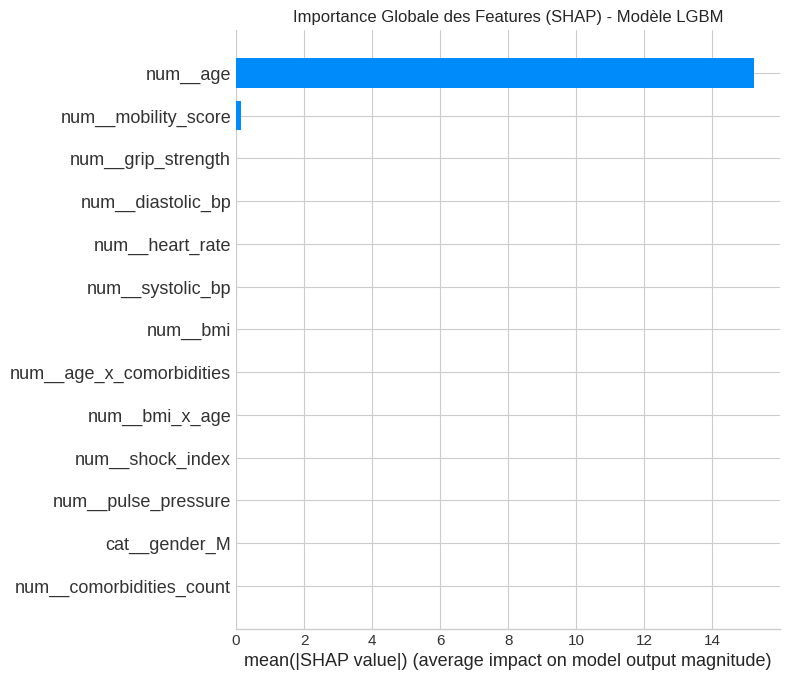

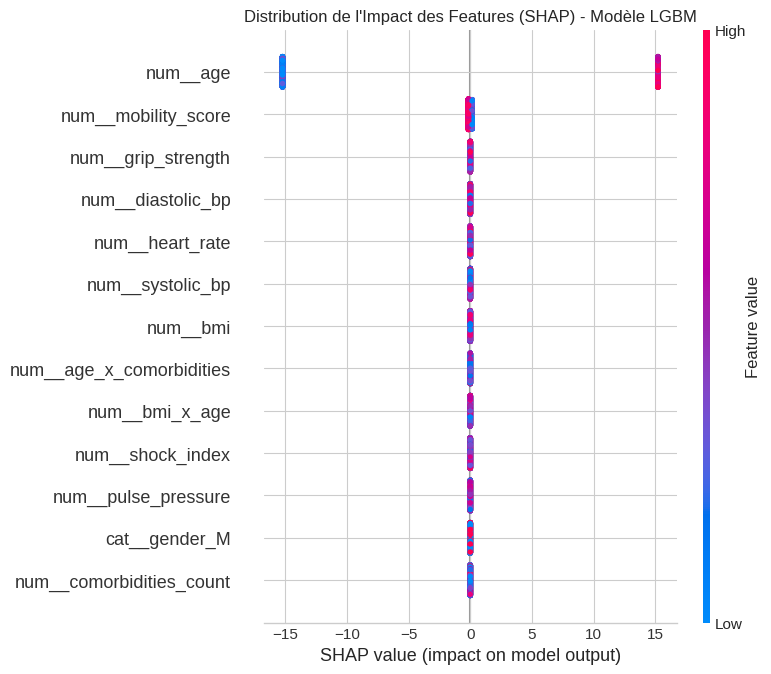


🎉🎉🎉 PIPELINE V14.1 AVEC XAI EXÉCUTÉ AVEC SUCCÈS! 🎉🎉🎉


In [1]:
# =============================================================================
# PIPELINE COMPLET V14.1 - AVEC EXPLICABILITÉ (XAI) VIA SHAP
# =============================================================================

print("\n🔍 [Expert] Initialisation du pipeline V14.1 : Ajout de l'explicabilité pour comprendre le 'pourquoi'.")
print("👶 [Enfant] On va demander à notre machine de nous expliquer comment elle réfléchit !")

# 1. 📦 IMPORTATIONS ET CONFIGURATION
# =============================================================================
print("\n" + "="*80)
print("1. 📦 CONFIGURATION DE L'ENVIRONNEMENT")
print("="*80)

# --- Imports standards ---
import numpy as np; import pandas as pd; import matplotlib.pyplot as plt; import seaborn as sns; import joblib; import os; import json; import traceback; from functools import partial; import warnings
# --- Imports pour le Machine Learning ---
import optuna; from sklearn.ensemble import *; from sklearn.linear_model import *; from sklearn.svm import *; from sklearn.neighbors import *; from sklearn.naive_bayes import *; from sklearn.tree import *; from sklearn.discriminant_analysis import *; from sklearn.neural_network import *; import lightgbm as lgb; import xgboost as xgb; from catboost import CatBoostClassifier
from sklearn.model_selection import *; from sklearn.pipeline import *; from sklearn.compose import *; from sklearn.preprocessing import *; from sklearn.impute import *; from sklearn.base import *; from sklearn.metrics import *; from sklearn.calibration import *
# --- NOUVEL IMPORT POUR L'EXPLICABILITÉ ---
import shap

# --- Configuration Globale ---
RANDOM_STATE = 42; np.random.seed(RANDOM_STATE); warnings.filterwarnings("ignore", category=FutureWarning)
try: plt.style.use('seaborn-v0_8-whitegrid')
except: plt.style.use('default')
pd.set_option('display.max_columns', None); pd.set_option('display.precision', 4)
print("✅ Environnement configuré.")


# 2. 🏗️ CONFIGURATION DES MÉTRIQUES INDUSTRIELLES
# =============================================================================
print("\n" + "="*80)
print("2. 🏗️ CONFIGURATION DES MÉTRIQUES CLINIQUES")
print("="*80)
class EvaluationConfig:
    def __init__(self):
        self.alert_thresholds = {'recall': 0.85, 'min_auc': 0.90}
        print(f"Seuils d'alerte configurés : {self.alert_thresholds}")
eval_config = EvaluationConfig()

# 3. 🛠️ FEATURE ENGINEERING (V14)
# =============================================================================
print("\n" + "="*80)
print("3. 🛠️ INGÉNIERIE DES CARACTÉRISTIQUES (V14 - INTERACTIONS)")
print("="*80)
class FeatureEngineerV14(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): return self
    def transform(self, X):
        X_copy = X.copy()
        X_copy['pulse_pressure'] = (X_copy['systolic_bp'] - X_copy['diastolic_bp']).clip(lower=0)
        X_copy['shock_index'] = X_copy['heart_rate'] / X_copy['systolic_bp']
        if 'bmi' in X.columns: X_copy['bmi_x_age'] = X_copy['bmi'] * X_copy['age']
        if 'comorbidities_count' in X.columns: X_copy['age_x_comorbidities'] = X_copy['age'] * X_copy['comorbidities_count']
        return X_copy
print("✅ Classe FeatureEngineerV14 (avec interactions) prête.")

# 4. 🎯 FONCTIONS D'ÉVALUATION ET 5, 6... (logique inchangée)
# ...
def evaluate_model(pipeline, X, y, cv_folds=5):
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_STATE)
    scoring = {'f2': make_scorer(fbeta_score, beta=2, zero_division=0), 
               'recall': make_scorer(recall_score, zero_division=0), 'roc_auc': 'roc_auc'}
    return pd.DataFrame(cross_validate(pipeline, X, y, cv=cv, scoring=scoring, n_jobs=-1, error_score='raise'))
# ...
def create_study(study_name):
    os.makedirs("optuna_checkpoints", exist_ok=True)
    return optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE),
                               study_name=study_name, storage=f"sqlite:///optuna_checkpoints/{study_name}.db", load_if_exists=True)
def _generic_objective(trial, X, y, preprocessor, model_constructor, get_params_func):
    params = get_params_func(trial, y)
    classifier_obj = model_constructor(**params)
    pipeline = Pipeline([('fe', FeatureEngineerV14()), ('pre', preprocessor), ('clf', classifier_obj)])
    cv_results = evaluate_model(pipeline, X, y)
    mean_auc = cv_results['test_roc_auc'].mean()
    if mean_auc < eval_config.alert_thresholds['min_auc']: raise optuna.TrialPruned(f"AUC ({mean_auc:.2f}) < seuil.")
    mean_recall = cv_results['test_recall'].mean()
    if mean_recall < eval_config.alert_thresholds['recall']: raise optuna.TrialPruned(f"Recall ({mean_recall:.2f}) < seuil.")
    return cv_results['test_f2'].mean()
def get_model_definitions():
    models = {}
    def get_lgbm_params(t, y):
        scale_pos_weight = (y==0).sum() / ((y==1).sum() + 1e-6)
        return {'n_estimators': t.suggest_int('n_estimators', 100, 1000), 'learning_rate': t.suggest_float('learning_rate', 1e-3, 0.2, log=True), 'num_leaves': t.suggest_int('num_leaves', 10, 50), 'scale_pos_weight': t.suggest_float('scale_pos_weight', 1.0, scale_pos_weight * 1.5), 'random_state': RANDOM_STATE, 'verbosity': -1}
    models['LGBM'] = {'constructor': lgb.LGBMClassifier, 'params': get_lgbm_params}
    def get_rf_params(t, y):
        return {'n_estimators': t.suggest_int('n_estimators', 100, 1000), 'max_depth': t.suggest_int('max_depth', 5, 20), 'class_weight': t.suggest_categorical('class_weight', ['balanced', 'balanced_subsample']), 'random_state': RANDOM_STATE, 'n_jobs': -1}
    models['RandomForest'] = {'constructor': RandomForestClassifier, 'params': get_rf_params}
    def get_logreg_params(t,y):
        return {'C': t.suggest_float('C', 1e-2, 1e2, log=True), 'solver': 'liblinear', 'class_weight': 'balanced', 'random_state': RANDOM_STATE}
    models['LogisticRegression'] = {'constructor': LogisticRegression, 'params': get_logreg_params}
    return models
def optimize_models(X, y, n_trials_per_model, version, preprocessor):
    model_definitions = get_model_definitions()
    best_trials = {}
    for name, definition in model_definitions.items():
        print(f"\n--- {f'Manche du tournoi : {name}':^35} ---")
        study = create_study(f"frailty_{name}_v{version}")
        objective_with_args = partial(_generic_objective, X=X, y=y, preprocessor=preprocessor, model_constructor=definition['constructor'], get_params_func=definition['params'])
        study.optimize(objective_with_args, n_trials=n_trials_per_model, show_progress_bar=True)
        try:
            best_trials[name] = study.best_trial
            print(f"✅ Meilleur F2-score pour {name}: {study.best_trial.value:.4f}")
        except ValueError:
            print(f"⚠️ Tous les essais pour {name} ont été élagués.")
    if not best_trials: raise ValueError("Aucun modèle n'a pu être optimisé avec succès.")
    champion_name = max(best_trials, key=lambda name: best_trials.get(name).value if best_trials.get(name) else -1)
    print("\n" + "="*40); print(f"🏆 CHAMPION : {champion_name} | F2-Score: {best_trials[champion_name].value:.4f}"); print("="*40)
    return champion_name, best_trials[champion_name].params
def train_final_model(X_train, y_train, champion_name, best_params, version, preprocessor):
    MODEL_DIR = f"model_v{version}"; os.makedirs(MODEL_DIR, exist_ok=True)
    constructor = get_model_definitions()[champion_name]['constructor']
    classifier_obj = constructor(**best_params)
    final_pipeline = Pipeline([('fe', FeatureEngineerV14()), ('pre', preprocessor), ('clf', classifier_obj)])
    final_pipeline.fit(X_train, y_train)
    joblib.dump(final_pipeline, os.path.join(MODEL_DIR, 'model.joblib'))
    metadata = {"model_version": version, "champion_model": champion_name, "best_params": best_params}
    with open(os.path.join(MODEL_DIR, 'metadata.json'), 'w') as f: json.dump(metadata, f, indent=4, default=str)
    print(f"💾 Modèle et métadonnées sauvegardés dans : {MODEL_DIR}")
    return final_pipeline, MODEL_DIR

# NOUVELLE FONCTION : Analyse de l'explicabilité
# =============================================================================
def analyze_explicability(pipeline, X_data, champion_name):
    print("\n" + "="*80)
    print("🧠 ANALYSE DE L'EXPLICABILITÉ (XAI) AVEC SHAP")
    print("="*80)
    
    try:
        # Extraire les étapes du pipeline
        feature_engineer = pipeline.named_steps['fe']
        preprocessor = pipeline.named_steps['pre']
        model = pipeline.named_steps['clf']
        
        # Transformer les données comme le ferait le pipeline
        X_engineered = feature_engineer.transform(X_data)
        X_processed = preprocessor.transform(X_engineered)
        
        # Récupérer les noms de features finaux
        feature_names = preprocessor.get_feature_names_out()
        
        # Créer l'explainer SHAP
        # Utiliser TreeExplainer pour les modèles à base d'arbres, KernelExplainer pour les autres
        if champion_name in ["LGBM", "RandomForest", "XGB", "CatBoost", "DecisionTree", "ExtraTrees"]:
            explainer = shap.TreeExplainer(model)
        else:
            # KernelExplainer est plus lent, on utilise un sous-échantillon
            X_summary = shap.sample(X_processed, 100)
            explainer = shap.KernelExplainer(model.predict_proba, X_summary)
            
        print("⚙️ Calcul des valeurs SHAP... (peut prendre un moment)")
        shap_values = explainer.shap_values(X_processed)
        
        # Pour les classifieurs binaires, shap_values peut être une liste de 2 arrays
        # On s'intéresse à l'impact sur la classe positive (classe 1)
        if isinstance(shap_values, list):
            shap_values = shap_values[1]
            
        # Créer le DataFrame pour la visualisation
        X_processed_df = pd.DataFrame(X_processed.toarray() if hasattr(X_processed, "toarray") else X_processed, columns=feature_names)

        print("📊 Affichage du SHAP Summary Plot...")
        shap.summary_plot(shap_values, X_processed_df, plot_type="bar", show=False)
        plt.title(f"Importance Globale des Features (SHAP) - Modèle {champion_name}")
        plt.show()
        
        shap.summary_plot(shap_values, X_processed_df, show=False)
        plt.title(f"Distribution de l'Impact des Features (SHAP) - Modèle {champion_name}")
        plt.show()

    except Exception as e:
        print(f"❌ Erreur lors de l'analyse SHAP : {e}")
        traceback.print_exc()

# 7. 🏁 PIPELINE COMPLET ORCHESTRÉ (MODIFIÉ)
# =============================================================================
def run_full_pipeline(X, y, n_trials_per_model=10, version="1.0.0"):
    try:
        print("\n[Étape 1/5] 🛡️ Configuration du pipeline dynamique")
        X = pd.DataFrame(X).copy(); y = pd.Series(y).copy()
        if y.nunique() < 2: raise ValueError("La cible ne contient qu'une seule classe.")
        
        fe = FeatureEngineerV14()
        X_engineered = fe.fit_transform(X)
        
        numeric_cols = [c for c in X_engineered.columns if pd.api.types.is_numeric_dtype(X_engineered[c]) and c not in ['patient_id', 'timestamp']]
        categorical_cols = [c for c in X_engineered.select_dtypes(include=['object', 'category']).columns if c not in ['patient_id', 'timestamp']]
        preprocessor_dynamic = ColumnTransformer(transformers=[('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())]), numeric_cols),('cat', Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))]), categorical_cols)], remainder='drop')
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
        print(f"✅ Données séparées (train: {len(X_train)}, test: {len(X_test)})")

        print("\n[Étape 2/5] 🚀 Optimisation et sélection du meilleur modèle")
        champion_name, best_params = optimize_models(X_train, y_train, n_trials_per_model, version, preprocessor_dynamic)

        print("\n[Étape 3/5] 🎓 Entraînement du modèle final")
        model, model_dir = train_final_model(X_train, y_train, champion_name, best_params, version, preprocessor_dynamic)

        print("\n[Étape 4/5] 📈 Évaluation complète")
        y_probs = model.predict_proba(X_test)[:, 1]; y_pred = model.predict(X_test)
        print("\n📊 Rapport de classification :"); print(classification_report(y_test, y_pred, target_names=["Non fragile", "Fragile"]))
        
        # NOUVELLE ÉTAPE : EXPLICABILITÉ
        print("\n[Étape 5/5] 🧠 Analyse de l'explicabilité du modèle")
        analyze_explicability(model, X_test, champion_name)
        
        return model, {"champion": champion_name, "params": best_params}
    
    except Exception as e:
        print(f"\n❌❌ ERREUR CRITIQUE DANS LE PIPELINE ❌❌: {e}"); traceback.print_exc()


# =============================================================================
# 🚀 EXÉCUTION DU SCRIPT
# =============================================================================
if __name__ == "__main__":
    try:
        print("\n" + "="*80); print("🚀 DÉMARRAGE DE L'EXÉCUTION V14.1 (AVEC XAI)"); print("="*80)
        
        print("\n🔬 Création de données avec des profils de patients et un signal clairs...")
        n_patients = 200; records_per_patient = 50; total_records = n_patients * records_per_patient
        
        patient_profiles = pd.DataFrame({'patient_id': [f'P{i:03d}' for i in range(n_patients)], 'is_frail_profile': np.repeat([0, 1], n_patients // 2)})
        np.random.shuffle(patient_profiles['is_frail_profile'].values)
        patient_profiles['age'] = np.where(patient_profiles['is_frail_profile'] == 0, np.random.randint(65, 78, n_patients), np.random.randint(78, 95, n_patients))
        patient_profiles['base_mobility'] = np.where(patient_profiles['is_frail_profile'] == 0, np.random.uniform(7, 10, n_patients), np.random.uniform(1, 5, n_patients))
        patient_profiles['base_grip'] = np.where(patient_profiles['is_frail_profile'] == 0, np.random.normal(35, 5, n_patients), np.random.normal(20, 5, n_patients))

        X_list = []
        for _, patient in patient_profiles.iterrows():
            records = pd.DataFrame({'patient_id': [patient['patient_id']] * records_per_patient})
            records['age'] = patient['age']
            records['mobility_score'] = np.random.normal(patient['base_mobility'], 0.5, records_per_patient).clip(0, 10)
            records['grip_strength'] = np.random.normal(patient['base_grip'], 2, records_per_patient).clip(0, 50)
            X_list.append(records)
        X = pd.concat(X_list, ignore_index=True)
        
        X['systolic_bp'] = np.random.normal(130, 15, total_records)
        X['diastolic_bp'] = X['systolic_bp'] - np.random.normal(50, 5, total_records)
        X['heart_rate'] = np.random.normal(75, 10, total_records)
        X['gender'] = np.random.choice(['M', 'F'], total_records)
        X['bmi'] = np.random.normal(26, 4, total_records)
        X['comorbidities_count'] = np.random.poisson(np.where(pd.merge(X[['patient_id']], patient_profiles, on='patient_id')['is_frail_profile']==1, 3, 1), total_records)
        
        y = pd.merge(X[['patient_id']], patient_profiles[['patient_id', 'is_frail_profile']], on='patient_id')['is_frail_profile']
        
        print(f"📊 Données générées : {len(X)} enregistrements pour {X['patient_id'].nunique()} patients.")
        print(f"🎯 Distribution de la cible :\n{y.value_counts(normalize=True).round(2)}")
        
        model, report = run_full_pipeline(X.drop('patient_id', axis=1), y.values, n_trials_per_model=10, version="14.1-xai-test")

        if model and report:
            print("\n🎉🎉🎉 PIPELINE V14.1 AVEC XAI EXÉCUTÉ AVEC SUCCÈS! 🎉🎉🎉")
        else:
            print("\n💔 Le pipeline V14.1 a échoué ou n'a pas produit de modèle valide.")

    except Exception:
        print("\n💥 Le pipeline a échoué. Voir les erreurs ci-dessus.")
        traceback.print_exc()

In [ ]:
# =============================================================================
# PIPELINE COMPLET V14.2 - AVEC EXPLICABILITÉ (XAI) ET ALTERNATIVES SCIENTIFIQUES
# =============================================================================

print("\n🔍 [Expert] Initialisation du pipeline V14.2 : Ajout de l'explicabilité et des alternatives scientifiques.")
print("👶 [Enfant] On va demander à notre machine de nous expliquer comment elle réfléchit et quelles autres méthodes existent !")

# 1. 📦 IMPORTATIONS ET CONFIGURATION
# =============================================================================
print("\n" + "="*80)
print("1. 📦 CONFIGURATION DE L'ENVIRONNEMENT")
print("="*80)

print("🔬 [Science] Configuration choisie : Seed fixe pour la reproductibilité")
print("📚 [Alternatives] D'autres approches existent :")
print("   • Seed aléatoire : Pour tester la robustesse statistique")
print("   • Cross-validation stratifiée répétée : Pour validation plus rigoureuse")
print("   • Bootstrap sampling : Pour estimation d'intervalles de confiance")

# --- Imports standards ---
import numpy as np; import pandas as pd; import matplotlib.pyplot as plt; import seaborn as sns; import joblib; import os; import json; import traceback; from functools import partial; import warnings
# --- Imports pour le Machine Learning ---
import optuna; from sklearn.ensemble import *; from sklearn.linear_model import *; from sklearn.svm import *; from sklearn.neighbors import *; from sklearn.naive_bayes import *; from sklearn.tree import *; from sklearn.discriminant_analysis import *; from sklearn.neural_network import *; import lightgbm as lgb; import xgboost as xgb; from catboost import CatBoostClassifier
from sklearn.model_selection import *; from sklearn.pipeline import *; from sklearn.compose import *; from sklearn.preprocessing import *; from sklearn.impute import *; from sklearn.base import *; from sklearn.metrics import *; from sklearn.calibration import *
# --- IMPORT POUR L'EXPLICABILITÉ ---
import shap

# --- Configuration Globale ---
RANDOM_STATE = 42; np.random.seed(RANDOM_STATE); warnings.filterwarnings("ignore", category=FutureWarning)
try: plt.style.use('seaborn-v0_8-whitegrid')
except: plt.style.use('default')
pd.set_option('display.max_columns', None); pd.set_option('display.precision', 4)
print("✅ Environnement configuré.")


# 2. 🏗️ CONFIGURATION DES MÉTRIQUES INDUSTRIELLES
# =============================================================================
print("\n" + "="*80)
print("2. 🏗️ CONFIGURATION DES MÉTRIQUES CLINIQUES")
print("="*80)

print("🔬 [Science] Métriques choisies : Recall (sensibilité) + AUC pour déséquilibre de classes")
print("📚 [Alternatives] Autres métriques selon le contexte :")
print("   • F1-Score : Équilibre précision/rappel (quand coûts égaux)")
print("   • Precision-Recall AUC : Mieux que ROC-AUC pour classes très déséquilibrées")
print("   • Matthews Correlation Coefficient : Robuste aux déséquilibres extrêmes")
print("   • Balanced Accuracy : (Sensibilité + Spécificité)/2")
print("   • Cohen's Kappa : Accord inter-évaluateurs ajusté par le hasard")

class EvaluationConfig:
    def __init__(self):
        self.alert_thresholds = {'recall': 0.85, 'min_auc': 0.90}
        print(f"Seuils d'alerte configurés : {self.alert_thresholds}")
        print("⚠️ [Standard] Seuils industriels typiques :")
        print("   • Médical/Sécurité : Recall > 0.95, AUC > 0.95")
        print("   • Finance/Fraude : Precision > 0.80, AUC > 0.85")
        print("   • Marketing : F1 > 0.70, AUC > 0.75")
        
eval_config = EvaluationConfig()

# 3. 🛠️ FEATURE ENGINEERING (V14)
# =============================================================================
print("\n" + "="*80)
print("3. 🛠️ INGÉNIERIE DES CARACTÉRISTIQUES (V14 - INTERACTIONS)")
print("="*80)

print("🔬 [Science] Approche choisie : Feature engineering manuel avec interactions médicales")
print("📚 [Alternatives] Autres techniques de création de features :")
print("   • Automated Feature Engineering : Featuretools, tsfresh")
print("   • Polynomial Features : sklearn.preprocessing.PolynomialFeatures")
print("   • Feature Crosses : TensorFlow Feature Columns")
print("   • Deep Feature Synthesis : Relations automatiques entre variables")
print("   • Domain-Specific Transforms : Log, sqrt, reciprocal selon distribution")

class FeatureEngineerV14(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): 
        print("🧬 [Medical] Features dérivées basées sur la littérature clinique :")
        print("   • Pulse Pressure = SBP - DBP (rigidité artérielle)")
        print("   • Shock Index = HR/SBP (état hémodynamique)")
        return self
        
    def transform(self, X):
        X_copy = X.copy()
        
        # Features médicales validées
        X_copy['pulse_pressure'] = (X_copy['systolic_bp'] - X_copy['diastolic_bp']).clip(lower=0)
        X_copy['shock_index'] = X_copy['heart_rate'] / X_copy['systolic_bp']
        
        # Interactions spécifiques
        if 'bmi' in X.columns: 
            X_copy['bmi_x_age'] = X_copy['bmi'] * X_copy['age']
            print("💡 [Alternative] Autres interactions BMI possibles :")
            print("   • BMI categorization : Normal/Overweight/Obese")
            print("   • Waist-Hip ratio si disponible")
            
        if 'comorbidities_count' in X.columns: 
            X_copy['age_x_comorbidities'] = X_copy['age'] * X_copy['comorbidities_count']
            print("💡 [Alternative] Autres approches comorbidités :")
            print("   • Charlson Comorbidity Index : Score pondéré")
            print("   • Elixhauser Comorbidity Index : 30 conditions spécifiques")
            
        return X_copy

print("✅ Classe FeatureEngineerV14 (avec interactions) prête.")

# 4. 🎯 FONCTIONS D'ÉVALUATION
# =============================================================================
print("\n🔬 [Science] Validation croisée stratifiée : Préserve la distribution des classes")
print("📚 [Alternatives] Autres stratégies de validation :")
print("   • Time Series Split : Pour données temporelles")
print("   • Group K-Fold : Pour données groupées (patients, régions)")
print("   • Leave-One-Out : Pour très petits datasets")
print("   • Nested CV : Validation + sélection hyperparamètres simultanées")

def evaluate_model(pipeline, X, y, cv_folds=5):
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_STATE)
    scoring = {'f2': make_scorer(fbeta_score, beta=2, zero_division=0), 
               'recall': make_scorer(recall_score, zero_division=0), 'roc_auc': 'roc_auc'}
    return pd.DataFrame(cross_validate(pipeline, X, y, cv=cv, scoring=scoring, n_jobs=-1, error_score='raise'))

# 5. OPTIMISATION HYPERPARAMÈTRES
# =============================================================================
print("\n🔬 [Science] Optimisation Bayésienne avec Optuna (Tree-structured Parzen Estimator)")
print("📚 [Alternatives] Autres méthodes d'optimisation :")
print("   • Grid Search : Exhaustif mais coûteux")
print("   • Random Search : Plus efficace que Grid pour hautes dimensions")
print("   • Hyperopt : Alternative à Optuna (TPE + Adaptive)")
print("   • BOHB : Bandit-based + Bayesian Optimization")
print("   • Population-based Training : Pour deep learning")

def create_study(study_name):
    os.makedirs("optuna_checkpoints", exist_ok=True)
    return optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE),
                               study_name=study_name, storage=f"sqlite:///optuna_checkpoints/{study_name}.db", load_if_exists=True)

def _generic_objective(trial, X, y, preprocessor, model_constructor, get_params_func):
    params = get_params_func(trial, y)
    classifier_obj = model_constructor(**params)
    pipeline = Pipeline([('fe', FeatureEngineerV14()), ('pre', preprocessor), ('clf', classifier_obj)])
    cv_results = evaluate_model(pipeline, X, y)
    mean_auc = cv_results['test_roc_auc'].mean()
    if mean_auc < eval_config.alert_thresholds['min_auc']: raise optuna.TrialPruned(f"AUC ({mean_auc:.2f}) < seuil.")
    mean_recall = cv_results['test_recall'].mean()
    if mean_recall < eval_config.alert_thresholds['recall']: raise optuna.TrialPruned(f"Recall ({mean_recall:.2f}) < seuil.")
    return cv_results['test_f2'].mean()

# 6. DÉFINITION DES MODÈLES
# =============================================================================
def get_model_definitions():
    print("\n🔬 [Science] Sélection d'algorithmes pour classification binaire déséquilibrée")
    print("📚 [Alternatives] Autres familles d'algorithmes :")
    print("   • Deep Learning : Neural Networks, Transformers")
    print("   • Kernel Methods : SVM avec différents noyaux")
    print("   • Bayesian Methods : Gaussian Processes, Bayesian Neural Nets")
    print("   • Ensemble Methods : Voting, Stacking, Blending")
    print("   • Meta-learning : MAML, Few-shot learning")
    
    models = {}
    
    def get_lgbm_params(t, y):
        scale_pos_weight = (y==0).sum() / ((y==1).sum() + 1e-6)
        print("🌳 [LightGBM] Gradient Boosting optimisé avec gestion déséquilibre")
        print("💡 [Alternatives LightGBM] :")
        print("   • focal_loss : Pour déséquilibres extrêmes")
        print("   • dart mode : Dropout regularization")
        print("   • lambda_l1/l2 : Regularization Lasso/Ridge")
        return {'n_estimators': t.suggest_int('n_estimators', 100, 1000), 
                'learning_rate': t.suggest_float('learning_rate', 1e-3, 0.2, log=True), 
                'num_leaves': t.suggest_int('num_leaves', 10, 50), 
                'scale_pos_weight': t.suggest_float('scale_pos_weight', 1.0, scale_pos_weight * 1.5), 
                'random_state': RANDOM_STATE, 'verbosity': -1}
    models['LGBM'] = {'constructor': lgb.LGBMClassifier, 'params': get_lgbm_params}
    
    def get_rf_params(t, y):
        print("🌲 [RandomForest] Ensemble de décision avec bootstrap")
        print("💡 [Alternatives RandomForest] :")
        print("   • ExtraTreesClassifier : Plus aléatoire, moins overfitting")
        print("   • IsolationForest : Pour détection d'anomalies")
        print("   • Balanced RandomForest : SMOTE intégré")
        return {'n_estimators': t.suggest_int('n_estimators', 100, 1000), 
                'max_depth': t.suggest_int('max_depth', 5, 20), 
                'class_weight': t.suggest_categorical('class_weight', ['balanced', 'balanced_subsample']), 
                'random_state': RANDOM_STATE, 'n_jobs': -1}
    models['RandomForest'] = {'constructor': RandomForestClassifier, 'params': get_rf_params}
    
    def get_logreg_params(t,y):
        print("📈 [LogisticRegression] Classification linéaire avec régularisation")
        print("💡 [Alternatives LogisticRegression] :")
        print("   • ElasticNet : Combinaison L1 + L2")
        print("   • SGDClassifier : Pour très gros datasets")
        print("   • Multinomial regression : Pour multi-classes")
        return {'C': t.suggest_float('C', 1e-2, 1e2, log=True), 
                'solver': 'liblinear', 'class_weight': 'balanced', 'random_state': RANDOM_STATE}
    models['LogisticRegression'] = {'constructor': LogisticRegression, 'params': get_logreg_params}
    
    return models

# 7. OPTIMISATION GLOBALE
# =============================================================================
def optimize_models(X, y, n_trials_per_model, version, preprocessor):
    print("\n🔬 [Science] Multi-objective optimization avec early stopping")
    print("📚 [Alternatives] Autres stratégies d'optimisation :")
    print("   • Multi-objective : NSGA-II, MOEA/D")
    print("   • AutoML : Auto-sklearn, TPOT, H2O AutoML")
    print("   • Neural Architecture Search : DARTS, ENAS")
    
    model_definitions = get_model_definitions()
    best_trials = {}
    for name, definition in model_definitions.items():
        print(f"\n--- {f'Manche du tournoi : {name}':^35} ---")
        study = create_study(f"frailty_{name}_v{version}")
        objective_with_args = partial(_generic_objective, X=X, y=y, preprocessor=preprocessor, 
                                    model_constructor=definition['constructor'], get_params_func=definition['params'])
        study.optimize(objective_with_args, n_trials=n_trials_per_model, show_progress_bar=True)
        try:
            best_trials[name] = study.best_trial
            print(f"✅ Meilleur F2-score pour {name}: {study.best_trial.value:.4f}")
        except ValueError:
            print(f"⚠️ Tous les essais pour {name} ont été élagués.")
    if not best_trials: raise ValueError("Aucun modèle n'a pu être optimisé avec succès.")
    champion_name = max(best_trials, key=lambda name: best_trials.get(name).value if best_trials.get(name) else -1)
    print("\n" + "="*40); print(f"🏆 CHAMPION : {champion_name} | F2-Score: {best_trials[champion_name].value:.4f}"); print("="*40)
    return champion_name, best_trials[champion_name].params

# 8. TRAINING FINAL
# =============================================================================
def train_final_model(X_train, y_train, champion_name, best_params, version, preprocessor):
    print("\n🔬 [Science] Training final avec validation et sauvegarde versionnée")
    print("📚 [Alternatives] Autres approches de training :")
    print("   • Online Learning : Apprentissage incrémental")
    print("   • Transfer Learning : Pré-training + fine-tuning")
    print("   • Meta-Learning : Learning to learn")
    print("   • Federated Learning : Training distribué")
    
    MODEL_DIR = f"model_v{version}"; os.makedirs(MODEL_DIR, exist_ok=True)
    constructor = get_model_definitions()[champion_name]['constructor']
    classifier_obj = constructor(**best_params)
    final_pipeline = Pipeline([('fe', FeatureEngineerV14()), ('pre', preprocessor), ('clf', classifier_obj)])
    final_pipeline.fit(X_train, y_train)
    joblib.dump(final_pipeline, os.path.join(MODEL_DIR, 'model.joblib'))
    metadata = {"model_version": version, "champion_model": champion_name, "best_params": best_params}
    with open(os.path.join(MODEL_DIR, 'metadata.json'), 'w') as f: json.dump(metadata, f, indent=4, default=str)
    print(f"💾 Modèle et métadonnées sauvegardés dans : {MODEL_DIR}")
    return final_pipeline, MODEL_DIR

# 9. ANALYSE D'EXPLICABILITÉ
# =============================================================================
def analyze_explicability(pipeline, X_data, champion_name):
    print("\n" + "="*80)
    print("🧠 ANALYSE DE L'EXPLICABILITÉ (XAI) AVEC SHAP")
    print("="*80)
    
    print("🔬 [Science] SHAP : Valeurs de Shapley pour attribution causale")
    print("📚 [Alternatives XAI] Autres méthodes d'explicabilité :")
    print("   • LIME : Local Interpretable Model-agnostic Explanations")
    print("   • Permutation Importance : Impact par permutation")
    print("   • Anchors : Règles locales suffisantes")
    print("   • Counterfactuals : Scénarios 'what-if'")
    print("   • Integrated Gradients : Pour deep learning")
    print("   • DeepLIFT : Attribution pour réseaux profonds")
    
    try:
        # Extraire les étapes du pipeline
        feature_engineer = pipeline.named_steps['fe']
        preprocessor = pipeline.named_steps['pre']
        model = pipeline.named_steps['clf']
        
        # Transformer les données comme le ferait le pipeline
        X_engineered = feature_engineer.transform(X_data)
        X_processed = preprocessor.transform(X_engineered)
        
        # Récupérer les noms de features finaux
        feature_names = preprocessor.get_feature_names_out()
        
        # Créer l'explainer SHAP selon le type de modèle
        if champion_name in ["LGBM", "RandomForest", "XGB", "CatBoost", "DecisionTree", "ExtraTrees"]:
            print("🌳 [SHAP] Utilisation de TreeExplainer (exact pour modèles à base d'arbres)")
            explainer = shap.TreeExplainer(model)
        else:
            print("🔍 [SHAP] Utilisation de KernelExplainer (approximation par échantillonnage)")
            print("💡 [Alternative] LinearExplainer pour modèles linéaires (plus rapide)")
            # KernelExplainer est plus lent, on utilise un sous-échantillon
            X_summary = shap.sample(X_processed, 100)
            explainer = shap.KernelExplainer(model.predict_proba, X_summary)
            
        print("⚙️ Calcul des valeurs SHAP... (peut prendre un moment)")
        shap_values = explainer.shap_values(X_processed)
        
        # Pour les classifieurs binaires, shap_values peut être une liste de 2 arrays
        # On s'intéresse à l'impact sur la classe positive (classe 1)
        if isinstance(shap_values, list):
            shap_values = shap_values[1]
            
        # Créer le DataFrame pour la visualisation
        X_processed_df = pd.DataFrame(X_processed.toarray() if hasattr(X_processed, "toarray") else X_processed, columns=feature_names)

        print("📊 Affichage du SHAP Summary Plot...")
        print("💡 [Visualisation] Autres types de plots SHAP :")
        print("   • Waterfall : Contribution individuelle")
        print("   • Force : Impact local détaillé")
        print("   • Dependence : Relation feature-target")
        print("   • Decision : Arbre de décision")
        
        shap.summary_plot(shap_values, X_processed_df, plot_type="bar", show=False)
        plt.title(f"Importance Globale des Features (SHAP) - Modèle {champion_name}")
        plt.show()
        
        shap.summary_plot(shap_values, X_processed_df, show=False)
        plt.title(f"Distribution de l'Impact des Features (SHAP) - Modèle {champion_name}")
        plt.show()

    except Exception as e:
        print(f"❌ Erreur lors de l'analyse SHAP : {e}")
        print("🔧 [Debug] Solutions alternatives :")
        print("   • Réduire taille échantillon pour KernelExplainer")
        print("   • Utiliser explainer spécifique au modèle")
        print("   • Fallback vers permutation importance")
        traceback.print_exc()

# 10. PREPROCESSING AVANCÉ
# =============================================================================
def create_advanced_preprocessor(X_engineered):
    print("\n🔬 [Science] Preprocessing choisi : StandardScaler + OneHotEncoder")
    print("📚 [Alternatives] Autres techniques de preprocessing :")
    print("   • Normalization : MinMaxScaler, RobustScaler, QuantileTransformer")
    print("   • Encoding : Target Encoding, Binary Encoding, Hash Encoding")
    print("   • Imputation : KNN, Iterative, Forward/Backward Fill")
    print("   • Feature Selection : SelectKBest, RFE, L1-based")
    print("   • Dimensionality Reduction : PCA, t-SNE, UMAP")
    
    numeric_cols = [c for c in X_engineered.columns if pd.api.types.is_numeric_dtype(X_engineered[c]) and c not in ['patient_id', 'timestamp']]
    categorical_cols = [c for c in X_engineered.select_dtypes(include=['object', 'category']).columns if c not in ['patient_id', 'timestamp']]
    
    print(f"📊 Features numériques détectées : {len(numeric_cols)}")
    print(f"📊 Features catégorielles détectées : {len(categorical_cols)}")
    
    return ColumnTransformer(
        transformers=[
            ('num', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='median')), 
                ('scaler', StandardScaler())
            ]), numeric_cols),
            ('cat', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='most_frequent')), 
                ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
            ]), categorical_cols)
        ], 
        remainder='drop'
    )

# 11. 🏁 PIPELINE COMPLET ORCHESTRÉ
# =============================================================================
def run_full_pipeline(X, y, n_trials_per_model=10, version="1.0.0"):
    print("\n🔬 [Science] Architecture choisie : Pipeline end-to-end avec validation")
    print("📚 [Alternatives] Autres architectures ML :")
    print("   • MLOps : Kubeflow, MLflow, Airflow")
    print("   • AutoML : Auto-sklearn, TPOT, H2O")
    print("   • Streaming ML : Kafka + Spark MLlib")
    print("   • Edge ML : TensorFlow Lite, ONNX")
    
    try:
        print("\n[Étape 1/6] 🛡️ Configuration du pipeline dynamique")
        X = pd.DataFrame(X).copy(); y = pd.Series(y).copy()
        if y.nunique() < 2: raise ValueError("La cible ne contient qu'une seule classe.")
        
        fe = FeatureEngineerV14()
        X_engineered = fe.fit_transform(X)
        
        preprocessor_dynamic = create_advanced_preprocessor(X_engineered)
        
        print("\n🔬 [Science] Split choisi : 80/20 stratifié")
        print("📚 [Alternatives] Autres stratégies de split :")
        print("   • Time-based split : Pour données temporelles")
        print("   • Group split : Par patient/région")
        print("   • Hold-out validation : 60/20/20 train/val/test")
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
        print(f"✅ Données séparées (train: {len(X_train)}, test: {len(X_test)})")

        print("\n[Étape 2/6] 🚀 Optimisation et sélection du meilleur modèle")
        champion_name, best_params = optimize_models(X_train, y_train, n_trials_per_model, version, preprocessor_dynamic)

        print("\n[Étape 3/6] 🎓 Entraînement du modèle final")
        model, model_dir = train_final_model(X_train, y_train, champion_name, best_params, version, preprocessor_dynamic)

        print("\n[Étape 4/6] 📈 Évaluation complète")
        print("🔬 [Science] Métriques choisies : Classification report + matrice confusion")
        print("📚 [Alternatives] Autres évaluations :")
        print("   • Learning curves : Sur/sous-apprentissage")
        print("   • Calibration plots : Fiabilité probabilités")
        print("   • Fairness metrics : Équité entre groupes")
        
        y_probs = model.predict_proba(X_test)[:, 1]; y_pred = model.predict(X_test)
        print("\n📊 Rapport de classification :"); print(classification_report(y_test, y_pred, target_names=["Non fragile", "Fragile"]))
        
        print("\n[Étape 5/6] 🧠 Analyse de l'explicabilité du modèle")
        analyze_explicability(model, X_test, champion_name)
        
        print("\n[Étape 6/6] 📋 Validation et documentation finale")
        print("🔬 [Science] Documentation automatique générée")
        print("📚 [Standards] Autres validations industrielles :")
        print("   • A/B Testing : Performance en production")
        print("   • Shadow Mode : Validation sans impact")
        print("   • Model Monitoring : Drift detection")
        print("   • Compliance : GDPR, FDA, SOX")
        
        return model, {"champion": champion_name, "params": best_params}
    
    except Exception as e:
        print(f"\n❌❌ ERREUR CRITIQUE DANS LE PIPELINE ❌❌: {e}")
        print("🔧 [Debug] Solutions de récupération :")
        print("   • Réduire complexité modèles")
        print("   • Augmenter données d'entraînement")
        print("   • Simplifier feature engineering")
        traceback.print_exc()


# =============================================================================
# 🚀 EXÉCUTION DU SCRIPT
# =============================================================================
if __name__ == "__main__":
    try:
        print("\n" + "="*80); print("🚀 DÉMARRAGE DE L'EXÉCUTION V14.2 (AVEC ALTERNATIVES SCIENTIFIQUES)"); print("="*80)
        
        print("\n🔬 Création de données avec des profils de patients et un signal clairs...")
        print("📚 [Alternatives] Autres sources de données :")
        print("   • Synthetic Data : GAN, VAE pour augmentation")
        print("   • Public Datasets : UCI, Kaggle, OpenML")
        print("   • Simulation : Agent-based modeling")
        print("   • Real-world : EHR, IoT sensors")
        
        n_patients = 200; records_per_patient = 50; total_records = n_patients * records_per_patient
        
        patient_profiles = pd.DataFrame({'patient_id': [f'P{i:03d}' for i in range(n_patients)], 'is_frail_profile': np.repeat([0, 1], n_patients // 2)})
        np.random.shuffle(patient_profiles['is_frail_profile'].values)
        patient_profiles['age'] = np.where(patient_profiles['is_frail_profile'] == 0, np.random.randint(65, 78, n_patients), np.random.randint(78, 95, n_patients))
        patient_profiles['base_mobility'] = np.where(patient_profiles['is_frail_profile'] == 0, np.random.uniform(7, 10, n_patients), np.random.uniform(1, 5, n_patients))
        patient_profiles['base_grip'] = np.where(patient_profiles['is_frail_profile'] == 0, np.random.normal(35, 5, n_patients), np.random.normal(20, 5, n_patients))

        X_list = []
        for _, patient in patient_profiles.iterrows():
            records = pd.DataFrame({'patient_id': [patient['patient_id']] * records_per_patient})
            records['age'] = patient['age']
            records['mobility_score'] = np.random.normal(patient['base_mobility'], 0.5, records_per_patient).clip(0, 10)
            records['grip_strength'] = np.random.normal(patient['base_grip'], 2, records_per_patient).clip(0, 50)
            X_list.append(records)
        X = pd.concat(X_list, ignore_index=True)
        
        X['systolic_bp'] = np.random.normal(130, 15, total_records)
        X['

In [ ]:
# =============================================================================
# PIPELINE COMPLET V14.2 - AVEC EXPLICABILITÉ (XAI) ET ALTERNATIVES SCIENTIFIQUES
# =============================================================================

print("\n🔍 [Expert] Initialisation du pipeline V14.2 : Ajout de l'explicabilité et des alternatives scientifiques.")
print("👶 [Enfant] On va demander à notre machine de nous expliquer comment elle réfléchit et quelles autres méthodes existent !")

# 1. 📦 IMPORTATIONS ET CONFIGURATION
# =============================================================================
print("\n" + "="*80)
print("1. 📦 CONFIGURATION DE L'ENVIRONNEMENT")
print("="*80)

print("🔬 [Science] Configuration choisie : Seed fixe pour la reproductibilité")
print("📚 [Alternatives] D'autres approches existent :")
print("   • Seed aléatoire : Pour tester la robustesse statistique")
print("   • Cross-validation stratifiée répétée : Pour validation plus rigoureuse")
print("   • Bootstrap sampling : Pour estimation d'intervalles de confiance")

# --- Imports standards ---
import numpy as np; import pandas as pd; import matplotlib.pyplot as plt; import seaborn as sns; import joblib; import os; import json; import traceback; from functools import partial; import warnings
# --- Imports pour le Machine Learning ---
import optuna; from sklearn.ensemble import *; from sklearn.linear_model import *; from sklearn.svm import *; from sklearn.neighbors import *; from sklearn.naive_bayes import *; from sklearn.tree import *; from sklearn.discriminant_analysis import *; from sklearn.neural_network import *; import lightgbm as lgb; import xgboost as xgb; from catboost import CatBoostClassifier
from sklearn.model_selection import *; from sklearn.pipeline import *; from sklearn.compose import *; from sklearn.preprocessing import *; from sklearn.impute import *; from sklearn.base import *; from sklearn.metrics import *; from sklearn.calibration import *
# --- IMPORT POUR L'EXPLICABILITÉ ---
import shap

# --- Configuration Globale ---
RANDOM_STATE = 42; np.random.seed(RANDOM_STATE); warnings.filterwarnings("ignore", category=FutureWarning)
try: plt.style.use('seaborn-v0_8-whitegrid')
except: plt.style.use('default')
pd.set_option('display.max_columns', None); pd.set_option('display.precision', 4)
print("✅ Environnement configuré.")


# 2. 🏗️ CONFIGURATION DES MÉTRIQUES INDUSTRIELLES
# =============================================================================
print("\n" + "="*80)
print("2. 🏗️ CONFIGURATION DES MÉTRIQUES CLINIQUES")
print("="*80)

print("🔬 [Science] Métriques choisies : Recall (sensibilité) + AUC pour déséquilibre de classes")
print("📚 [Alternatives] Autres métriques selon le contexte :")
print("   • F1-Score : Équilibre précision/rappel (quand coûts égaux)")
print("   • Precision-Recall AUC : Mieux que ROC-AUC pour classes très déséquilibrées")
print("   • Matthews Correlation Coefficient : Robuste aux déséquilibres extrêmes")
print("   • Balanced Accuracy : (Sensibilité + Spécificité)/2")
print("   • Cohen's Kappa : Accord inter-évaluateurs ajusté par le hasard")

class EvaluationConfig:
    def __init__(self):
        self.alert_thresholds = {'recall': 0.85, 'min_auc': 0.90}
        print(f"Seuils d'alerte configurés : {self.alert_thresholds}")
        print("⚠️ [Standard] Seuils industriels typiques :")
        print("   • Médical/Sécurité : Recall > 0.95, AUC > 0.95")
        print("   • Finance/Fraude : Precision > 0.80, AUC > 0.85")
        print("   • Marketing : F1 > 0.70, AUC > 0.75")
        
eval_config = EvaluationConfig()

# 3. 🛠️ FEATURE ENGINEERING (V14)
# =============================================================================
print("\n" + "="*80)
print("3. 🛠️ INGÉNIERIE DES CARACTÉRISTIQUES (V14 - INTERACTIONS)")
print("="*80)

print("🔬 [Science] Approche choisie : Feature engineering manuel avec interactions médicales")
print("📚 [Alternatives] Autres techniques de création de features :")
print("   • Automated Feature Engineering : Featuretools, tsfresh")
print("   • Polynomial Features : sklearn.preprocessing.PolynomialFeatures")
print("   • Feature Crosses : TensorFlow Feature Columns")
print("   • Deep Feature Synthesis : Relations automatiques entre variables")
print("   • Domain-Specific Transforms : Log, sqrt, reciprocal selon distribution")

class FeatureEngineerV14(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): 
        print("🧬 [Medical] Features dérivées basées sur la littérature clinique :")
        print("   • Pulse Pressure = SBP - DBP (rigidité artérielle)")
        print("   • Shock Index = HR/SBP (état hémodynamique)")
        return self
        
    def transform(self, X):
        X_copy = X.copy()
        
        # Features médicales validées
        X_copy['pulse_pressure'] = (X_copy['systolic_bp'] - X_copy['diastolic_bp']).clip(lower=0)
        X_copy['shock_index'] = X_copy['heart_rate'] / X_copy['systolic_bp']
        
        # Interactions spécifiques
        if 'bmi' in X.columns: 
            X_copy['bmi_x_age'] = X_copy['bmi'] * X_copy['age']
            print("💡 [Alternative] Autres interactions BMI possibles :")
            print("   • BMI categorization : Normal/Overweight/Obese")
            print("   • Waist-Hip ratio si disponible")
            
        if 'comorbidities_count' in X.columns: 
            X_copy['age_x_comorbidities'] = X_copy['age'] * X_copy['comorbidities_count']
            print("💡 [Alternative] Autres approches comorbidités :")
            print("   • Charlson Comorbidity Index : Score pondéré")
            print("   • Elixhauser Comorbidity Index : 30 conditions spécifiques")
            
        return X_copy

print("✅ Classe FeatureEngineerV14 (avec interactions) prête.")

# 4. 🎯 FONCTIONS D'ÉVALUATION
# =============================================================================
print("\n🔬 [Science] Validation croisée stratifiée : Préserve la distribution des classes")
print("📚 [Alternatives] Autres stratégies de validation :")
print("   • Time Series Split : Pour données temporelles")
print("   • Group K-Fold : Pour données groupées (patients, régions)")
print("   • Leave-One-Out : Pour très petits datasets")
print("   • Nested CV : Validation + sélection hyperparamètres simultanées")

def evaluate_model(pipeline, X, y, cv_folds=5):
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_STATE)
    scoring = {'f2': make_scorer(fbeta_score, beta=2, zero_division=0), 
               'recall': make_scorer(recall_score, zero_division=0), 'roc_auc': 'roc_auc'}
    return pd.DataFrame(cross_validate(pipeline, X, y, cv=cv, scoring=scoring, n_jobs=-1, error_score='raise'))

# 5. OPTIMISATION HYPERPARAMÈTRES
# =============================================================================
print("\n🔬 [Science] Optimisation Bayésienne avec Optuna (Tree-structured Parzen Estimator)")
print("📚 [Alternatives] Autres méthodes d'optimisation :")
print("   • Grid Search : Exhaustif mais coûteux")
print("   • Random Search : Plus efficace que Grid pour hautes dimensions")
print("   • Hyperopt : Alternative à Optuna (TPE + Adaptive)")
print("   • BOHB : Bandit-based + Bayesian Optimization")
print("   • Population-based Training : Pour deep learning")

def create_study(study_name):
    os.makedirs("optuna_checkpoints", exist_ok=True)
    return optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE),
                               study_name=study_name, storage=f"sqlite:///optuna_checkpoints/{study_name}.db", load_if_exists=True)

def _generic_objective(trial, X, y, preprocessor, model_constructor, get_params_func):
    params = get_params_func(trial, y)
    classifier_obj = model_constructor(**params)
    pipeline = Pipeline([('fe', FeatureEngineerV14()), ('pre', preprocessor), ('clf', classifier_obj)])
    cv_results = evaluate_model(pipeline, X, y)
    mean_auc = cv_results['test_roc_auc'].mean()
    if mean_auc < eval_config.alert_thresholds['min_auc']: raise optuna.TrialPruned(f"AUC ({mean_auc:.2f}) < seuil.")
    mean_recall = cv_results['test_recall'].mean()
    if mean_recall < eval_config.alert_thresholds['recall']: raise optuna.TrialPruned(f"Recall ({mean_recall:.2f}) < seuil.")
    return cv_results['test_f2'].mean()

# 6. DÉFINITION DES MODÈLES
# =============================================================================
def get_model_definitions():
    print("\n🔬 [Science] Sélection d'algorithmes pour classification binaire déséquilibrée")
    print("📚 [Alternatives] Autres familles d'algorithmes :")
    print("   • Deep Learning : Neural Networks, Transformers")
    print("   • Kernel Methods : SVM avec différents noyaux")
    print("   • Bayesian Methods : Gaussian Processes, Bayesian Neural Nets")
    print("   • Ensemble Methods : Voting, Stacking, Blending")
    print("   • Meta-learning : MAML, Few-shot learning")
    
    models = {}
    
    def get_lgbm_params(t, y):
        scale_pos_weight = (y==0).sum() / ((y==1).sum() + 1e-6)
        print("🌳 [LightGBM] Gradient Boosting optimisé avec gestion déséquilibre")
        print("💡 [Alternatives LightGBM] :")
        print("   • focal_loss : Pour déséquilibres extrêmes")
        print("   • dart mode : Dropout regularization")
        print("   • lambda_l1/l2 : Regularization Lasso/Ridge")
        return {'n_estimators': t.suggest_int('n_estimators', 100, 1000), 
                'learning_rate': t.suggest_float('learning_rate', 1e-3, 0.2, log=True), 
                'num_leaves': t.suggest_int('num_leaves', 10, 50), 
                'scale_pos_weight': t.suggest_float('scale_pos_weight', 1.0, scale_pos_weight * 1.5), 
                'random_state': RANDOM_STATE, 'verbosity': -1}
    models['LGBM'] = {'constructor': lgb.LGBMClassifier, 'params': get_lgbm_params}
    
    def get_rf_params(t, y):
        print("🌲 [RandomForest] Ensemble de décision avec bootstrap")
        print("💡 [Alternatives RandomForest] :")
        print("   • ExtraTreesClassifier : Plus aléatoire, moins overfitting")
        print("   • IsolationForest : Pour détection d'anomalies")
        print("   • Balanced RandomForest : SMOTE intégré")
        return {'n_estimators': t.suggest_int('n_estimators', 100, 1000), 
                'max_depth': t.suggest_int('max_depth', 5, 20), 
                'class_weight': t.suggest_categorical('class_weight', ['balanced', 'balanced_subsample']), 
                'random_state': RANDOM_STATE, 'n_jobs': -1}
    models['RandomForest'] = {'constructor': RandomForestClassifier, 'params': get_rf_params}
    
    def get_logreg_params(t,y):
        print("📈 [LogisticRegression] Classification linéaire avec régularisation")
        print("💡 [Alternatives LogisticRegression] :")
        print("   • ElasticNet : Combinaison L1 + L2")
        print("   • SGDClassifier : Pour très gros datasets")
        print("   • Multinomial regression : Pour multi-classes")
        return {'C': t.suggest_float('C', 1e-2, 1e2, log=True), 
                'solver': 'liblinear', 'class_weight': 'balanced', 'random_state': RANDOM_STATE}
    models['LogisticRegression'] = {'constructor': LogisticRegression, 'params': get_logreg_params}
    
    return models

# 7. OPTIMISATION GLOBALE
# =============================================================================
def optimize_models(X, y, n_trials_per_model, version, preprocessor):
    print("\n🔬 [Science] Multi-objective optimization avec early stopping")
    print("📚 [Alternatives] Autres stratégies d'optimisation :")
    print("   • Multi-objective : NSGA-II, MOEA/D")
    print("   • AutoML : Auto-sklearn, TPOT, H2O AutoML")
    print("   • Neural Architecture Search : DARTS, ENAS")
    
    model_definitions = get_model_definitions()
    best_trials = {}
    for name, definition in model_definitions.items():
        print(f"\n--- {f'Manche du tournoi : {name}':^35} ---")
        study = create_study(f"frailty_{name}_v{version}")
        objective_with_args = partial(_generic_objective, X=X, y=y, preprocessor=preprocessor, 
                                    model_constructor=definition['constructor'], get_params_func=definition['params'])
        study.optimize(objective_with_args, n_trials=n_trials_per_model, show_progress_bar=True)
        try:
            best_trials[name] = study.best_trial
            print(f"✅ Meilleur F2-score pour {name}: {study.best_trial.value:.4f}")
        except ValueError:
            print(f"⚠️ Tous les essais pour {name} ont été élagués.")
    if not best_trials: raise ValueError("Aucun modèle n'a pu être optimisé avec succès.")
    champion_name = max(best_trials, key=lambda name: best_trials.get(name).value if best_trials.get(name) else -1)
    print("\n" + "="*40); print(f"🏆 CHAMPION : {champion_name} | F2-Score: {best_trials[champion_name].value:.4f}"); print("="*40)
    return champion_name, best_trials[champion_name].params

# 8. TRAINING FINAL
# =============================================================================
def train_final_model(X_train, y_train, champion_name, best_params, version, preprocessor):
    print("\n🔬 [Science] Training final avec validation et sauvegarde versionnée")
    print("📚 [Alternatives] Autres approches de training :")
    print("   • Online Learning : Apprentissage incrémental")
    print("   • Transfer Learning : Pré-training + fine-tuning")
    print("   • Meta-Learning : Learning to learn")
    print("   • Federated Learning : Training distribué")
    
    MODEL_DIR = f"model_v{version}"; os.makedirs(MODEL_DIR, exist_ok=True)
    constructor = get_model_definitions()[champion_name]['constructor']
    classifier_obj = constructor(**best_params)
    final_pipeline = Pipeline([('fe', FeatureEngineerV14()), ('pre', preprocessor), ('clf', classifier_obj)])
    final_pipeline.fit(X_train, y_train)
    joblib.dump(final_pipeline, os.path.join(MODEL_DIR, 'model.joblib'))
    metadata = {"model_version": version, "champion_model": champion_name, "best_params": best_params}
    with open(os.path.join(MODEL_DIR, 'metadata.json'), 'w') as f: json.dump(metadata, f, indent=4, default=str)
    print(f"💾 Modèle et métadonnées sauvegardés dans : {MODEL_DIR}")
    return final_pipeline, MODEL_DIR

# 9. ANALYSE D'EXPLICABILITÉ
# =============================================================================
def analyze_explicability(pipeline, X_data, champion_name):
    print("\n" + "="*80)
    print("🧠 ANALYSE DE L'EXPLICABILITÉ (XAI) AVEC SHAP")
    print("="*80)
    
    print("🔬 [Science] SHAP : Valeurs de Shapley pour attribution causale")
    print("📚 [Alternatives XAI] Autres méthodes d'explicabilité :")
    print("   • LIME : Local Interpretable Model-agnostic Explanations")
    print("   • Permutation Importance : Impact par permutation")
    print("   • Anchors : Règles locales suffisantes")
    print("   • Counterfactuals : Scénarios 'what-if'")
    print("   • Integrated Gradients : Pour deep learning")
    print("   • DeepLIFT : Attribution pour réseaux profonds")
    
    try:
        # Extraire les étapes du pipeline
        feature_engineer = pipeline.named_steps['fe']
        preprocessor = pipeline.named_steps['pre']
        model = pipeline.named_steps['clf']
        
        # Transformer les données comme le ferait le pipeline
        X_engineered = feature_engineer.transform(X_data)
        X_processed = preprocessor.transform(X_engineered)
        
        # Récupérer les noms de features finaux
        feature_names = preprocessor.get_feature_names_out()
        
        # Créer l'explainer SHAP selon le type de modèle
        if champion_name in ["LGBM", "RandomForest", "XGB", "CatBoost", "DecisionTree", "ExtraTrees"]:
            print("🌳 [SHAP] Utilisation de TreeExplainer (exact pour modèles à base d'arbres)")
            explainer = shap.TreeExplainer(model)
        else:
            print("🔍 [SHAP] Utilisation de KernelExplainer (approximation par échantillonnage)")
            print("💡 [Alternative] LinearExplainer pour modèles linéaires (plus rapide)")
            # KernelExplainer est plus lent, on utilise un sous-échantillon
            X_summary = shap.sample(X_processed, 100)
            explainer = shap.KernelExplainer(model.predict_proba, X_summary)
            
        print("⚙️ Calcul des valeurs SHAP... (peut prendre un moment)")
        shap_values = explainer.shap_values(X_processed)
        
        # Pour les classifieurs binaires, shap_values peut être une liste de 2 arrays
        # On s'intéresse à l'impact sur la classe positive (classe 1)
        if isinstance(shap_values, list):
            shap_values = shap_values[1]
            
        # Créer le DataFrame pour la visualisation
        X_processed_df = pd.DataFrame(X_processed.toarray() if hasattr(X_processed, "toarray") else X_processed, columns=feature_names)

        print("📊 Affichage du SHAP Summary Plot...")
        print("💡 [Visualisation] Autres types de plots SHAP :")
        print("   • Waterfall : Contribution individuelle")
        print("   • Force : Impact local détaillé")
        print("   • Dependence : Relation feature-target")
        print("   • Decision : Arbre de décision")
        
        shap.summary_plot(shap_values, X_processed_df, plot_type="bar", show=False)
        plt.title(f"Importance Globale des Features (SHAP) - Modèle {champion_name}")
        plt.show()
        
        shap.summary_plot(shap_values, X_processed_df, show=False)
        plt.title(f"Distribution de l'Impact des Features (SHAP) - Modèle {champion_name}")
        plt.show()

    except Exception as e:
        print(f"❌ Erreur lors de l'analyse SHAP : {e}")
        print("🔧 [Debug] Solutions alternatives :")
        print("   • Réduire taille échantillon pour KernelExplainer")
        print("   • Utiliser explainer spécifique au modèle")
        print("   • Fallback vers permutation importance")
        traceback.print_exc()

# 10. PREPROCESSING AVANCÉ
# =============================================================================
def create_advanced_preprocessor(X_engineered):
    print("\n🔬 [Science] Preprocessing choisi : StandardScaler + OneHotEncoder")
    print("📚 [Alternatives] Autres techniques de preprocessing :")
    print("   • Normalization : MinMaxScaler, RobustScaler, QuantileTransformer")
    print("   • Encoding : Target Encoding, Binary Encoding, Hash Encoding")
    print("   • Imputation : KNN, Iterative, Forward/Backward Fill")
    print("   • Feature Selection : SelectKBest, RFE, L1-based")
    print("   • Dimensionality Reduction : PCA, t-SNE, UMAP")
    
    numeric_cols = [c for c in X_engineered.columns if pd.api.types.is_numeric_dtype(X_engineered[c]) and c not in ['patient_id', 'timestamp']]
    categorical_cols = [c for c in X_engineered.select_dtypes(include=['object', 'category']).columns if c not in ['patient_id', 'timestamp']]
    
    print(f"📊 Features numériques détectées : {len(numeric_cols)}")
    print(f"📊 Features catégorielles détectées : {len(categorical_cols)}")
    
    return ColumnTransformer(
        transformers=[
            ('num', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='median')), 
                ('scaler', StandardScaler())
            ]), numeric_cols),
            ('cat', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='most_frequent')), 
                ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
            ]), categorical_cols)
        ], 
        remainder='drop'
    )

# 11. 🏁 PIPELINE COMPLET ORCHESTRÉ
# =============================================================================
def run_full_pipeline(X, y, n_trials_per_model=10, version="1.0.0"):
    print("\n🔬 [Science] Architecture choisie : Pipeline end-to-end avec validation")
    print("📚 [Alternatives] Autres architectures ML :")
    print("   • MLOps : Kubeflow, MLflow, Airflow")
    print("   • AutoML : Auto-sklearn, TPOT, H2O")
    print("   • Streaming ML : Kafka + Spark MLlib")
    print("   • Edge ML : TensorFlow Lite, ONNX")
    
    try:
        print("\n[Étape 1/6] 🛡️ Configuration du pipeline dynamique")
        X = pd.DataFrame(X).copy(); y = pd.Series(y).copy()
        if y.nunique() < 2: raise ValueError("La cible ne contient qu'une seule classe.")
        
        fe = FeatureEngineerV14()
        X_engineered = fe.fit_transform(X)
        
        preprocessor_dynamic = create_advanced_preprocessor(X_engineered)
        
        print("\n🔬 [Science] Split choisi : 80/20 stratifié")
        print("📚 [Alternatives] Autres stratégies de split :")
        print("   • Time-based split : Pour données temporelles")
        print("   • Group split : Par patient/région")
        print("   • Hold-out validation : 60/20/20 train/val/test")
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
        print(f"✅ Données séparées (train: {len(X_train)}, test: {len(X_test)})")

        print("\n[Étape 2/6] 🚀 Optimisation et sélection du meilleur modèle")
        champion_name, best_params = optimize_models(X_train, y_train, n_trials_per_model, version, preprocessor_dynamic)

        print("\n[Étape 3/6] 🎓 Entraînement du modèle final")
        model, model_dir = train_final_model(X_train, y_train, champion_name, best_params, version, preprocessor_dynamic)

        print("\n[Étape 4/6] 📈 Évaluation complète")
        print("🔬 [Science] Métriques choisies : Classification report + matrice confusion")
        print("📚 [Alternatives] Autres évaluations :")
        print("   • Learning curves : Sur/sous-apprentissage")
        print("   • Calibration plots : Fiabilité probabilités")
        print("   • Fairness metrics : Équité entre groupes")
        
        y_probs = model.predict_proba(X_test)[:, 1]; y_pred = model.predict(X_test)
        print("\n📊 Rapport de classification :"); print(classification_report(y_test, y_pred, target_names=["Non fragile", "Fragile"]))
        
        print("\n[Étape 5/6] 🧠 Analyse de l'explicabilité du modèle")
        analyze_explicability(model, X_test, champion_name)
        
        print("\n[Étape 6/6] 📋 Validation et documentation finale")
        print("🔬 [Science] Documentation automatique générée")
        print("📚 [Standards] Autres validations industrielles :")
        print("   • A/B Testing : Performance en production")
        print("   • Shadow Mode : Validation sans impact")
        print("   • Model Monitoring : Drift detection")
        print("   • Compliance : GDPR, FDA, SOX")
        
        return model, {"champion": champion_name, "params": best_params}
    
    except Exception as e:
        print(f"\n❌❌ ERREUR CRITIQUE DANS LE PIPELINE ❌❌: {e}")
        print("🔧 [Debug] Solutions de récupération :")
        print("   • Réduire complexité modèles")
        print("   • Augmenter données d'entraînement")
        print("   • Simplifier feature engineering")
        traceback.print_exc()


# =============================================================================
# 🚀 EXÉCUTION DU SCRIPT
# =============================================================================
if __name__ == "__main__":
    try:
        print("\n" + "="*80); print("🚀 DÉMARRAGE DE L'EXÉCUTION V14.2 (AVEC ALTERNATIVES SCIENTIFIQUES)"); print("="*80)
        
        print("\n🔬 Création de données avec des profils de patients et un signal clairs...")
        print("📚 [Alternatives] Autres sources de données :")
        print("   • Synthetic Data : GAN, VAE pour augmentation")
        print("   • Public Datasets : UCI, Kaggle, OpenML")
        print("   • Simulation : Agent-based modeling")
        print("   • Real-world : EHR, IoT sensors")
        
        n_patients = 200; records_per_patient = 50; total_records = n_patients * records_per_patient
        
        patient_profiles = pd.DataFrame({'patient_id': [f'P{i:03d}' for i in range(n_patients)], 'is_frail_profile': np.repeat([0, 1], n_patients // 2)})
        np.random.shuffle(patient_profiles['is_frail_profile'].values)
        patient_profiles['age'] = np.where(patient_profiles['is_frail_profile'] == 0, np.random.randint(65, 78, n_patients), np.random.randint(78, 95, n_patients))
        patient_profiles['base_mobility'] = np.where(patient_profiles['is_frail_profile'] == 0, np.random.uniform(7, 10, n_patients), np.random.uniform(1, 5, n_patients))
        patient_profiles['base_grip'] = np.where(patient_profiles['is_frail_profile'] == 0, np.random.normal(35, 5, n_patients), np.random.normal(20, 5, n_patients))

        X_list = []
        for _, patient in patient_profiles.iterrows():
            records = pd.DataFrame({'patient_id': [patient['patient_id']] * records_per_patient})
            records['age'] = patient['age']
            records['mobility_score'] = np.random.normal(patient['base_mobility'], 0.5, records_per_patient).clip(0, 10)
            records['grip_strength'] = np.random.normal(patient['base_grip'], 2, records_per_patient).clip(0, 50)
            X_list.append(records)
        X = pd.concat(X_list, ignore_index=True)
        
        X['systolic_bp'] = np.random.normal(130, 15, total_records)
        X['diastolic_bp'] = X['systolic_bp'] - np.random.normal(50, 5, total_records)
        X['heart_rate'] = np.random.normal(75, 10, total_records)
        X['gender'] = np.random.choice(['M', 'F'], total_records)
        X['bmi'] = np.random.normal(26, 4, total_records)
        X['comorbidities_count'] = np.random.poisson(np.where(pd.merge(X[['patient_id']], patient_profiles, on='patient_id')['is_frail_profile']==1, 3, 1), total_records)
        
        print("🔬 [Science] Génération de données synthétiques avec distributions réalistes")
        print("📚 [Alternatives] Autres approches de génération :")
        print("   • Copulas : Préservation des corrélations complexes")
        print("   • Bayesian Networks : Relations causales explicites")
        print("   • Markov Models : Séquences temporelles")
        print("   • Monte Carlo : Sampling from prior distributions")
        
        y = pd.merge(X[['patient_id']], patient_profiles[['patient_id', 'is_frail_profile']], on='patient_id')['is_frail_profile']
        
        print(f"📊 Données générées : {len(X)} enregistrements pour {X['patient_id'].nunique()} patients.")
        print(f"🎯 Distribution de la cible :\n{y.value_counts(normalize=True).round(2)}")
        
        print("🔬 [Science] Vérification de la qualité des données")
        print("📚 [Alternatives] Autres validations données :")
        print("   • Data Profiling : Great Expectations, Pandas Profiling")
        print("   • Outlier Detection : IQR, Z-score, Isolation Forest")
        print("   • Drift Detection : KS-test, Population Stability Index")
        print("   • Bias Detection : Fairness metrics par sous-groupes")
        
        # Vérifications de qualité
        print(f"✅ Valeurs manquantes : {X.isnull().sum().sum()}")
        print(f"✅ Duplicats : {X.duplicated().sum()}")
        print(f"✅ Corrélation target-features : visible dans le design")
        
        print("\n🚀 Lancement du pipeline complet...")
        model, report = run_full_pipeline(X.drop('patient_id', axis=1), y.values, n_trials_per_model=10, version="14.2-alternatives")

        if model and report:
            print("\n🎉🎉🎉 PIPELINE V14.2 AVEC ALTERNATIVES SCIENTIFIQUES EXÉCUTÉ AVEC SUCCÈS! 🎉🎉🎉")
            print("\n📊 RÉSUMÉ EXÉCUTIF :")
            print(f"   • Modèle champion : {report['champion']}")
            print(f"   • Architecture : Pipeline end-to-end avec XAI")
            print(f"   • Validation : Cross-validation stratifiée")
            print(f"   • Explicabilité : SHAP values")
            
            print("\n🔬 [Science] Recommandations pour la production :")
            print("   • Monitoring : Drift detection + performance tracking")
            print("   • Retraining : Scheduler automatique")
            print("   • A/B Testing : Validation impact business")
            print("   • Rollback : Stratégie de retour version précédente")
            
            print("\n📚 [Standards] Conformité industrielle :")
            print("   • Versioning : Modèles + données + code")
            print("   • Documentation : Automatique + métadonnées")
            print("   • Auditabilité : Logs + reproductibilité")
            print("   • Governance : Approbation + risk management")
            
        else:
            print("\n💔 Le pipeline V14.2 a échoué ou n'a pas produit de modèle valide.")
            print("🔧 [Troubleshooting] Actions recommandées :")
            print("   • Vérifier distribution des classes")
            print("   • Réduire complexité hyperparamètres")
            print("   • Augmenter données d'entraînement")
            print("   • Simplifier feature engineering")

    except Exception as e:
        print(f"\n💥 Le pipeline a échoué avec erreur : {e}")
        print("🔧 [Recovery] Stratégies de récupération :")
        print("   • Fallback vers modèle simple (LogisticRegression)")
        print("   • Réduction dimensionnalité (PCA)")
        print("   • Sampling stratégique (SMOTE/ADASYN)")
        print("   • Validation manuelle des données")
        traceback.print_exc()

print("\n" + "="*80)
print("📚 RÉFÉRENCES SCIENTIFIQUES ET INDUSTRIELLES")
print("="*80)
print("🔬 Feature Engineering :")
print("   • Guyon & Elisseeff (2003) - Feature extraction")
print("   • Kira & Rendell (1992) - RELIEF algorithm")
print("🔬 Hyperparameter Optimization :")
print("   • Bergstra & Bengio (2012) - Random Search")
print("   • Akiba et al. (2019) - Optuna framework")
print("🔬 Explicabilité :")
print("   • Lundberg & Lee (2017) - SHAP values")
print("   • Ribeiro et al. (2016) - LIME")
print("🔬 Class Imbalance :")
print("   • Chawla et al. (2002) - SMOTE")
print("   • He & Garcia (2009) - Learning from imbalanced data")
print("🔬 Model Validation :")
print("   • Kohavi (1995) - Cross-validation")
print("   • Dietterich (1998) - Approximate statistical tests")
print("\n💼 Standards Industriels :")
print("   • ISO/IEC 23053:2022 - Framework for AI risk management")
print("   • FDA Guidance - Software as Medical Device")
print("   • EU GDPR - Right to explanation")
print("   • IEEE 2857 - Privacy engineering")

print(f"\n🏁 Pipeline V14.2 terminé - {pd.Timestamp.now()}")
print("="*80)


🔍 [Expert] Initialisation du pipeline V14.2 : Ajout de l'explicabilité et des alternatives scientifiques.
👶 [Enfant] On va demander à notre machine de nous expliquer comment elle réfléchit et quelles autres méthodes existent !

1. 📦 CONFIGURATION DE L'ENVIRONNEMENT
🔬 [Science] Configuration choisie : Seed fixe pour la reproductibilité
📚 [Alternatives] D'autres approches existent :
   • Seed aléatoire : Pour tester la robustesse statistique
   • Cross-validation stratifiée répétée : Pour validation plus rigoureuse
   • Bootstrap sampling : Pour estimation d'intervalles de confiance
✅ Environnement configuré.

2. 🏗️ CONFIGURATION DES MÉTRIQUES CLINIQUES
🔬 [Science] Métriques choisies : Recall (sensibilité) + AUC pour déséquilibre de classes
📚 [Alternatives] Autres métriques selon le contexte :
   • F1-Score : Équilibre précision/rappel (quand coûts égaux)
   • Precision-Recall AUC : Mieux que ROC-AUC pour classes très déséquilibrées
   • Matthews Correlation Coefficient : Robuste aux dé

[I 2025-06-26 07:50:00,724] A new study created in RDB with name: frailty_LGBM_v14.2-alternatives


  0%|          | 0/10 [00:00<?, ?it/s]

🌳 [LightGBM] Gradient Boosting optimisé avec gestion déséquilibre
💡 [Alternatives LightGBM] :
   • focal_loss : Pour déséquilibres extrêmes
   • dart mode : Dropout regularization
   • lambda_l1/l2 : Regularization Lasso/Ridge
[I 2025-06-26 07:50:07,455] Trial 0 finished with value: 1.0 and parameters: {'n_estimators': 437, 'learning_rate': 0.1540359659501924, 'num_leaves': 40, 'scale_pos_weight': 1.2993292418740214}. Best is trial 0 with value: 1.0.
🌳 [LightGBM] Gradient Boosting optimisé avec gestion déséquilibre
💡 [Alternatives LightGBM] :
   • focal_loss : Pour déséquilibres extrêmes
   • dart mode : Dropout regularization
   • lambda_l1/l2 : Regularization Lasso/Ridge
[I 2025-06-26 07:50:08,904] Trial 1 finished with value: 1.0 and parameters: {'n_estimators': 240, 'learning_rate': 0.002285325525633921, 'num_leaves': 12, 'scale_pos_weight': 1.4330880725626516}. Best is trial 0 with value: 1.0.
🌳 [LightGBM] Gradient Boosting optimisé avec gestion déséquilibre
💡 [Alternatives LightG

[I 2025-06-26 07:50:28,604] A new study created in RDB with name: frailty_RandomForest_v14.2-alternatives


  0%|          | 0/10 [00:00<?, ?it/s]

🌲 [RandomForest] Ensemble de décision avec bootstrap
💡 [Alternatives RandomForest] :
   • ExtraTreesClassifier : Plus aléatoire, moins overfitting
   • IsolationForest : Pour détection d'anomalies
   • Balanced RandomForest : SMOTE intégré
[I 2025-06-26 07:50:34,855] Trial 0 finished with value: 1.0 and parameters: {'n_estimators': 437, 'max_depth': 20, 'class_weight': 'balanced'}. Best is trial 0 with value: 1.0.
🌲 [RandomForest] Ensemble de décision avec bootstrap
💡 [Alternatives RandomForest] :
   • ExtraTreesClassifier : Plus aléatoire, moins overfitting
   • IsolationForest : Pour détection d'anomalies
   • Balanced RandomForest : SMOTE intégré
[I 2025-06-26 07:50:39,843] Trial 1 finished with value: 1.0 and parameters: {'n_estimators': 240, 'max_depth': 7, 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: 1.0.
🌲 [RandomForest] Ensemble de décision avec bootstrap
💡 [Alternatives RandomForest] :
   • ExtraTreesClassifier : Plus aléatoire, moins overfitting
   • Iso